In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import os, itertools, csv, scipy.stats, re, random, copy
from itertools import combinations, chain, groupby, islice
from collections import Counter
from sklearn.decomposition import PCA
from scipy.stats import chi2_contingency, norm
from iteround import saferound
from statsmodels.stats.proportion import proportion_confint
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [37]:
### ANALYSIS WITH FINAL SAMPLES

def get_cretan_population(excel_file, sheet_name, Crete_75=None, Crete_50_and_75=None, municipality_75=None, municipality_50_and_75=None):
    
    if sum(x for x in [Crete_75, Crete_50_and_75, municipality_75, municipality_50_and_75] if x) > 1:
        raise Exception('Only 1 value must be True.')

    df = pd.read_excel(excel_file, sheet_name=sheet_name)

    genes = ['NUMBER','ΝΟΜΟΣ_ΚΑΤΑΓΩΓΗΣ_min75%', 'A', 'B', 'C', 'DRB1', 'DQB1', 'DPB1']

    grouped = df.groupby('#')[genes]

    data = {}

    for name, group in grouped:
#         print (name)
#         print (group)
        d = group.to_dict('index')
        data[name] = {}
        assert len(d) == 2
        values = list(d.values())

        for gene in genes:
            
            if gene not in ('ΝΟΜΟΣ_ΚΑΤΑΓΩΓΗΣ_min75%','NUMBER'):
                data[name][gene] = (values[0][gene], values[1][gene])
                
            else:
                data[name][gene] = values[0][gene]
                
    if Crete_50_and_75:
        return data
    
    elif Crete_75:
        return {k:v for k,v in data.items() if not any(x in v['ΝΟΜΟΣ_ΚΑΤΑΓΩΓΗΣ_min75%']  for x in ['50% ?', '50% ΕΚΤΟΣ ΚΡΗΤΗΣ'])}
#         return {k:v for k,v in data.items() if v['ΝΟΜΟΣ_ΚΑΤΑΓΩΓΗΣ_min75%'] not in ('50% ΕΚΤΟΣ ΚΡΗΤΗΣ/25% ΗΡΑΚΛΕΙΟΥ & 25% ΡΕΘΥΜΝΟΥ', '50% ΕΚΤΟΣ ΚΡΗΤΗΣ/25% ΛΑΣΙΘΙΟΥ & 25% ΗΡΑΚΛΕΙΟΥ', '50% ΕΚΤΟΣ ΚΡΗΤΗΣ/25% ΡΕΘΥΜΝΟΥ & 25% ΗΡΑΚΛΕΙΟΥ', '50% ΕΚΤΟΣ ΚΡΗΤΗΣ/25% ΡΕΘΥΜΝΟΥ & 25% ΛΑΣΙΘΙΟΥ', '50% ΕΚΤΟΣ ΚΡΗΤΗΣ/25% ΧΑΝΙΩΝ & 25% ΗΡΑΚΛΕΙΟΥ', '50% ΕΚΤΟΣ ΚΡΗΤΗΣ/25% ΧΑΝΙΩΝ & 25% ΛΑΣΙΘΙΟΥ', '50% ΕΚΤΟΣ ΚΡΗΤΗΣ/25% ΧΑΝΙΩΝ & 25% ΡΕΘΥΜΝΟΥ', '50% ΕΚΤΟΣ ΚΡΗΤΗΣ/50% ΗΡΑΚΛΕΙΟΥ', '50% ΕΚΤΟΣ ΚΡΗΤΗΣ/50% ΛΑΣΙΘΙΟΥ', '50% ΕΚΤΟΣ ΚΡΗΤΗΣ/50% ΡΕΘΥΜΝΟΥ', '50% ΕΚΤΟΣ ΚΡΗΤΗΣ/50% ΧΑΝΙΩΝ', '50% ΗΡΑΚΛΕΙΟΥ/50% ΕΚΤΟΣ ΚΡΗΤΗΣ', '50% ΛΑΣΙΘΙΟΥ/50% ?', '50% ΛΑΣΙΘΙΟΥ/50% ΕΚΤΟΣ ΚΡΗΤΗΣ', '50% ΡΕΘΥΜΝΟΥ/50% ΕΚΤΟΣ ΚΡΗΤΗΣ', '50% ΡΕΘΥΜΝΟΥ/?', '50% ΧΑΝΙΩΝ/50% ΕΚΤΟΣ ΚΡΗΤΗΣ', '25% ΧΑΝΙΩΝ & 25% ΛΑΣΙΘΙΟΥ/50% ΕΚΤΟΣ ΚΡΗΤΗΣ', '25% ΡΕΘΥΜΝΟΥ & 25% ΗΡΑΚΛΕΙΟΥ/50% ΕΚΤΟΣ ΚΡΗΤΗΣ', '50% ΕΚΤΟΣ ΚΡΗΤΗΣ/25% ΗΡΑΚΛΕΙΟΥ & 25% ΑΝΩΓΕΙΩΝ', '25% ΡΕΘΥΜΝΟΥ & 25% ΛΑΣΙΘΙΟΥ/50% ΕΚΤΟΣ ΚΡΗΤΗΣ', '50% ?/50% ΡΕΘΥΜΝΟΥ')}
    
    elif municipality_50_and_75:
        return {k:v for k,v in data.items() if v['ΝΟΜΟΣ_ΚΑΤΑΓΩΓΗΣ_min75%'] not in ('50% ΕΚΤΟΣ ΚΡΗΤΗΣ/25% ΗΡΑΚΛΕΙΟΥ & 25% ΡΕΘΥΜΝΟΥ', '50% ΕΚΤΟΣ ΚΡΗΤΗΣ/25% ΛΑΣΙΘΙΟΥ & 25% ΗΡΑΚΛΕΙΟΥ', '50% ΕΚΤΟΣ ΚΡΗΤΗΣ/25% ΡΕΘΥΜΝΟΥ & 25% ΗΡΑΚΛΕΙΟΥ', '50% ΕΚΤΟΣ ΚΡΗΤΗΣ/25% ΡΕΘΥΜΝΟΥ & 25% ΛΑΣΙΘΙΟΥ', '50% ΕΚΤΟΣ ΚΡΗΤΗΣ/25% ΧΑΝΙΩΝ & 25% ΗΡΑΚΛΕΙΟΥ', '50% ΕΚΤΟΣ ΚΡΗΤΗΣ/25% ΧΑΝΙΩΝ & 25% ΛΑΣΙΘΙΟΥ', '50% ΕΚΤΟΣ ΚΡΗΤΗΣ/25% ΧΑΝΙΩΝ & 25% ΡΕΘΥΜΝΟΥ', '25% ΧΑΝΙΩΝ & 25% ΛΑΣΙΘΙΟΥ/50% ΕΚΤΟΣ ΚΡΗΤΗΣ', '25% ΡΕΘΥΜΝΟΥ & 25% ΗΡΑΚΛΕΙΟΥ/50% ΕΚΤΟΣ ΚΡΗΤΗΣ', '50% ΕΚΤΟΣ ΚΡΗΤΗΣ/25% ΗΡΑΚΛΕΙΟΥ & 25% ΑΝΩΓΕΙΩΝ','25% ΡΕΘΥΜΝΟΥ & 25% ΛΑΣΙΘΙΟΥ/50% ΕΚΤΟΣ ΚΡΗΤΗΣ')}
    
    elif municipality_75:                
        return {k:v for k,v in data.items() if v['ΝΟΜΟΣ_ΚΑΤΑΓΩΓΗΣ_min75%'] in ('ΗΡΑΚΛΕΙΟΥ', 'ΛΑΣΙΘΙΟΥ', 'ΡΕΘΥΜΝΟΥ', 'ΧΑΝΙΩΝ')}

Crete_50_and_75 = get_cretan_population('final samples_prefecture analyses_111120.xlsx', '1926_excl_relations', Crete_50_and_75=True)
Crete_75 = get_cretan_population('final samples_prefecture analyses_111120.xlsx',  '1926_excl_relations', Crete_75=True)
municipality_50_and_75 = get_cretan_population('final samples_prefecture analyses_111120.xlsx',  '1926_excl_relations', municipality_50_and_75=True)
municipality_75 = get_cretan_population('final samples_prefecture analyses_111120.xlsx',  '1926_excl_relations', municipality_75=True)
n_Cretans = len(Crete_75)
n_Prefectures = len(municipality_75)

# print(len(Crete_50_and_75))
# print(len(Crete_75))
# print(len(municipality_50_and_75))
# print(len(municipality_75))

Chania_50_and_75 = {k:v for k,v in municipality_50_and_75.items() if v['ΝΟΜΟΣ_ΚΑΤΑΓΩΓΗΣ_min75%'] in ('ΧΑΝΙΩΝ', '50% ΧΑΝΙΩΝ/25% ΗΡΑΚΛΕΙΟΥ & 25% ΕΚΤΟΣ ΚΡΗΤΗΣ', '50% ΧΑΝΙΩΝ/25% ΛΑΣΙΘΙΟΥ & 25% ΕΚΤΟΣ ΚΡΗΤΗΣ', '50% ΧΑΝΙΩΝ/25% ΡΕΘΥΜΝΟΥ & 25% ΕΚΤΟΣ ΚΡΗΤΗΣ', '50% ΧΑΝΙΩΝ/50% ΕΚΤΟΣ ΚΡΗΤΗΣ', '50% ΧΑΝΙΩΝ/50% ΗΡΑΚΛΕΙΟΥ', '50% ΧΑΝΙΩΝ/50% ΡΕΘΥΜΝΟΥ', '50% ΡΕΘΥΜΝΟΥ/50% ΧΑΝΙΩΝ', '50% ΛΑΣΙΘΙΟΥ/50% ΧΑΝΙΩΝ', '50% ΗΡΑΚΛΕΙΟΥ/50% ΧΑΝΙΩΝ', '50% ΕΚΤΟΣ ΚΡΗΤΗΣ/50% ΧΑΝΙΩΝ')}
Rethymno_50_and_75 = {k:v for k,v in municipality_50_and_75.items() if v['ΝΟΜΟΣ_ΚΑΤΑΓΩΓΗΣ_min75%'] in ('50% ΕΚΤΟΣ ΚΡΗΤΗΣ/50% ΡΕΘΥΜΝΟΥ', '50% ΗΡΑΚΛΕΙΟΥ/50% ΡΕΘΥΜΝΟΥ', '50% ΛΑΣΙΘΙΟΥ/50% ΡΕΘΥΜΝΟΥ', '50% ΡΕΘΥΜΝΟΥ/25% ΗΡΑΚΛΕΙΟΥ & 25% ΕΚΤΟΣ ΚΡΗΤΗΣ', '50% ΡΕΘΥΜΝΟΥ/25% ΗΡΑΚΛΕΙΟΥ & 25% ΧΑΝΙΩΝ', '50% ΡΕΘΥΜΝΟΥ/50% ΕΚΤΟΣ ΚΡΗΤΗΣ', '50% ΡΕΘΥΜΝΟΥ/50% ΗΡΑΚΛΕΙΟΥ', '50% ΡΕΘΥΜΝΟΥ/50% ΛΑΣΙΘΙΟΥ', '50% ΡΕΘΥΜΝΟΥ/50% ΧΑΝΙΩΝ', '50% ΡΕΘΥΜΝΟΥ/?', '50% ΧΑΝΙΩΝ/50% ΡΕΘΥΜΝΟΥ', 'ΡΕΘΥΜΝΟΥ')}
Heraklion_50_and_75 = {k:v for k,v in municipality_50_and_75.items() if v['ΝΟΜΟΣ_ΚΑΤΑΓΩΓΗΣ_min75%'] in ('25% ΛΑΣΙΘΙΟΥ & 25% ΕΚΤΟΣ ΚΡΗΤΗΣ/50% ΗΡΑΚΛΕΙΟΥ', '50% ΕΚΤΟΣ ΚΡΗΤΗΣ/50% ΗΡΑΚΛΕΙΟΥ', '50% ΗΡΑΚΛΕΙΟΥ/25% ΛΑΣΙΘΙΟΥ & 25% ΕΚΤΟΣ ΚΡΗΤΗΣ', '50% ΗΡΑΚΛΕΙΟΥ/25% ΛΑΣΙΘΙΟΥ & 25% ΡΕΘΥΜΝΟΥ', '50% ΗΡΑΚΛΕΙΟΥ/25% ΡΕΘΥΜΝΟΥ & 25% ΕΚΤΟΣ ΚΡΗΤΗΣ', '50% ΗΡΑΚΛΕΙΟΥ/25% ΡΕΘΥΜΝΟΥ & 25% ΛΑΣΙΘΙΟΥ', '50% ΗΡΑΚΛΕΙΟΥ/25% ΤΟΥΡΚΙΑ & 25% ΛΑΣΙΘΙΟΥ', '50% ΗΡΑΚΛΕΙΟΥ/25% ΧΑΝΙΩΝ & 25% ΛΑΣΙΘΙΟΥ', '50% ΗΡΑΚΛΕΙΟΥ/50% ΕΚΤΟΣ ΚΡΗΤΗΣ', '50% ΗΡΑΚΛΕΙΟΥ/50% ΛΑΣΙΘΙΟΥ', '50% ΗΡΑΚΛΕΙΟΥ/50% ΡΕΘΥΜΝΟΥ', '50% ΗΡΑΚΛΕΙΟΥ/50% ΧΑΝΙΩΝ', '50% ΛΑΣΙΘΙΟΥ/50% ΗΡΑΚΛΕΙΟΥ', '50% ΡΕΘΥΜΝΟΥ/50% ΗΡΑΚΛΕΙΟΥ', '50% ΧΑΝΙΩΝ/50% ΗΡΑΚΛΕΙΟΥ', 'ΗΡΑΚΛΕΙΟΥ')}
Lasithi_50_and_75 = {k:v for k,v in municipality_50_and_75.items() if v['ΝΟΜΟΣ_ΚΑΤΑΓΩΓΗΣ_min75%'] in ('50% ΕΚΤΟΣ ΚΡΗΤΗΣ/50% ΛΑΣΙΘΙΟΥ', '50% ΗΡΑΚΛΕΙΟΥ/50% ΛΑΣΙΘΙΟΥ', '50% ΛΑΣΙΘΙΟΥ/25% ΗΡΑΚΛΕΙΟΥ & 25%  ΕΚΤΟΣ ΚΡΗΤΗΣ', '50% ΛΑΣΙΘΙΟΥ/25% ΗΡΑΚΛΕΙΟΥ & 25% ?', '50% ΛΑΣΙΘΙΟΥ/25% ΧΑΝΙΩΝ & 25% ΗΡΑΚΛΕΙΟΥ', '50% ΛΑΣΙΘΙΟΥ/50% ?', '50% ΛΑΣΙΘΙΟΥ/50% ΕΚΤΟΣ ΚΡΗΤΗΣ', '50% ΛΑΣΙΘΙΟΥ/50% ΗΡΑΚΛΕΙΟΥ', '50% ΛΑΣΙΘΙΟΥ/50% ΡΕΘΥΜΝΟΥ', '50% ΛΑΣΙΘΙΟΥ/50% ΧΑΝΙΩΝ', '50% ΡΕΘΥΜΝΟΥ/50% ΛΑΣΙΘΙΟΥ', 'ΛΑΣΙΘΙΟΥ')}

# print(len(Chania_50_and_75))
# print(len(Rethymno_50_and_75))
# print(len(Heraklion_50_and_75))
# print(len(Lasithi_50_and_75))

Chania_75 = {k:v for k,v in municipality_75.items() if v['ΝΟΜΟΣ_ΚΑΤΑΓΩΓΗΣ_min75%']=='ΧΑΝΙΩΝ'}
Rethymno_75 = {k:v for k,v in municipality_75.items() if v['ΝΟΜΟΣ_ΚΑΤΑΓΩΓΗΣ_min75%']=='ΡΕΘΥΜΝΟΥ'}
Heraklion_75 = {k:v for k,v in municipality_75.items() if v['ΝΟΜΟΣ_ΚΑΤΑΓΩΓΗΣ_min75%']=='ΗΡΑΚΛΕΙΟΥ'}
Lasithi_75 = {k:v for k,v in municipality_75.items() if v['ΝΟΜΟΣ_ΚΑΤΑΓΩΓΗΣ_min75%']=='ΛΑΣΙΘΙΟΥ'}
n_Chania = len(Chania_75)
n_Rethymno = len(Rethymno_75)
n_Heraklion = len(Heraklion_75)
n_Lasithi = len(Lasithi_75)

# print(len(Chania_75))
# print(len(Rethymno_75))
# print(len(Heraklion_75))
# print(len(Lasithi_75))

def create_pop_excel(cretan_population):
    
    ids = list(cretan_population.keys())
    A1 = [v['A'][0] for k,v in cretan_population.items()]
    A2 = [v['A'][1] for k,v in cretan_population.items()]
    B1 = [v['B'][0] for k,v in cretan_population.items()]
    B2 = [v['B'][1] for k,v in cretan_population.items()]
    C1 = [v['C'][0] for k,v in cretan_population.items()]
    C2 = [v['C'][1] for k,v in cretan_population.items()]
    DRB11 = [v['DRB1'][0] for k,v in cretan_population.items()]
    DRB12 = [v['DRB1'][1] for k,v in cretan_population.items()]
    DQB11 = [v['DQB1'][0] for k,v in cretan_population.items()]
    DQB12 = [v['DQB1'][1] for k,v in cretan_population.items()]
    DPB11 = [v['DPB1'][0] for k,v in cretan_population.items()]
    DPB12 = [v['DPB1'][1] for k,v in cretan_population.items()]
    
    return pd.DataFrame(list(zip(A1,A2,B1,B2,C1,C2,DRB11,DRB12,DQB11,DQB12,DPB11,DPB12)), 
               columns = ['A*', 'A*.1', 'B*', 'B*.1', 'C*', 'C*.1', 'DRB1*', 'DRB1*.1', 'DQB1*', 'DQB1*.1', 'DPB1*', 'DPB1*.1']) 

df_Crete_50_and_75 = create_pop_excel(Crete_50_and_75)
df_Crete_75 = create_pop_excel(Crete_75)
df_municipality_75 = create_pop_excel(municipality_75)

df_Chania_50_and_75 = create_pop_excel(Chania_50_and_75)
df_Rethymno_50_and_75 = create_pop_excel(Rethymno_50_and_75)
df_Heraklion_50_and_75 = create_pop_excel(Heraklion_50_and_75)
df_Lasithi_50_and_75 = create_pop_excel(Lasithi_50_and_75)

df_Chania_75 = create_pop_excel(Chania_75)
df_Rethymno_75 = create_pop_excel(Rethymno_75)
df_Heraklion_75 = create_pop_excel(Heraklion_75)
df_Lasithi_75 = create_pop_excel(Lasithi_75)

if True:
    df_Crete_75.to_excel('Paper_results.xlsx', sheet_name='Crete_75', index=False)

    writer = pd.ExcelWriter('Paper_results.xlsx', engine='xlsxwriter')

# ## Write each dataframe to a different worksheet.

    df_Crete_50_and_75.to_excel(writer, sheet_name='Crete_50_and_75', index=False)
    df_Crete_75.to_excel(writer, sheet_name='Crete_75', index=False)
    df_municipality_75.to_excel(writer, sheet_name='municipality_75', index=False)
    df_Chania_50_and_75.to_excel(writer, sheet_name='Chania_50_and_75', index=False)
    df_Rethymno_50_and_75.to_excel(writer, sheet_name='Rethymno_50_and_75', index=False)
    df_Heraklion_50_and_75.to_excel(writer, sheet_name='Heraklion_50_and_75', index=False)
    df_Lasithi_50_and_75.to_excel(writer, sheet_name='Lasithi_50_and_75', index=False)
    df_Chania_75.to_excel(writer, sheet_name='Chania_75', index=False)
    df_Rethymno_75.to_excel(writer, sheet_name='Rethymno_75', index=False)
    df_Heraklion_75.to_excel(writer, sheet_name='Heraklion_75', index=False)
    df_Lasithi_75.to_excel(writer, sheet_name='Lasithi_75', index=False)

# ## Close the Pandas Excel writer and output the Excel file.
    writer.save()

In [23]:
ids = [('CRT 0088', 'CRT 0083'),
('CRT 0058', 'CRT 0100'),
('CRT 0092', 'CRT 0041'),
('CRT 0098', 'CRT 0094'),
('CRT 0004', 'CRT 0045'),
('CRT 0119', 'CRT 0120'),
('CRT 0138', 'CRT 0118'),
('CRT 0170', 'CRT 0171'),
('CRT 0326', 'CRT 0229'),
('CRT 0247', 'CRT 0300'),
('CRT 0431', 'CRT 0434','CRT 1792'),
('CRT 0413', 'CRT 0414'),
('CRT 0369', 'CRT 0453'),
('CRT 0487', 'CRT 0499'),
('CRT 0575', 'CRT 0574','CRT 0576'),
('CRT 0595', 'CRT 0594'),
('CRT 0661', 'CRT 0643'),
('CRT 0665', 'CRT 0664','CRT 0641'),
('CRT 0725', 'CRT 0748'),
('CRT 0780', 'CRT 0783'),
('CRT 0773', 'CRT 0775'),
('CRT 0789', 'CRT 0786','CRT 0799'),
('CRT 0849', 'CRT 0859'),
('CRT 0861', 'CRT 0844','CRT 0837'),
('CRT 0839', 'CRT 0825'),
('CRT 0956', 'CRT 0961'),
('CRT 1001', 'CRT 1026'),
('CRT 1325', 'CRT 1326'),
('CRT 1346', 'CRT 1358'),
('CRT 1046', 'CRT 1047'),
('CRT 1353', 'CRT 1357'),
('CRT 1167', 'CRT 1168'),
('CRT 1214', 'CRT 1251'),
('CRT 1455', 'CRT 1456'),
('CRT 1445', 'CRT 1446'),
('CRT 1763', 'CRT 1764'),
('CRT 1872', 'CRT 1873'),
('CRT 1832', 'CRT 1833')]

keep = ['CRT 0088', 'CRT 0058', 'CRT 0041', 'CRT 0094', 'CRT 0045', 'CRT 0120', 'CRT 0118', 'CRT 0170', 'CRT 0229', 'CRT 0300', 'CRT 0434', 'CRT 0413', 'CRT 0369', 'CRT 0499', 'CRT 0575', 'CRT 0594', 'CRT 0643', 'CRT 0665', 'CRT 0725', 'CRT 0783', 'CRT 0773', 'CRT 0799', 'CRT 0859', 'CRT 0861', 'CRT 0839', 'CRT 0956', 'CRT 1026', 'CRT 1325', 'CRT 1358', 'CRT 1046', 'CRT 1357', 'CRT 1167', 'CRT 1214', 'CRT 1456', 'CRT 1445', 'CRT 1764', 'CRT 1872', 'CRT 1833']
excl = ['CRT 0083', 'CRT 0100', 'CRT 0092', 'CRT 0098', 'CRT 0004', 'CRT 0119', 'CRT 0138', 'CRT 0171', 'CRT 0326', 'CRT 0247', 'CRT 0431', 'CRT 1792', 'CRT 0414', 'CRT 0453', 'CRT 0487', 'CRT 0574', 'CRT 0576', 'CRT 0595', 'CRT 0661', 'CRT 0664', 'CRT 0641', 'CRT 0748', 'CRT 0780', 'CRT 0775', 'CRT 0789', 'CRT 0786', 'CRT 0849', 'CRT 0844', 'CRT 0837', 'CRT 0825', 'CRT 0961', 'CRT 1001', 'CRT 1326', 'CRT 1346', 'CRT 1047', 'CRT 1353', 'CRT 1168', 'CRT 1251', 'CRT 1455', 'CRT 1446', 'CRT 1763', 'CRT 1873', 'CRT 1832']

In [24]:
def find_high_homozygosity(Crete_dict, n):
    
    homozygous = {x:0 for x in list(Crete_dict.keys())}
    
    for x in list(homozygous.keys()):
        if Crete_dict[x]['A'][0] == Crete_dict[x]['A'][1]:
            homozygous[x] += 1
        if Crete_dict[x]['B'][0] == Crete_dict[x]['B'][1]:
            homozygous[x] += 1
        if Crete_dict[x]['C'][0] == Crete_dict[x]['C'][1]:
            homozygous[x] += 1
        if Crete_dict[x]['DRB1'][0] == Crete_dict[x]['DRB1'][1]:
            homozygous[x] += 1
        if Crete_dict[x]['DQB1'][0] == Crete_dict[x]['DQB1'][1]:
            homozygous[x] += 1
        if Crete_dict[x]['DPB1'][0] == Crete_dict[x]['DPB1'][1]:
            homozygous[x] += 1
    
#     return len(list({k for k,v in homozygous.items() if v >= n}))
    return list({k for k,v in homozygous.items() if v == n})

homoz_1 = find_high_homozygosity(Crete_75, 1)
homoz_2 = find_high_homozygosity(Crete_75, 2)
homoz_3 = find_high_homozygosity(Crete_75, 3)
homoz_4 = find_high_homozygosity(Crete_75, 4)
homoz_5 = find_high_homozygosity(Crete_75, 5)
homoz_6 = find_high_homozygosity(Crete_75, 6)

In [25]:
def find_allele_homozygosity(pop_dict, hla_gene):
    
    if hla_gene not in ('A', 'B', 'C', 'DRB1', 'DQB1', 'DPB1'):
        raise Exception('The HLA gene can only be A, B, C, DRB1, DQB1 or DPB1.')
    
    n_Cretans = len(pop_dict)
    alleles = sorted(list(set(chain(*[v[hla_gene] for k,v in pop_dict.items()]))))
    allele_homozygosity = {x:0 for x in alleles}
    allele_heterozygosity = {x:0 for x in alleles}
    homozygosity_check = [v[hla_gene] for k,v in pop_dict.items()]
    
    for x in alleles:
        for y in homozygosity_check:
            if y[0]==y[1]==x:
                allele_homozygosity[x] += 1
            if y[0]==x and y[0]!=y[1] or y[1]==x and y[0]!=y[1]:
                allele_heterozygosity[x] += 1
                
    result = {}
    
    for key in (allele_homozygosity.keys() | allele_heterozygosity.keys()):
        if key in allele_homozygosity: result.setdefault(key, []).append(allele_homozygosity[key])
        if key in allele_heterozygosity: result.setdefault(key, []).append(allele_heterozygosity[key])
    
    result = {k:v for k,v in sorted(result.items(), key = lambda item:item[0])}
    
    return result

find_allele_homozygosity(Lasithi_75, 'DPB1')

{'DPB1*01:01': [0, 17],
 'DPB1*02:01': [7, 115],
 'DPB1*03:01': [1, 24],
 'DPB1*04:01': [36, 143],
 'DPB1*04:02': [7, 102],
 'DPB1*05:01': [0, 3],
 'DPB1*06:01': [0, 1],
 'DPB1*09:01': [1, 8],
 'DPB1*104:01': [0, 27],
 'DPB1*10:01': [1, 21],
 'DPB1*11:01': [0, 13],
 'DPB1*126:01': [0, 2],
 'DPB1*13:01': [0, 8],
 'DPB1*14:01': [1, 35],
 'DPB1*17:01': [1, 20],
 'DPB1*19:01': [0, 2],
 'DPB1*34:01': [0, 2],
 'DPB1*416:01': [0, 2],
 'DPB1*41:01': [1, 0],
 'DPB1*47:01': [0, 1],
 'DPB1*535:01': [0, 2],
 'DPB1*701:01': [0, 1],
 'DPB1*791:01': [0, 1]}

In [26]:
def get_homozygosity(pop_dict, get_ids=None):

    homozygotes = []
    A=0
    B=0
    C=0
    DRB1=0
    DQB1=0
    DPB1=0

    n_Cretans = len(pop_dict)

    for x in list(pop_dict.keys()):
        if pop_dict[x]['A'][0] == pop_dict[x]['A'][1]:
            A += 1
            homozygotes.append(x)
        if pop_dict[x]['B'][0] == pop_dict[x]['B'][1]:
            B += 1
            homozygotes.append(x)
        if pop_dict[x]['C'][0] == pop_dict[x]['C'][1]:
            C += 1
            homozygotes.append(x)
        if pop_dict[x]['DRB1'][0] == pop_dict[x]['DRB1'][1]:
            DRB1 += 1
            homozygotes.append(x)
        if pop_dict[x]['DQB1'][0] == pop_dict[x]['DQB1'][1]:
            DQB1 += 1
            homozygotes.append(x)
        if pop_dict[x]['DPB1'][0] == pop_dict[x]['DPB1'][1]:
            DPB1 += 1
            homozygotes.append(x)

    if get_ids:
        return {x:pop_dict[x] for x in list(set(homozygotes))}
    
    print(f'Total Homozygotes on {n_Cretans} Cretans:', len(set(homozygotes)), f'({round((len(set(homozygotes))/n_Cretans)*100,2)}%)')
    print('Homozygotes on A:', A, f'({round((A/n_Cretans)*100,2)}%)')
    print('Homozygotes on B:', B, f'({round((B/n_Cretans)*100,2)}%)')
    print('Homozygotes on C:', C, f'({round((C/n_Cretans)*100,2)}%)')
    print('Homozygotes on DRB1:', DRB1, f'({round((DRB1/n_Cretans)*100,2)}%)')
    print('Homozygotes on DQB1:', DQB1, f'({round((DQB1/n_Cretans)*100,2)}%)')
    print('Homozygotes on DPB1:', DPB1, f'({round((DPB1/n_Cretans)*100,2)}%)')

get_homozygosity(Lasithi_75, get_ids=0)

Total Homozygotes on 331 Cretans: 149 (45.02%)
Homozygotes on A: 40 (12.08%)
Homozygotes on B: 19 (5.74%)
Homozygotes on C: 40 (12.08%)
Homozygotes on DRB1: 29 (8.76%)
Homozygotes on DQB1: 44 (13.29%)
Homozygotes on DPB1: 56 (16.92%)


In [27]:
Crete_75_CBBC = {k:v for k,v in Crete_75.items() if 'CBBC' in v['NUMBER']}
Crete_75_RES = {k:v for k,v in Crete_75.items() if 'RES' in v['NUMBER']}
Crete_75_CRT = {k:v for k,v in Crete_75.items() if 'CRT' in v['NUMBER']}

Chania_75_CBBC = {k:v for k,v in Chania_75.items() if 'CBBC' in v['NUMBER']}
Chania_75_RES = {k:v for k,v in Chania_75.items() if 'RES' in v['NUMBER']} 
Chania_75_CRT = {k:v for k,v in Chania_75.items() if 'CRT' in v['NUMBER']}

Rethymno_75_CBBC = {k:v for k,v in Rethymno_75.items() if 'CBBC' in v['NUMBER']}
Rethymno_75_RES = {k:v for k,v in Rethymno_75.items() if 'RES' in v['NUMBER']} 
Rethymno_75_CRT = {k:v for k,v in Rethymno_75.items() if 'CRT' in v['NUMBER']}

Heraklion_75_CBBC = {k:v for k,v in Heraklion_75.items() if 'CBBC' in v['NUMBER']}
Heraklion_75_RES = {k:v for k,v in Heraklion_75.items() if 'RES' in v['NUMBER']} 
Heraklion_75_CRT = {k:v for k,v in Heraklion_75.items() if 'CRT' in v['NUMBER']}

Lasithi_75_CBBC = {k:v for k,v in Lasithi_75.items() if 'CBBC' in v['NUMBER']}
Lasithi_75_RES = {k:v for k,v in Lasithi_75.items() if 'RES' in v['NUMBER']} 
Lasithi_75_CRT = {k:v for k,v in Lasithi_75.items() if 'CRT' in v['NUMBER']}

In [28]:
print('Crete 75% CBBC\n');get_homozygosity(Crete_75_CBBC, get_ids=None);print('\n')
print('Crete 75% RES\n');get_homozygosity(Crete_75_RES, get_ids=None);print('\n')
print('Crete 75% CRT\n');get_homozygosity(Crete_75_CRT, get_ids=None);print('\n')

print('Chania 75% CBBC\n');get_homozygosity(Chania_75_CBBC, get_ids=None);print('\n')
print('Chania 75% RES\n');get_homozygosity(Chania_75_RES, get_ids=None);print('\n')
print('Chania 75% CRT\n');get_homozygosity(Chania_75_CRT, get_ids=None);print('\n')

print('Rethymno 75% CBBC\n');get_homozygosity(Rethymno_75_CBBC, get_ids=None);print('\n')
print('Rethymno 75% RES\n');get_homozygosity(Rethymno_75_RES, get_ids=None);print('\n')
print('Rethymno 75% CRT\n');get_homozygosity(Rethymno_75_CRT, get_ids=None);print('\n')

print('Heraklion 75% CBBC\n');get_homozygosity(Heraklion_75_CBBC, get_ids=None);print('\n')
print('Heraklion 75% RES\n');get_homozygosity(Heraklion_75_RES, get_ids=None);print('\n')
print('Heraklion 75% CRT\n');get_homozygosity(Heraklion_75_CRT, get_ids=None);print('\n')

print('Lasithi 75% CBBC\n');get_homozygosity(Lasithi_75_CBBC, get_ids=None);print('\n')
print('Lasithi 75% RES\n');get_homozygosity(Lasithi_75_RES, get_ids=None);print('\n')
print('Lasithi 75% CRT\n');get_homozygosity(Lasithi_75_CRT, get_ids=None);print('\n')

Crete 75% CBBC

Total Homozygotes on 107 Cretans: 51 (47.66%)
Homozygotes on A: 11 (10.28%)
Homozygotes on B: 3 (2.8%)
Homozygotes on C: 9 (8.41%)
Homozygotes on DRB1: 8 (7.48%)
Homozygotes on DQB1: 20 (18.69%)
Homozygotes on DPB1: 23 (21.5%)


Crete 75% RES

Total Homozygotes on 112 Cretans: 52 (46.43%)
Homozygotes on A: 12 (10.71%)
Homozygotes on B: 7 (6.25%)
Homozygotes on C: 14 (12.5%)
Homozygotes on DRB1: 9 (8.04%)
Homozygotes on DQB1: 15 (13.39%)
Homozygotes on DPB1: 24 (21.43%)


Crete 75% CRT

Total Homozygotes on 1616 Cretans: 745 (46.1%)
Homozygotes on A: 166 (10.27%)
Homozygotes on B: 94 (5.82%)
Homozygotes on C: 175 (10.83%)
Homozygotes on DRB1: 129 (7.98%)
Homozygotes on DQB1: 254 (15.72%)
Homozygotes on DPB1: 305 (18.87%)


Chania 75% CBBC

Total Homozygotes on 20 Cretans: 8 (40.0%)
Homozygotes on A: 1 (5.0%)
Homozygotes on B: 0 (0.0%)
Homozygotes on C: 1 (5.0%)
Homozygotes on DRB1: 2 (10.0%)
Homozygotes on DQB1: 5 (25.0%)
Homozygotes on DPB1: 3 (15.0%)


Chania 75% RES



In [44]:
# Info obtained from the above link and was copied-pasted to the file cretans_allelefreq_net.tsv
# http://www.allelefrequencies.net/hla6006a_scr.asp?hla_locus=&hla_locus_type=Classical&hla_allele1=&hla_allele2=&hla_selection=&hla_pop_selection=&hla_population=&hla_country=Greece&hla_dataset=&hla_region=&hla_ethnic=&hla_study=&hla_sample_size=&hla_sample_size_pattern=&hla_sample_year=&hla_sample_year_pattern=&hla_level=&hla_level_pattern=&hla_show=&hla_order=order_1&standard=

def preprocess_af(tsv_file):
    
    '''
    This function returns the allelic frequencies of the populations of allelefrequencies.net
    '''
        
    with open(tsv_file, 'r') as f:
        a = f.readlines()

    b = [x.strip('\n').split('\t') for x in a]

    c = {'id': [], 'allele': [], 'pop': [], 'percentage': [], 'af': [], 'sample_size': [], 'location': [], 'gene': []}
    for x in b:
        c['id'].append(x[0])
        c['allele'].append(x[1])
        c['gene'].append(x[1].split('*')[0])
        c['pop'].append(x[2])

        try:
            c['percentage'].append(float(x[3]))
        except Exception as e:
            if x[3] == '':
                c['percentage'].append(np.nan)
            else:
                print (x)
                raise e

        try:
            c['af'].append(float(x[4]))
        except Exception as e:
            if x[4] == '':
                c['af'].append(np.nan)
            else:
                print (x)
                raise e

        try:
            c['sample_size'].append(int(x[5].replace(',', '')))
        except Exception as e:
            print (x)
            raise e
        c['location'].append(x[6])
        
    return pd.DataFrame(c)

greek_minority_in_Germany = preprocess_af('greek_minority.tsv')
austrian_minority_in_Germany = preprocess_af('austrian_minority.tsv')
bosnian_minority_in_Germany = preprocess_af('bosnia_minority.tsv')
chinese_minority_in_Germany = preprocess_af('china_minority.tsv')
croatian_minority_in_Germany = preprocess_af('croatia_minority.tsv')
french_minority_in_Germany = preprocess_af('french_minority.tsv')
italian_minority_in_Germany = preprocess_af('italian_minority.tsv')
netherlands_minority_in_Germany = preprocess_af('netherland_minority.tsv')
portuguese_minority_in_Germany = preprocess_af('portugal_minority.tsv')
romanian_minority_in_Germany = preprocess_af('romanian_minority.tsv')
spanish_minority_in_Germany = preprocess_af('spanish_minority.tsv')
turkish_minority_in_Germany = preprocess_af('turkish_minority.tsv')
united_kingdom_minority_in_Germany = preprocess_af('united_kingdom_minority.tsv')

FileNotFoundError: [Errno 2] No such file or directory: 'greek_minority.tsv'

In [30]:
greek_minority_in_Germany2 = greek_minority_in_Germany[greek_minority_in_Germany['af']>round(1/(2*greek_minority_in_Germany['sample_size'].to_list()[0]), 4)]
austrian_minority_in_Germany2 = austrian_minority_in_Germany[austrian_minority_in_Germany['af']>round(1/(2*austrian_minority_in_Germany['sample_size'].to_list()[0]), 4)]
bosnian_minority_in_Germany2 = bosnian_minority_in_Germany[bosnian_minority_in_Germany['af']>round(1/(2*bosnian_minority_in_Germany['sample_size'].to_list()[0]), 4)]
chinese_minority_in_Germany2 = chinese_minority_in_Germany[chinese_minority_in_Germany['af']>round(1/(2*chinese_minority_in_Germany['sample_size'].to_list()[0]), 4)]
croatian_minority_in_Germany2 = croatian_minority_in_Germany[croatian_minority_in_Germany['af']>round(1/(2*croatian_minority_in_Germany['sample_size'].to_list()[0]), 4)]
french_minority_in_Germany2 = french_minority_in_Germany[french_minority_in_Germany['af']>round(1/(2*french_minority_in_Germany['sample_size'].to_list()[0]), 4)]
italian_minority_in_Germany2 = italian_minority_in_Germany[italian_minority_in_Germany['af']>round(1/(2*italian_minority_in_Germany['sample_size'].to_list()[0]), 4)]
netherlands_minority_in_Germany2 = netherlands_minority_in_Germany[netherlands_minority_in_Germany['af']>round(1/(2*netherlands_minority_in_Germany['sample_size'].to_list()[0]), 4)]
portuguese_minority_in_Germany2 = portuguese_minority_in_Germany[portuguese_minority_in_Germany['af']>round(1/(2*portuguese_minority_in_Germany['sample_size'].to_list()[0]), 4)]
romanian_minority_in_Germany2 = romanian_minority_in_Germany[romanian_minority_in_Germany['af']>round(1/(2*romanian_minority_in_Germany['sample_size'].to_list()[0]), 4)]
spanish_minority_in_Germany2 = spanish_minority_in_Germany[spanish_minority_in_Germany['af']>round(1/(2*spanish_minority_in_Germany['sample_size'].to_list()[0]), 4)]
turkish_minority_in_Germany2 = turkish_minority_in_Germany[turkish_minority_in_Germany['af']>round(1/(2*turkish_minority_in_Germany['sample_size'].to_list()[0]), 4)]
united_kingdom_minority_in_Germany2 = united_kingdom_minority_in_Germany[united_kingdom_minority_in_Germany['af']>round(1/(2*united_kingdom_minority_in_Germany['sample_size'].to_list()[0]), 4)]

NameError: name 'greek_minority_in_Germany' is not defined

In [31]:
def get_diagram_af_net(population, hla_gene):
    
    '''
    This function creates the plots for the allele frequencies of the DKMS minorities as a whole and 1 by 1.
    '''
    
    if len(set(population['pop'].to_list())) > 1:
        af_pop = 'Germany DKMS'
    else:
        af_pop = population['pop'].to_list()[0] 
    
    if len(set(population['sample_size'].to_list())) > 1:
        num_of_people = sum(set(population['sample_size'].to_list()))
    else:
        num_of_people = population['sample_size'].to_list()[0]
    
    alleles = population[population['gene']==hla_gene].sort_values('af', ascending=False)['allele'].tolist()
    frequencies = population[population['gene']==hla_gene].sort_values('af', ascending=False)['af'].tolist()
    
    fig = plt.figure()
    
    plt.bar(alleles, frequencies, color='blue')
    
    if af_pop == 'Germany DKMS - Bosnia and Herzegovina minority':
        t = 10
    else:
        t = 12
        
    plt.title(f'HLA-{hla_gene} frequencies of {num_of_people} {af_pop}', fontsize=t)
    plt.ylabel('Allele Frequencies', fontsize=13)
    
    if hla_gene == 'B':
        if af_pop == 'Germany DKMS - Turkey minority':
            n = 3.5
        if af_pop == 'DKMS with Greeks' or af_pop == 'DKMS without Greeks':
            n = 1.5
        else:
            n = 4.5
    else:
        if af_pop == 'Germany DKMS - Turkey minority':
            n = 5
        if af_pop == 'DKMS with Greeks' or af_pop == 'DKMS without Greeks':
            n = 3
        else:
            n = 7
    plt.xticks(rotation=90, fontsize=n)
        
#     fig.set_dpi(300)
#     fig.tight_layout()  
    
#     if af_pop == 'DKMS with Greeks' or af_pop == 'DKMS without Greeks':      
#         plt.savefig(f'{af_pop}_allelefrequencies.net/HLA-{hla_gene} allele frequencies of {num_of_people} {af_pop} on allelefrequencies.net.png')
#     else:
#         plt.savefig(f"{af_pop.split(' ')[3]}_in_Germany_allelefrequencies.net/HLA-{hla_gene} allele frequencies of {num_of_people} {af_pop} on allelefrequencies.net.png")
        
    plt.show()

In [43]:
### Hapl-o-Mat

# MAC = pd.read_excel('/home/manos/Desktop/Manos/MSc-Bioinformatics/Thesis/scripts/Cretan_project/1204 Cretans ALL analyses/HLA_1174_Cretan_samples_final.xlsx')
# del MAC['Unnamed: 0']
# del MAC['IDs']

# MAC = pd.read_excel('/home/manos/Desktop/Manos/MSc-Bioinformatics/Thesis/scripts/Cretan_project/older_graphs/1204 Cretans ALL analyses/1146_Cretans.xlsx')

# MAC = pd.read_excel('/home/manos/Downloads/HLA genotypes  per prefecture total 75% and unknown_260620.xlsx', sheet_name=2)
# MAC = MAC[MAC.columns[-6:]]
# mac2a = MAC.iloc[::2]
# mac2a = mac2a.reset_index(drop=True)
# mac2a['A'] = mac2a['A'].str.replace('A\*', '')
# mac2a['B'] = mac2a['B'].str.replace('B\*', '')
# mac2a['C'] = mac2a['C'].str.replace('C\*', '')
# mac2a['DRB1'] = mac2a['DRB1'].str.replace('DRB1\*', '')
# mac2a['DQB1'] = mac2a['DQB1'].str.replace('DQB1\*', '')
# mac2a['DPB1'] = mac2a['DPB1'].str.replace('DPB1\*', '')

# mac2b = MAC.iloc[1::2]
# mac2b = mac2b.reset_index(drop=True)
# mac2b['A'] = mac2b['A'].str.replace('A\*', '')
# mac2b['B'] = mac2b['B'].str.replace('B\*', '')
# mac2b['C'] = mac2b['C'].str.replace('C\*', '')
# mac2b['DRB1'] = mac2b['DRB1'].str.replace('DRB1\*', '')
# mac2b['DQB1'] = mac2b['DQB1'].str.replace('DQB1\*', '')
# mac2b['DPB1'] = mac2b['DPB1'].str.replace('DPB1\*', '')

# new_mac = pd.concat([mac2a, mac2b], axis=1)
# cols = new_mac.columns.tolist()
# cols = sorted(list(set(cols)))
# cols = [cols[0],cols[1],cols[2],cols[5],cols[4],cols[3]]
# MAC = new_mac[cols]
# MAC.insert(0, "id", list(range(1, MAC.shape[0]+1)), True) 

MAC = pd.read_excel('Paper_results.xlsx', sheet_name='Crete_75')

'''
!!!READ ME!!!
    
There must be 12 columns named 
A*, A*.1, B*, B*.1, C*, C*.1, DRB1*, DRB1*.1, DQB1*, DQB1*.1, DPB1* and DPB1*.1
that will contain the maternal and paternal (unphased in reality) genotypes of each sample.

!!!VERY IMPORTANT!!!

The excel file MUST NOT have the samples which do not have not even 1 genotyped HLA allele.
So drop out the empty lines in the genotypes beforehand.
Samples with 1 or more missing values or NEW alleles can be kept. 
The genotypes must be written in the latest version of the nomenclature of the IMGT/HLA database.

The excel file should not have whitespaces, tabs etc on the genotypes, because, for example, the program
recognizes 'A*24:02' and 'A*24:02 ' as 2 different alleles!!! 

In this part the input for Hapl-o-Mat (missing values dropped) 
and the primary input for Arlequin (missing values kept) are created.
'''  

# MAC.columns = MAC.columns.str.replace(' ', '') # It is not working. Remove whitespaces beforehand on the excel file manually
#     MAC.columns = MAC.columns.str.strip()

MAC = MAC[~MAC['A*'].str.contains('NEW', na=False)]
MAC = MAC[~MAC['A*.1'].str.contains('NEW', na=False)]
MAC = MAC[~MAC['B*'].str.contains('NEW', na=False)]
MAC = MAC[~MAC['B*.1'].str.contains('NEW', na=False)]
MAC = MAC[~MAC['C*'].str.contains('NEW', na=False)]
MAC = MAC[~MAC['C*.1'].str.contains('NEW', na=False)]
MAC = MAC[~MAC['DRB1*'].str.contains('NEW', na=False)]
MAC = MAC[~MAC['DRB1*.1'].str.contains('NEW', na=False)]
MAC = MAC[~MAC['DQB1*'].str.contains('NEW', na=False)]
MAC = MAC[~MAC['DQB1*.1'].str.contains('NEW', na=False)]
MAC = MAC[~MAC['DPB1*'].str.contains('NEW', na=False)]
MAC = MAC[~MAC['DPB1*.1'].str.contains('NEW', na=False)]
MAC['A*'] = MAC['A*'].str.replace('A\*', '')
MAC['A*.1'] = MAC['A*.1'].str.replace('A\*', '')
MAC['B*'] = MAC['B*'].str.replace('B\*', '')
MAC['B*.1'] = MAC['B*.1'].str.replace('B\*', '')
MAC['C*'] = MAC['C*'].str.replace('C\*', '')
MAC['C*.1'] = MAC['C*.1'].str.replace('C\*', '')
MAC['DRB1*'] = MAC['DRB1*'].str.replace('DRB1\*', '')
MAC['DRB1*.1'] = MAC['DRB1*.1'].str.replace('DRB1\*', '')
MAC['DQB1*'] = MAC['DQB1*'].str.replace('DQB1\*', '')
MAC['DQB1*.1'] = MAC['DQB1*.1'].str.replace('DQB1\*', '')
MAC['DPB1*'] = MAC['DPB1*'].str.replace('DPB1\*', '')
MAC['DPB1*.1'] = MAC['DPB1*.1'].str.replace('DPB1\*', '')
MAC['id'] = list(range(1, len(MAC)+1))
cols = MAC.columns.tolist()
cols = cols[-1:] + cols[:-1]
MAC = MAC[cols]
MAC.columns =  ['id', 'A', 'A', 'B', 'B', 'C', 'C', 'DRB1', 'DRB1', 'DQB1', 'DQB1', 'DPB1', 'DPB1']
MAC

MAC.to_csv('Crete_75.txt', header=True, index=False, sep='\t')
print ('Created Crete_75.txt')
# if os.path.exists('Crete_75.txt'):
#     os.remove('Crete_75.txt')
# MAC.to_csv('Crete_75.txt', header=True, index=False, sep='\t', mode='a')

# os.system('rm -r /home/manos/Programs/Hapl-o-Mat/test/Crete_75.txt')
# os.system('cp Crete_75.txt /home/manos/Programs/Hapl-o-Mat/test/')
MAC

Created Crete_75.txt


,id,A,A,B,B,C,C,DRB1,DRB1,DQB1,DQB1,DPB1,DPB1
0,1,24:02,68:01,35:01,51:01,04:01,16:01,01:01,15:01,05:01,05:02,03:01,14:01
1,2,30:04,31:01,35:01,49:01,04:01,07:01,01:01,13:02,05:01,06:04,04:02,10:01
2,3,02:01,03:01,35:01,52:01,04:01,12:02,10:01,15:02,05:01,06:01,02:01,03:01
3,4,02:01,32:01,39:01,51:01,12:03,15:02,04:03,12:01,03:01,03:05,13:01,14:01
4,5,01:01,02:01,18:01,35:01,04:01,07:01,11:01,14:01,03:01,05:03,04:01,04:01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1830,1831,26:01,33:01,14:02,18:01,08:02,12:03,01:02,11:04,03:01,05:01,04:01,04:02
1831,1832,01:01,31:01,15:01,39:01,03:03,12:03,13:01,16:01,05:02,06:03,04:01,04:01
1832,1833,11:01,30:02,18:01,51:01,05:01,15:02,03:01,13:01,02:01,06:03,02:01,04:02
1833,1834,02:01,02:01,13:02,41:01,06:02,12:03,07:01,10:01,02:02,05:01,04:01,13:01


In [9]:
### In order to compare the allele frequencies of the Cretan population with the DKMS minorities we must
### group the alleles with g resolution as the DKMS did. We will estimate first the haplotype frequencies 
### with the Hapl-o-Mat software, because it can perform the g grouping and then, from the haplotype
### frequencies we will calculate the grouped allele frequencies and compare them with the DKMS minorities'.
### Arlequin cannot perform the grouping, so that is why it is not a suitable program for this task, although
### it does not drop the genotypes with at least one missing value. If we do not drop these lines, the 
### estimated allele frequency would be closer to the real frequency of the sample.

In [17]:
### After we run the Hapl-o-Mat with the g grouping without missing data we calculate the allele frequencies

def af_estimation_from_HaploMat_g_group(hfs_dat, hla_gene, num_of_people, alleles=None, counts=None):
    
    '''
    !!!README!!!
    
    This function calculates the allele frequency of the HLA genes A, B, C, DRB1, DQB1 and DPB1 
    if the haplotypes have them. 
    
    Hapl-o-Mat orders the genes in the haplotypes alphabetically.
    
    The haplotypes with 4 genes should have the HLA genes below in this order only:
    A~B~C~DRB1
    
    The haplotypes with 5 genes should have the HLA genes below in this order only:
    A~B~C~DQB1~DRB1
    
    The haplotypes with 6 genes should have the HLA genes below in this order only:
    A~B~C~DPB1~DQB1~DRB1
    
    Other combinations of the HLA genes can not be used as input.    
    
    This function returns the estimated allele frequencies/counts and alleles of the sample from Hapl-o-Mat.
    '''
    
    if hla_gene not in ('A', 'B', 'C', 'DRB1', 'DQB1', 'DPB1'):
        raise Exception("The hla_gene can only be 'A', 'B', 'C', 'DRB1', 'DQB1' or 'DPB1'")
        
    if counts and alleles:
        raise Exception('Only 1 output can come from this function.')
    
    with open(hfs_dat, 'r') as f:
        f = f.readlines()
        
    f = [x.strip('\n').split('\t') for x in f]
    allele_freq = [(x[0].split('~'), float(x[1])) for x in f]
    allele_freq = [([y.strip('g') for y in x[0]],x[1]) for x in allele_freq]
    
    if hla_gene == 'A':
        n = 0        
    elif hla_gene == 'B':
        n = 1        
    elif hla_gene == 'C':
        n = 2        
    
    elif hla_gene == 'DRB1': # Hapl-o-Mat orders the genes in the haplotypes alphabetically.
        if len(allele_freq[0][0]) == 4:     
            n = 3
        elif len(allele_freq[0][0]) == 5:     
            n = 4    
        elif len(allele_freq[0][0]) == 6:
            n = 5
        else:
            raise Exception('The haplotypes should have 4, 5 or 6 genes in a specific order. Read the documentation.')
    
    elif hla_gene == 'DQB1':
        if len(allele_freq[0][0]) == 4:     
            raise Exception('DQB1 should not be in a haplotype with only 4 genes. Read the documentation.')
        elif len(allele_freq[0][0]) == 5:     
            n = 3    
        elif len(allele_freq[0][0]) == 6:
            n = 4
        else:
            raise Exception('The haplotypes should have 4, 5 or 6 genes in a specific order. Read the documentation.')                 
    
    elif hla_gene == 'DPB1':
        if len(allele_freq[0][0]) == 4:     
            raise Exception('DPB1 should not be in a haplotype with only 4 genes. Read the documentation.')
        elif len(allele_freq[0][0]) == 5:     
            raise Exception('DPB1 should not be in a haplotype with only 5 genes. Read the documentation.')    
        elif len(allele_freq[0][0]) == 6:
            n = 3
        else:
            raise Exception('The haplotypes should have 4, 5 or 6 genes in a specific order. Read the documentation.')
    
    HLA_gene = {el:0 for el in [x[0][n] for x in allele_freq]}
    
    for x in allele_freq:
        HLA_gene[x[0][n]] += x[1]
    
    HLA_gene = {k:v for k, v in sorted(HLA_gene.items(), key=lambda item: item[1], reverse=True)}
    
    if alleles:
        return list(HLA_gene.keys())
    
    elif counts:        
        return {k:round(v*num_of_people) for k,v in HLA_gene.items()} 
        # No need to multiply by 2, because of the 2 genotypes on MAC input
    
    else:
        return HLA_gene

In [12]:
def get_common_g_alleles(cretans, population, HLA_gene):
    
    alleles_allelefreq_net = population[population['gene']==HLA_gene]['allele'].tolist()  
    common_alleles = list(set(alleles_allelefreq_net).intersection(list(cretans.keys())))
    
    alleles_freqnet = dict(zip(population[population['gene']==HLA_gene].sort_values('af', ascending=False)['allele'].tolist(), population[population['gene']==HLA_gene].sort_values('af', ascending=False)['af'].tolist()))

    alleles_final_Cretans = []

    for x in common_alleles:
        alleles_final_Cretans.append(cretans[x])

    tmp_hla_alleles_Cretans = dict(zip(common_alleles, alleles_final_Cretans))
    tmp_hla_alleles_Cretans = {k: v for k, v in sorted(tmp_hla_alleles_Cretans.items(), key=lambda item: item[1], reverse=True)}

    tmp_alleles_freqnet = {}

    for x in tmp_hla_alleles_Cretans.keys():
        tmp_alleles_freqnet[x] = alleles_freqnet[x]

    common_alleles = list(tmp_hla_alleles_Cretans.keys())
    alleles_final_freqnet = list(tmp_alleles_freqnet.values())
    alleles_final_Cretans = list(tmp_hla_alleles_Cretans.values())
    
    return alleles_final_Cretans, alleles_final_freqnet, common_alleles

In [3]:
def get_comparison_diagram(gene_final_cretan_study, gene_final_freqnet, common_alleles, people_in_study, population, sig_af=None, sig_p=None):

    if not len(gene_final_cretan_study) == len(gene_final_freqnet) == len(common_alleles):
        raise Exception('Not the same length of common genes')
    
    af_pop = population['pop'].to_list()[0]
    freqnet_num = population['sample_size'].to_list()[0]
    
    if sig_af and not sig_p:
        tmp = dict(zip(common_alleles, zip(gene_final_cretan_study, gene_final_freqnet)))
        tmp = {k:v for k,v in tmp.items() if v[0] > round(1/(2*people_in_study), 6) and v[1] > round(1/(2*freqnet_num), 4)}
        
        gene_final_cretan_study = [v[0] for k,v in tmp.items()]
        gene_final_freqnet = [v[1] for k,v in tmp.items()]
        common_alleles = list(tmp.keys()) 
        
    common_alleles_num = len(common_alleles)
    gene = common_alleles[0].split('*')[0]
    index = np.arange(common_alleles_num) 
    bar_width = 0.35
    
    fig, ax = plt.subplots()

    if people_in_study == 94:
        Cretans_94 = ax.bar(index, gene_final_cretan_study, bar_width, label="94 Cretans", color = 'orange')

    if 675 < people_in_study < 690:    
        Cretans_689 = ax.bar(index, gene_final_cretan_study, bar_width, label=f"{people_in_study} Cretans", color = 'green')
     
    if 1100 < people_in_study < 1215:    
        Cretans_1204 = ax.bar(index, gene_final_cretan_study, bar_width, label=f"{people_in_study} Cretans", color = 'red')
    
    if 1700 < people_in_study < 2001:    
#         Cretans_1835 = ax.bar(index, gene_final_cretan_study, bar_width, label=f"{people_in_study} Cretans", color = 'goldenrod')
        Cretans_1835 = ax.bar(index, gene_final_cretan_study, bar_width, label=f"{people_in_study} Cretans", color = 'dimgrey')
    
#     freq_net = ax.bar(index+bar_width, gene_final_freqnet, bar_width, label=f"{freqnet_num} {af_pop}", color = 'blue')
    freq_net = ax.bar(index+bar_width, gene_final_freqnet, bar_width, label=f"{freqnet_num} {af_pop}", color = 'darkgrey')

    ax.set_ylabel('Allele Frequency', fontsize=13)
    
#     if sig_p and not sig_af:
#         ax.set_title(f'Comparison of HLA-{gene} frequencies with p < 0.05', fontsize=15)
#     elif sig_af and not sig_p:
#         ax.set_title(f'Comparison of HLA-{gene} frequencies with af > 1/2n', fontsize=15)
#     elif sig_af and sig_p:
#         ax.set_title(f'Comparison of HLA-{gene} frequencies with p < 0.05 and af > 1/2n', fontsize=11)
#     else:
#         ax.set_title(f'Comparison of HLA-{gene} frequencies', fontsize=15)
        
    ax.set_xticks(index + bar_width / 2)
    
    if gene == 'B':
        font = 7
    else:
        font = 11
        
    ax.set_xticklabels(common_alleles, rotation=90, fontsize=font)
    ax.legend()
    
#     fig.tight_layout()    
#     fig.set_dpi(300)
    
#     if sig_p and not sig_af:
#         if af_pop == 'DKMS with Greeks' or af_pop == 'DKMS without Greeks':      
#             plt.savefig(f'{af_pop}_comparison_{people_in_study}_freqnet/HLA-{gene}/Comparison_of_significant_HLA-{gene}_frequencies_{people_in_study}_{af_pop}.png')
#         else:
#             plt.savefig(f"{af_pop.split(' ')[3]}_in_Germany_comparison_{people_in_study}_freqnet/HLA-{gene}/Comparison_of_significant_HLA-{gene}_frequencies_{people_in_study}_{af_pop}.png")
#     elif sig_af and not sig_p:
#         if af_pop == 'DKMS with Greeks' or af_pop == 'DKMS without Greeks':      
#             plt.savefig(f'{af_pop}_comparison_{people_in_study}_freqnet/HLA-{gene}/Comparison_of_HLA-{gene}_frequencies_{people_in_study}_{af_pop}_with_af_greater_than_1_to_2n.png')
#         else:
#             plt.savefig(f"{af_pop.split(' ')[3]}_in_Germany_comparison_{people_in_study}_freqnet/HLA-{gene}/Comparison_of_HLA-{gene}_frequencies_{people_in_study}_{af_pop}_with_af_greater_than_1_to_2n.png")
#     elif sig_af and sig_p:
#         if af_pop == 'DKMS with Greeks' or af_pop == 'DKMS without Greeks':      
#             plt.savefig(f'{af_pop}_comparison_{people_in_study}_freqnet/HLA-{gene}/Comparison_of_significant_HLA-{gene}_frequencies_{people_in_study}_{af_pop}_with_af_greater_than_1_to_2n.png')
#         else:
#             plt.savefig(f"{af_pop.split(' ')[3]}_in_Germany_comparison_{people_in_study}_freqnet/HLA-{gene}/Comparison_of_significant_HLA-{gene}_frequencies_{people_in_study}_{af_pop}_with_af_greater_than_1_to_2n.png")
#     else:
#         if af_pop == 'DKMS with Greeks' or af_pop == 'DKMS without Greeks':      
#             plt.savefig(f'{af_pop}_comparison_{people_in_study}_freqnet/HLA-{gene}/Comparison_of_HLA-{gene}_frequencies_{people_in_study}_{af_pop}.png')
#         else:
#             plt.savefig(f"{af_pop.split(' ')[3]}_in_Germany_comparison_{people_in_study}_freqnet/HLA-{gene}/Comparison_of_HLA-{gene}_frequencies_{people_in_study}_{af_pop}.png")
    
    plt.show()

In [41]:
# ### Paper plots

get_comparison_diagram(e,f,g,1835, DKMS_all_final, sig_p=True, sig_af=True)
# get_comparison_diagram(k,l,m,1835, DKMS_all_final, sig_p=True, sig_af=True)
# get_comparison_diagram(q,r,s,1835, DKMS_all_final, sig_p=True, sig_af=True)
# get_comparison_diagram(w,x,z,1835, DKMS_all_final, sig_p=True, sig_af=True)

NameError: name 'e' is not defined

In [42]:
### PROJECT ON 1835 CRETANS ###

# We should first calculate the g grouped allele frequencies of the Cretan population (n = 1835). 

g5_path = '/home/manos/Programs/Hapl-o-Mat/test/dkms_g_group/1835/5genes_g/hfs.dat'
g4_path = '/home/manos/Programs/Hapl-o-Mat/test/dkms_g_group/1835/4genes_g/hfs.dat'
### There is difference on 5th or 6th demical in the allele frequency that comes from
### haplotypes with 4 or 5 genes. For this analysis we should go with the 5 genes 

A_g_grouped_1835_Cretans = af_estimation_from_HaploMat_g_group(g4_path, 'A', 1835)
B_g_grouped_1835_Cretans = af_estimation_from_HaploMat_g_group(g4_path, 'B', 1835)
C_g_grouped_1835_Cretans = af_estimation_from_HaploMat_g_group(g4_path, 'C', 1835)
DRB1_g_grouped_1835_Cretans = af_estimation_from_HaploMat_g_group(g4_path, 'DRB1', 1835)
DQB1_g_grouped_1835_Cretans = af_estimation_from_HaploMat_g_group(g5_path, 'DQB1', 1835)

# ### Let's compare the HLA allelic frequencies of the Austrian minority in Germany with the 1835 Cretans ###

A_final_1835_AUS_GER, A_final_freqnet_1835_AUS_GER, common_A_1835_AUS_GER = get_common_g_alleles(A_g_grouped_1835_Cretans, austrian_minority_in_Germany, 'A')
B_final_1835_AUS_GER, B_final_freqnet_1835_AUS_GER, common_B_1835_AUS_GER = get_common_g_alleles(B_g_grouped_1835_Cretans, austrian_minority_in_Germany, 'B')
C_final_1835_AUS_GER, C_final_freqnet_1835_AUS_GER, common_C_1835_AUS_GER = get_common_g_alleles(C_g_grouped_1835_Cretans, austrian_minority_in_Germany, 'C')
DRB1_final_1835_AUS_GER, DRB1_final_freqnet_1835_AUS_GER, common_DRB1_1835_AUS_GER = get_common_g_alleles(DRB1_g_grouped_1835_Cretans, austrian_minority_in_Germany, 'DRB1')

# ### Let's compare the HLA allelic frequencies of the Bosnian minority in Germany with the 1835 Cretans ###

A_final_1835_BOS_GER, A_final_freqnet_1835_BOS_GER, common_A_1835_BOS_GER = get_common_g_alleles(A_g_grouped_1835_Cretans, bosnian_minority_in_Germany, 'A')
B_final_1835_BOS_GER, B_final_freqnet_1835_BOS_GER, common_B_1835_BOS_GER = get_common_g_alleles(B_g_grouped_1835_Cretans, bosnian_minority_in_Germany, 'B')
C_final_1835_BOS_GER, C_final_freqnet_1835_BOS_GER, common_C_1835_BOS_GER = get_common_g_alleles(C_g_grouped_1835_Cretans, bosnian_minority_in_Germany, 'C')
DRB1_final_1835_BOS_GER, DRB1_final_freqnet_1835_BOS_GER, common_DRB1_1835_BOS_GER = get_common_g_alleles(DRB1_g_grouped_1835_Cretans, bosnian_minority_in_Germany, 'DRB1')

# ### Let's compare the HLA allelic frequencies of the Chinese minority in Germany with the 1835 Cretans ###

A_final_1835_CHI_GER, A_final_freqnet_1835_CHI_GER, common_A_1835_CHI_GER = get_common_g_alleles(A_g_grouped_1835_Cretans, chinese_minority_in_Germany, 'A')
B_final_1835_CHI_GER, B_final_freqnet_1835_CHI_GER, common_B_1835_CHI_GER = get_common_g_alleles(B_g_grouped_1835_Cretans, chinese_minority_in_Germany, 'B')
C_final_1835_CHI_GER, C_final_freqnet_1835_CHI_GER, common_C_1835_CHI_GER = get_common_g_alleles(C_g_grouped_1835_Cretans, chinese_minority_in_Germany, 'C')
DRB1_final_1835_CHI_GER, DRB1_final_freqnet_1835_CHI_GER, common_DRB1_1835_CHI_GER = get_common_g_alleles(DRB1_g_grouped_1835_Cretans, chinese_minority_in_Germany, 'DRB1')

# ### Let's compare the HLA allelic frequencies of the Croatian minority in Germany with the 1835 Cretans ###

A_final_1835_CRO_GER, A_final_freqnet_1835_CRO_GER, common_A_1835_CRO_GER = get_common_g_alleles(A_g_grouped_1835_Cretans, croatian_minority_in_Germany, 'A')
B_final_1835_CRO_GER, B_final_freqnet_1835_CRO_GER, common_B_1835_CRO_GER = get_common_g_alleles(B_g_grouped_1835_Cretans, croatian_minority_in_Germany, 'B')
C_final_1835_CRO_GER, C_final_freqnet_1835_CRO_GER, common_C_1835_CRO_GER = get_common_g_alleles(C_g_grouped_1835_Cretans, croatian_minority_in_Germany, 'C')
DRB1_final_1835_CRO_GER, DRB1_final_freqnet_1835_CRO_GER, common_DRB1_1835_CRO_GER = get_common_g_alleles(DRB1_g_grouped_1835_Cretans, croatian_minority_in_Germany, 'DRB1')

# ### Let's compare the HLA allelic frequencies of the French minority in Germany with the 1835 Cretans ###

A_final_1835_FRE_GER, A_final_freqnet_1835_FRE_GER, common_A_1835_FRE_GER = get_common_g_alleles(A_g_grouped_1835_Cretans, french_minority_in_Germany, 'A')
B_final_1835_FRE_GER, B_final_freqnet_1835_FRE_GER, common_B_1835_FRE_GER = get_common_g_alleles(B_g_grouped_1835_Cretans, french_minority_in_Germany, 'B')
C_final_1835_FRE_GER, C_final_freqnet_1835_FRE_GER, common_C_1835_FRE_GER = get_common_g_alleles(C_g_grouped_1835_Cretans, french_minority_in_Germany, 'C')
DRB1_final_1835_FRE_GER, DRB1_final_freqnet_1835_FRE_GER, common_DRB1_1835_FRE_GER = get_common_g_alleles(DRB1_g_grouped_1835_Cretans, french_minority_in_Germany, 'DRB1')

# ### Let's compare the HLA allelic frequencies of the Greek minority in Germany with the 1835 Cretans ###

A_final_1835_GRE_GER, A_final_freqnet_1835_GRE_GER, common_A_1835_GRE_GER = get_common_g_alleles(A_g_grouped_1835_Cretans, greek_minority_in_Germany, 'A')
B_final_1835_GRE_GER, B_final_freqnet_1835_GRE_GER, common_B_1835_GRE_GER = get_common_g_alleles(B_g_grouped_1835_Cretans, greek_minority_in_Germany, 'B')
C_final_1835_GRE_GER, C_final_freqnet_1835_GRE_GER, common_C_1835_GRE_GER = get_common_g_alleles(C_g_grouped_1835_Cretans, greek_minority_in_Germany, 'C')
DRB1_final_1835_GRE_GER, DRB1_final_freqnet_1835_GRE_GER, common_DRB1_1835_GRE_GER = get_common_g_alleles(DRB1_g_grouped_1835_Cretans, greek_minority_in_Germany, 'DRB1')

# ###Let's compare the HLA allelic frequencies of the Italian minority in Germany with the 1835 Cretans ###

A_final_1835_ITA_GER, A_final_freqnet_1835_ITA_GER, common_A_1835_ITA_GER = get_common_g_alleles(A_g_grouped_1835_Cretans, italian_minority_in_Germany, 'A')
B_final_1835_ITA_GER, B_final_freqnet_1835_ITA_GER, common_B_1835_ITA_GER = get_common_g_alleles(B_g_grouped_1835_Cretans, italian_minority_in_Germany, 'B')
C_final_1835_ITA_GER, C_final_freqnet_1835_ITA_GER, common_C_1835_ITA_GER = get_common_g_alleles(C_g_grouped_1835_Cretans, italian_minority_in_Germany, 'C')
DRB1_final_1835_ITA_GER, DRB1_final_freqnet_1835_ITA_GER, common_DRB1_1835_ITA_GER = get_common_g_alleles(DRB1_g_grouped_1835_Cretans, italian_minority_in_Germany, 'DRB1')
DQB1_final_1835_ITA_GER, DQB1_final_freqnet_1835_ITA_GER, common_DQB1_1835_ITA_GER = get_common_g_alleles(DQB1_g_grouped_1835_Cretans, italian_minority_in_Germany, 'DQB1')

# ### Let's compare the HLA allelic frequencies of the Netherland minority in Germany with the 1835 Cretans ###

A_final_1835_NET_GER, A_final_freqnet_1835_NET_GER, common_A_1835_NET_GER = get_common_g_alleles(A_g_grouped_1835_Cretans, netherlands_minority_in_Germany, 'A')
B_final_1835_NET_GER, B_final_freqnet_1835_NET_GER, common_B_1835_NET_GER = get_common_g_alleles(B_g_grouped_1835_Cretans, netherlands_minority_in_Germany, 'B')
C_final_1835_NET_GER, C_final_freqnet_1835_NET_GER, common_C_1835_NET_GER = get_common_g_alleles(C_g_grouped_1835_Cretans, netherlands_minority_in_Germany, 'C')
DRB1_final_1835_NET_GER, DRB1_final_freqnet_1835_NET_GER, common_DRB1_1835_NET_GER = get_common_g_alleles(DRB1_g_grouped_1835_Cretans, netherlands_minority_in_Germany, 'DRB1')

# ### Let's compare the HLA allelic frequencies of the Portuguese minority in Germany with the 1835 Cretans ###

A_final_1835_POR_GER, A_final_freqnet_1835_POR_GER, common_A_1835_POR_GER = get_common_g_alleles(A_g_grouped_1835_Cretans, portuguese_minority_in_Germany, 'A')
B_final_1835_POR_GER, B_final_freqnet_1835_POR_GER, common_B_1835_POR_GER = get_common_g_alleles(B_g_grouped_1835_Cretans, portuguese_minority_in_Germany, 'B')
C_final_1835_POR_GER, C_final_freqnet_1835_POR_GER, common_C_1835_POR_GER = get_common_g_alleles(C_g_grouped_1835_Cretans, portuguese_minority_in_Germany, 'C')
DRB1_final_1835_POR_GER, DRB1_final_freqnet_1835_POR_GER, common_DRB1_1835_POR_GER = get_common_g_alleles(DRB1_g_grouped_1835_Cretans, portuguese_minority_in_Germany, 'DRB1')

# ### Let's compare the HLA allelic frequencies of the Romanian minority in Germany with the 1835 Cretans ###

A_final_1835_ROM_GER, A_final_freqnet_1835_ROM_GER, common_A_1835_ROM_GER = get_common_g_alleles(A_g_grouped_1835_Cretans, romanian_minority_in_Germany, 'A')
B_final_1835_ROM_GER, B_final_freqnet_1835_ROM_GER, common_B_1835_ROM_GER = get_common_g_alleles(B_g_grouped_1835_Cretans, romanian_minority_in_Germany, 'B')
C_final_1835_ROM_GER, C_final_freqnet_1835_ROM_GER, common_C_1835_ROM_GER = get_common_g_alleles(C_g_grouped_1835_Cretans, romanian_minority_in_Germany, 'C')
DRB1_final_1835_ROM_GER, DRB1_final_freqnet_1835_ROM_GER, common_DRB1_1835_ROM_GER = get_common_g_alleles(DRB1_g_grouped_1835_Cretans, romanian_minority_in_Germany, 'DRB1')

# ### Let's compare the HLA allelic frequencies of the Spanish minority in Germany with the 1835 Cretans ###

A_final_1835_SPA_GER, A_final_freqnet_1835_SPA_GER, common_A_1835_SPA_GER = get_common_g_alleles(A_g_grouped_1835_Cretans, spanish_minority_in_Germany, 'A')
B_final_1835_SPA_GER, B_final_freqnet_1835_SPA_GER, common_B_1835_SPA_GER = get_common_g_alleles(B_g_grouped_1835_Cretans, spanish_minority_in_Germany, 'B')
C_final_1835_SPA_GER, C_final_freqnet_1835_SPA_GER, common_C_1835_SPA_GER = get_common_g_alleles(C_g_grouped_1835_Cretans, spanish_minority_in_Germany, 'C')
DRB1_final_1835_SPA_GER, DRB1_final_freqnet_1835_SPA_GER, common_DRB1_1835_SPA_GER = get_common_g_alleles(DRB1_g_grouped_1835_Cretans, spanish_minority_in_Germany, 'DRB1')

# ### Let's compare the HLA allelic frequencies of the Turkish minority in Germany with the 1835 Cretans ###

A_final_1835_TUR_GER, A_final_freqnet_1835_TUR_GER, common_A_1835_TUR_GER = get_common_g_alleles(A_g_grouped_1835_Cretans, turkish_minority_in_Germany, 'A')
B_final_1835_TUR_GER, B_final_freqnet_1835_TUR_GER, common_B_1835_TUR_GER = get_common_g_alleles(B_g_grouped_1835_Cretans, turkish_minority_in_Germany, 'B')
C_final_1835_TUR_GER, C_final_freqnet_1835_TUR_GER, common_C_1835_TUR_GER = get_common_g_alleles(C_g_grouped_1835_Cretans, turkish_minority_in_Germany, 'C')
DRB1_final_1835_TUR_GER, DRB1_final_freqnet_1835_TUR_GER, common_DRB1_1835_TUR_GER = get_common_g_alleles(DRB1_g_grouped_1835_Cretans, turkish_minority_in_Germany, 'DRB1')
DQB1_final_1835_TUR_GER, DQB1_final_freqnet_1835_TUR_GER, common_DQB1_1835_TUR_GER = get_common_g_alleles(DQB1_g_grouped_1835_Cretans, turkish_minority_in_Germany, 'DQB1')

# ### Let's compare the HLA allelic frequencies of the United Kingdom minority in Germany with the 1835 Cretans ###

A_final_1835_UKI_GER, A_final_freqnet_1835_UKI_GER, common_A_1835_UKI_GER = get_common_g_alleles(A_g_grouped_1835_Cretans, united_kingdom_minority_in_Germany, 'A')
B_final_1835_UKI_GER, B_final_freqnet_1835_UKI_GER, common_B_1835_UKI_GER = get_common_g_alleles(B_g_grouped_1835_Cretans, united_kingdom_minority_in_Germany, 'B')
C_final_1835_UKI_GER, C_final_freqnet_1835_UKI_GER, common_C_1835_UKI_GER = get_common_g_alleles(C_g_grouped_1835_Cretans, united_kingdom_minority_in_Germany, 'C')
DRB1_final_1835_UKI_GER, DRB1_final_freqnet_1835_UKI_GER, common_DRB1_1835_UKI_GER = get_common_g_alleles(DRB1_g_grouped_1835_Cretans, united_kingdom_minority_in_Germany, 'DRB1')

FileNotFoundError: [Errno 2] No such file or directory: '/home/manos/Programs/Hapl-o-Mat/test/dkms_g_group/1835/4genes_g/hfs.dat'

In [86]:
# ### Let's take a look at the comparison plots

# get_comparison_diagram(A_final_1835_AUS_GER, A_final_freqnet_1835_AUS_GER, common_A_1835_AUS_GER, 1835, austrian_minority_in_Germany)
# get_comparison_diagram(B_final_1835_AUS_GER, B_final_freqnet_1835_AUS_GER, common_B_1835_AUS_GER, 1835, austrian_minority_in_Germany)
# get_comparison_diagram(C_final_1835_AUS_GER, C_final_freqnet_1835_AUS_GER, common_C_1835_AUS_GER, 1835, austrian_minority_in_Germany)
# get_comparison_diagram(DRB1_final_1835_AUS_GER, DRB1_final_freqnet_1835_AUS_GER, common_DRB1_1835_AUS_GER, 1835, austrian_minority_in_Germany)

# get_comparison_diagram(A_final_1835_BOS_GER, A_final_freqnet_1835_BOS_GER, common_A_1835_BOS_GER, 1835, bosnian_minority_in_Germany)
# get_comparison_diagram(B_final_1835_BOS_GER, B_final_freqnet_1835_BOS_GER, common_B_1835_BOS_GER, 1835, bosnian_minority_in_Germany)
# get_comparison_diagram(C_final_1835_BOS_GER, C_final_freqnet_1835_BOS_GER, common_C_1835_BOS_GER, 1835, bosnian_minority_in_Germany)
# get_comparison_diagram(DRB1_final_1835_BOS_GER, DRB1_final_freqnet_1835_BOS_GER, common_DRB1_1835_BOS_GER, 1835, bosnian_minority_in_Germany)

# get_comparison_diagram(A_final_1835_CHI_GER, A_final_freqnet_1835_CHI_GER, common_A_1835_CHI_GER, 1835, chinese_minority_in_Germany)
# get_comparison_diagram(B_final_1835_CHI_GER, B_final_freqnet_1835_CHI_GER, common_B_1835_CHI_GER, 1835, chinese_minority_in_Germany)
# get_comparison_diagram(C_final_1835_CHI_GER, C_final_freqnet_1835_CHI_GER, common_C_1835_CHI_GER, 1835, chinese_minority_in_Germany)
# get_comparison_diagram(DRB1_final_1835_CHI_GER, DRB1_final_freqnet_1835_CHI_GER, common_DRB1_1835_CHI_GER, 1835, chinese_minority_in_Germany)

# get_comparison_diagram(A_final_1835_CRO_GER, A_final_freqnet_1835_CRO_GER, common_A_1835_CRO_GER, 1835, croatian_minority_in_Germany)
# get_comparison_diagram(B_final_1835_CRO_GER, B_final_freqnet_1835_CRO_GER, common_B_1835_CRO_GER, 1835, croatian_minority_in_Germany)
# get_comparison_diagram(C_final_1835_CRO_GER, C_final_freqnet_1835_CRO_GER, common_C_1835_CRO_GER, 1835, croatian_minority_in_Germany)
# get_comparison_diagram(DRB1_final_1835_CRO_GER, DRB1_final_freqnet_1835_CRO_GER, common_DRB1_1835_CRO_GER, 1835, croatian_minority_in_Germany)

# get_comparison_diagram(A_final_1835_FRE_GER, A_final_freqnet_1835_FRE_GER, common_A_1835_FRE_GER, 1835, french_minority_in_Germany)
# get_comparison_diagram(B_final_1835_FRE_GER, B_final_freqnet_1835_FRE_GER, common_B_1835_FRE_GER, 1835, french_minority_in_Germany)
# get_comparison_diagram(C_final_1835_FRE_GER, C_final_freqnet_1835_FRE_GER, common_C_1835_FRE_GER, 1835, french_minority_in_Germany)
# get_comparison_diagram(DRB1_final_1835_FRE_GER, DRB1_final_freqnet_1835_FRE_GER, common_DRB1_1835_FRE_GER, 1835, french_minority_in_Germany)

# get_comparison_diagram(A_final_1835_GRE_GER, A_final_freqnet_1835_GRE_GER, common_A_1835_GRE_GER, 1835, greek_minority_in_Germany)
# get_comparison_diagram(B_final_1835_GRE_GER, B_final_freqnet_1835_GRE_GER, common_B_1835_GRE_GER, 1835, greek_minority_in_Germany)
# get_comparison_diagram(C_final_1835_GRE_GER, C_final_freqnet_1835_GRE_GER, common_C_1835_GRE_GER, 1835, greek_minority_in_Germany)
# get_comparison_diagram(DRB1_final_1835_GRE_GER, DRB1_final_freqnet_1835_GRE_GER, common_DRB1_1835_GRE_GER, 1835, greek_minority_in_Germany)

# get_comparison_diagram(A_final_1835_ITA_GER, A_final_freqnet_1835_ITA_GER, common_A_1835_ITA_GER, 1835, italian_minority_in_Germany)
# get_comparison_diagram(B_final_1835_ITA_GER, B_final_freqnet_1835_ITA_GER, common_B_1835_ITA_GER, 1835, italian_minority_in_Germany)
# get_comparison_diagram(C_final_1835_ITA_GER, C_final_freqnet_1835_ITA_GER, common_C_1835_ITA_GER, 1835, italian_minority_in_Germany)
# get_comparison_diagram(DRB1_final_1835_ITA_GER, DRB1_final_freqnet_1835_ITA_GER, common_DRB1_1835_ITA_GER, 1835, italian_minority_in_Germany)
# get_comparison_diagram(DQB1_final_1835_ITA_GER, DQB1_final_freqnet_1835_ITA_GER, common_DQB1_1835_ITA_GER, 1835, italian_minority_in_Germany)

# get_comparison_diagram(A_final_1835_NET_GER, A_final_freqnet_1835_NET_GER, common_A_1835_NET_GER, 1835, netherlands_minority_in_Germany)
# get_comparison_diagram(B_final_1835_NET_GER, B_final_freqnet_1835_NET_GER, common_B_1835_NET_GER, 1835, netherlands_minority_in_Germany)
# get_comparison_diagram(C_final_1835_NET_GER, C_final_freqnet_1835_NET_GER, common_C_1835_NET_GER, 1835, netherlands_minority_in_Germany)
# get_comparison_diagram(DRB1_final_1835_NET_GER, DRB1_final_freqnet_1835_NET_GER, common_DRB1_1835_NET_GER, 1835, netherlands_minority_in_Germany)

# get_comparison_diagram(A_final_1835_POR_GER, A_final_freqnet_1835_POR_GER, common_A_1835_POR_GER, 1835, portuguese_minority_in_Germany)
# get_comparison_diagram(B_final_1835_POR_GER, B_final_freqnet_1835_POR_GER, common_B_1835_POR_GER, 1835, portuguese_minority_in_Germany)
# get_comparison_diagram(C_final_1835_POR_GER, C_final_freqnet_1835_POR_GER, common_C_1835_POR_GER, 1835, portuguese_minority_in_Germany)
# get_comparison_diagram(DRB1_final_1835_POR_GER, DRB1_final_freqnet_1835_POR_GER, common_DRB1_1835_POR_GER, 1835, portuguese_minority_in_Germany)

# get_comparison_diagram(A_final_1835_ROM_GER, A_final_freqnet_1835_ROM_GER, common_A_1835_ROM_GER, 1835, romanian_minority_in_Germany)
# get_comparison_diagram(B_final_1835_ROM_GER, B_final_freqnet_1835_ROM_GER, common_B_1835_ROM_GER, 1835, romanian_minority_in_Germany)
# get_comparison_diagram(C_final_1835_ROM_GER, C_final_freqnet_1835_ROM_GER, common_C_1835_ROM_GER, 1835, romanian_minority_in_Germany)
# get_comparison_diagram(DRB1_final_1835_ROM_GER, DRB1_final_freqnet_1835_ROM_GER, common_DRB1_1835_ROM_GER, 1835, romanian_minority_in_Germany)

# get_comparison_diagram(A_final_1835_SPA_GER, A_final_freqnet_1835_SPA_GER, common_A_1835_SPA_GER, 1835, spanish_minority_in_Germany)
# get_comparison_diagram(B_final_1835_SPA_GER, B_final_freqnet_1835_SPA_GER, common_B_1835_SPA_GER, 1835, spanish_minority_in_Germany)
# get_comparison_diagram(C_final_1835_SPA_GER, C_final_freqnet_1835_SPA_GER, common_C_1835_SPA_GER, 1835, spanish_minority_in_Germany)
# get_comparison_diagram(DRB1_final_1835_SPA_GER, DRB1_final_freqnet_1835_SPA_GER, common_DRB1_1835_SPA_GER, 1835, spanish_minority_in_Germany)

# get_comparison_diagram(A_final_1835_TUR_GER, A_final_freqnet_1835_TUR_GER, common_A_1835_TUR_GER, 1835, turkish_minority_in_Germany)
# get_comparison_diagram(B_final_1835_TUR_GER, B_final_freqnet_1835_TUR_GER, common_B_1835_TUR_GER, 1835, turkish_minority_in_Germany)
# get_comparison_diagram(C_final_1835_TUR_GER, C_final_freqnet_1835_TUR_GER, common_C_1835_TUR_GER, 1835, turkish_minority_in_Germany)
# get_comparison_diagram(DRB1_final_1835_TUR_GER, DRB1_final_freqnet_1835_TUR_GER, common_DRB1_1835_TUR_GER, 1835, turkish_minority_in_Germany)
# get_comparison_diagram(DQB1_final_1835_TUR_GER, DQB1_final_freqnet_1835_TUR_GER, common_DQB1_1835_TUR_GER, 1835, turkish_minority_in_Germany)

# get_comparison_diagram(A_final_1835_UKI_GER, A_final_freqnet_1835_UKI_GER, common_A_1835_UKI_GER, 1835, united_kingdom_minority_in_Germany)
# get_comparison_diagram(B_final_1835_UKI_GER, B_final_freqnet_1835_UKI_GER, common_B_1835_UKI_GER, 1835, united_kingdom_minority_in_Germany)
# get_comparison_diagram(C_final_1835_UKI_GER, C_final_freqnet_1835_UKI_GER, common_C_1835_UKI_GER, 1835, united_kingdom_minority_in_Germany)
# get_comparison_diagram(DRB1_final_1835_UKI_GER, DRB1_final_freqnet_1835_UKI_GER, common_DRB1_1835_UKI_GER, 1835, united_kingdom_minority_in_Germany)

In [69]:
# We should merge all the DKMS minorities together in order to create a European pool 
# of the HLA alleles distribution.

DKMS_all = pd.concat([greek_minority_in_Germany, austrian_minority_in_Germany, bosnian_minority_in_Germany, croatian_minority_in_Germany, french_minority_in_Germany, italian_minority_in_Germany, netherlands_minority_in_Germany, portuguese_minority_in_Germany, romanian_minority_in_Germany, spanish_minority_in_Germany, turkish_minority_in_Germany, united_kingdom_minority_in_Germany])
# DKMS_all = pd.concat([greek_minority_in_Germany, austrian_minority_in_Germany, bosnian_minority_in_Germany, croatian_minority_in_Germany, french_minority_in_Germany, italian_minority_in_Germany, netherlands_minority_in_Germany, portuguese_minority_in_Germany, romanian_minority_in_Germany, spanish_minority_in_Germany, united_kingdom_minority_in_Germany])
# DKMS_all = pd.concat([greek_minority_in_Germany, austrian_minority_in_Germany, bosnian_minority_in_Germany, chinese_minority_in_Germany, croatian_minority_in_Germany, french_minority_in_Germany, italian_minority_in_Germany, netherlands_minority_in_Germany, portuguese_minority_in_Germany, romanian_minority_in_Germany, spanish_minority_in_Germany, turkish_minority_in_Germany, united_kingdom_minority_in_Germany])
DKMS_all = DKMS_all[DKMS_all['gene']!='DQB1']
DKMS = DKMS_all[DKMS_all['pop'] != 'Germany DKMS - Greece minority']

alleles_DKMS_all = sorted(list(set(DKMS_all['allele'])))
alleles_DKMS = sorted(list(set(DKMS['allele']))) 
# This number corresponds to the total number of the HLA alleles of the genes A, B, C, DRB1 with g grouping

def merge_DKMS(dkms, Greeks=None):

    pd.options.mode.chained_assignment = None # Because of SettingWithCopyWarning
    
    alleles_dkms = sorted(list(set(dkms['allele'])))

    all_afs = dkms['af'].to_list()
    all_sizes = dkms['sample_size'].to_list()
    
    all_counts = []

    for x in range(len(all_afs)):
        all_counts.append(all_afs[x]*all_sizes[x]) # converting afs to counts.
        
    dkms['counts'] = all_counts # SettingWithCopyWarning
    
    mydict_all = dict(zip(alleles_dkms,[0]*len(alleles_dkms)))

    all_keys = dkms['allele'].to_list()
    all_values = dkms['counts'].to_list()
    
    total_num = sum(set(dkms['sample_size'].to_list()))
    
    for x in mydict_all.keys():
        for y in range(len(all_keys)):
            if all_keys[y] == x:
                mydict_all[x] += all_values[y] / total_num
                
    allele = list(mydict_all.keys())
    
    if Greeks:
        pop = ['DKMS with Greeks']*len(allele)
    else:
        pop = ['DKMS without Greeks']*len(allele)
    
    af = list(mydict_all.values())
    sample_size = [total_num]*len(allele)
    gene = [x.split('*'[0])[0] for x in allele]
    
    final_df = pd.DataFrame(list(zip(allele, pop, af, sample_size, gene)), columns =['allele', 'pop', 'af', 'sample_size', 'gene'])
    
    return final_df

DKMS_all_final = merge_DKMS(DKMS_all, 'Greeks')
DKMS_final = merge_DKMS(DKMS)

In [19]:
# ### Let's compare the HLA allelic frequencies of all minorities in Germany with the 1835 Cretans ###

A_final_1835_DKMSALL_GER, A_final_freqnet_1835_DKMSALL_GER, common_A_1835_DKMSALL_GER = get_common_g_alleles(A_g_grouped_1835_Cretans, DKMS_all_final, 'A')
B_final_1835_DKMSALL_GER, B_final_freqnet_1835_DKMSALL_GER, common_B_1835_DKMSALL_GER = get_common_g_alleles(B_g_grouped_1835_Cretans, DKMS_all_final, 'B')
C_final_1835_DKMSALL_GER, C_final_freqnet_1835_DKMSALL_GER, common_C_1835_DKMSALL_GER = get_common_g_alleles(C_g_grouped_1835_Cretans, DKMS_all_final, 'C')
DRB1_final_1835_DKMSALL_GER, DRB1_final_freqnet_1835_DKMSALL_GER, common_DRB1_1835_DKMSALL_GER = get_common_g_alleles(DRB1_g_grouped_1835_Cretans, DKMS_all_final, 'DRB1')

# ### Let's compare the HLA allelic frequencies of all minorities without the Greeks in Germany with the 1835 Cretans ###

A_final_1835_DKMSNOGR_GER, A_final_freqnet_1835_DKMSNOGR_GER, common_A_1835_DKMSNOGR_GER = get_common_g_alleles(A_g_grouped_1835_Cretans, DKMS_final, 'A')
B_final_1835_DKMSNOGR_GER, B_final_freqnet_1835_DKMSNOGR_GER, common_B_1835_DKMSNOGR_GER = get_common_g_alleles(B_g_grouped_1835_Cretans, DKMS_final, 'B')
C_final_1835_DKMSNOGR_GER, C_final_freqnet_1835_DKMSNOGR_GER, common_C_1835_DKMSNOGR_GER = get_common_g_alleles(C_g_grouped_1835_Cretans, DKMS_final, 'C')
DRB1_final_1835_DKMSNOGR_GER, DRB1_final_freqnet_1835_DKMSNOGR_GER, common_DRB1_1835_DKMSNOGR_GER = get_common_g_alleles(DRB1_g_grouped_1835_Cretans, DKMS_final, 'DRB1')

NameError: name 'A_g_grouped_1835_Cretans' is not defined

In [75]:
# Finding the unique g grouped HLA alleles of the Cretans that are not present in the DKMS pool 
# (NEW alleles excluded)

DKMS_alleles =  DKMS_all_final['allele'].to_list() 
DKMS_alleles = [x.strip(' ') for x in DKMS_alleles]

cretan_ALL = {**A_g_grouped_1835_Cretans, **B_g_grouped_1835_Cretans, **C_g_grouped_1835_Cretans, **DRB1_g_grouped_1835_Cretans}

cretan_alleles = sorted(list(A_g_grouped_1835_Cretans.keys()) + list(B_g_grouped_1835_Cretans.keys()) + list(C_g_grouped_1835_Cretans.keys()) + list(DRB1_g_grouped_1835_Cretans.keys())) #176
cretan_alleles = [x.strip(' ') for x in cretan_alleles]

cretans_unique_alleles = [x for x in cretan_alleles if x not in DKMS_alleles] 
DKMS_unique_alleles = [y for y in DKMS_alleles if y not in cretan_alleles] 

{x:round(cretan_ALL[x]*2*1835) for x in cretans_unique_alleles}

# DKMS_unique_alleles

{'A*02:90': 4,
 'A*23:53': 1,
 'B*07:18': 1,
 'B*08:37': 1,
 'B*15:37': 2,
 'B*35:158': 1,
 'B*51:24': 1,
 'B*53:05': 1,
 'B*53:16': 1,
 'B*58:65': 1,
 'C*01:09': 1,
 'C*01:103': 2,
 'C*04:236N': 3,
 'C*06:03': 1,
 'C*15:177N': 2}

In [274]:
def pca_dkms(cre, aus, bos, cro, fra, ita, net, por, rom, spa, tur, uk, gre, chi, all_alleles=True, af_filter=None):
    
    ita = ita[ita['gene']!='DQB1']
    tur = tur[tur['gene']!='DQB1']
    
    cre_info = dict(zip(cre['allele'].to_list(), cre['af'].to_list()))
    aus_info = dict(zip(aus['allele'].to_list(), aus['af'].to_list()))
    bos_info = dict(zip(bos['allele'].to_list(), bos['af'].to_list()))
    cro_info = dict(zip(cro['allele'].to_list(), cro['af'].to_list()))
    fra_info = dict(zip(fra['allele'].to_list(), fra['af'].to_list()))
    ita_info = dict(zip(ita['allele'].to_list(), ita['af'].to_list()))
    net_info = dict(zip(net['allele'].to_list(), net['af'].to_list()))
    por_info = dict(zip(por['allele'].to_list(), por['af'].to_list()))
    rom_info = dict(zip(rom['allele'].to_list(), rom['af'].to_list()))
    spa_info = dict(zip(spa['allele'].to_list(), spa['af'].to_list()))
    tur_info = dict(zip(tur['allele'].to_list(), tur['af'].to_list()))
    uk_info = dict(zip(uk['allele'].to_list(), uk['af'].to_list()))
    gre_info = dict(zip(gre['allele'].to_list(), gre['af'].to_list()))
    
    cre_alleles = cre['allele'].to_list()
    aus_alleles = aus['allele'].to_list()
    bos_alleles = bos['allele'].to_list()
    cro_alleles = cro['allele'].to_list()
    fra_alleles = fra['allele'].to_list()
    ita_alleles = ita['allele'].to_list()
    net_alleles = net['allele'].to_list()
    por_alleles = por['allele'].to_list()
    rom_alleles = rom['allele'].to_list()
    spa_alleles = spa['allele'].to_list()
    tur_alleles = tur['allele'].to_list()
    uk_alleles = uk['allele'].to_list()
    gre_alleles = gre['allele'].to_list() 
    
    if not chi.empty:
        chi_info = dict(zip(chi['allele'].to_list(), chi['af'].to_list()))
        chi_alleles = chi['allele'].to_list()
        d = [cre_alleles, aus_alleles, bos_alleles, cro_alleles, fra_alleles, ita_alleles, net_alleles, por_alleles, rom_alleles, spa_alleles, tur_alleles, uk_alleles, gre_alleles, chi_alleles]

    else:
        d = [cre_alleles, aus_alleles, bos_alleles, cro_alleles, fra_alleles, ita_alleles, net_alleles, por_alleles, rom_alleles, spa_alleles, tur_alleles, uk_alleles, gre_alleles]
    
    if all_alleles: 
        final_alleles = list(sorted(set(list(itertools.chain.from_iterable(d)))))
    else:
        final_alleles = list(sorted(set(d[0]).intersection(*d)))
        
    total_alleles = len(final_alleles)
    
    dkms_pool = []
    dkms_pool.append(cre_info);dkms_pool.append(aus_info);dkms_pool.append(bos_info)
    dkms_pool.append(cro_info);dkms_pool.append(fra_info);dkms_pool.append(ita_info)
    dkms_pool.append(net_info);dkms_pool.append(por_info);dkms_pool.append(rom_info)
    dkms_pool.append(spa_info);dkms_pool.append(tur_info);dkms_pool.append(uk_info);dkms_pool.append(gre_info)
    
    markers = {'Crete':'o', 'Austrians':'v', 'Bosnians':'>', 'Croatians':'<', 'French':'1',
               'Italians':'2', 'Netherlands':'3', 'Portuguese':'s', 'Romanians':'D', 
               'Spaniards':'|', 'Turkish':'*', 'United Kingdom':'_', 'Greeks':'+'}
    
#     colors = {'Crete':'red','Austrians':'blue', 'Bosnians':'green', 'Croatians':'magenta', 'French':'crimson', 
#               'Italians':'orange', 'Netherlands':'aqua' , 'Portuguese':'coral', 'Romanians':'black', 
#               'Spaniards':'brown', 'Turkish':'coral', 'United Kingdom':'lime', 'Greeks':'blueviolet'}
    
    colors = {'Crete':'black','Austrians':'dimgrey', 'Bosnians':'gray', 'Croatians':'grey', 'French':'darkgray', 
              'Italians':'darkgrey', 'Netherlands':'silver' , 'Portuguese':'lightgray', 'Romanians':'lightgrey', 
              'Spaniards':'dimgray', 'Turkish':'slategrey', 'United Kingdom':'darkslategrey', 'Greeks':'darkslategray'}
   
    populations = ['Crete', 'Austrians', 'Bosnians', 'Croatians', 'French', 'Italians', 'Netherlands', 'Portuguese', 'Romanians', 'Spaniards', 'Turkish', 'United Kingdom', 'Greeks']
    
    if not chi.empty:  
        dkms_pool.append(chi_info)
        table_tmp = np.zeros([14, total_alleles])
        populations.append('Chinese')
        markers['Chinese']='x'
        colors['Chinese']='navy'
    else:
        table_tmp = np.zeros([13, total_alleles])
    
    for x in range(len(dkms_pool)):
        for y in range(total_alleles):
            if final_alleles[y] in dkms_pool[x].keys():
                table_tmp[x][y] += dkms_pool[x][final_alleles[y]]
                
    df1 = pd.DataFrame(data=table_tmp, index=list(range(1, table_tmp.shape[0]+1)), columns=final_alleles)     
    
    pca = PCA(n_components = 2)
    pca.fit(df1.values)
    pr_data = pca.fit_transform(df1.values)
    pc1, pc2 = pca.explained_variance_ratio_

    df = pd.DataFrame(dict(x=pr_data[:,0], y=pr_data[:,1], label=populations))

    fig, ax = plt.subplots()
    grouped = df.groupby('label')
    
    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key], marker=markers[key], s=20)

    plt.xlabel(f'PC1 (variance explained: {round(pc1*100,2)}%)', fontsize = 14)
    plt.ylabel(f'PC2 (variance explained: {round(pc2*100,2)}%)', fontsize = 12)
    
#     if not chi.empty: 
#         if all_alleles:             
#             if af_filter:
#                 plt.title("PCA on Cretans and DKMS minorities\n(including Chinese), ALL alleles, FILTERED", fontsize=13)                
#             else:
#                 plt.title("PCA on Cretans and DKMS minorities\n(including Chinese), ALL alleles", fontsize=13)
                
#         else:            
#             if af_filter:
#                 plt.title("PCA on Cretans and DKMS minorities\n(including Chinese), COMMON alleles, FILTERED", fontsize=12)    
#             else:
#                 plt.title("PCA on Cretans and DKMS minorities\n(including Chinese), COMMON alleles", fontsize=13)       
#     else:
#         if all_alleles:             
#             if af_filter:
#                 plt.title("PCA on Cretans and DKMS minorities,\nALL alleles, FILTERED", fontsize=15)           
#             else:
#                 plt.title("PCA on Cretans and DKMS\nminorities, ALL alleles", fontsize=15)
                
#         else:            
#             if af_filter:
#                 plt.title("PCA on Cretans and DKMS minorities,\nCOMMON alleles, FILTERED", fontsize=14)                
#             else:
#                 plt.title("PCA on Cretans and DKMS\nminorities, COMMON alleles", fontsize=15)
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#     fig.set_dpi(300)
#     fig.tight_layout()
    
#     if not chi.empty: 
#         if all_alleles:             
#             if af_filter:
#                 plt.savefig("PCA on Cretans and DKMS with Chinese ALL alleles FILTERED.png")                
#             else:
#                 plt.savefig("PCA on Cretans and DKMS with Chinese ALL alleles.png")
                
#         else:            
#             if af_filter:
#                 plt.savefig("PCA on Cretans and DKMS with Chinese COMMON alleles FILTERED.png")                
#             else:
#                 plt.savefig("PCA on Cretans and DKMS with Chinese COMMON alleles.png")            
#     else:
#         if all_alleles:             
#             if af_filter:
#                 plt.savefig(f"PCA on Cretans and DKMS ALL alleles FILTERED_{df1.shape[0]}_pops.png")                
#             else:
#                 plt.savefig(f"PCA on Cretans and DKMS ALL alleles_{df1.shape[0]}_pops.png")
                
#         else:            
#             if af_filter:
#                 plt.savefig(f"PCA on Cretans and DKMS COMMON alleles FILTERED_{df1.shape[0]}_pops.png")   
#             else:
#                 plt.savefig(f"PCA on Cretans and DKMS COMMON alleles_{df1.shape[0]}_pops.png")
        
    plt.show()

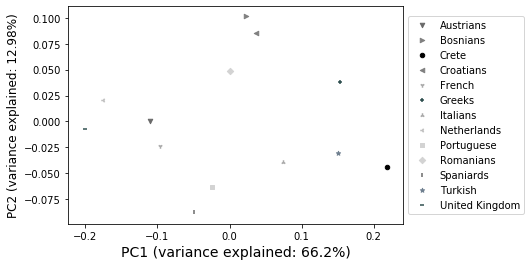

In [101]:
### Prepare the Cretan input for the PCA plots

cre_tmp = cretan_ALL
cre_tmp2 = {k:v for k,v in cre_tmp.items() if v > round(1/(2*1835), 6)}

id_1 = list(range(1, len(cre_tmp)+1))
id_2 = list(range(1, len(cre_tmp2)+1))

allele1 = list(cre_tmp.keys())
allele2 = list(cre_tmp2.keys())

pop1 = ['Cretans']*len(cre_tmp)
pop2 = ['Cretans']*len(cre_tmp2)

af1 = list(cre_tmp.values())
af2 = list(cre_tmp2.values())

sz1 = [1835]*len(cre_tmp)
sz2 = [1835]*len(cre_tmp2)

g1 = [x.split('*')[0] for x in allele1]
g2 = [x.split('*')[0] for x in allele2]

cre = pd.DataFrame({'id': id_1,'allele': allele1,'pop': pop1,'af': af1,'sample_size': sz1,'gene': g1})
cre2 = pd.DataFrame({'id': id_2,'allele': allele2,'pop': pop2,'af': af2,'sample_size': sz2,'gene': g2})

# pca_dkms(cre, austrian_minority_in_Germany, bosnian_minority_in_Germany, croatian_minority_in_Germany, french_minority_in_Germany, italian_minority_in_Germany, netherlands_minority_in_Germany, portuguese_minority_in_Germany, romanian_minority_in_Germany, spanish_minority_in_Germany, turkish_minority_in_Germany, united_kingdom_minority_in_Germany, greek_minority_in_Germany, chinese_minority_in_Germany, all_alleles=True)
# pca_dkms(cre, austrian_minority_in_Germany, bosnian_minority_in_Germany, croatian_minority_in_Germany, french_minority_in_Germany, italian_minority_in_Germany, netherlands_minority_in_Germany, portuguese_minority_in_Germany, romanian_minority_in_Germany, spanish_minority_in_Germany, turkish_minority_in_Germany, united_kingdom_minority_in_Germany, greek_minority_in_Germany, pd.DataFrame(), all_alleles=True)
# pca_dkms(cre2, austrian_minority_in_Germany2, bosnian_minority_in_Germany2, croatian_minority_in_Germany2, french_minority_in_Germany2, italian_minority_in_Germany2, netherlands_minority_in_Germany2, portuguese_minority_in_Germany2, romanian_minority_in_Germany2, spanish_minority_in_Germany2, turkish_minority_in_Germany2, united_kingdom_minority_in_Germany2, greek_minority_in_Germany2, chinese_minority_in_Germany2, all_alleles=True, af_filter=True)
# pca_dkms(cre2, austrian_minority_in_Germany2, bosnian_minority_in_Germany2, croatian_minority_in_Germany2, french_minority_in_Germany2, italian_minority_in_Germany2, netherlands_minority_in_Germany2, portuguese_minority_in_Germany2, romanian_minority_in_Germany2, spanish_minority_in_Germany2, turkish_minority_in_Germany2, united_kingdom_minority_in_Germany2, greek_minority_in_Germany2, pd.DataFrame(), all_alleles=True, af_filter=True)
# pca_dkms(cre, austrian_minority_in_Germany, bosnian_minority_in_Germany, croatian_minority_in_Germany, french_minority_in_Germany, italian_minority_in_Germany, netherlands_minority_in_Germany, portuguese_minority_in_Germany, romanian_minority_in_Germany, spanish_minority_in_Germany, turkish_minority_in_Germany, united_kingdom_minority_in_Germany, greek_minority_in_Germany, chinese_minority_in_Germany, all_alleles=False)
# pca_dkms(cre, austrian_minority_in_Germany, bosnian_minority_in_Germany, croatian_minority_in_Germany, french_minority_in_Germany, italian_minority_in_Germany, netherlands_minority_in_Germany, portuguese_minority_in_Germany, romanian_minority_in_Germany, spanish_minority_in_Germany, turkish_minority_in_Germany, united_kingdom_minority_in_Germany, greek_minority_in_Germany, pd.DataFrame(), all_alleles=False)
# pca_dkms(cre2, austrian_minority_in_Germany2, bosnian_minority_in_Germany2, croatian_minority_in_Germany2, french_minority_in_Germany2, italian_minority_in_Germany2, netherlands_minority_in_Germany2, portuguese_minority_in_Germany2, romanian_minority_in_Germany2, spanish_minority_in_Germany2, turkish_minority_in_Germany2, united_kingdom_minority_in_Germany2, greek_minority_in_Germany2, chinese_minority_in_Germany2, all_alleles=False, af_filter=True)
pca_dkms(cre2, austrian_minority_in_Germany2, bosnian_minority_in_Germany2, croatian_minority_in_Germany2, french_minority_in_Germany2, italian_minority_in_Germany2, netherlands_minority_in_Germany2, portuguese_minority_in_Germany2, romanian_minority_in_Germany2, spanish_minority_in_Germany2, turkish_minority_in_Germany2, united_kingdom_minority_in_Germany2, greek_minority_in_Germany2, pd.DataFrame(), all_alleles=False, af_filter=True)

# pca_dkms(cre, austrian_minority_in_Germany, bosnian_minority_in_Germany, croatian_minority_in_Germany, french_minority_in_Germany, italian_minority_in_Germany, netherlands_minority_in_Germany, portuguese_minority_in_Germany, romanian_minority_in_Germany, spanish_minority_in_Germany, pd.DataFrame(), united_kingdom_minority_in_Germany, greek_minority_in_Germany, pd.DataFrame(), all_alleles=True)
# pca_dkms(cre2, austrian_minority_in_Germany2, bosnian_minority_in_Germany2, croatian_minority_in_Germany2, french_minority_in_Germany2, italian_minority_in_Germany2, netherlands_minority_in_Germany2, portuguese_minority_in_Germany2, romanian_minority_in_Germany2, spanish_minority_in_Germany2, pd.DataFrame(), united_kingdom_minority_in_Germany2, greek_minority_in_Germany2, pd.DataFrame(), all_alleles=True, af_filter=True)
# pca_dkms(cre, austrian_minority_in_Germany, bosnian_minority_in_Germany, croatian_minority_in_Germany, french_minority_in_Germany, italian_minority_in_Germany, netherlands_minority_in_Germany, portuguese_minority_in_Germany, romanian_minority_in_Germany, spanish_minority_in_Germany, pd.DataFrame(), united_kingdom_minority_in_Germany, greek_minority_in_Germany, pd.DataFrame(), all_alleles=False)
# pca_dkms(cre2, austrian_minority_in_Germany2, bosnian_minority_in_Germany2, croatian_minority_in_Germany2, french_minority_in_Germany2, italian_minority_in_Germany2, netherlands_minority_in_Germany2, portuguese_minority_in_Germany2, romanian_minority_in_Germany2, spanish_minority_in_Germany2, pd.DataFrame(), united_kingdom_minority_in_Germany2, greek_minority_in_Germany2, pd.DataFrame(), all_alleles=False, af_filter=True)

In [9]:
def chi2(gene_final_cretan_study, gene_final_freqnet, common_alleles, people_in_study, population, sig_afs=None, counts=None):
    
    if not len(gene_final_cretan_study) == len(gene_final_freqnet) == len(common_alleles):
        raise Exception('Not the same length of common genes')
    
    gene = common_alleles[0].split('*')[0]
    
    cretan_counts = [x*people_in_study*2 for x in gene_final_cretan_study]
    cretan_counts = [np.round(x) for x in cretan_counts]

    af_pop = population['pop'].to_list()[0]
    freqnet_num = population['sample_size'].to_list()[0]   
    
    pop_counts = [x*freqnet_num*2 for x in gene_final_freqnet]
    
    comparison_list = [list(a) for a in zip(cretan_counts, pop_counts)]
    
    if counts:   
        obs = []
        for x in range(len(comparison_list)):
            obs.append(np.round(np.array([comparison_list[x], [people_in_study*2-comparison_list[x][0],freqnet_num*2-comparison_list[x][1]]])))
        
        obs = [np.flip(obs[x], 0).T for x in range(len(obs))]
        
        return obs
    
    comparison_list_af = [list(a) for a in zip(gene_final_cretan_study, gene_final_freqnet)]
        
    pvalues = []

    for x in range(len(comparison_list)):
        obs = np.round(np.array([comparison_list[x], [people_in_study*2-comparison_list[x][0],freqnet_num*2-comparison_list[x][1]]]))
        chi2, p, df, exp = chi2_contingency(obs)
        pvalues.append(p)

    pval_dict = dict(zip(common_alleles, pvalues))

    wanted_alleles = {k:v for k,v in pval_dict.items() if v<0.05}

    initial_dict = dict(zip(common_alleles, zip(gene_final_cretan_study, gene_final_freqnet)))
    significant_dict = {k:v for z,w in wanted_alleles.items() for k,v in initial_dict.items() if z in k}

    if sig_afs:            
        significant_dict = {k:v for k,v in significant_dict.items() if v[0] > round(1/(2*people_in_study), 6) and v[1] > round(1/(2*freqnet_num), 4)}

    common_alleles_sig = list(significant_dict.keys())
    gene_final_cretan_study_sig = [x[0] for x in significant_dict.values()]
    gene_final_freqnet_sig = [x[1] for x in significant_dict.values()]

    return gene_final_cretan_study_sig, gene_final_freqnet_sig, common_alleles_sig 

In [103]:
def confindence_level(a):
    return norm.ppf((1+a)/2)

# confidence interval of the differences between the two proportions
# https://www.bmj.com/about-bmj/resources-readers/publications/statistics-square-one/8-chi-squared-tests
# https://www.bmj.com/about-bmj/resources-readers/publications/statistics-square-one/6-differences-between-percentages-and
    
def CIDB2P(obs, a=0.95):
    
    confidence = confindence_level(a)
#     print ('Confidence:', confidence)
    
    p1 = obs[0][1]/(obs[0][0]+obs[0][1])
    p2 = obs[1][1]/(obs[1][0]+obs[1][1])
    
    diff = np.abs(p1-p2)
#     print ('Proportion difference:', diff)
    
    var = p1*(1-p1)/(obs[0][0]+obs[0][1]) 
    var += p2*(1-p2)/(obs[1][0]+obs[1][1])
    SE = np.sqrt(var)
#     print ('SE:', SE)
    
    return {
        'conf1': diff - confidence*SE,
        'conf2': diff + confidence*SE,
        'diff': diff,
    }   

def af_confidence(obs, alpha=0.95):
    
    conf1 = proportion_confint(obs[0][1], obs[0][0]+obs[0][1], alpha=1-alpha)
    conf2 = proportion_confint(obs[1][1], obs[1][0]+obs[1][1], alpha=1-alpha)
    
    NOT_INTER = conf1[1] < conf2[0] or conf1[0] > conf2[1]
            
    return (conf1, conf2, not NOT_INTER) 

def conf_and_chi2(obs):
    
    a = chi2_contingency(obs)
    b = CIDB2P(obs)
    
    worst_case_diff = b['conf1']
    current_diff = b['diff']
        
    N1 = obs[0][0]+obs[0][1]
    N2 = obs[1][0]+obs[1][1]
    p1 = obs[0][1]/N1
    p2 = obs[1][1]/N2
    
    diff_diff = current_diff - worst_case_diff
    
    if p1<p2:
        new_p1 = p1+diff_diff/2
        new_p2 = p2-diff_diff/2
    else:
        new_p1 = p1-diff_diff/2
        new_p2 = p2+diff_diff/2
    

    worst_case_obs = np.round(np.array([
        [N1*(1-new_p1), N1*new_p1],
        [N2*(1-new_p2), N2*new_p2],
    ]))
    
    worst_case_p = chi2_contingency(worst_case_obs)
#     b_worst_case = CIDB2P(worst_case_obs)

    c = af_confidence(obs)
    
    return {
        'p': a[1],
        'conf': (b['conf1'], b['conf2']),
        'diff': b['diff'],
        'worst_p': worst_case_p[1],
   
        'p1_conf': c[0],
        'p2_conf': c[1],
        'INTER': c[2]
    } 

def af(N_cr, p_cr, N_DKMS, p_DKMS):
    
    obs = 2*np.array([
        [N_cr*(1-p_cr), N_cr*(p_cr)], 
        [N_DKMS*(1-p_DKMS), N_DKMS*(p_DKMS)]
    ])
    
    d = conf_and_chi2(obs)
    
    print (obs)
    return d

def af_counts(N_cr, c_cr, N_DKMS, c_DKMS):
    
    obs = np.array([
        [2*N_cr-c_cr, c_cr], 
        [2*N_DKMS-c_DKMS, c_DKMS]
    ])
    
    d = conf_and_chi2(obs)
    
    print (obs)
    return d  

In [288]:
def significant_alleles_diagram(gene_final_cretan_study, gene_final_freqnet, common_alleles, people_in_study, population, chi_gene, sig_af=None, no_sig_p=None):
    
    if not len(gene_final_cretan_study) == len(gene_final_freqnet) == len(common_alleles) == len(chi_gene):
        raise Exception('Not the same length of common genes')
    
    af_pop = population['pop'].to_list()[0]
    freqnet_num = population['sample_size'].to_list()[0]
    
    value_names = ['Category', 'id', 'cretan_af', 'freqnet_af']
    tmp = [list(x) for x in zip(range(len(common_alleles)), common_alleles, gene_final_cretan_study, gene_final_freqnet)]
    table = [value_names]+tmp
    tmp2 =  {table[i][0] :  {table[0][j]: table[i][j] for j in range(1,len(table[i]))} for i in range(1,len(table))}
    tmp3 = {x:chi_gene[x] for x in range(len(chi_gene))}
    
    for k in tmp2:
        tmp2[k].update(tmp3.get(k, {}))
            
    if sig_af:
        tmp2 = {k:v for k,v in tmp2.items() if v['cretan_af'] > round(1/(2*people_in_study), 6) and v['freqnet_af'] > round(1/(2*freqnet_num), 4)}
    
    sig_p_values = {k:v for k,v in tmp2.items() if v['p'] < 0.05}
    
    if no_sig_p:
        sig_p_values = {k:v for k,v in tmp2.items()}     
    
    keys = dict(zip(list(sig_p_values.keys()), list(range(len(sig_p_values.keys())))))
    sig_p_values = {keys[k]: v for k, v in sig_p_values.items()}
    
    for x in range(len(sig_p_values)):
#         sig_p_values[x]['p']='%0.2f' % -np.log10(sig_p_values[x]['p'])
        sig_p_values[x]['p']="%.2e"%sig_p_values[x]['p']
        
    p_vals = [sig_p_values[x]['p'] for x in range(len(sig_p_values))]
    
    gene_final_cretan_study = [v['cretan_af'] for k,v in sig_p_values.items()]
    gene_final_freqnet = [v['freqnet_af'] for k,v in sig_p_values.items()]
    common_alleles = [v['id'] for k,v in sig_p_values.items()]
    
    common_alleles_num = len(common_alleles)
    gene = common_alleles[0].split('*')[0]
    index = np.arange(common_alleles_num)   
    bar_width = 0.35
       
    fig, ax = plt.subplots()

#     plt.plot([0,0],[0,0], label = 'k=-log10(p-value)', c = 'white')
#     plt.plot([0,0],[0,0], label = '1.30 = -log10(0.05)', c = 'white')
#     plt.plot([0,0],[0,0], label = 'Proportion Difference CI', c = 'brown')
    plt.plot([0,0],[0,0], label = 'Allele Frequency CI', c = 'black')
    
    if 1100 < people_in_study < 1205:    
        Cretans_1204 = ax.bar(index, gene_final_cretan_study, bar_width, label=f"{people_in_study} Cretans", color = 'red')
    
    if 1700 < people_in_study < 2001:    
        Cretans_1204 = ax.bar(index, gene_final_cretan_study, bar_width, label=f"{people_in_study} Cretans", color = 'goldenrod')
#         Cretans_1204 = ax.bar(index, gene_final_cretan_study, bar_width, label=f"{people_in_study} Cretans", color = 'dimgrey')
        
    freq_net = ax.bar(index+bar_width, gene_final_freqnet, bar_width, label=f"{freqnet_num} {af_pop}", color = 'blue')
#     freq_net = ax.bar(index+bar_width, gene_final_freqnet, bar_width, label=f"{freqnet_num} {af_pop}", color = 'darkgrey')

#     sig_X = [list(index+bar_width/2)[x] for x in range(len(common_alleles)) if float(sig_p_values[x]['p']) < 0.05]
#     sig_Y = []

#     for x in range(len(common_alleles)):    
#         if float(sig_p_values[x]['p']) < 0.05:
#             if gene_final_cretan_study[x] >= gene_final_freqnet[x]:
#                 sig_Y.append(gene_final_cretan_study[x])
#             if gene_final_cretan_study[x] < gene_final_freqnet[x]:
#                 sig_Y.append(gene_final_freqnet[x])      

#     sig_Y = [x+0.02 for x in sig_Y]

#     plt.scatter(sig_X, sig_Y, c='black', marker='*', s=10)  
    
    for w in range(len(sig_p_values)):
        
        plt.plot([w,w], [sig_p_values[w]['p1_conf'][0], sig_p_values[w]['p1_conf'][1]], c = 'black')
        plt.plot([w-0.025, w+0.025],[sig_p_values[w]['p1_conf'][0], sig_p_values[w]['p1_conf'][0]], c = 'black')
        plt.plot([w-0.025, w+0.025],[sig_p_values[w]['p1_conf'][1], sig_p_values[w]['p1_conf'][1]], c = 'black')

        plt.plot([bar_width+w,bar_width+w], [sig_p_values[w]['p2_conf'][0], sig_p_values[w]['p2_conf'][1]], c = 'black')
        plt.plot([bar_width+w-0.025, bar_width+w+0.025],[sig_p_values[w]['p2_conf'][0], sig_p_values[w]['p2_conf'][0]], c = 'black')
        plt.plot([bar_width+w-0.025, bar_width+w+0.025],[sig_p_values[w]['p2_conf'][1], sig_p_values[w]['p2_conf'][1]], c = 'black')
          
#         plt.plot([-0.5,common_alleles_num+0.5], [0,0], c = 'black', linestyle='dashed', linewidth=1) 
    
#         plt.plot([2*bar_width+w, 2*bar_width+w], [sig_p_values[w]['conf'][0], sig_p_values[w]['conf'][1]], c = 'brown')
#         plt.plot([2*bar_width+w-0.025, 2*bar_width+w+0.025], [sig_p_values[w]['conf'][0], sig_p_values[w]['conf'][0]], c = 'brown')
#         plt.plot([2*bar_width+w-0.025, 2*bar_width+w+0.025], [sig_p_values[w]['conf'][1], sig_p_values[w]['conf'][1]], c = 'brown')
     
    ax.set_ylabel('Allele Frequency', fontsize=15)
    
    if sig_af and not no_sig_p:
        ax.set_title(f'Comparison of HLA-{gene} frequencies with p < 0.05 and af > 1/2n', fontsize=11)
    elif sig_af and no_sig_p:
        ax.set_title(f'Comparison of HLA-{gene} frequencies with af > 1/2n', fontsize=15)
    elif not sig_af and no_sig_p:
        ax.set_title(f'Comparison of HLA-{gene} frequencies', fontsize=15)
    elif not sig_af and not no_sig_p:
        ax.set_title(f'Comparison of HLA-{gene} frequencies with p < 0.05', fontsize=13)
        
    ax.set_xticks(index + bar_width/2)

#     xlabels = ["k={}, {}".format(x1, x2) for x1, x2, in zip(p_vals, common_alleles)]
    xlabels = ["p={}, {}".format(x1, x2) for x1, x2, in zip(p_vals, common_alleles)]
#     xlabels = common_alleles

    if gene == 'B':
        ax.set_xticklabels(xlabels, rotation=90, fontsize=5)
    else:
        ax.set_xticklabels(xlabels, rotation=90, fontsize=8)
    
    ax.legend(loc='upper right')    
    
#     fig.tight_layout()    
#     fig.set_dpi(300)
    
#     if sig_af and not no_sig_p:
#         if af_pop == 'DKMS with Greeks' or af_pop == 'DKMS without Greeks':      
#             plt.savefig(f'{af_pop}_comparison_{people_in_study}_freqnet/HLA-{gene}/Statistic_comparison_of_HLA-{gene}_frequencies_{people_in_study}_{af_pop}_af_greater_than_1_to_2n_and_p_less_than_0_05_Β.png')
#         else:
#             plt.savefig(f"{af_pop.split(' ')[3]}_in_Germany_comparison_{people_in_study}_freqnet/HLA-{gene}/Statistic_comparison_of_HLA-{gene}_frequencies_{people_in_study}_{af_pop}_af_greater_than_1_to_2n_and_p_less_than_0_05.png")
#     elif sig_af and no_sig_p:
#         if af_pop == 'DKMS with Greeks' or af_pop == 'DKMS without Greeks':      
#             plt.savefig(f'{af_pop}_comparison_{people_in_study}_freqnet/HLA-{gene}/Statistic_comparison_of_HLA-{gene}_frequencies_{people_in_study}_{af_pop}_af_greater_than_1_to_2n_Β.png')
#         else:
#             plt.savefig(f"{af_pop.split(' ')[3]}_in_Germany_comparison_{people_in_study}_freqnet/HLA-{gene}/Statistic_comparison_of_HLA-{gene}_frequencies_{people_in_study}_{af_pop}_af_greater_than_1_to_2n.png")
#     elif not sig_af and no_sig_p:
#         if af_pop == 'DKMS with Greeks' or af_pop == 'DKMS without Greeks':      
#             plt.savefig(f'{af_pop}_comparison_{people_in_study}_freqnet/HLA-{gene}/Statistic_comparison_of_HLA-{gene}_frequencies_{people_in_study}_{af_pop}_Β.png')
#         else:
#             plt.savefig(f"{af_pop.split(' ')[3]}_in_Germany_comparison_{people_in_study}_freqnet/HLA-{gene}/Statistic_comparison_of_HLA-{gene}_frequencies_{people_in_study}_{af_pop}.png")
#     elif not sig_af and not no_sig_p:
#         if af_pop == 'DKMS with Greeks' or af_pop == 'DKMS without Greeks':      
#             plt.savefig(f'{af_pop}_comparison_{people_in_study}_freqnet/HLA-{gene}/Statistic_comparison_of_HLA-{gene}_frequencies_{people_in_study}_{af_pop}_p_less_than_0_05_Β.png')
#         else:
#             plt.savefig(f"{af_pop.split(' ')[3]}_in_Germany_comparison_{people_in_study}_freqnet/HLA-{gene}/Statistic_comparison_of_HLA-{gene}_frequencies_{people_in_study}_{af_pop}_p_less_than_0_05.png")           
                        
    plt.show()

In [113]:
# ## Comparison with intervals on the plot between the allele frequencies of Crete and the Austrian minority

# chi_A_counts = chi2(A_final_1835_AUS_GER, A_final_freqnet_1835_AUS_GER, common_A_1835_AUS_GER, 1835, austrian_minority_in_Germany, counts=True)
# chi_B_counts = chi2(B_final_1835_AUS_GER, B_final_freqnet_1835_AUS_GER, common_B_1835_AUS_GER, 1835, austrian_minority_in_Germany, counts=True)
# chi_C_counts = chi2(C_final_1835_AUS_GER, C_final_freqnet_1835_AUS_GER, common_C_1835_AUS_GER, 1835, austrian_minority_in_Germany, counts=True)
# chi_DRB1_counts = chi2(DRB1_final_1835_AUS_GER, DRB1_final_freqnet_1835_AUS_GER, common_DRB1_1835_AUS_GER, 1835, austrian_minority_in_Germany, counts=True)

# chi_A = [conf_and_chi2(chi_A_counts[x]) for x in range(len(chi_A_counts))]
# chi_B = [conf_and_chi2(chi_B_counts[x]) for x in range(len(chi_B_counts))]
# chi_C = [conf_and_chi2(chi_C_counts[x]) for x in range(len(chi_C_counts))]
# chi_DRB1 = [conf_and_chi2(chi_DRB1_counts[x]) for x in range(len(chi_DRB1_counts))]

# significant_alleles_diagram(A_final_1835_AUS_GER, A_final_freqnet_1835_AUS_GER, common_A_1835_AUS_GER, 1835, austrian_minority_in_Germany, chi_A, sig_af=True, no_sig_p=None)
# significant_alleles_diagram(B_final_1835_AUS_GER, B_final_freqnet_1835_AUS_GER, common_B_1835_AUS_GER, 1835, austrian_minority_in_Germany, chi_B, sig_af=True, no_sig_p=None)
# significant_alleles_diagram(C_final_1835_AUS_GER, C_final_freqnet_1835_AUS_GER, common_C_1835_AUS_GER, 1835, austrian_minority_in_Germany, chi_C, sig_af=True, no_sig_p=None)
# significant_alleles_diagram(DRB1_final_1835_AUS_GER, DRB1_final_freqnet_1835_AUS_GER, common_DRB1_1835_AUS_GER, 1835, austrian_minority_in_Germany, chi_DRB1, sig_af=True, no_sig_p=None)

# significant_alleles_diagram(A_final_1835_AUS_GER, A_final_freqnet_1835_AUS_GER, common_A_1835_AUS_GER, 1835, austrian_minority_in_Germany, chi_A, sig_af=True, no_sig_p=True)
# significant_alleles_diagram(B_final_1835_AUS_GER, B_final_freqnet_1835_AUS_GER, common_B_1835_AUS_GER, 1835, austrian_minority_in_Germany, chi_B, sig_af=True, no_sig_p=True)
# significant_alleles_diagram(C_final_1835_AUS_GER, C_final_freqnet_1835_AUS_GER, common_C_1835_AUS_GER, 1835, austrian_minority_in_Germany, chi_C, sig_af=True, no_sig_p=True)
# significant_alleles_diagram(DRB1_final_1835_AUS_GER, DRB1_final_freqnet_1835_AUS_GER, common_DRB1_1835_AUS_GER, 1835, austrian_minority_in_Germany, chi_DRB1, sig_af=True, no_sig_p=True)

# significant_alleles_diagram(A_final_1835_AUS_GER, A_final_freqnet_1835_AUS_GER, common_A_1835_AUS_GER, 1835, austrian_minority_in_Germany, chi_A, sig_af=None, no_sig_p=True)
# significant_alleles_diagram(B_final_1835_AUS_GER, B_final_freqnet_1835_AUS_GER, common_B_1835_AUS_GER, 1835, austrian_minority_in_Germany, chi_B, sig_af=None, no_sig_p=True)
# significant_alleles_diagram(C_final_1835_AUS_GER, C_final_freqnet_1835_AUS_GER, common_C_1835_AUS_GER, 1835, austrian_minority_in_Germany, chi_C, sig_af=None, no_sig_p=True)
# significant_alleles_diagram(DRB1_final_1835_AUS_GER, DRB1_final_freqnet_1835_AUS_GER, common_DRB1_1835_AUS_GER, 1835, austrian_minority_in_Germany, chi_DRB1, sig_af=None, no_sig_p=True)

# significant_alleles_diagram(A_final_1835_AUS_GER, A_final_freqnet_1835_AUS_GER, common_A_1835_AUS_GER, 1835, austrian_minority_in_Germany, chi_A, sig_af=None, no_sig_p=None)
# significant_alleles_diagram(B_final_1835_AUS_GER, B_final_freqnet_1835_AUS_GER, common_B_1835_AUS_GER, 1835, austrian_minority_in_Germany, chi_B, sig_af=None, no_sig_p=None)
# significant_alleles_diagram(C_final_1835_AUS_GER, C_final_freqnet_1835_AUS_GER, common_C_1835_AUS_GER, 1835, austrian_minority_in_Germany, chi_C, sig_af=None, no_sig_p=None)
# significant_alleles_diagram(DRB1_final_1835_AUS_GER, DRB1_final_freqnet_1835_AUS_GER, common_DRB1_1835_AUS_GER, 1835, austrian_minority_in_Germany, chi_DRB1, sig_af=None, no_sig_p=None)

# ## Comparison with intervals on the plot between the allele frequencies of Crete and the Bosnian minority

# chi_A_counts = chi2(A_final_1835_BOS_GER, A_final_freqnet_1835_BOS_GER, common_A_1835_BOS_GER, 1835, bosnian_minority_in_Germany, counts=True)
# chi_B_counts = chi2(B_final_1835_BOS_GER, B_final_freqnet_1835_BOS_GER, common_B_1835_BOS_GER, 1835, bosnian_minority_in_Germany, counts=True)
# chi_C_counts = chi2(C_final_1835_BOS_GER, C_final_freqnet_1835_BOS_GER, common_C_1835_BOS_GER, 1835, bosnian_minority_in_Germany, counts=True)
# chi_DRB1_counts = chi2(DRB1_final_1835_BOS_GER, DRB1_final_freqnet_1835_BOS_GER, common_DRB1_1835_BOS_GER, 1835, bosnian_minority_in_Germany, counts=True)

# chi_A = [conf_and_chi2(chi_A_counts[x]) for x in range(len(chi_A_counts))]
# chi_B = [conf_and_chi2(chi_B_counts[x]) for x in range(len(chi_B_counts))]
# chi_C = [conf_and_chi2(chi_C_counts[x]) for x in range(len(chi_C_counts))]
# chi_DRB1 = [conf_and_chi2(chi_DRB1_counts[x]) for x in range(len(chi_DRB1_counts))]

# significant_alleles_diagram(A_final_1835_BOS_GER, A_final_freqnet_1835_BOS_GER, common_A_1835_BOS_GER, 1835, bosnian_minority_in_Germany, chi_A, sig_af=True, no_sig_p=None)
# significant_alleles_diagram(B_final_1835_BOS_GER, B_final_freqnet_1835_BOS_GER, common_B_1835_BOS_GER, 1835, bosnian_minority_in_Germany, chi_B, sig_af=True, no_sig_p=None)
# significant_alleles_diagram(C_final_1835_BOS_GER, C_final_freqnet_1835_BOS_GER, common_C_1835_BOS_GER, 1835, bosnian_minority_in_Germany, chi_C, sig_af=True, no_sig_p=None)
# significant_alleles_diagram(DRB1_final_1835_BOS_GER, DRB1_final_freqnet_1835_BOS_GER, common_DRB1_1835_BOS_GER, 1835, bosnian_minority_in_Germany, chi_DRB1, sig_af=True, no_sig_p=None)

# significant_alleles_diagram(A_final_1835_BOS_GER, A_final_freqnet_1835_BOS_GER, common_A_1835_BOS_GER, 1835, bosnian_minority_in_Germany, chi_A, sig_af=True, no_sig_p=True)
# significant_alleles_diagram(B_final_1835_BOS_GER, B_final_freqnet_1835_BOS_GER, common_B_1835_BOS_GER, 1835, bosnian_minority_in_Germany, chi_B, sig_af=True, no_sig_p=True)
# significant_alleles_diagram(C_final_1835_BOS_GER, C_final_freqnet_1835_BOS_GER, common_C_1835_BOS_GER, 1835, bosnian_minority_in_Germany, chi_C, sig_af=True, no_sig_p=True)
# significant_alleles_diagram(DRB1_final_1835_BOS_GER, DRB1_final_freqnet_1835_BOS_GER, common_DRB1_1835_BOS_GER, 1835, bosnian_minority_in_Germany, chi_DRB1, sig_af=True, no_sig_p=True)

# significant_alleles_diagram(A_final_1835_BOS_GER, A_final_freqnet_1835_BOS_GER, common_A_1835_BOS_GER, 1835, bosnian_minority_in_Germany, chi_A, sig_af=None, no_sig_p=True)
# significant_alleles_diagram(B_final_1835_BOS_GER, B_final_freqnet_1835_BOS_GER, common_B_1835_BOS_GER, 1835, bosnian_minority_in_Germany, chi_B, sig_af=None, no_sig_p=True)
# significant_alleles_diagram(C_final_1835_BOS_GER, C_final_freqnet_1835_BOS_GER, common_C_1835_BOS_GER, 1835, bosnian_minority_in_Germany, chi_C, sig_af=None, no_sig_p=True)
# significant_alleles_diagram(DRB1_final_1835_BOS_GER, DRB1_final_freqnet_1835_BOS_GER, common_DRB1_1835_BOS_GER, 1835, bosnian_minority_in_Germany, chi_DRB1, sig_af=None, no_sig_p=True)

# significant_alleles_diagram(A_final_1835_BOS_GER, A_final_freqnet_1835_BOS_GER, common_A_1835_BOS_GER, 1835, bosnian_minority_in_Germany, chi_A, sig_af=None, no_sig_p=None)
# significant_alleles_diagram(B_final_1835_BOS_GER, B_final_freqnet_1835_BOS_GER, common_B_1835_BOS_GER, 1835, bosnian_minority_in_Germany, chi_B, sig_af=None, no_sig_p=None)
# significant_alleles_diagram(C_final_1835_BOS_GER, C_final_freqnet_1835_BOS_GER, common_C_1835_BOS_GER, 1835, bosnian_minority_in_Germany, chi_C, sig_af=None, no_sig_p=None)
# significant_alleles_diagram(DRB1_final_1835_BOS_GER, DRB1_final_freqnet_1835_BOS_GER, common_DRB1_1835_BOS_GER, 1835, bosnian_minority_in_Germany, chi_DRB1, sig_af=None, no_sig_p=None)

# ## Comparison with intervals on the plot between the allele frequencies of Crete and the Chinese minority

# chi_A_counts = chi2(A_final_1835_CHI_GER, A_final_freqnet_1835_CHI_GER, common_A_1835_CHI_GER, 1835, chinese_minority_in_Germany, counts=True)
# chi_B_counts = chi2(B_final_1835_CHI_GER, B_final_freqnet_1835_CHI_GER, common_B_1835_CHI_GER, 1835, chinese_minority_in_Germany, counts=True)
# chi_C_counts = chi2(C_final_1835_CHI_GER, C_final_freqnet_1835_CHI_GER, common_C_1835_CHI_GER, 1835, chinese_minority_in_Germany, counts=True)
# chi_DRB1_counts = chi2(DRB1_final_1835_CHI_GER, DRB1_final_freqnet_1835_CHI_GER, common_DRB1_1835_CHI_GER, 1835, chinese_minority_in_Germany, counts=True)

# chi_A = [conf_and_chi2(chi_A_counts[x]) for x in range(len(chi_A_counts))]
# chi_B = [conf_and_chi2(chi_B_counts[x]) for x in range(len(chi_B_counts))]
# chi_C = [conf_and_chi2(chi_C_counts[x]) for x in range(len(chi_C_counts))]
# chi_DRB1 = [conf_and_chi2(chi_DRB1_counts[x]) for x in range(len(chi_DRB1_counts))]

# significant_alleles_diagram(A_final_1835_CHI_GER, A_final_freqnet_1835_CHI_GER, common_A_1835_CHI_GER, 1835, chinese_minority_in_Germany, chi_A, sig_af=True, no_sig_p=None)
# significant_alleles_diagram(B_final_1835_CHI_GER, B_final_freqnet_1835_CHI_GER, common_B_1835_CHI_GER, 1835, chinese_minority_in_Germany, chi_B, sig_af=True, no_sig_p=None)
# significant_alleles_diagram(C_final_1835_CHI_GER, C_final_freqnet_1835_CHI_GER, common_C_1835_CHI_GER, 1835, chinese_minority_in_Germany, chi_C, sig_af=True, no_sig_p=None)
# significant_alleles_diagram(DRB1_final_1835_CHI_GER, DRB1_final_freqnet_1835_CHI_GER, common_DRB1_1835_CHI_GER, 1835, chinese_minority_in_Germany, chi_DRB1, sig_af=True, no_sig_p=None)

# significant_alleles_diagram(A_final_1835_CHI_GER, A_final_freqnet_1835_CHI_GER, common_A_1835_CHI_GER, 1835, chinese_minority_in_Germany, chi_A, sig_af=True, no_sig_p=True)
# significant_alleles_diagram(B_final_1835_CHI_GER, B_final_freqnet_1835_CHI_GER, common_B_1835_CHI_GER, 1835, chinese_minority_in_Germany, chi_B, sig_af=True, no_sig_p=True)
# significant_alleles_diagram(C_final_1835_CHI_GER, C_final_freqnet_1835_CHI_GER, common_C_1835_CHI_GER, 1835, chinese_minority_in_Germany, chi_C, sig_af=True, no_sig_p=True)
# significant_alleles_diagram(DRB1_final_1835_CHI_GER, DRB1_final_freqnet_1835_CHI_GER, common_DRB1_1835_CHI_GER, 1835, chinese_minority_in_Germany, chi_DRB1, sig_af=True, no_sig_p=True)

# significant_alleles_diagram(A_final_1835_CHI_GER, A_final_freqnet_1835_CHI_GER, common_A_1835_CHI_GER, 1835, chinese_minority_in_Germany, chi_A, sig_af=None, no_sig_p=True)
# significant_alleles_diagram(B_final_1835_CHI_GER, B_final_freqnet_1835_CHI_GER, common_B_1835_CHI_GER, 1835, chinese_minority_in_Germany, chi_B, sig_af=None, no_sig_p=True)
# significant_alleles_diagram(C_final_1835_CHI_GER, C_final_freqnet_1835_CHI_GER, common_C_1835_CHI_GER, 1835, chinese_minority_in_Germany, chi_C, sig_af=None, no_sig_p=True)
# significant_alleles_diagram(DRB1_final_1835_CHI_GER, DRB1_final_freqnet_1835_CHI_GER, common_DRB1_1835_CHI_GER, 1835, chinese_minority_in_Germany, chi_DRB1, sig_af=None, no_sig_p=True)

# significant_alleles_diagram(A_final_1835_CHI_GER, A_final_freqnet_1835_CHI_GER, common_A_1835_CHI_GER, 1835, chinese_minority_in_Germany, chi_A, sig_af=None, no_sig_p=None)
# significant_alleles_diagram(B_final_1835_CHI_GER, B_final_freqnet_1835_CHI_GER, common_B_1835_CHI_GER, 1835, chinese_minority_in_Germany, chi_B, sig_af=None, no_sig_p=None)
# significant_alleles_diagram(C_final_1835_CHI_GER, C_final_freqnet_1835_CHI_GER, common_C_1835_CHI_GER, 1835, chinese_minority_in_Germany, chi_C, sig_af=None, no_sig_p=None)
# significant_alleles_diagram(DRB1_final_1835_CHI_GER, DRB1_final_freqnet_1835_CHI_GER, common_DRB1_1835_CHI_GER, 1835, chinese_minority_in_Germany, chi_DRB1, sig_af=None, no_sig_p=None)

# ## Comparison with intervals on the plot between the allele frequencies of Crete and the Croatian minority

# chi_A_counts = chi2(A_final_1835_CRO_GER, A_final_freqnet_1835_CRO_GER, common_A_1835_CRO_GER, 1835, croatian_minority_in_Germany, counts=True)
# chi_B_counts = chi2(B_final_1835_CRO_GER, B_final_freqnet_1835_CRO_GER, common_B_1835_CRO_GER, 1835, croatian_minority_in_Germany, counts=True)
# chi_C_counts = chi2(C_final_1835_CRO_GER, C_final_freqnet_1835_CRO_GER, common_C_1835_CRO_GER, 1835, croatian_minority_in_Germany, counts=True)
# chi_DRB1_counts = chi2(DRB1_final_1835_CRO_GER, DRB1_final_freqnet_1835_CRO_GER, common_DRB1_1835_CRO_GER, 1835, croatian_minority_in_Germany, counts=True)

# chi_A = [conf_and_chi2(chi_A_counts[x]) for x in range(len(chi_A_counts))]
# chi_B = [conf_and_chi2(chi_B_counts[x]) for x in range(len(chi_B_counts))]
# chi_C = [conf_and_chi2(chi_C_counts[x]) for x in range(len(chi_C_counts))]
# chi_DRB1 = [conf_and_chi2(chi_DRB1_counts[x]) for x in range(len(chi_DRB1_counts))]

# significant_alleles_diagram(A_final_1835_CRO_GER, A_final_freqnet_1835_CRO_GER, common_A_1835_CRO_GER, 1835, croatian_minority_in_Germany, chi_A, sig_af=True, no_sig_p=None)
# significant_alleles_diagram(B_final_1835_CRO_GER, B_final_freqnet_1835_CRO_GER, common_B_1835_CRO_GER, 1835, croatian_minority_in_Germany, chi_B, sig_af=True, no_sig_p=None)
# significant_alleles_diagram(C_final_1835_CRO_GER, C_final_freqnet_1835_CRO_GER, common_C_1835_CRO_GER, 1835, croatian_minority_in_Germany, chi_C, sig_af=True, no_sig_p=None)
# significant_alleles_diagram(DRB1_final_1835_CRO_GER, DRB1_final_freqnet_1835_CRO_GER, common_DRB1_1835_CRO_GER, 1835, croatian_minority_in_Germany, chi_DRB1, sig_af=True, no_sig_p=None)

# significant_alleles_diagram(A_final_1835_CRO_GER, A_final_freqnet_1835_CRO_GER, common_A_1835_CRO_GER, 1835, croatian_minority_in_Germany, chi_A, sig_af=True, no_sig_p=True)
# significant_alleles_diagram(B_final_1835_CRO_GER, B_final_freqnet_1835_CRO_GER, common_B_1835_CRO_GER, 1835, croatian_minority_in_Germany, chi_B, sig_af=True, no_sig_p=True)
# significant_alleles_diagram(C_final_1835_CRO_GER, C_final_freqnet_1835_CRO_GER, common_C_1835_CRO_GER, 1835, croatian_minority_in_Germany, chi_C, sig_af=True, no_sig_p=True)
# significant_alleles_diagram(DRB1_final_1835_CRO_GER, DRB1_final_freqnet_1835_CRO_GER, common_DRB1_1835_CRO_GER, 1835, croatian_minority_in_Germany, chi_DRB1, sig_af=True, no_sig_p=True)

# significant_alleles_diagram(A_final_1835_CRO_GER, A_final_freqnet_1835_CRO_GER, common_A_1835_CRO_GER, 1835, croatian_minority_in_Germany, chi_A, sig_af=None, no_sig_p=True)
# significant_alleles_diagram(B_final_1835_CRO_GER, B_final_freqnet_1835_CRO_GER, common_B_1835_CRO_GER, 1835, croatian_minority_in_Germany, chi_B, sig_af=None, no_sig_p=True)
# significant_alleles_diagram(C_final_1835_CRO_GER, C_final_freqnet_1835_CRO_GER, common_C_1835_CRO_GER, 1835, croatian_minority_in_Germany, chi_C, sig_af=None, no_sig_p=True)
# significant_alleles_diagram(DRB1_final_1835_CRO_GER, DRB1_final_freqnet_1835_CRO_GER, common_DRB1_1835_CRO_GER, 1835, croatian_minority_in_Germany, chi_DRB1, sig_af=None, no_sig_p=True)

# significant_alleles_diagram(A_final_1835_CRO_GER, A_final_freqnet_1835_CRO_GER, common_A_1835_CRO_GER, 1835, croatian_minority_in_Germany, chi_A, sig_af=None, no_sig_p=None)
# significant_alleles_diagram(B_final_1835_CRO_GER, B_final_freqnet_1835_CRO_GER, common_B_1835_CRO_GER, 1835, croatian_minority_in_Germany, chi_B, sig_af=None, no_sig_p=None)
# significant_alleles_diagram(C_final_1835_CRO_GER, C_final_freqnet_1835_CRO_GER, common_C_1835_CRO_GER, 1835, croatian_minority_in_Germany, chi_C, sig_af=None, no_sig_p=None)
# significant_alleles_diagram(DRB1_final_1835_CRO_GER, DRB1_final_freqnet_1835_CRO_GER, common_DRB1_1835_CRO_GER, 1835, croatian_minority_in_Germany, chi_DRB1, sig_af=None, no_sig_p=None)

# ## Comparison with intervals on the plot between the allele frequencies of Crete and the French minority

# chi_A_counts = chi2(A_final_1835_FRE_GER, A_final_freqnet_1835_FRE_GER, common_A_1835_FRE_GER, 1835, french_minority_in_Germany, counts=True)
# chi_B_counts = chi2(B_final_1835_FRE_GER, B_final_freqnet_1835_FRE_GER, common_B_1835_FRE_GER, 1835, french_minority_in_Germany, counts=True)
# chi_C_counts = chi2(C_final_1835_FRE_GER, C_final_freqnet_1835_FRE_GER, common_C_1835_FRE_GER, 1835, french_minority_in_Germany, counts=True)
# chi_DRB1_counts = chi2(DRB1_final_1835_FRE_GER, DRB1_final_freqnet_1835_FRE_GER, common_DRB1_1835_FRE_GER, 1835, french_minority_in_Germany, counts=True)

# chi_A = [conf_and_chi2(chi_A_counts[x]) for x in range(len(chi_A_counts))]
# chi_B = [conf_and_chi2(chi_B_counts[x]) for x in range(len(chi_B_counts))]
# chi_C = [conf_and_chi2(chi_C_counts[x]) for x in range(len(chi_C_counts))]
# chi_DRB1 = [conf_and_chi2(chi_DRB1_counts[x]) for x in range(len(chi_DRB1_counts))]

# significant_alleles_diagram(A_final_1835_FRE_GER, A_final_freqnet_1835_FRE_GER, common_A_1835_FRE_GER, 1835, french_minority_in_Germany, chi_A, sig_af=True, no_sig_p=None)
# significant_alleles_diagram(B_final_1835_FRE_GER, B_final_freqnet_1835_FRE_GER, common_B_1835_FRE_GER, 1835, french_minority_in_Germany, chi_B, sig_af=True, no_sig_p=None)
# significant_alleles_diagram(C_final_1835_FRE_GER, C_final_freqnet_1835_FRE_GER, common_C_1835_FRE_GER, 1835, french_minority_in_Germany, chi_C, sig_af=True, no_sig_p=None)
# significant_alleles_diagram(DRB1_final_1835_FRE_GER, DRB1_final_freqnet_1835_FRE_GER, common_DRB1_1835_FRE_GER, 1835, french_minority_in_Germany, chi_DRB1, sig_af=True, no_sig_p=None)

# significant_alleles_diagram(A_final_1835_FRE_GER, A_final_freqnet_1835_FRE_GER, common_A_1835_FRE_GER, 1835, french_minority_in_Germany, chi_A, sig_af=True, no_sig_p=True)
# significant_alleles_diagram(B_final_1835_FRE_GER, B_final_freqnet_1835_FRE_GER, common_B_1835_FRE_GER, 1835, french_minority_in_Germany, chi_B, sig_af=True, no_sig_p=True)
# significant_alleles_diagram(C_final_1835_FRE_GER, C_final_freqnet_1835_FRE_GER, common_C_1835_FRE_GER, 1835, french_minority_in_Germany, chi_C, sig_af=True, no_sig_p=True)
# significant_alleles_diagram(DRB1_final_1835_FRE_GER, DRB1_final_freqnet_1835_FRE_GER, common_DRB1_1835_FRE_GER, 1835, french_minority_in_Germany, chi_DRB1, sig_af=True, no_sig_p=True)

# significant_alleles_diagram(A_final_1835_FRE_GER, A_final_freqnet_1835_FRE_GER, common_A_1835_FRE_GER, 1835, french_minority_in_Germany, chi_A, sig_af=None, no_sig_p=True)
# significant_alleles_diagram(B_final_1835_FRE_GER, B_final_freqnet_1835_FRE_GER, common_B_1835_FRE_GER, 1835, french_minority_in_Germany, chi_B, sig_af=None, no_sig_p=True)
# significant_alleles_diagram(C_final_1835_FRE_GER, C_final_freqnet_1835_FRE_GER, common_C_1835_FRE_GER, 1835, french_minority_in_Germany, chi_C, sig_af=None, no_sig_p=True)
# significant_alleles_diagram(DRB1_final_1835_FRE_GER, DRB1_final_freqnet_1835_FRE_GER, common_DRB1_1835_FRE_GER, 1835, french_minority_in_Germany, chi_DRB1, sig_af=None, no_sig_p=True)

# significant_alleles_diagram(A_final_1835_FRE_GER, A_final_freqnet_1835_FRE_GER, common_A_1835_FRE_GER, 1835, french_minority_in_Germany, chi_A, sig_af=None, no_sig_p=None)
# significant_alleles_diagram(B_final_1835_FRE_GER, B_final_freqnet_1835_FRE_GER, common_B_1835_FRE_GER, 1835, french_minority_in_Germany, chi_B, sig_af=None, no_sig_p=None)
# significant_alleles_diagram(C_final_1835_FRE_GER, C_final_freqnet_1835_FRE_GER, common_C_1835_FRE_GER, 1835, french_minority_in_Germany, chi_C, sig_af=None, no_sig_p=None)
# significant_alleles_diagram(DRB1_final_1835_FRE_GER, DRB1_final_freqnet_1835_FRE_GER, common_DRB1_1835_FRE_GER, 1835, french_minority_in_Germany, chi_DRB1, sig_af=None, no_sig_p=None)

# ## Comparison with intervals on the plot between the allele frequencies of Crete and the Greek minority

# chi_A_counts = chi2(A_final_1835_GRE_GER, A_final_freqnet_1835_GRE_GER, common_A_1835_GRE_GER, 1835, greek_minority_in_Germany, counts=True)
# chi_B_counts = chi2(B_final_1835_GRE_GER, B_final_freqnet_1835_GRE_GER, common_B_1835_GRE_GER, 1835, greek_minority_in_Germany, counts=True)
# chi_C_counts = chi2(C_final_1835_GRE_GER, C_final_freqnet_1835_GRE_GER, common_C_1835_GRE_GER, 1835, greek_minority_in_Germany, counts=True)
# chi_DRB1_counts = chi2(DRB1_final_1835_GRE_GER, DRB1_final_freqnet_1835_GRE_GER, common_DRB1_1835_GRE_GER, 1835, greek_minority_in_Germany, counts=True)

# chi_A = [conf_and_chi2(chi_A_counts[x]) for x in range(len(chi_A_counts))]
# chi_B = [conf_and_chi2(chi_B_counts[x]) for x in range(len(chi_B_counts))]
# chi_C = [conf_and_chi2(chi_C_counts[x]) for x in range(len(chi_C_counts))]
# chi_DRB1 = [conf_and_chi2(chi_DRB1_counts[x]) for x in range(len(chi_DRB1_counts))]

# significant_alleles_diagram(A_final_1835_GRE_GER, A_final_freqnet_1835_GRE_GER, common_A_1835_GRE_GER, 1835, greek_minority_in_Germany, chi_A, sig_af=True, no_sig_p=None)
# significant_alleles_diagram(B_final_1835_GRE_GER, B_final_freqnet_1835_GRE_GER, common_B_1835_GRE_GER, 1835, greek_minority_in_Germany, chi_B, sig_af=True, no_sig_p=None)
# significant_alleles_diagram(C_final_1835_GRE_GER, C_final_freqnet_1835_GRE_GER, common_C_1835_GRE_GER, 1835, greek_minority_in_Germany, chi_C, sig_af=True, no_sig_p=None)
# significant_alleles_diagram(DRB1_final_1835_GRE_GER, DRB1_final_freqnet_1835_GRE_GER, common_DRB1_1835_GRE_GER, 1835, greek_minority_in_Germany, chi_DRB1, sig_af=True, no_sig_p=None)

# significant_alleles_diagram(A_final_1835_GRE_GER, A_final_freqnet_1835_GRE_GER, common_A_1835_GRE_GER, 1835, greek_minority_in_Germany, chi_A, sig_af=True, no_sig_p=True)
# significant_alleles_diagram(B_final_1835_GRE_GER, B_final_freqnet_1835_GRE_GER, common_B_1835_GRE_GER, 1835, greek_minority_in_Germany, chi_B, sig_af=True, no_sig_p=True)
# significant_alleles_diagram(C_final_1835_GRE_GER, C_final_freqnet_1835_GRE_GER, common_C_1835_GRE_GER, 1835, greek_minority_in_Germany, chi_C, sig_af=True, no_sig_p=True)
# significant_alleles_diagram(DRB1_final_1835_GRE_GER, DRB1_final_freqnet_1835_GRE_GER, common_DRB1_1835_GRE_GER, 1835, greek_minority_in_Germany, chi_DRB1, sig_af=True, no_sig_p=True)

# significant_alleles_diagram(A_final_1835_GRE_GER, A_final_freqnet_1835_GRE_GER, common_A_1835_GRE_GER, 1835, greek_minority_in_Germany, chi_A, sig_af=None, no_sig_p=True)
# significant_alleles_diagram(B_final_1835_GRE_GER, B_final_freqnet_1835_GRE_GER, common_B_1835_GRE_GER, 1835, greek_minority_in_Germany, chi_B, sig_af=None, no_sig_p=True)
# significant_alleles_diagram(C_final_1835_GRE_GER, C_final_freqnet_1835_GRE_GER, common_C_1835_GRE_GER, 1835, greek_minority_in_Germany, chi_C, sig_af=None, no_sig_p=True)
# significant_alleles_diagram(DRB1_final_1835_GRE_GER, DRB1_final_freqnet_1835_GRE_GER, common_DRB1_1835_GRE_GER, 1835, greek_minority_in_Germany, chi_DRB1, sig_af=None, no_sig_p=True)

# significant_alleles_diagram(A_final_1835_GRE_GER, A_final_freqnet_1835_GRE_GER, common_A_1835_GRE_GER, 1835, greek_minority_in_Germany, chi_A, sig_af=None, no_sig_p=None)
# significant_alleles_diagram(B_final_1835_GRE_GER, B_final_freqnet_1835_GRE_GER, common_B_1835_GRE_GER, 1835, greek_minority_in_Germany, chi_B, sig_af=None, no_sig_p=None)
# significant_alleles_diagram(C_final_1835_GRE_GER, C_final_freqnet_1835_GRE_GER, common_C_1835_GRE_GER, 1835, greek_minority_in_Germany, chi_C, sig_af=None, no_sig_p=None)
# significant_alleles_diagram(DRB1_final_1835_GRE_GER, DRB1_final_freqnet_1835_GRE_GER, common_DRB1_1835_GRE_GER, 1835, greek_minority_in_Germany, chi_DRB1, sig_af=None, no_sig_p=None)

# ## Comparison with intervals on the plot between the allele frequencies of Crete and the Italian minority

# chi_A_counts = chi2(A_final_1835_ITA_GER, A_final_freqnet_1835_ITA_GER, common_A_1835_ITA_GER, 1835, italian_minority_in_Germany, counts=True)
# chi_B_counts = chi2(B_final_1835_ITA_GER, B_final_freqnet_1835_ITA_GER, common_B_1835_ITA_GER, 1835, italian_minority_in_Germany, counts=True)
# chi_C_counts = chi2(C_final_1835_ITA_GER, C_final_freqnet_1835_ITA_GER, common_C_1835_ITA_GER, 1835, italian_minority_in_Germany, counts=True)
# chi_DRB1_counts = chi2(DRB1_final_1835_ITA_GER, DRB1_final_freqnet_1835_ITA_GER, common_DRB1_1835_ITA_GER, 1835, italian_minority_in_Germany, counts=True)
# chi_DQB1_counts = chi2(DQB1_final_1835_ITA_GER, DQB1_final_freqnet_1835_ITA_GER, common_DQB1_1835_ITA_GER, 1835, italian_minority_in_Germany, counts=True)

# chi_A = [conf_and_chi2(chi_A_counts[x]) for x in range(len(chi_A_counts))]
# chi_B = [conf_and_chi2(chi_B_counts[x]) for x in range(len(chi_B_counts))]
# chi_C = [conf_and_chi2(chi_C_counts[x]) for x in range(len(chi_C_counts))]
# chi_DRB1 = [conf_and_chi2(chi_DRB1_counts[x]) for x in range(len(chi_DRB1_counts))]
# chi_DQB1 = [conf_and_chi2(chi_DQB1_counts[x]) for x in range(len(chi_DQB1_counts))]

# significant_alleles_diagram(A_final_1835_ITA_GER, A_final_freqnet_1835_ITA_GER, common_A_1835_ITA_GER, 1835, italian_minority_in_Germany, chi_A, sig_af=True, no_sig_p=None)
# significant_alleles_diagram(B_final_1835_ITA_GER, B_final_freqnet_1835_ITA_GER, common_B_1835_ITA_GER, 1835, italian_minority_in_Germany, chi_B, sig_af=True, no_sig_p=None)
# significant_alleles_diagram(C_final_1835_ITA_GER, C_final_freqnet_1835_ITA_GER, common_C_1835_ITA_GER, 1835, italian_minority_in_Germany, chi_C, sig_af=True, no_sig_p=None)
# significant_alleles_diagram(DRB1_final_1835_ITA_GER, DRB1_final_freqnet_1835_ITA_GER, common_DRB1_1835_ITA_GER, 1835, italian_minority_in_Germany, chi_DRB1, sig_af=True, no_sig_p=None)
# significant_alleles_diagram(DQB1_final_1835_ITA_GER, DQB1_final_freqnet_1835_ITA_GER, common_DQB1_1835_ITA_GER, 1835, italian_minority_in_Germany, chi_DQB1, sig_af=True, no_sig_p=None)

# significant_alleles_diagram(A_final_1835_ITA_GER, A_final_freqnet_1835_ITA_GER, common_A_1835_ITA_GER, 1835, italian_minority_in_Germany, chi_A, sig_af=True, no_sig_p=True)
# significant_alleles_diagram(B_final_1835_ITA_GER, B_final_freqnet_1835_ITA_GER, common_B_1835_ITA_GER, 1835, italian_minority_in_Germany, chi_B, sig_af=True, no_sig_p=True)
# significant_alleles_diagram(C_final_1835_ITA_GER, C_final_freqnet_1835_ITA_GER, common_C_1835_ITA_GER, 1835, italian_minority_in_Germany, chi_C, sig_af=True, no_sig_p=True)
# significant_alleles_diagram(DRB1_final_1835_ITA_GER, DRB1_final_freqnet_1835_ITA_GER, common_DRB1_1835_ITA_GER, 1835, italian_minority_in_Germany, chi_DRB1, sig_af=True, no_sig_p=True)
# significant_alleles_diagram(DQB1_final_1835_ITA_GER, DQB1_final_freqnet_1835_ITA_GER, common_DQB1_1835_ITA_GER, 1835, italian_minority_in_Germany, chi_DQB1, sig_af=True, no_sig_p=True)

# significant_alleles_diagram(A_final_1835_ITA_GER, A_final_freqnet_1835_ITA_GER, common_A_1835_ITA_GER, 1835, italian_minority_in_Germany, chi_A, sig_af=None, no_sig_p=True)
# significant_alleles_diagram(B_final_1835_ITA_GER, B_final_freqnet_1835_ITA_GER, common_B_1835_ITA_GER, 1835, italian_minority_in_Germany, chi_B, sig_af=None, no_sig_p=True)
# significant_alleles_diagram(C_final_1835_ITA_GER, C_final_freqnet_1835_ITA_GER, common_C_1835_ITA_GER, 1835, italian_minority_in_Germany, chi_C, sig_af=None, no_sig_p=True)
# significant_alleles_diagram(DRB1_final_1835_ITA_GER, DRB1_final_freqnet_1835_ITA_GER, common_DRB1_1835_ITA_GER, 1835, italian_minority_in_Germany, chi_DRB1, sig_af=None, no_sig_p=True)
# significant_alleles_diagram(DQB1_final_1835_ITA_GER, DQB1_final_freqnet_1835_ITA_GER, common_DQB1_1835_ITA_GER, 1835, italian_minority_in_Germany, chi_DQB1, sig_af=None, no_sig_p=True)

# significant_alleles_diagram(A_final_1835_ITA_GER, A_final_freqnet_1835_ITA_GER, common_A_1835_ITA_GER, 1835, italian_minority_in_Germany, chi_A, sig_af=None, no_sig_p=None)
# significant_alleles_diagram(B_final_1835_ITA_GER, B_final_freqnet_1835_ITA_GER, common_B_1835_ITA_GER, 1835, italian_minority_in_Germany, chi_B, sig_af=None, no_sig_p=None)
# significant_alleles_diagram(C_final_1835_ITA_GER, C_final_freqnet_1835_ITA_GER, common_C_1835_ITA_GER, 1835, italian_minority_in_Germany, chi_C, sig_af=None, no_sig_p=None)
# significant_alleles_diagram(DRB1_final_1835_ITA_GER, DRB1_final_freqnet_1835_ITA_GER, common_DRB1_1835_ITA_GER, 1835, italian_minority_in_Germany, chi_DRB1, sig_af=None, no_sig_p=None)
# significant_alleles_diagram(DQB1_final_1835_ITA_GER, DQB1_final_freqnet_1835_ITA_GER, common_DQB1_1835_ITA_GER, 1835, italian_minority_in_Germany, chi_DQB1, sig_af=None, no_sig_p=None)

# ## Comparison with intervals on the plot between the allele frequencies of Crete and the Netherland minority

# chi_A_counts = chi2(A_final_1835_NET_GER, A_final_freqnet_1835_NET_GER, common_A_1835_NET_GER, 1835, netherlands_minority_in_Germany, counts=True)
# chi_B_counts = chi2(B_final_1835_NET_GER, B_final_freqnet_1835_NET_GER, common_B_1835_NET_GER, 1835, netherlands_minority_in_Germany, counts=True)
# chi_C_counts = chi2(C_final_1835_NET_GER, C_final_freqnet_1835_NET_GER, common_C_1835_NET_GER, 1835, netherlands_minority_in_Germany, counts=True)
# chi_DRB1_counts = chi2(DRB1_final_1835_NET_GER, DRB1_final_freqnet_1835_NET_GER, common_DRB1_1835_NET_GER, 1835, netherlands_minority_in_Germany, counts=True)

# chi_A = [conf_and_chi2(chi_A_counts[x]) for x in range(len(chi_A_counts))]
# chi_B = [conf_and_chi2(chi_B_counts[x]) for x in range(len(chi_B_counts))]
# chi_C = [conf_and_chi2(chi_C_counts[x]) for x in range(len(chi_C_counts))]
# chi_DRB1 = [conf_and_chi2(chi_DRB1_counts[x]) for x in range(len(chi_DRB1_counts))]

# significant_alleles_diagram(A_final_1835_NET_GER, A_final_freqnet_1835_NET_GER, common_A_1835_NET_GER, 1835, netherlands_minority_in_Germany, chi_A, sig_af=True, no_sig_p=None)
# significant_alleles_diagram(B_final_1835_NET_GER, B_final_freqnet_1835_NET_GER, common_B_1835_NET_GER, 1835, netherlands_minority_in_Germany, chi_B, sig_af=True, no_sig_p=None)
# significant_alleles_diagram(C_final_1835_NET_GER, C_final_freqnet_1835_NET_GER, common_C_1835_NET_GER, 1835, netherlands_minority_in_Germany, chi_C, sig_af=True, no_sig_p=None)
# significant_alleles_diagram(DRB1_final_1835_NET_GER, DRB1_final_freqnet_1835_NET_GER, common_DRB1_1835_NET_GER, 1835, netherlands_minority_in_Germany, chi_DRB1, sig_af=True, no_sig_p=None)

# significant_alleles_diagram(A_final_1835_NET_GER, A_final_freqnet_1835_NET_GER, common_A_1835_NET_GER, 1835, netherlands_minority_in_Germany, chi_A, sig_af=True, no_sig_p=True)
# significant_alleles_diagram(B_final_1835_NET_GER, B_final_freqnet_1835_NET_GER, common_B_1835_NET_GER, 1835, netherlands_minority_in_Germany, chi_B, sig_af=True, no_sig_p=True)
# significant_alleles_diagram(C_final_1835_NET_GER, C_final_freqnet_1835_NET_GER, common_C_1835_NET_GER, 1835, netherlands_minority_in_Germany, chi_C, sig_af=True, no_sig_p=True)
# significant_alleles_diagram(DRB1_final_1835_NET_GER, DRB1_final_freqnet_1835_NET_GER, common_DRB1_1835_NET_GER, 1835, netherlands_minority_in_Germany, chi_DRB1, sig_af=True, no_sig_p=True)

# significant_alleles_diagram(A_final_1835_NET_GER, A_final_freqnet_1835_NET_GER, common_A_1835_NET_GER, 1835, netherlands_minority_in_Germany, chi_A, sig_af=None, no_sig_p=True)
# significant_alleles_diagram(B_final_1835_NET_GER, B_final_freqnet_1835_NET_GER, common_B_1835_NET_GER, 1835, netherlands_minority_in_Germany, chi_B, sig_af=None, no_sig_p=True)
# significant_alleles_diagram(C_final_1835_NET_GER, C_final_freqnet_1835_NET_GER, common_C_1835_NET_GER, 1835, netherlands_minority_in_Germany, chi_C, sig_af=None, no_sig_p=True)
# significant_alleles_diagram(DRB1_final_1835_NET_GER, DRB1_final_freqnet_1835_NET_GER, common_DRB1_1835_NET_GER, 1835, netherlands_minority_in_Germany, chi_DRB1, sig_af=None, no_sig_p=True)

# significant_alleles_diagram(A_final_1835_NET_GER, A_final_freqnet_1835_NET_GER, common_A_1835_NET_GER, 1835, netherlands_minority_in_Germany, chi_A, sig_af=None, no_sig_p=None)
# significant_alleles_diagram(B_final_1835_NET_GER, B_final_freqnet_1835_NET_GER, common_B_1835_NET_GER, 1835, netherlands_minority_in_Germany, chi_B, sig_af=None, no_sig_p=None)
# significant_alleles_diagram(C_final_1835_NET_GER, C_final_freqnet_1835_NET_GER, common_C_1835_NET_GER, 1835, netherlands_minority_in_Germany, chi_C, sig_af=None, no_sig_p=None)
# significant_alleles_diagram(DRB1_final_1835_NET_GER, DRB1_final_freqnet_1835_NET_GER, common_DRB1_1835_NET_GER, 1835, netherlands_minority_in_Germany, chi_DRB1, sig_af=None, no_sig_p=None)

# ## Comparison with intervals on the plot between the allele frequencies of Crete and the Portuguese minority

# chi_A_counts = chi2(A_final_1835_POR_GER, A_final_freqnet_1835_POR_GER, common_A_1835_POR_GER, 1835, portuguese_minority_in_Germany, counts=True)
# chi_B_counts = chi2(B_final_1835_POR_GER, B_final_freqnet_1835_POR_GER, common_B_1835_POR_GER, 1835, portuguese_minority_in_Germany, counts=True)
# chi_C_counts = chi2(C_final_1835_POR_GER, C_final_freqnet_1835_POR_GER, common_C_1835_POR_GER, 1835, portuguese_minority_in_Germany, counts=True)
# chi_DRB1_counts = chi2(DRB1_final_1835_POR_GER, DRB1_final_freqnet_1835_POR_GER, common_DRB1_1835_POR_GER, 1835, portuguese_minority_in_Germany, counts=True)

# chi_A = [conf_and_chi2(chi_A_counts[x]) for x in range(len(chi_A_counts))]
# chi_B = [conf_and_chi2(chi_B_counts[x]) for x in range(len(chi_B_counts))]
# chi_C = [conf_and_chi2(chi_C_counts[x]) for x in range(len(chi_C_counts))]
# chi_DRB1 = [conf_and_chi2(chi_DRB1_counts[x]) for x in range(len(chi_DRB1_counts))]

# significant_alleles_diagram(A_final_1835_POR_GER, A_final_freqnet_1835_POR_GER, common_A_1835_POR_GER, 1835, portuguese_minority_in_Germany, chi_A, sig_af=True, no_sig_p=None)
# significant_alleles_diagram(B_final_1835_POR_GER, B_final_freqnet_1835_POR_GER, common_B_1835_POR_GER, 1835, portuguese_minority_in_Germany, chi_B, sig_af=True, no_sig_p=None)
# significant_alleles_diagram(C_final_1835_POR_GER, C_final_freqnet_1835_POR_GER, common_C_1835_POR_GER, 1835, portuguese_minority_in_Germany, chi_C, sig_af=True, no_sig_p=None)
# significant_alleles_diagram(DRB1_final_1835_POR_GER, DRB1_final_freqnet_1835_POR_GER, common_DRB1_1835_POR_GER, 1835, portuguese_minority_in_Germany, chi_DRB1, sig_af=True, no_sig_p=None)

# significant_alleles_diagram(A_final_1835_POR_GER, A_final_freqnet_1835_POR_GER, common_A_1835_POR_GER, 1835, portuguese_minority_in_Germany, chi_A, sig_af=True, no_sig_p=True)
# significant_alleles_diagram(B_final_1835_POR_GER, B_final_freqnet_1835_POR_GER, common_B_1835_POR_GER, 1835, portuguese_minority_in_Germany, chi_B, sig_af=True, no_sig_p=True)
# significant_alleles_diagram(C_final_1835_POR_GER, C_final_freqnet_1835_POR_GER, common_C_1835_POR_GER, 1835, portuguese_minority_in_Germany, chi_C, sig_af=True, no_sig_p=True)
# significant_alleles_diagram(DRB1_final_1835_POR_GER, DRB1_final_freqnet_1835_POR_GER, common_DRB1_1835_POR_GER, 1835, portuguese_minority_in_Germany, chi_DRB1, sig_af=True, no_sig_p=True)

# significant_alleles_diagram(A_final_1835_POR_GER, A_final_freqnet_1835_POR_GER, common_A_1835_POR_GER, 1835, portuguese_minority_in_Germany, chi_A, sig_af=None, no_sig_p=True)
# significant_alleles_diagram(B_final_1835_POR_GER, B_final_freqnet_1835_POR_GER, common_B_1835_POR_GER, 1835, portuguese_minority_in_Germany, chi_B, sig_af=None, no_sig_p=True)
# significant_alleles_diagram(C_final_1835_POR_GER, C_final_freqnet_1835_POR_GER, common_C_1835_POR_GER, 1835, portuguese_minority_in_Germany, chi_C, sig_af=None, no_sig_p=True)
# significant_alleles_diagram(DRB1_final_1835_POR_GER, DRB1_final_freqnet_1835_POR_GER, common_DRB1_1835_POR_GER, 1835, portuguese_minority_in_Germany, chi_DRB1, sig_af=None, no_sig_p=True)

# significant_alleles_diagram(A_final_1835_POR_GER, A_final_freqnet_1835_POR_GER, common_A_1835_POR_GER, 1835, portuguese_minority_in_Germany, chi_A, sig_af=None, no_sig_p=None)
# significant_alleles_diagram(B_final_1835_POR_GER, B_final_freqnet_1835_POR_GER, common_B_1835_POR_GER, 1835, portuguese_minority_in_Germany, chi_B, sig_af=None, no_sig_p=None)
# significant_alleles_diagram(C_final_1835_POR_GER, C_final_freqnet_1835_POR_GER, common_C_1835_POR_GER, 1835, portuguese_minority_in_Germany, chi_C, sig_af=None, no_sig_p=None)
# significant_alleles_diagram(DRB1_final_1835_POR_GER, DRB1_final_freqnet_1835_POR_GER, common_DRB1_1835_POR_GER, 1835, portuguese_minority_in_Germany, chi_DRB1, sig_af=None, no_sig_p=None)

# ## Comparison with intervals on the plot between the allele frequencies of Crete and the Romanian minority

# chi_A_counts = chi2(A_final_1835_ROM_GER, A_final_freqnet_1835_ROM_GER, common_A_1835_ROM_GER, 1835, romanian_minority_in_Germany, counts=True)
# chi_B_counts = chi2(B_final_1835_ROM_GER, B_final_freqnet_1835_ROM_GER, common_B_1835_ROM_GER, 1835, romanian_minority_in_Germany, counts=True)
# chi_C_counts = chi2(C_final_1835_ROM_GER, C_final_freqnet_1835_ROM_GER, common_C_1835_ROM_GER, 1835, romanian_minority_in_Germany, counts=True)
# chi_DRB1_counts = chi2(DRB1_final_1835_ROM_GER, DRB1_final_freqnet_1835_ROM_GER, common_DRB1_1835_ROM_GER, 1835, romanian_minority_in_Germany, counts=True)

# chi_A = [conf_and_chi2(chi_A_counts[x]) for x in range(len(chi_A_counts))]
# chi_B = [conf_and_chi2(chi_B_counts[x]) for x in range(len(chi_B_counts))]
# chi_C = [conf_and_chi2(chi_C_counts[x]) for x in range(len(chi_C_counts))]
# chi_DRB1 = [conf_and_chi2(chi_DRB1_counts[x]) for x in range(len(chi_DRB1_counts))]

# significant_alleles_diagram(A_final_1835_ROM_GER, A_final_freqnet_1835_ROM_GER, common_A_1835_ROM_GER, 1835, romanian_minority_in_Germany, chi_A, sig_af=True, no_sig_p=None)
# significant_alleles_diagram(B_final_1835_ROM_GER, B_final_freqnet_1835_ROM_GER, common_B_1835_ROM_GER, 1835, romanian_minority_in_Germany, chi_B, sig_af=True, no_sig_p=None)
# significant_alleles_diagram(C_final_1835_ROM_GER, C_final_freqnet_1835_ROM_GER, common_C_1835_ROM_GER, 1835, romanian_minority_in_Germany, chi_C, sig_af=True, no_sig_p=None)
# significant_alleles_diagram(DRB1_final_1835_ROM_GER, DRB1_final_freqnet_1835_ROM_GER, common_DRB1_1835_ROM_GER, 1835, romanian_minority_in_Germany, chi_DRB1, sig_af=True, no_sig_p=None)

# significant_alleles_diagram(A_final_1835_ROM_GER, A_final_freqnet_1835_ROM_GER, common_A_1835_ROM_GER, 1835, romanian_minority_in_Germany, chi_A, sig_af=True, no_sig_p=True)
# significant_alleles_diagram(B_final_1835_ROM_GER, B_final_freqnet_1835_ROM_GER, common_B_1835_ROM_GER, 1835, romanian_minority_in_Germany, chi_B, sig_af=True, no_sig_p=True)
# significant_alleles_diagram(C_final_1835_ROM_GER, C_final_freqnet_1835_ROM_GER, common_C_1835_ROM_GER, 1835, romanian_minority_in_Germany, chi_C, sig_af=True, no_sig_p=True)
# significant_alleles_diagram(DRB1_final_1835_ROM_GER, DRB1_final_freqnet_1835_ROM_GER, common_DRB1_1835_ROM_GER, 1835, romanian_minority_in_Germany, chi_DRB1, sig_af=True, no_sig_p=True)

# significant_alleles_diagram(A_final_1835_ROM_GER, A_final_freqnet_1835_ROM_GER, common_A_1835_ROM_GER, 1835, romanian_minority_in_Germany, chi_A, sig_af=None, no_sig_p=True)
# significant_alleles_diagram(B_final_1835_ROM_GER, B_final_freqnet_1835_ROM_GER, common_B_1835_ROM_GER, 1835, romanian_minority_in_Germany, chi_B, sig_af=None, no_sig_p=True)
# significant_alleles_diagram(C_final_1835_ROM_GER, C_final_freqnet_1835_ROM_GER, common_C_1835_ROM_GER, 1835, romanian_minority_in_Germany, chi_C, sig_af=None, no_sig_p=True)
# significant_alleles_diagram(DRB1_final_1835_ROM_GER, DRB1_final_freqnet_1835_ROM_GER, common_DRB1_1835_ROM_GER, 1835, romanian_minority_in_Germany, chi_DRB1, sig_af=None, no_sig_p=True)

# significant_alleles_diagram(A_final_1835_ROM_GER, A_final_freqnet_1835_ROM_GER, common_A_1835_ROM_GER, 1835, romanian_minority_in_Germany, chi_A, sig_af=None, no_sig_p=None)
# significant_alleles_diagram(B_final_1835_ROM_GER, B_final_freqnet_1835_ROM_GER, common_B_1835_ROM_GER, 1835, romanian_minority_in_Germany, chi_B, sig_af=None, no_sig_p=None)
# significant_alleles_diagram(C_final_1835_ROM_GER, C_final_freqnet_1835_ROM_GER, common_C_1835_ROM_GER, 1835, romanian_minority_in_Germany, chi_C, sig_af=None, no_sig_p=None)
# significant_alleles_diagram(DRB1_final_1835_ROM_GER, DRB1_final_freqnet_1835_ROM_GER, common_DRB1_1835_ROM_GER, 1835, romanian_minority_in_Germany, chi_DRB1, sig_af=None, no_sig_p=None)

# ## Comparison with intervals on the plot between the allele frequencies of Crete and the Spanish minority

# chi_A_counts = chi2(A_final_1835_SPA_GER, A_final_freqnet_1835_SPA_GER, common_A_1835_SPA_GER, 1835, spanish_minority_in_Germany, counts=True)
# chi_B_counts = chi2(B_final_1835_SPA_GER, B_final_freqnet_1835_SPA_GER, common_B_1835_SPA_GER, 1835, spanish_minority_in_Germany, counts=True)
# chi_C_counts = chi2(C_final_1835_SPA_GER, C_final_freqnet_1835_SPA_GER, common_C_1835_SPA_GER, 1835, spanish_minority_in_Germany, counts=True)
# chi_DRB1_counts = chi2(DRB1_final_1835_SPA_GER, DRB1_final_freqnet_1835_SPA_GER, common_DRB1_1835_SPA_GER, 1835, spanish_minority_in_Germany, counts=True)

# chi_A = [conf_and_chi2(chi_A_counts[x]) for x in range(len(chi_A_counts))]
# chi_B = [conf_and_chi2(chi_B_counts[x]) for x in range(len(chi_B_counts))]
# chi_C = [conf_and_chi2(chi_C_counts[x]) for x in range(len(chi_C_counts))]
# chi_DRB1 = [conf_and_chi2(chi_DRB1_counts[x]) for x in range(len(chi_DRB1_counts))]

# significant_alleles_diagram(A_final_1835_SPA_GER, A_final_freqnet_1835_SPA_GER, common_A_1835_SPA_GER, 1835, spanish_minority_in_Germany, chi_A, sig_af=True, no_sig_p=None)
# significant_alleles_diagram(B_final_1835_SPA_GER, B_final_freqnet_1835_SPA_GER, common_B_1835_SPA_GER, 1835, spanish_minority_in_Germany, chi_B, sig_af=True, no_sig_p=None)
# significant_alleles_diagram(C_final_1835_SPA_GER, C_final_freqnet_1835_SPA_GER, common_C_1835_SPA_GER, 1835, spanish_minority_in_Germany, chi_C, sig_af=True, no_sig_p=None)
# significant_alleles_diagram(DRB1_final_1835_SPA_GER, DRB1_final_freqnet_1835_SPA_GER, common_DRB1_1835_SPA_GER, 1835, spanish_minority_in_Germany, chi_DRB1, sig_af=True, no_sig_p=None)

# significant_alleles_diagram(A_final_1835_SPA_GER, A_final_freqnet_1835_SPA_GER, common_A_1835_SPA_GER, 1835, spanish_minority_in_Germany, chi_A, sig_af=True, no_sig_p=True)
# significant_alleles_diagram(B_final_1835_SPA_GER, B_final_freqnet_1835_SPA_GER, common_B_1835_SPA_GER, 1835, spanish_minority_in_Germany, chi_B, sig_af=True, no_sig_p=True)
# significant_alleles_diagram(C_final_1835_SPA_GER, C_final_freqnet_1835_SPA_GER, common_C_1835_SPA_GER, 1835, spanish_minority_in_Germany, chi_C, sig_af=True, no_sig_p=True)
# significant_alleles_diagram(DRB1_final_1835_SPA_GER, DRB1_final_freqnet_1835_SPA_GER, common_DRB1_1835_SPA_GER, 1835, spanish_minority_in_Germany, chi_DRB1, sig_af=True, no_sig_p=True)

# significant_alleles_diagram(A_final_1835_SPA_GER, A_final_freqnet_1835_SPA_GER, common_A_1835_SPA_GER, 1835, spanish_minority_in_Germany, chi_A, sig_af=None, no_sig_p=True)
# significant_alleles_diagram(B_final_1835_SPA_GER, B_final_freqnet_1835_SPA_GER, common_B_1835_SPA_GER, 1835, spanish_minority_in_Germany, chi_B, sig_af=None, no_sig_p=True)
# significant_alleles_diagram(C_final_1835_SPA_GER, C_final_freqnet_1835_SPA_GER, common_C_1835_SPA_GER, 1835, spanish_minority_in_Germany, chi_C, sig_af=None, no_sig_p=True)
# significant_alleles_diagram(DRB1_final_1835_SPA_GER, DRB1_final_freqnet_1835_SPA_GER, common_DRB1_1835_SPA_GER, 1835, spanish_minority_in_Germany, chi_DRB1, sig_af=None, no_sig_p=True)

# significant_alleles_diagram(A_final_1835_SPA_GER, A_final_freqnet_1835_SPA_GER, common_A_1835_SPA_GER, 1835, spanish_minority_in_Germany, chi_A, sig_af=None, no_sig_p=None)
# significant_alleles_diagram(B_final_1835_SPA_GER, B_final_freqnet_1835_SPA_GER, common_B_1835_SPA_GER, 1835, spanish_minority_in_Germany, chi_B, sig_af=None, no_sig_p=None)
# significant_alleles_diagram(C_final_1835_SPA_GER, C_final_freqnet_1835_SPA_GER, common_C_1835_SPA_GER, 1835, spanish_minority_in_Germany, chi_C, sig_af=None, no_sig_p=None)
# significant_alleles_diagram(DRB1_final_1835_SPA_GER, DRB1_final_freqnet_1835_SPA_GER, common_DRB1_1835_SPA_GER, 1835, spanish_minority_in_Germany, chi_DRB1, sig_af=None, no_sig_p=None)

# ## Comparison with intervals on the plot between the allele frequencies of Crete and the Turkish minority

# chi_A_counts = chi2(A_final_1835_TUR_GER, A_final_freqnet_1835_TUR_GER, common_A_1835_TUR_GER, 1835, turkish_minority_in_Germany, counts=True)
# chi_B_counts = chi2(B_final_1835_TUR_GER, B_final_freqnet_1835_TUR_GER, common_B_1835_TUR_GER, 1835, turkish_minority_in_Germany, counts=True)
# chi_C_counts = chi2(C_final_1835_TUR_GER, C_final_freqnet_1835_TUR_GER, common_C_1835_TUR_GER, 1835, turkish_minority_in_Germany, counts=True)
# chi_DRB1_counts = chi2(DRB1_final_1835_TUR_GER, DRB1_final_freqnet_1835_TUR_GER, common_DRB1_1835_TUR_GER, 1835, turkish_minority_in_Germany, counts=True)
# chi_DQB1_counts = chi2(DQB1_final_1835_TUR_GER, DQB1_final_freqnet_1835_TUR_GER, common_DQB1_1835_TUR_GER, 1835, turkish_minority_in_Germany, counts=True)

# chi_A = [conf_and_chi2(chi_A_counts[x]) for x in range(len(chi_A_counts))]
# chi_B = [conf_and_chi2(chi_B_counts[x]) for x in range(len(chi_B_counts))]
# chi_C = [conf_and_chi2(chi_C_counts[x]) for x in range(len(chi_C_counts))]
# chi_DRB1 = [conf_and_chi2(chi_DRB1_counts[x]) for x in range(len(chi_DRB1_counts))]
# chi_DQB1 = [conf_and_chi2(chi_DQB1_counts[x]) for x in range(len(chi_DQB1_counts))]

# significant_alleles_diagram(A_final_1835_TUR_GER, A_final_freqnet_1835_TUR_GER, common_A_1835_TUR_GER, 1835, turkish_minority_in_Germany, chi_A, sig_af=True, no_sig_p=None)
# significant_alleles_diagram(B_final_1835_TUR_GER, B_final_freqnet_1835_TUR_GER, common_B_1835_TUR_GER, 1835, turkish_minority_in_Germany, chi_B, sig_af=True, no_sig_p=None)
# significant_alleles_diagram(C_final_1835_TUR_GER, C_final_freqnet_1835_TUR_GER, common_C_1835_TUR_GER, 1835, turkish_minority_in_Germany, chi_C, sig_af=True, no_sig_p=None)
# significant_alleles_diagram(DRB1_final_1835_TUR_GER, DRB1_final_freqnet_1835_TUR_GER, common_DRB1_1835_TUR_GER, 1835, turkish_minority_in_Germany, chi_DRB1, sig_af=True, no_sig_p=None)
# significant_alleles_diagram(DQB1_final_1835_TUR_GER, DQB1_final_freqnet_1835_TUR_GER, common_DQB1_1835_TUR_GER, 1835, turkish_minority_in_Germany, chi_DQB1, sig_af=True, no_sig_p=None)

# significant_alleles_diagram(A_final_1835_TUR_GER, A_final_freqnet_1835_TUR_GER, common_A_1835_TUR_GER, 1835, turkish_minority_in_Germany, chi_A, sig_af=True, no_sig_p=True)
# significant_alleles_diagram(B_final_1835_TUR_GER, B_final_freqnet_1835_TUR_GER, common_B_1835_TUR_GER, 1835, turkish_minority_in_Germany, chi_B, sig_af=True, no_sig_p=True)
# significant_alleles_diagram(C_final_1835_TUR_GER, C_final_freqnet_1835_TUR_GER, common_C_1835_TUR_GER, 1835, turkish_minority_in_Germany, chi_C, sig_af=True, no_sig_p=True)
# significant_alleles_diagram(DRB1_final_1835_TUR_GER, DRB1_final_freqnet_1835_TUR_GER, common_DRB1_1835_TUR_GER, 1835, turkish_minority_in_Germany, chi_DRB1, sig_af=True, no_sig_p=True)
# significant_alleles_diagram(DQB1_final_1835_TUR_GER, DQB1_final_freqnet_1835_TUR_GER, common_DQB1_1835_TUR_GER, 1835, turkish_minority_in_Germany, chi_DQB1, sig_af=True, no_sig_p=True)

# significant_alleles_diagram(A_final_1835_TUR_GER, A_final_freqnet_1835_TUR_GER, common_A_1835_TUR_GER, 1835, turkish_minority_in_Germany, chi_A, sig_af=None, no_sig_p=True)
# significant_alleles_diagram(B_final_1835_TUR_GER, B_final_freqnet_1835_TUR_GER, common_B_1835_TUR_GER, 1835, turkish_minority_in_Germany, chi_B, sig_af=None, no_sig_p=True)
# significant_alleles_diagram(C_final_1835_TUR_GER, C_final_freqnet_1835_TUR_GER, common_C_1835_TUR_GER, 1835, turkish_minority_in_Germany, chi_C, sig_af=None, no_sig_p=True)
# significant_alleles_diagram(DRB1_final_1835_TUR_GER, DRB1_final_freqnet_1835_TUR_GER, common_DRB1_1835_TUR_GER, 1835, turkish_minority_in_Germany, chi_DRB1, sig_af=None, no_sig_p=True)
# significant_alleles_diagram(DQB1_final_1835_TUR_GER, DQB1_final_freqnet_1835_TUR_GER, common_DQB1_1835_TUR_GER, 1835, turkish_minority_in_Germany, chi_DQB1, sig_af=None, no_sig_p=True)

# significant_alleles_diagram(A_final_1835_TUR_GER, A_final_freqnet_1835_TUR_GER, common_A_1835_TUR_GER, 1835, turkish_minority_in_Germany, chi_A, sig_af=None, no_sig_p=None)
# significant_alleles_diagram(B_final_1835_TUR_GER, B_final_freqnet_1835_TUR_GER, common_B_1835_TUR_GER, 1835, turkish_minority_in_Germany, chi_B, sig_af=None, no_sig_p=None)
# significant_alleles_diagram(C_final_1835_TUR_GER, C_final_freqnet_1835_TUR_GER, common_C_1835_TUR_GER, 1835, turkish_minority_in_Germany, chi_C, sig_af=None, no_sig_p=None)
# significant_alleles_diagram(DRB1_final_1835_TUR_GER, DRB1_final_freqnet_1835_TUR_GER, common_DRB1_1835_TUR_GER, 1835, turkish_minority_in_Germany, chi_DRB1, sig_af=None, no_sig_p=None)
# significant_alleles_diagram(DQB1_final_1835_TUR_GER, DQB1_final_freqnet_1835_TUR_GER, common_DQB1_1835_TUR_GER, 1835, turkish_minority_in_Germany, chi_DQB1, sig_af=None, no_sig_p=None)

# ## Comparison with intervals on the plot between the allele frequencies of Crete and the UK minority

# chi_A_counts = chi2(A_final_1835_UKI_GER, A_final_freqnet_1835_UKI_GER, common_A_1835_UKI_GER, 1835, united_kingdom_minority_in_Germany, counts=True)
# chi_B_counts = chi2(B_final_1835_UKI_GER, B_final_freqnet_1835_UKI_GER, common_B_1835_UKI_GER, 1835, united_kingdom_minority_in_Germany, counts=True)
# chi_C_counts = chi2(C_final_1835_UKI_GER, C_final_freqnet_1835_UKI_GER, common_C_1835_UKI_GER, 1835, united_kingdom_minority_in_Germany, counts=True)
# chi_DRB1_counts = chi2(DRB1_final_1835_UKI_GER, DRB1_final_freqnet_1835_UKI_GER, common_DRB1_1835_UKI_GER, 1835, united_kingdom_minority_in_Germany, counts=True)

# chi_A = [conf_and_chi2(chi_A_counts[x]) for x in range(len(chi_A_counts))]
# chi_B = [conf_and_chi2(chi_B_counts[x]) for x in range(len(chi_B_counts))]
# chi_C = [conf_and_chi2(chi_C_counts[x]) for x in range(len(chi_C_counts))]
# chi_DRB1 = [conf_and_chi2(chi_DRB1_counts[x]) for x in range(len(chi_DRB1_counts))]

# significant_alleles_diagram(A_final_1835_UKI_GER, A_final_freqnet_1835_UKI_GER, common_A_1835_UKI_GER, 1835, united_kingdom_minority_in_Germany, chi_A, sig_af=True, no_sig_p=None)
# significant_alleles_diagram(B_final_1835_UKI_GER, B_final_freqnet_1835_UKI_GER, common_B_1835_UKI_GER, 1835, united_kingdom_minority_in_Germany, chi_B, sig_af=True, no_sig_p=None)
# significant_alleles_diagram(C_final_1835_UKI_GER, C_final_freqnet_1835_UKI_GER, common_C_1835_UKI_GER, 1835, united_kingdom_minority_in_Germany, chi_C, sig_af=True, no_sig_p=None)
# significant_alleles_diagram(DRB1_final_1835_UKI_GER, DRB1_final_freqnet_1835_UKI_GER, common_DRB1_1835_UKI_GER, 1835, united_kingdom_minority_in_Germany, chi_DRB1, sig_af=True, no_sig_p=None)

# significant_alleles_diagram(A_final_1835_UKI_GER, A_final_freqnet_1835_UKI_GER, common_A_1835_UKI_GER, 1835, united_kingdom_minority_in_Germany, chi_A, sig_af=True, no_sig_p=True)
# significant_alleles_diagram(B_final_1835_UKI_GER, B_final_freqnet_1835_UKI_GER, common_B_1835_UKI_GER, 1835, united_kingdom_minority_in_Germany, chi_B, sig_af=True, no_sig_p=True)
# significant_alleles_diagram(C_final_1835_UKI_GER, C_final_freqnet_1835_UKI_GER, common_C_1835_UKI_GER, 1835, united_kingdom_minority_in_Germany, chi_C, sig_af=True, no_sig_p=True)
# significant_alleles_diagram(DRB1_final_1835_UKI_GER, DRB1_final_freqnet_1835_UKI_GER, common_DRB1_1835_UKI_GER, 1835, united_kingdom_minority_in_Germany, chi_DRB1, sig_af=True, no_sig_p=True)

# significant_alleles_diagram(A_final_1835_UKI_GER, A_final_freqnet_1835_UKI_GER, common_A_1835_UKI_GER, 1835, united_kingdom_minority_in_Germany, chi_A, sig_af=None, no_sig_p=True)
# significant_alleles_diagram(B_final_1835_UKI_GER, B_final_freqnet_1835_UKI_GER, common_B_1835_UKI_GER, 1835, united_kingdom_minority_in_Germany, chi_B, sig_af=None, no_sig_p=True)
# significant_alleles_diagram(C_final_1835_UKI_GER, C_final_freqnet_1835_UKI_GER, common_C_1835_UKI_GER, 1835, united_kingdom_minority_in_Germany, chi_C, sig_af=None, no_sig_p=True)
# significant_alleles_diagram(DRB1_final_1835_UKI_GER, DRB1_final_freqnet_1835_UKI_GER, common_DRB1_1835_UKI_GER, 1835, united_kingdom_minority_in_Germany, chi_DRB1, sig_af=None, no_sig_p=True)

# significant_alleles_diagram(A_final_1835_UKI_GER, A_final_freqnet_1835_UKI_GER, common_A_1835_UKI_GER, 1835, united_kingdom_minority_in_Germany, chi_A, sig_af=None, no_sig_p=None)
# significant_alleles_diagram(B_final_1835_UKI_GER, B_final_freqnet_1835_UKI_GER, common_B_1835_UKI_GER, 1835, united_kingdom_minority_in_Germany, chi_B, sig_af=None, no_sig_p=None)
# significant_alleles_diagram(C_final_1835_UKI_GER, C_final_freqnet_1835_UKI_GER, common_C_1835_UKI_GER, 1835, united_kingdom_minority_in_Germany, chi_C, sig_af=None, no_sig_p=None)
# significant_alleles_diagram(DRB1_final_1835_UKI_GER, DRB1_final_freqnet_1835_UKI_GER, common_DRB1_1835_UKI_GER, 1835, united_kingdom_minority_in_Germany, chi_DRB1, sig_af=None, no_sig_p=None)

In [18]:
# ### DKMS with Greeks comparison without intervals on the plot

# a,b,c=chi2(A_final_1835_DKMSALL_GER, A_final_freqnet_1835_DKMSALL_GER, common_A_1835_DKMSALL_GER, 1835, DKMS_all_final)
e,f,g=chi2(A_final_1835_DKMSALL_GER, A_final_freqnet_1835_DKMSALL_GER, common_A_1835_DKMSALL_GER, 1835, DKMS_all_final, sig_afs=True)
# h,i,j=chi2(B_final_1835_DKMSALL_GER, B_final_freqnet_1835_DKMSALL_GER, common_B_1835_DKMSALL_GER, 1835, DKMS_all_final)
# k,l,m=chi2(B_final_1835_DKMSALL_GER, B_final_freqnet_1835_DKMSALL_GER, common_B_1835_DKMSALL_GER, 1835, DKMS_all_final, sig_afs=True)
# n,o,p=chi2(C_final_1835_DKMSALL_GER, C_final_freqnet_1835_DKMSALL_GER, common_C_1835_DKMSALL_GER, 1835, DKMS_all_final)
# q,r,s=chi2(C_final_1835_DKMSALL_GER, C_final_freqnet_1835_DKMSALL_GER, common_C_1835_DKMSALL_GER, 1835, DKMS_all_final, sig_afs=True)
# t,u,v=chi2(DRB1_final_1835_DKMSALL_GER, DRB1_final_freqnet_1835_DKMSALL_GER, common_DRB1_1835_DKMSALL_GER, 1835, DKMS_all_final)
# w,x,z=chi2(DRB1_final_1835_DKMSALL_GER, DRB1_final_freqnet_1835_DKMSALL_GER, common_DRB1_1835_DKMSALL_GER, 1835, DKMS_all_final, sig_afs=True)

# get_comparison_diagram(A_final_1835_DKMSALL_GER, A_final_freqnet_1835_DKMSALL_GER, common_A_1835_DKMSALL_GER, 1835, DKMS_all_final)

# ### per allele comparison with af > 1/2n on both populations
# get_comparison_diagram(A_final_1835_DKMSALL_GER, A_final_freqnet_1835_DKMSALL_GER, common_A_1835_DKMSALL_GER, 1835, DKMS_all_final, sig_p=None, sig_af=True)

# ### per allele comparison with chi square p-value < 0.05
# get_comparison_diagram(a,b,c,1835, DKMS_all_final, sig_p=True)

# ### per allele comparison with chi square p-value < 0.05 and  af > 1/2n
# get_comparison_diagram(e,f,g,1835, DKMS_all_final, sig_p=True, sig_af=True)

# get_comparison_diagram(B_final_1835_DKMSALL_GER, B_final_freqnet_1835_DKMSALL_GER, common_B_1835_DKMSALL_GER, 1835, DKMS_all_final)

# ### per allele comparison with af > 1/2n on both populations
# get_comparison_diagram(B_final_1835_DKMSALL_GER, B_final_freqnet_1835_DKMSALL_GER, common_B_1835_DKMSALL_GER, 1835, DKMS_all_final, sig_p=None, sig_af=True)

# ### per allele comparison with chi square p-value < 0.05
# get_comparison_diagram(h,i,j,1835, DKMS_all_final, sig_p=True)

# ### per allele comparison with chi square p-value < 0.05 and  af > 1/2n
# get_comparison_diagram(k,l,m,1835, DKMS_all_final, sig_p=True, sig_af=True)

# get_comparison_diagram(C_final_1835_DKMSALL_GER, C_final_freqnet_1835_DKMSALL_GER, common_C_1835_DKMSALL_GER, 1835, DKMS_all_final)

# ### per allele comparison with af > 1/2n on both populations
# get_comparison_diagram(C_final_1835_DKMSALL_GER, C_final_freqnet_1835_DKMSALL_GER, common_C_1835_DKMSALL_GER, 1835, DKMS_all_final, sig_p=None, sig_af=True)

# ### per allele comparison with chi square p-value < 0.05
# get_comparison_diagram(n,o,p,1835, DKMS_all_final, sig_p=True)

# ### per allele comparison with chi square p-value < 0.05 and  af > 1/2n
# get_comparison_diagram(q,r,s,1835, DKMS_all_final, sig_p=True, sig_af=True)

# get_comparison_diagram(DRB1_final_1835_DKMSALL_GER, DRB1_final_freqnet_1835_DKMSALL_GER, common_DRB1_1835_DKMSALL_GER, 1835, DKMS_all_final)

# ### per allele comparison with af > 1/2n on both populations
# get_comparison_diagram(DRB1_final_1835_DKMSALL_GER, DRB1_final_freqnet_1835_DKMSALL_GER, common_DRB1_1835_DKMSALL_GER, 1835, DKMS_all_final, sig_p=None, sig_af=True)

# ### per allele comparison with chi square p-value < 0.05
# get_comparison_diagram(t,u,v,1835, DKMS_all_final, sig_p=True)

# ### per allele comparison with chi square p-value < 0.05 and  af > 1/2n
# get_comparison_diagram(w,x,z,1835, DKMS_all_final, sig_p=True, sig_af=True)

NameError: name 'A_final_1835_DKMSALL_GER' is not defined

In [146]:
# #### DKMS with Greeks comparison with intervals on the plot

# chi_A_counts = chi2(A_final_1835_DKMSALL_GER, A_final_freqnet_1835_DKMSALL_GER, common_A_1835_DKMSALL_GER, 1835, DKMS_all_final,counts=True)
# chi_B_counts = chi2(B_final_1835_DKMSALL_GER, B_final_freqnet_1835_DKMSALL_GER, common_B_1835_DKMSALL_GER, 1835, DKMS_all_final,counts=True)
# chi_C_counts = chi2(C_final_1835_DKMSALL_GER, C_final_freqnet_1835_DKMSALL_GER, common_C_1835_DKMSALL_GER, 1835, DKMS_all_final,counts=True)
# chi_DRB1_counts = chi2(DRB1_final_1835_DKMSALL_GER, DRB1_final_freqnet_1835_DKMSALL_GER, common_DRB1_1835_DKMSALL_GER, 1835, DKMS_all_final,counts=True)

# chi_A = [conf_and_chi2(chi_A_counts[x]) for x in range(len(chi_A_counts))]
# chi_B = [conf_and_chi2(chi_B_counts[x]) for x in range(len(chi_B_counts))]
# chi_C = [conf_and_chi2(chi_C_counts[x]) for x in range(len(chi_C_counts))]
# chi_DRB1 = [conf_and_chi2(chi_DRB1_counts[x]) for x in range(len(chi_DRB1_counts))]

# significant_alleles_diagram(A_final_1835_DKMSALL_GER, A_final_freqnet_1835_DKMSALL_GER, common_A_1835_DKMSALL_GER, 1835, DKMS_all_final, chi_A, sig_af=None, no_sig_p=None)

# significant_alleles_diagram(A_final_1835_DKMSALL_GER, A_final_freqnet_1835_DKMSALL_GER, common_A_1835_DKMSALL_GER, 1835, DKMS_all_final, chi_A, sig_af=None, no_sig_p=True)

# significant_alleles_diagram(A_final_1835_DKMSALL_GER, A_final_freqnet_1835_DKMSALL_GER, common_A_1835_DKMSALL_GER, 1835, DKMS_all_final, chi_A, sig_af=True, no_sig_p=None)

# significant_alleles_diagram(A_final_1835_DKMSALL_GER, A_final_freqnet_1835_DKMSALL_GER, common_A_1835_DKMSALL_GER, 1835, DKMS_all_final, chi_A, sig_af=True, no_sig_p=True)

# significant_alleles_diagram(B_final_1835_DKMSALL_GER, B_final_freqnet_1835_DKMSALL_GER, common_B_1835_DKMSALL_GER, 1835, DKMS_all_final, chi_B, sig_af=None, no_sig_p=None)

# significant_alleles_diagram(B_final_1835_DKMSALL_GER, B_final_freqnet_1835_DKMSALL_GER, common_B_1835_DKMSALL_GER, 1835, DKMS_all_final, chi_B, sig_af=None, no_sig_p=True)

# significant_alleles_diagram(B_final_1835_DKMSALL_GER, B_final_freqnet_1835_DKMSALL_GER, common_B_1835_DKMSALL_GER, 1835, DKMS_all_final, chi_B, sig_af=True, no_sig_p=None)

# significant_alleles_diagram(B_final_1835_DKMSALL_GER, B_final_freqnet_1835_DKMSALL_GER, common_B_1835_DKMSALL_GER, 1835, DKMS_all_final, chi_B, sig_af=True, no_sig_p=True)

# significant_alleles_diagram(C_final_1835_DKMSALL_GER, C_final_freqnet_1835_DKMSALL_GER, common_C_1835_DKMSALL_GER, 1835, DKMS_all_final, chi_C, sig_af=None, no_sig_p=None)

# significant_alleles_diagram(C_final_1835_DKMSALL_GER, C_final_freqnet_1835_DKMSALL_GER, common_C_1835_DKMSALL_GER, 1835, DKMS_all_final, chi_C, sig_af=None, no_sig_p=True)

# significant_alleles_diagram(C_final_1835_DKMSALL_GER, C_final_freqnet_1835_DKMSALL_GER, common_C_1835_DKMSALL_GER, 1835, DKMS_all_final, chi_C, sig_af=True, no_sig_p=None)

# significant_alleles_diagram(C_final_1835_DKMSALL_GER, C_final_freqnet_1835_DKMSALL_GER, common_C_1835_DKMSALL_GER, 1835, DKMS_all_final, chi_C, sig_af=True, no_sig_p=True)

# significant_alleles_diagram(DRB1_final_1835_DKMSALL_GER, DRB1_final_freqnet_1835_DKMSALL_GER, common_DRB1_1835_DKMSALL_GER, 1835, DKMS_all_final, chi_DRB1, sig_af=None, no_sig_p=None)

# significant_alleles_diagram(DRB1_final_1835_DKMSALL_GER, DRB1_final_freqnet_1835_DKMSALL_GER, common_DRB1_1835_DKMSALL_GER, 1835, DKMS_all_final, chi_DRB1, sig_af=None, no_sig_p=True)

# significant_alleles_diagram(DRB1_final_1835_DKMSALL_GER, DRB1_final_freqnet_1835_DKMSALL_GER, common_DRB1_1835_DKMSALL_GER, 1835, DKMS_all_final, chi_DRB1, sig_af=True, no_sig_p=None)

# significant_alleles_diagram(DRB1_final_1835_DKMSALL_GER, DRB1_final_freqnet_1835_DKMSALL_GER, common_DRB1_1835_DKMSALL_GER, 1835, DKMS_all_final, chi_DRB1, sig_af=True, no_sig_p=True)

In [126]:
# #### DKMS without Greeks comparison without intervals on the plot

# a2,b2,c2=chi2(A_final_1835_DKMSNOGR_GER, A_final_freqnet_1835_DKMSNOGR_GER, common_A_1835_DKMSNOGR_GER, 1835, DKMS_final)
# e2,f2,g2=chi2(A_final_1835_DKMSNOGR_GER, A_final_freqnet_1835_DKMSNOGR_GER, common_A_1835_DKMSNOGR_GER, 1835, DKMS_final, sig_afs=True)
# h2,i2,j2=chi2(B_final_1835_DKMSNOGR_GER, B_final_freqnet_1835_DKMSNOGR_GER, common_B_1835_DKMSNOGR_GER, 1835, DKMS_final)
# k2,l2,m2=chi2(B_final_1835_DKMSNOGR_GER, B_final_freqnet_1835_DKMSNOGR_GER, common_B_1835_DKMSNOGR_GER, 1835, DKMS_final, sig_afs=True)
# n2,o2,p2=chi2(C_final_1835_DKMSNOGR_GER, C_final_freqnet_1835_DKMSNOGR_GER, common_C_1835_DKMSNOGR_GER, 1835, DKMS_final)
# q2,r2,s2=chi2(C_final_1835_DKMSNOGR_GER, C_final_freqnet_1835_DKMSNOGR_GER, common_C_1835_DKMSNOGR_GER, 1835, DKMS_final, sig_afs=True)
# t2,u2,v2=chi2(DRB1_final_1835_DKMSNOGR_GER, DRB1_final_freqnet_1835_DKMSNOGR_GER, common_DRB1_1835_DKMSNOGR_GER, 1835, DKMS_final)
# w2,x2,z2=chi2(DRB1_final_1835_DKMSNOGR_GER, DRB1_final_freqnet_1835_DKMSNOGR_GER, common_DRB1_1835_DKMSNOGR_GER, 1835, DKMS_final, sig_afs=True)

# get_comparison_diagram(A_final_1835_DKMSNOGR_GER, A_final_freqnet_1835_DKMSNOGR_GER, common_A_1835_DKMSNOGR_GER, 1835, DKMS_final)

# ### per allele comparison with af > 1/2n on both populations
# get_comparison_diagram(A_final_1835_DKMSNOGR_GER, A_final_freqnet_1835_DKMSNOGR_GER, common_A_1835_DKMSNOGR_GER, 1835, DKMS_final, sig_p=None, sig_af=True)

# ### per allele comparison with chi square p-value > 0.05
# get_comparison_diagram(a2,b2,c2,1835, DKMS_final, sig_p=True)

# ### per allele comparison with chi square p-value > 0.05 and  af > 1/2n
# get_comparison_diagram(e2,f2,g2,1835, DKMS_final, sig_p=True, sig_af=True)

# get_comparison_diagram(B_final_1835_DKMSNOGR_GER, B_final_freqnet_1835_DKMSNOGR_GER, common_B_1835_DKMSNOGR_GER, 1835, DKMS_final)

# ### per allele comparison with af > 1/2n on both populations
# get_comparison_diagram(B_final_1835_DKMSNOGR_GER, B_final_freqnet_1835_DKMSNOGR_GER, common_B_1835_DKMSNOGR_GER, 1835, DKMS_final, sig_p=None, sig_af=True)

# ### per allele comparison with chi square p-value > 0.05
# get_comparison_diagram(h2,i2,j2,1835, DKMS_final, sig_p=True)

# ### per allele comparison with chi square p-value > 0.05 and  af > 1/2n
# get_comparison_diagram(k2,l2,m2,1835, DKMS_final, sig_p=True, sig_af=True)

# get_comparison_diagram(C_final_1835_DKMSNOGR_GER, C_final_freqnet_1835_DKMSNOGR_GER, common_C_1835_DKMSNOGR_GER, 1835, DKMS_final)

# ### per allele comparison with af > 1/2n on both populations
# get_comparison_diagram(C_final_1835_DKMSNOGR_GER, C_final_freqnet_1835_DKMSNOGR_GER, common_C_1835_DKMSNOGR_GER, 1835, DKMS_final, sig_p=None, sig_af=True)

# ### per allele comparison with chi square p-value > 0.05
# get_comparison_diagram(n2,o2,p2,1835, DKMS_final, sig_p=True)

# ### per allele comparison with chi square p-value > 0.05 and  af > 1/2n
# get_comparison_diagram(q2,r2,s2,1835, DKMS_final, sig_p=True, sig_af=True)

# get_comparison_diagram(DRB1_final_1835_DKMSNOGR_GER, DRB1_final_freqnet_1835_DKMSNOGR_GER, common_DRB1_1835_DKMSNOGR_GER, 1835, DKMS_final)

# ### per allele comparison with af > 1/2n on both populations
# get_comparison_diagram(DRB1_final_1835_DKMSNOGR_GER, DRB1_final_freqnet_1835_DKMSNOGR_GER, common_DRB1_1835_DKMSNOGR_GER, 1835, DKMS_final, sig_p=None, sig_af=True)

# ### per allele comparison with chi square p-value > 0.05
# get_comparison_diagram(t2,u2,v2,1835, DKMS_final, sig_p=True)

# ### per allele comparison with chi square p-value > 0.05 and  af > 1/2n
# get_comparison_diagram(w2,x2,z2,1835, DKMS_final, sig_p=True, sig_af=True)

In [125]:
# #### DKMS without Greeks comparison with intervals on the plot

# chi_A_counts_no_Greeks = chi2(A_final_1835_DKMSNOGR_GER, A_final_freqnet_1835_DKMSNOGR_GER, common_A_1835_DKMSNOGR_GER, 1835, DKMS_final, counts=True)
# chi_B_counts_no_Greeks = chi2(B_final_1835_DKMSNOGR_GER, B_final_freqnet_1835_DKMSNOGR_GER, common_B_1835_DKMSNOGR_GER, 1835, DKMS_final, counts=True)
# chi_C_counts_no_Greeks = chi2(C_final_1835_DKMSNOGR_GER, C_final_freqnet_1835_DKMSNOGR_GER, common_C_1835_DKMSNOGR_GER, 1835, DKMS_final, counts=True)
# chi_DRB1_counts_no_Greeks = chi2(DRB1_final_1835_DKMSNOGR_GER, DRB1_final_freqnet_1835_DKMSNOGR_GER, common_DRB1_1835_DKMSNOGR_GER, 1835, DKMS_final, counts=True)

# chi_A_no_Greeks = [conf_and_chi2(chi_A_counts_no_Greeks[x]) for x in range(len(chi_A_counts_no_Greeks))]
# chi_B_no_Greeks = [conf_and_chi2(chi_B_counts_no_Greeks[x]) for x in range(len(chi_B_counts_no_Greeks))]
# chi_C_no_Greeks = [conf_and_chi2(chi_C_counts_no_Greeks[x]) for x in range(len(chi_C_counts_no_Greeks))]
# chi_DRB1_no_Greeks = [conf_and_chi2(chi_DRB1_counts_no_Greeks[x]) for x in range(len(chi_DRB1_counts_no_Greeks))]

# significant_alleles_diagram(A_final_1835_DKMSNOGR_GER, A_final_freqnet_1835_DKMSNOGR_GER, common_A_1835_DKMSNOGR_GER, 1835, DKMS_final, chi_A_no_Greeks, sig_af=None, no_sig_p=None)

# significant_alleles_diagram(A_final_1835_DKMSNOGR_GER, A_final_freqnet_1835_DKMSNOGR_GER, common_A_1835_DKMSNOGR_GER, 1835, DKMS_final, chi_A_no_Greeks, sig_af=None, no_sig_p=True)

# significant_alleles_diagram(A_final_1835_DKMSNOGR_GER, A_final_freqnet_1835_DKMSNOGR_GER, common_A_1835_DKMSNOGR_GER, 1835, DKMS_final, chi_A_no_Greeks, sig_af=True, no_sig_p=None)

# significant_alleles_diagram(A_final_1835_DKMSNOGR_GER, A_final_freqnet_1835_DKMSNOGR_GER, common_A_1835_DKMSNOGR_GER, 1835, DKMS_final, chi_A_no_Greeks, sig_af=True, no_sig_p=True)

# significant_alleles_diagram(B_final_1835_DKMSNOGR_GER, B_final_freqnet_1835_DKMSNOGR_GER, common_B_1835_DKMSNOGR_GER, 1835, DKMS_final, chi_B_no_Greeks, sig_af=None, no_sig_p=None)

# significant_alleles_diagram(B_final_1835_DKMSNOGR_GER, B_final_freqnet_1835_DKMSNOGR_GER, common_B_1835_DKMSNOGR_GER, 1835, DKMS_final, chi_B_no_Greeks, sig_af=None, no_sig_p=True)

# significant_alleles_diagram(B_final_1835_DKMSNOGR_GER, B_final_freqnet_1835_DKMSNOGR_GER, common_B_1835_DKMSNOGR_GER, 1835, DKMS_final, chi_B_no_Greeks, sig_af=True, no_sig_p=None)

# significant_alleles_diagram(B_final_1835_DKMSNOGR_GER, B_final_freqnet_1835_DKMSNOGR_GER, common_B_1835_DKMSNOGR_GER, 1835, DKMS_final, chi_B_no_Greeks, sig_af=True, no_sig_p=True)

# significant_alleles_diagram(C_final_1835_DKMSNOGR_GER, C_final_freqnet_1835_DKMSNOGR_GER, common_C_1835_DKMSNOGR_GER, 1835, DKMS_final, chi_C_no_Greeks, sig_af=None, no_sig_p=None)

# significant_alleles_diagram(C_final_1835_DKMSNOGR_GER, C_final_freqnet_1835_DKMSNOGR_GER, common_C_1835_DKMSNOGR_GER, 1835, DKMS_final, chi_C_no_Greeks, sig_af=None, no_sig_p=True)

# significant_alleles_diagram(C_final_1835_DKMSNOGR_GER, C_final_freqnet_1835_DKMSNOGR_GER, common_C_1835_DKMSNOGR_GER, 1835, DKMS_final, chi_C_no_Greeks, sig_af=True, no_sig_p=None)

# significant_alleles_diagram(C_final_1835_DKMSNOGR_GER, C_final_freqnet_1835_DKMSNOGR_GER, common_C_1835_DKMSNOGR_GER, 1835, DKMS_final, chi_C_no_Greeks, sig_af=True, no_sig_p=True)

# significant_alleles_diagram(DRB1_final_1835_DKMSNOGR_GER, DRB1_final_freqnet_1835_DKMSNOGR_GER, common_DRB1_1835_DKMSNOGR_GER, 1835, DKMS_final, chi_DRB1_no_Greeks, sig_af=None, no_sig_p=None)

# significant_alleles_diagram(DRB1_final_1835_DKMSNOGR_GER, DRB1_final_freqnet_1835_DKMSNOGR_GER, common_DRB1_1835_DKMSNOGR_GER, 1835, DKMS_final, chi_DRB1_no_Greeks, sig_af=None, no_sig_p=True)

# significant_alleles_diagram(DRB1_final_1835_DKMSNOGR_GER, DRB1_final_freqnet_1835_DKMSNOGR_GER, common_DRB1_1835_DKMSNOGR_GER, 1835, DKMS_final, chi_DRB1_no_Greeks, sig_af=True, no_sig_p=None)

# significant_alleles_diagram(DRB1_final_1835_DKMSNOGR_GER, DRB1_final_freqnet_1835_DKMSNOGR_GER, common_DRB1_1835_DKMSNOGR_GER, 1835, DKMS_final, chi_DRB1_no_Greeks, sig_af=True, no_sig_p=True)

In [133]:
def preprocess_hf(hf_tsv_file):
    
    '''
    This function returns the haplotypic frequencies of the populations of allelefrequencies.net
    '''
    
    with open(hf_tsv_file, 'r') as f:
        a = f.readlines()

    b = [x.strip('\n').split('\t') for x in a]

    c = {'id': [], 'haplotype': [], 'pop': [], 'hf': [], 'sample_size': [], 'location': [], 'counts': []}
    
    for x in b:
        c['id'].append(x[0])
        c['haplotype'].append(x[1])
        c['pop'].append(x[2])
        c['location'].append(x[5])
        
        try:
            c['sample_size'].append(int(x[4].replace(',', '')))
        except Exception as e:
            print (x)
            raise e

        try:
            c['hf'].append(float(x[3]))
            c['counts'].append(float(x[3])*int(x[4].replace(',', '')))
        except Exception as e:
            if x[3] == '':
                c['hf'].append(np.nan)
                c['counts'].append(np.nan)
            else:
                print (x)
                raise e       
        
    return pd.DataFrame(c).sort_values(by='hf', ascending=False)

austrian_hf = preprocess_hf('austrian_minority_hf.tsv')
bosnian_hf = preprocess_hf('bosnia_minority_hf.tsv')
china_hf = preprocess_hf('china_minority_hf.tsv')
croatia_hf = preprocess_hf('croatia_minority_hf.tsv')
french_hf = preprocess_hf('french_minority_hf.tsv')
greek_hf = preprocess_hf('greek_minority_hf.tsv')
tmp_italian_hf = preprocess_hf('italian_minority_hf.tsv')
netherland_hf = preprocess_hf('netherland_minority_hf.tsv')
portugal_hf = preprocess_hf('portugal_minority_hf.tsv')
romanian_hf = preprocess_hf('romanian_minority_hf.tsv')
spanish_hf = preprocess_hf('spanish_minority_hf.tsv')
tmp_turkish_hf = preprocess_hf('turkish_minority_hf.tsv')
united_kingdom_hf = preprocess_hf('united_kingdom_minority_hf.tsv')

In [134]:
# Because the italian and turkish minorities have 5 genes in their haplotypes on allelefrequencies.net,
# as advised by Dr Julia Pingel and Dr Juergen Sauter (authors of the DKMS paper), we dropped the 5th locus
# and we were left with some identical 4-loci haplotypes. Afterwards we added their frequencies. The sum over 
# the remaining 4-locus haplotypes is the closest we can get to the haplotype frequencies with 4 genes.

def update_to_4_genes_in_hf(population):
    
    if population['pop'].to_list()[0] not in ('Germany DKMS - Italy minority', 'Germany DKMS - Turkey minority'):
        raise Exception('Wrong population. Only Italians and Turkish have HLA-DQB1 gene.')
    
    hapl = [x.split('-DQB')[0] for x in population['haplotype'].to_list()]
    hapl_freqs = population['hf'].to_list()
    hapl_counts = population['counts'].to_list()
    
    tup_freqs = [(hapl[x], hapl_freqs[x], hapl_counts[x]) for x in range(len(hapl))]    
    tmp_list = list([x, 0, 0 ]for x in set(hapl))
    
    for x in tmp_list:
        for y in tup_freqs:
            if x[0] == y[0]:
                x[1] += y[1]
                x[2] += y[2]
    
    tmp_list = sorted(tmp_list, key=lambda x:x[1], reverse=True)
    
    pop_di = {'id': [], 'haplotype': [], 'pop': [], 'hf': [], 'sample_size': [], 'location': [], 'counts': []}

    for x in tmp_list:
        pop_di['id'].append(tmp_list.index(x))
        pop_di['haplotype'].append(x[0])
        pop_di['pop'].append(population['pop'][0])
        pop_di['location'].append(population['location'][0])
        pop_di['sample_size'].append(population['sample_size'][0])
        pop_di['counts'].append(x[2])
        pop_di['hf'].append(x[1])
    
    pop_hf = pd.DataFrame(pop_di).sort_values(by='hf', ascending=False)
    
    return pop_hf

italian_hf = update_to_4_genes_in_hf(tmp_italian_hf)
turkish_hf = update_to_4_genes_in_hf(tmp_turkish_hf)

# if os.path.exists('turkish_hf_4genes.tsv'):
#     os.remove('turkish_hf_4genes.tsv')
#     turkish_hf.to_csv('turkish_hf_4genes.tsv', sep='\t')

# if os.path.exists('italian_hf_4genes.tsv'):
#     os.remove('italian_hf_4genes.tsv')
#     italian_hf.to_csv('italian_hf_4genes.tsv', sep='\t')

In [135]:
# We should merge all the DKMS minorities together in order to create a European pool of the HLA haplotype 
# distribution. This is the most important part of the comparison with the DKMS minorities, because this
# pool represents a European sample of donors for transplantation for any given population, like the Cretan.

hf_DKMS_all = pd.concat([greek_hf, austrian_hf, bosnian_hf, croatia_hf, french_hf, italian_hf, netherland_hf, portugal_hf, romanian_hf, spanish_hf, turkish_hf, united_kingdom_hf])
# hf_DKMS_all = pd.concat([greek_hf, austrian_hf, bosnian_hf, croatia_hf, french_hf, italian_hf, netherland_hf, portugal_hf, romanian_hf, spanish_hf, united_kingdom_hf])
# hf_DKMS_all = pd.concat([greek_hf, austrian_hf, bosnian_hf, china_hf, croatia_hf, french_hf, italian_hf, netherland_hf, portugal_hf, romanian_hf, spanish_hf, turkish_hf, united_kingdom_hf])
hf_DKMS = hf_DKMS_all[hf_DKMS_all['pop'] != 'Germany DKMS - Greece minority']

haplotypes_DKMS_all = sorted(list(set(hf_DKMS_all['haplotype']))) 
haplotypes_DKMS = sorted(list(set(hf_DKMS['haplotype'])))

def merge_hf_DKMS(dkms, Greeks=None):

    all_keys = dkms['haplotype'].to_list()
    all_values = dkms['counts'].to_list()
    
    total_num = sum(set(dkms['sample_size'].to_list()))
    
    mydict_all = dict((el,0) for el in list(set(dkms['haplotype'].to_list())))

    for x in mydict_all.keys():
        for y in range(len(all_keys)):
            if all_keys[y] == x:
                mydict_all[x] += all_values[y] / total_num
    
    haplotypes = list(mydict_all.keys())
    
    if Greeks:
        pop = ['DKMS with Greeks']*len(haplotypes)
    else:
        pop = ['DKMS without Greeks']*len(haplotypes)
    
    hf = [x/100.0 for x in list(mydict_all.values())]
    sample_size = [total_num]*len(haplotypes)
    
    final_df = pd.DataFrame(list(zip(haplotypes, pop, hf, sample_size)), columns =['haplotype', 'pop', 'hf', 'sample_size'])
    final_df = final_df.sort_values(by='hf', ascending=False)
    
    return final_df

hf_DKMS_all_final = merge_hf_DKMS(hf_DKMS_all, 'Greeks')
hf_DKMS_final = merge_hf_DKMS(hf_DKMS)

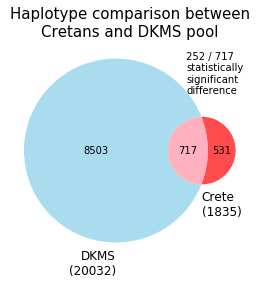

In [138]:
def haplomat_output_parce(hfs_dat, n):
    
    with open(hfs_dat) as f:
        cretan_haplotypes = [x.replace('\n', '').replace('g', '').split() for x in f.readlines()]

    cretan_haplotypes = [( '-'.join(sorted(x[0].split('~'))  ), float(x[1])) for x in cretan_haplotypes]

    cretan_haplotypes = {x[0]:x[1] for x in cretan_haplotypes}
    cretan_haplotypes = {k:v for k,v in cretan_haplotypes.items() if v >= 1/(2*n)}
    
    return cretan_haplotypes

def compare_haplotypes(hfs_dat, population, num_Cretans, no_diagram=None, pvals=None):
    
    '''
    Since we are comparing haplotypes and the DKMS pool only has haplotypes with 4 genes,
    the hfs_dat output file from Hapl-o-Mat should be with the haplotype frequencies of 
    the Cretan population with the same 4 genes (A, B, C, DRB1).
    
    population can either be DKMS pool with or without the Greek minority.
    
    The statistic comparison bewtween the haplotypes will be estimated with Fisher's exact test,
    due to the small number of counts for the haplotypes. Otherwise, chi_square would be used, 
    like in the allele frequency comparison.
    '''
    
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.fisher_exact.html
    
    cretan_haplotypes = haplomat_output_parce(hfs_dat, num_Cretans)
    
    DKMS_haplotypes = dict(zip(population['haplotype'].to_list(), population['hf'].to_list()))
    if population['pop'].to_list()[0] not in ('DKMS with Greeks','DKMS without Greeks'):
        DKMS_haplotypes = {k:v/100 for k,v in DKMS_haplotypes.items()}
        
    if len(list(DKMS_haplotypes.keys())[0].split('-')) == 5:
        tmp = [x.split('-') for x in list(DKMS_haplotypes.keys())]
        tmp = [[x[0],x[1],x[2],x[4],x[3]] for x in tmp]
        tmp = [('-').join(x) for x in tmp]
        DKMS_haplotypes = dict(zip(tmp, list(DKMS_haplotypes.values())))            
        
    num_DKMS = population['sample_size'].to_list()[0]
    
    common_haplotypes = list(set(cretan_haplotypes.keys()) & set(DKMS_haplotypes.keys()))
    
    comparison_list_counts = [[x,0,0] for x in common_haplotypes]
    
    for x in comparison_list_counts:
        x[1] += round(cretan_haplotypes[x[0]]*2*num_Cretans)
        x[2] += round(DKMS_haplotypes[x[0]]*2*num_DKMS)    
    
    comparison_list_counts = sorted(comparison_list_counts, key=lambda x:x[1], reverse=True)
    
    fisher_inputs = [[[2*num_Cretans-x[1], x[1]], [2*num_DKMS-x[2], x[2]]] for x in comparison_list_counts]
    
    p_values = []
    
    for x in fisher_inputs:
        oddsratio, pvalue = stats.fisher_exact(x)
        p_values.append(pvalue)
        
    hapl_pval = dict(zip([x[0] for x in comparison_list_counts], p_values))
    
    if pvals:
        return hapl_pval
    
    sig_hapl_pval = {k:v for k,v in hapl_pval.items() if v < 0.05}
    
#     no_sig = {k:v for k,v in hapl_pval.items() if v >= 0.05}
   
    if no_diagram:
        print(f'Total Cretan haplotypes: {len(cretan_haplotypes)}')
        print(f"Total {population['pop'].to_list()[0]} haplotypes: {len(DKMS_haplotypes)}")
        print(f'Common haplotypes: {len(common_haplotypes)}')       
        print(f'Statistcal Significant: {len(sig_hapl_pval)}\n')
        return
    
    white_patch = mpatches.Patch(color='none', label=f'{len(sig_hapl_pval)} / {len(common_haplotypes)}\nstatistically\nsignificant\ndifference')
    leg = plt.legend(handles=[white_patch], loc='upper right', frameon=False)
    leg.set_alpha(0.0)
    
    venn2(subsets = (len(DKMS_haplotypes)-len(common_haplotypes), len(cretan_haplotypes)-len(common_haplotypes), len(common_haplotypes)), set_labels = (f'DKMS\n({num_DKMS})', f'Crete\n({num_Cretans})'), set_colors=('skyblue', 'red'), alpha = 0.7)
#     venn2(subsets = (len(DKMS_haplotypes)-len(common_haplotypes), len(cretan_haplotypes)-len(common_haplotypes), len(common_haplotypes)), set_labels = (f'DKMS\n({num_DKMS})', f'Crete\n({num_Cretans})'), set_colors=('darkgrey', 'slategrey'), alpha = 0.7)
    plt.title('Haplotype comparison between\nCretans and DKMS pool', fontsize=15)

#     plt.savefig(f'Vehn with {len(common_haplotypes)} common haplotypes.png', dpi=300)

    plt.show()

# compare_haplotypes(g4_path, hf_DKMS_all_final, 1835, pvals=True)
compare_haplotypes(g4_path, hf_DKMS_all_final, 1835)

In [139]:
compare_haplotypes(g4_path, austrian_hf, 1835, no_diagram=True)
compare_haplotypes(g4_path, bosnian_hf, 1835, no_diagram=True)
compare_haplotypes(g4_path, china_hf, 1835, no_diagram=True)
compare_haplotypes(g4_path, croatia_hf, 1835, no_diagram=True)
compare_haplotypes(g4_path, french_hf, 1835, no_diagram=True)
compare_haplotypes(g4_path, greek_hf, 1835, no_diagram=True)
compare_haplotypes(g4_path, italian_hf, 1835, no_diagram=True)
compare_haplotypes(g4_path, netherland_hf, 1835, no_diagram=True)
compare_haplotypes(g4_path, portugal_hf, 1835, no_diagram=True)
compare_haplotypes(g4_path, romanian_hf, 1835, no_diagram=True)
compare_haplotypes(g4_path, spanish_hf, 1835, no_diagram=True)
compare_haplotypes(g4_path, turkish_hf, 1835, no_diagram=True)
compare_haplotypes(g4_path, united_kingdom_hf, 1835, no_diagram=True)

Total Cretan haplotypes: 1248
Total Germany DKMS - Austria minority haplotypes: 1304
Common haplotypes: 222
Statistcal Significant: 37

Total Cretan haplotypes: 1248
Total Germany DKMS - Bosnia and Herzegovina minority haplotypes: 797
Common haplotypes: 184
Statistcal Significant: 33

Total Cretan haplotypes: 1248
Total Germany DKMS - China minority haplotypes: 1119
Common haplotypes: 66
Statistcal Significant: 15

Total Cretan haplotypes: 1248
Total Germany DKMS - Croatia minority haplotypes: 1341
Common haplotypes: 291
Statistcal Significant: 49

Total Cretan haplotypes: 1248
Total Germany DKMS - France minority haplotypes: 1207
Common haplotypes: 209
Statistcal Significant: 30

Total Cretan haplotypes: 1248
Total Germany DKMS - Greece minority haplotypes: 1546
Common haplotypes: 324
Statistcal Significant: 30

Total Cretan haplotypes: 1248
Total Germany DKMS - Italy minority haplotypes: 1064
Common haplotypes: 217
Statistcal Significant: 22

Total Cretan haplotypes: 1248
Total Germa

In [140]:
Crete_DKMS_hapl_fisher = compare_haplotypes(g4_path, hf_DKMS_all_final, 1835, pvals=True)
Crete_Austria_hapl_fisher = compare_haplotypes(g4_path, austrian_hf, 1835, pvals=True)
Crete_Bosnia_hapl_fisher = compare_haplotypes(g4_path, bosnian_hf, 1835, pvals=True)
Crete_China_hapl_fisher = compare_haplotypes(g4_path, china_hf, 1835, pvals=True)
Crete_Croatia_hapl_fisher = compare_haplotypes(g4_path, croatia_hf, 1835, pvals=True)
Crete_France_hapl_fisher = compare_haplotypes(g4_path, french_hf, 1835, pvals=True)
Crete_Greece_hapl_fisher = compare_haplotypes(g4_path, greek_hf, 1835, pvals=True)
Crete_Italy_5_hapl_fisher = compare_haplotypes(g5_path, tmp_italian_hf, 1835, pvals=True)
Crete_Italy_4_hapl_fisher = compare_haplotypes(g4_path, italian_hf, 1835, pvals=True)
Crete_Netherlands_hapl_fisher = compare_haplotypes(g4_path, netherland_hf, 1835, pvals=True)
Crete_Portugal_hapl_fisher = compare_haplotypes(g4_path, portugal_hf, 1835, pvals=True)
Crete_Romania_hapl_fisher = compare_haplotypes(g4_path, romanian_hf, 1835, pvals=True)
Crete_Spain_hapl_fisher = compare_haplotypes(g4_path, spanish_hf, 1835, pvals=True)
Crete_Turkey_5_hapl_fisher = compare_haplotypes(g5_path, tmp_turkish_hf, 1835, pvals=True)
Crete_Turkey_4_hapl_fisher = compare_haplotypes(g4_path, turkish_hf, 1835, pvals=True)
Crete_UK_hapl_fisher = compare_haplotypes(g4_path, united_kingdom_hf, 1835, pvals=True)

In [162]:
cretan_haplotypes = list(haplomat_output_parce(g4_path, 1835).keys()) 
# cretan_haplotypes = []

austrian_haplotypes = austrian_hf['haplotype'].to_list()
bosnian_haplotypes = bosnian_hf['haplotype'].to_list()
china_haplotypes = china_hf['haplotype'].to_list()
croatia_haplotypes = croatia_hf['haplotype'].to_list()
french_haplotypes = french_hf['haplotype'].to_list()
greek_haplotypes = greek_hf['haplotype'].to_list()
italian_haplotypes = italian_hf['haplotype'].to_list()
netherland_haplotypes = netherland_hf['haplotype'].to_list()
portugal_haplotypes = portugal_hf['haplotype'].to_list()
romanian_haplotypes = romanian_hf['haplotype'].to_list()
spanish_haplotypes = spanish_hf['haplotype'].to_list()
turkish_haplotypes = turkish_hf['haplotype'].to_list()
united_kingdom_haplotypes = united_kingdom_hf['haplotype'].to_list()


# cretan_unique_haplotypes = [x for x in cretan_haplotypes if x not in austrian_haplotypes+bosnian_haplotypes+china_haplotypes+croatia_haplotypes+french_haplotypes+greek_haplotypes+italian_haplotypes+netherland_haplotypes+portugal_haplotypes+romanian_haplotypes+spanish_haplotypes+turkish_haplotypes+united_kingdom_haplotypes]
# austrian_unique_haplotypes = [x for x in austrian_haplotypes if x not in cretan_haplotypes+bosnian_haplotypes+china_haplotypes+croatia_haplotypes+french_haplotypes+greek_haplotypes+italian_haplotypes+netherland_haplotypes+portugal_haplotypes+romanian_haplotypes+spanish_haplotypes+turkish_haplotypes+united_kingdom_haplotypes]
# bosnian_unique_haplotypes = [x for x in bosnian_haplotypes if x not in cretan_haplotypes+austrian_haplotypes+china_haplotypes+croatia_haplotypes+french_haplotypes+greek_haplotypes+italian_haplotypes+netherland_haplotypes+portugal_haplotypes+romanian_haplotypes+spanish_haplotypes+turkish_haplotypes+united_kingdom_haplotypes]
# china_unique_haplotypes = [x for x in china_haplotypes if x not in cretan_haplotypes+austrian_haplotypes+bosnian_haplotypes+croatia_haplotypes+french_haplotypes+greek_haplotypes+italian_haplotypes+netherland_haplotypes+portugal_haplotypes+romanian_haplotypes+spanish_haplotypes+turkish_haplotypes+united_kingdom_haplotypes]
# croatia_unique_haplotypes = [x for x in croatia_haplotypes if x not in cretan_haplotypes+austrian_haplotypes+bosnian_haplotypes+china_haplotypes+french_haplotypes+greek_haplotypes+italian_haplotypes+netherland_haplotypes+portugal_haplotypes+romanian_haplotypes+spanish_haplotypes+turkish_haplotypes+united_kingdom_haplotypes]
# french_unique_haplotypes = [x for x in french_haplotypes if x not in cretan_haplotypes+austrian_haplotypes+bosnian_haplotypes+china_haplotypes+croatia_haplotypes+greek_haplotypes+italian_haplotypes+netherland_haplotypes+portugal_haplotypes+romanian_haplotypes+spanish_haplotypes+turkish_haplotypes+united_kingdom_haplotypes]
# greek_unique_haplotypes = [x for x in greek_haplotypes if x not in cretan_haplotypes+austrian_haplotypes+bosnian_haplotypes+china_haplotypes+croatia_haplotypes+french_haplotypes+italian_haplotypes+netherland_haplotypes+portugal_haplotypes+romanian_haplotypes+spanish_haplotypes+turkish_haplotypes+united_kingdom_haplotypes]
# italian_unique_haplotypes = [x for x in italian_haplotypes if x not in cretan_haplotypes+austrian_haplotypes+bosnian_haplotypes+china_haplotypes+croatia_haplotypes+french_haplotypes+greek_haplotypes+netherland_haplotypes+portugal_haplotypes+romanian_haplotypes+spanish_haplotypes+turkish_haplotypes+united_kingdom_haplotypes]
# netherland_unique_haplotypes = [x for x in netherland_haplotypes if x not in cretan_haplotypes+austrian_haplotypes+bosnian_haplotypes+china_haplotypes+croatia_haplotypes+french_haplotypes+greek_haplotypes+italian_haplotypes+portugal_haplotypes+romanian_haplotypes+spanish_haplotypes+turkish_haplotypes+united_kingdom_haplotypes]
# portugal_unique_haplotypes = [x for x in portugal_haplotypes if x not in cretan_haplotypes+austrian_haplotypes+bosnian_haplotypes+china_haplotypes+croatia_haplotypes+french_haplotypes+greek_haplotypes+italian_haplotypes+netherland_haplotypes+romanian_haplotypes+spanish_haplotypes+turkish_haplotypes+united_kingdom_haplotypes]
# romanian_unique_haplotypes = [x for x in romanian_haplotypes if x not in cretan_haplotypes+austrian_haplotypes+bosnian_haplotypes+china_haplotypes+croatia_haplotypes+french_haplotypes+greek_haplotypes+italian_haplotypes+netherland_haplotypes+portugal_haplotypes+spanish_haplotypes+turkish_haplotypes+united_kingdom_haplotypes]
# spanish_unique_haplotypes = [x for x in spanish_haplotypes if x not in cretan_haplotypes+austrian_haplotypes+bosnian_haplotypes+china_haplotypes+croatia_haplotypes+french_haplotypes+greek_haplotypes+italian_haplotypes+netherland_haplotypes+portugal_haplotypes+romanian_haplotypes+turkish_haplotypes+united_kingdom_haplotypes]
# turkish_unique_haplotypes = [x for x in turkish_haplotypes if x not in cretan_haplotypes+austrian_haplotypes+bosnian_haplotypes+china_haplotypes+croatia_haplotypes+french_haplotypes+greek_haplotypes+italian_haplotypes+netherland_haplotypes+portugal_haplotypes+romanian_haplotypes+spanish_haplotypes+united_kingdom_haplotypes]
# united_kingdom_unique_haplotypes = [x for x in united_kingdom_haplotypes if x not in cretan_haplotypes+austrian_haplotypes+bosnian_haplotypes+china_haplotypes+croatia_haplotypes+french_haplotypes+greek_haplotypes+italian_haplotypes+netherland_haplotypes+portugal_haplotypes+romanian_haplotypes+spanish_haplotypes+turkish_haplotypes]

cretan_unique_haplotypes = [x for x in cretan_haplotypes if x not in austrian_haplotypes+bosnian_haplotypes+croatia_haplotypes+french_haplotypes+greek_haplotypes+italian_haplotypes+netherland_haplotypes+portugal_haplotypes+romanian_haplotypes+spanish_haplotypes+turkish_haplotypes+united_kingdom_haplotypes]
austrian_unique_haplotypes = [x for x in austrian_haplotypes if x not in cretan_haplotypes+bosnian_haplotypes+croatia_haplotypes+french_haplotypes+greek_haplotypes+italian_haplotypes+netherland_haplotypes+portugal_haplotypes+romanian_haplotypes+spanish_haplotypes+turkish_haplotypes+united_kingdom_haplotypes]
bosnian_unique_haplotypes = [x for x in bosnian_haplotypes if x not in cretan_haplotypes+austrian_haplotypes+croatia_haplotypes+french_haplotypes+greek_haplotypes+italian_haplotypes+netherland_haplotypes+portugal_haplotypes+romanian_haplotypes+spanish_haplotypes+turkish_haplotypes+united_kingdom_haplotypes]
croatia_unique_haplotypes = [x for x in croatia_haplotypes if x not in cretan_haplotypes+austrian_haplotypes+bosnian_haplotypes+french_haplotypes+greek_haplotypes+italian_haplotypes+netherland_haplotypes+portugal_haplotypes+romanian_haplotypes+spanish_haplotypes+turkish_haplotypes+united_kingdom_haplotypes]
french_unique_haplotypes = [x for x in french_haplotypes if x not in cretan_haplotypes+austrian_haplotypes+bosnian_haplotypes+croatia_haplotypes+greek_haplotypes+italian_haplotypes+netherland_haplotypes+portugal_haplotypes+romanian_haplotypes+spanish_haplotypes+turkish_haplotypes+united_kingdom_haplotypes]
greek_unique_haplotypes = [x for x in greek_haplotypes if x not in cretan_haplotypes+austrian_haplotypes+bosnian_haplotypes+croatia_haplotypes+french_haplotypes+italian_haplotypes+netherland_haplotypes+portugal_haplotypes+romanian_haplotypes+spanish_haplotypes+turkish_haplotypes+united_kingdom_haplotypes]
italian_unique_haplotypes = [x for x in italian_haplotypes if x not in cretan_haplotypes+austrian_haplotypes+bosnian_haplotypes+croatia_haplotypes+french_haplotypes+greek_haplotypes+netherland_haplotypes+portugal_haplotypes+romanian_haplotypes+spanish_haplotypes+turkish_haplotypes+united_kingdom_haplotypes]
netherland_unique_haplotypes = [x for x in netherland_haplotypes if x not in cretan_haplotypes+austrian_haplotypes+bosnian_haplotypes+croatia_haplotypes+french_haplotypes+greek_haplotypes+italian_haplotypes+portugal_haplotypes+romanian_haplotypes+spanish_haplotypes+turkish_haplotypes+united_kingdom_haplotypes]
portugal_unique_haplotypes = [x for x in portugal_haplotypes if x not in cretan_haplotypes+austrian_haplotypes+bosnian_haplotypes+croatia_haplotypes+french_haplotypes+greek_haplotypes+italian_haplotypes+netherland_haplotypes+romanian_haplotypes+spanish_haplotypes+turkish_haplotypes+united_kingdom_haplotypes]
romanian_unique_haplotypes = [x for x in romanian_haplotypes if x not in cretan_haplotypes+austrian_haplotypes+bosnian_haplotypes+croatia_haplotypes+french_haplotypes+greek_haplotypes+italian_haplotypes+netherland_haplotypes+portugal_haplotypes+spanish_haplotypes+turkish_haplotypes+united_kingdom_haplotypes]
spanish_unique_haplotypes = [x for x in spanish_haplotypes if x not in cretan_haplotypes+austrian_haplotypes+bosnian_haplotypes+croatia_haplotypes+french_haplotypes+greek_haplotypes+italian_haplotypes+netherland_haplotypes+portugal_haplotypes+romanian_haplotypes+turkish_haplotypes+united_kingdom_haplotypes]
turkish_unique_haplotypes = [x for x in turkish_haplotypes if x not in cretan_haplotypes+austrian_haplotypes+bosnian_haplotypes+croatia_haplotypes+french_haplotypes+greek_haplotypes+italian_haplotypes+netherland_haplotypes+portugal_haplotypes+romanian_haplotypes+spanish_haplotypes+united_kingdom_haplotypes]
united_kingdom_unique_haplotypes = [x for x in united_kingdom_haplotypes if x not in cretan_haplotypes+austrian_haplotypes+bosnian_haplotypes+croatia_haplotypes+french_haplotypes+greek_haplotypes+italian_haplotypes+netherland_haplotypes+portugal_haplotypes+romanian_haplotypes+spanish_haplotypes+turkish_haplotypes]   

print(len(cretan_unique_haplotypes),f'({round(len(cretan_unique_haplotypes)/len(cretan_haplotypes)*100,1)}%)')
print(len(austrian_unique_haplotypes),f'({round(len(austrian_unique_haplotypes)/len(austrian_haplotypes)*100,1)}%)')
print(len(bosnian_unique_haplotypes),f'({round(len(bosnian_unique_haplotypes)/len(bosnian_haplotypes)*100,1)}%)')
# print(len(china_unique_haplotypes),f'({round(len(china_unique_haplotypes)/len(china_haplotypes)*100,1)}%)')
print(len(croatia_unique_haplotypes),f'({round(len(croatia_unique_haplotypes)/len(croatia_haplotypes)*100,1)}%)')
print(len(french_unique_haplotypes),f'({round(len(french_unique_haplotypes)/len(french_haplotypes)*100,1)}%)')
print(len(greek_unique_haplotypes),f'({round(len(greek_unique_haplotypes)/len(greek_haplotypes)*100,1)}%)')
print(len(italian_unique_haplotypes),f'({round(len(italian_unique_haplotypes)/len(italian_haplotypes)*100,1)}%)')
print(len(netherland_unique_haplotypes),f'({round(len(netherland_unique_haplotypes)/len(netherland_haplotypes)*100,1)}%)')
print(len(portugal_unique_haplotypes),f'({round(len(portugal_unique_haplotypes)/len(portugal_haplotypes)*100,1)}%)')
print(len(romanian_unique_haplotypes),f'({round(len(romanian_unique_haplotypes)/len(romanian_haplotypes)*100,1)}%)')
print(len(spanish_unique_haplotypes),f'({round(len(spanish_unique_haplotypes)/len(spanish_haplotypes)*100,1)}%)')
print(len(turkish_unique_haplotypes),f'({round(len(turkish_unique_haplotypes)/len(turkish_haplotypes)*100,1)}%)')
print(len(united_kingdom_unique_haplotypes),f'({round(len(united_kingdom_unique_haplotypes)/len(united_kingdom_haplotypes)*100,1)}%)')

531 (42.5%)
500 (38.3%)
222 (27.9%)
450 (33.6%)
509 (42.2%)
621 (40.2%)
442 (41.5%)
347 (34.8%)
428 (40.8%)
355 (33.4%)
453 (44.6%)
1848 (56.8%)
290 (36.0%)


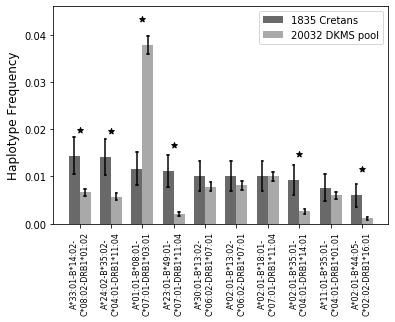

In [169]:
### Statistic comparison of the 10 most common haplotypes of Crete with the DKMS pool

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

n_DKMS = hf_DKMS_all_final['sample_size'].to_list()[0]

cr_hapl = haplomat_output_parce(g4_path, n_Cretans)
top10_cr_hapl = take(10, cr_hapl.items())
top10_cr_hapl = {k:v for k,v in [y for y in top10_cr_hapl]}
top10_haplotypes = list(top10_cr_hapl.keys())

DKMS_hapls = dict(zip(hf_DKMS_all_final['haplotype'].to_list(), hf_DKMS_all_final['hf'].to_list()))
common_hapl_pvals = compare_haplotypes(g4_path, hf_DKMS_all_final, n_Cretans, pvals=True)

comparison_list_counts = [[x,0,0] for x in top10_haplotypes]
    
for x in comparison_list_counts:
    x[1] += round(top10_cr_hapl[x[0]]*2*n_Cretans)
    x[2] += round(DKMS_hapls[x[0]]*2*n_DKMS)    

chi2_inputs = [np.array([[2*n_Cretans-x[1], x[1]], [2*n_DKMS-x[2], x[2]]]) for x in comparison_list_counts]

top10_hapl_stats = [conf_and_chi2(x) for x in chi2_inputs]

index = np.arange(len(top10_haplotypes)) 
bar_width = 0.35

fig, ax = plt.subplots()

# Cretans = ax.bar(index, [top10_cr_hapl[x] for x in top10_haplotypes], bar_width, label=f"{n_Cretans} Cretans", color = 'goldenrod')
# freq_net = ax.bar(index+bar_width, [DKMS_hapls[x] for x in top10_haplotypes], bar_width, label=f"{n_DKMS} DKMS pool", color = 'blue')
Cretans = ax.bar(index, [top10_cr_hapl[x] for x in top10_haplotypes], bar_width, label=f"{n_Cretans} Cretans", color = 'dimgrey')
freq_net = ax.bar(index+bar_width, [DKMS_hapls[x] for x in top10_haplotypes], bar_width, label=f"{n_DKMS} DKMS pool", color = 'darkgrey')

sig_X = [list(index+bar_width/2)[x] for x in range(len(top10_haplotypes)) if common_hapl_pvals[top10_haplotypes[x]] < 0.05]
sig_Y = []
for x in top10_haplotypes:    
    if common_hapl_pvals[x] < 0.05:
        if top10_cr_hapl[x] >= DKMS_hapls[x]:
            sig_Y.append(top10_cr_hapl[x])
        if top10_cr_hapl[x] < DKMS_hapls[x]:
            sig_Y.append(DKMS_hapls[x])

# sig_Y = [x+0.003 for x in sig_Y]       

sig_Y = [x+0.0055 for x in sig_Y]

for w in range(len(top10_hapl_stats)):
        
    plt.plot([w,w], [top10_hapl_stats[w]['p1_conf'][0], top10_hapl_stats[w]['p1_conf'][1]], c = 'black')
    plt.plot([w-0.025, w+0.025],[top10_hapl_stats[w]['p1_conf'][0], top10_hapl_stats[w]['p1_conf'][0]], c = 'black')
    plt.plot([w-0.025, w+0.025],[top10_hapl_stats[w]['p1_conf'][1], top10_hapl_stats[w]['p1_conf'][1]], c = 'black')

    plt.plot([bar_width+w,bar_width+w], [top10_hapl_stats[w]['p2_conf'][0], top10_hapl_stats[w]['p2_conf'][1]], c = 'black')
    plt.plot([bar_width+w-0.025, bar_width+w+0.025],[top10_hapl_stats[w]['p2_conf'][0], top10_hapl_stats[w]['p2_conf'][0]], c = 'black')
    plt.plot([bar_width+w-0.025, bar_width+w+0.025],[top10_hapl_stats[w]['p2_conf'][1], top10_hapl_stats[w]['p2_conf'][1]], c = 'black')
        
plt.scatter(sig_X, sig_Y, c='black', marker='*')
# plt.plot([0,0],[0,0], label = 'Haplotype Frequency CI', c = 'black')

ax.set_ylabel('Haplotype Frequency', fontsize=12)
ax.set_xticks(index + bar_width/2)
# ax.set_xticklabels([x+'\n'+"p = "+"%.2e"%common_hapl_pvals[x] for x in top10_haplotypes], rotation=90, fontsize=6)
ax.set_xticklabels([x.split('-')[0]+'-'+x.split('-')[1]+'-\n'+x.split('-')[2]+'-'+x.split('-')[3] for x in top10_haplotypes], rotation=90, fontsize=8)

# pvals_xticks = ['p = '+"%.2e"%common_hapl_pvals[x] if float(common_hapl_pvals[x])<0.05 else '' for x in top10_haplotypes]
# ax.set_xticklabels([top10_haplotypes[x].split('-')[0]+'-'+top10_haplotypes[x].split('-')[1]+'-\n'+top10_haplotypes[x].split('-')[2]+'-'+top10_haplotypes[x].split('-')[3]+'\n'+pvals_xticks[x] for x in range(len(top10_haplotypes))], rotation=90, fontsize=7)

ax.legend()

# fig.tight_layout()    
# fig.set_dpi(300)
# plt.savefig(f'Top 10 Cretan haplotypes comparison {n_Cretans}_B.png')

plt.show()

In [508]:
### In this analysis we have excluded the Chinese from the pool

def input_hf_prep_permutation(DKMS=None, Crete=None, n_Crete=None):
    
    if DKMS is not None and Crete or DKMS is not None and n_Crete:
        raise Exception('Choose your population to be either from DKMS or Crete.')
    
    if Crete and sum([Crete, n_Crete]) < 2:
        raise Exception('Choose a Cretan population and define its sample size.')
    
    if DKMS is not None:
        sample_size = DKMS['sample_size'].to_list()[0]
        haplotypes = DKMS['haplotype'].to_list()
        hf = [x/100 for x in DKMS['hf'].to_list()]
        
    else:
        sample_size = n_Crete
        cretan_hfs = haplomat_output_parce(g4_path, 1835)
        haplotypes = list(cretan_hfs.keys())
        hf = list(cretan_hfs.values())
    
    if sum(hf) != 1:
        
        hf_sum = sum(hf)
        diff = 1 - sum(hf)
        hf = [(x/hf_sum)*diff+x for x in hf]
        
    if sum(hf) >= 0.99:
#         print('sum(hf) > 0.99')
        counts = [x*2*sample_size for x in hf]
        counts = saferound(counts, places=0)
        counts = [int(x) for x in counts]
        
        if sum(counts) == sample_size*2:
#             print('sum(counts) == sample_size*2')
            return sample_size, dict(zip(haplotypes, counts))
        
#         print('PROBLEM: sum(counts) != sample_size* ')
        return sum(counts)
    
#     print('PROBLEM: sum(hf) <= 0.99')
    return sum(hf)

aus_sz, aus_hf_counts = input_hf_prep_permutation(austrian_hf)
bos_sz, bos_hf_counts = input_hf_prep_permutation(bosnian_hf)
cro_sz, cro_hf_counts = input_hf_prep_permutation(croatia_hf)
fre_sz, fre_hf_counts = input_hf_prep_permutation(french_hf)
gre_sz, gre_hf_counts = input_hf_prep_permutation(greek_hf)
ita_sz, ita_hf_counts = input_hf_prep_permutation(italian_hf)
net_sz, net_hf_counts = input_hf_prep_permutation(netherland_hf)
por_sz, por_hf_counts = input_hf_prep_permutation(portugal_hf)
rom_sz, rom_hf_counts = input_hf_prep_permutation(romanian_hf)
spa_sz, spa_hf_counts = input_hf_prep_permutation(spanish_hf)
tur_sz, tur_hf_counts = input_hf_prep_permutation(turkish_hf)
uni_sz, uni_hf_counts = input_hf_prep_permutation(united_kingdom_hf)
cre_sz, cre_hf_counts = input_hf_prep_permutation(Crete=True, n_Crete=1835)

In [509]:
def create_random_haplotypes(sample_size, test_dict):
    
    haplotype_pool = [[k]*v for k,v in test_dict.items()]
    haplotype_pool =  [item for sublist in haplotype_pool for item in sublist]
    random_haplotypes = random.sample(haplotype_pool, sample_size*2)
    
    for x in random_haplotypes:
        test_dict[x] -= 1
        if test_dict[x] == 0:
            del test_dict[x]    
    
    pop_hfs = dict(Counter(random_haplotypes))
    
    return pop_hfs

In [510]:
def haplotype_permutation_test(pool):
    
    if len(pool) == 13*2:
        
        pool_counts = {k: pool[1].get(k, 0) + pool[3].get(k, 0) + pool[5].get(k, 0) + pool[7].get(k, 0) + pool[9].get(k, 0) + pool[11].get(k, 0) + pool[13].get(k, 0) + pool[15].get(k, 0) + pool[17].get(k, 0) + pool[19].get(k, 0) + pool[21].get(k, 0) + pool[23].get(k, 0) + pool[25].get(k, 0) for k in set(pool[1]) | set(pool[3]) | set(pool[5]) | set(pool[7]) | set(pool[9]) | set(pool[11]) | set(pool[13]) | set(pool[15]) | set(pool[17]) | set(pool[19]) | set(pool[21]) | set(pool[23]) | set(pool[25])}
        pool_counts = {k:v for k,v in sorted(pool_counts.items(), key=lambda item:item[1], reverse=True)}        
        test_dict = copy.deepcopy(pool_counts)
        
        aus_hf_counts_NEW = create_random_haplotypes(pool[0], test_dict) 
        bos_hf_counts_NEW = create_random_haplotypes(pool[2], test_dict)
        cro_hf_counts_NEW = create_random_haplotypes(pool[4], test_dict)
        fre_hf_counts_NEW = create_random_haplotypes(pool[6], test_dict)
        gre_hf_counts_NEW = create_random_haplotypes(pool[8], test_dict)
        ita_hf_counts_NEW = create_random_haplotypes(pool[10], test_dict)
        net_hf_counts_NEW = create_random_haplotypes(pool[12], test_dict)
        por_hf_counts_NEW = create_random_haplotypes(pool[14], test_dict)
        rom_hf_counts_NEW = create_random_haplotypes(pool[16], test_dict)
        spa_hf_counts_NEW = create_random_haplotypes(pool[18], test_dict)
        tur_hf_counts_NEW = create_random_haplotypes(pool[20], test_dict)
        uni_hf_counts_NEW = create_random_haplotypes(pool[22], test_dict)
        cre_hf_counts_NEW = create_random_haplotypes(pool[24], test_dict)
        
#         return aus_hf_counts_NEW,bos_hf_counts_NEW, cro_hf_counts_NEW,fre_hf_counts_NEW,gre_hf_counts_NEW,ita_hf_counts_NEW,net_hf_counts_NEW,por_hf_counts_NEW,rom_hf_counts_NEW,spa_hf_counts_NEW,tur_hf_counts_NEW,uni_hf_counts_NEW,cre_hf_counts_NEW     
    
        austrian_haplotypes = list(aus_hf_counts_NEW.keys())
        bosnian_haplotypes = list(bos_hf_counts_NEW.keys())
        croatia_haplotypes = list(cro_hf_counts_NEW.keys())
        french_haplotypes = list(fre_hf_counts_NEW.keys())
        greek_haplotypes = list(gre_hf_counts_NEW.keys())
        italian_haplotypes = list(ita_hf_counts_NEW.keys())
        netherland_haplotypes = list(net_hf_counts_NEW.keys())
        portugal_haplotypes = list(por_hf_counts_NEW.keys())
        romanian_haplotypes = list(rom_hf_counts_NEW.keys())
        spanish_haplotypes = list(spa_hf_counts_NEW.keys())
        turkish_haplotypes = list(tur_hf_counts_NEW.keys())
        united_kingdom_haplotypes = list(uni_hf_counts_NEW.keys())
        cretan_haplotypes = list(cre_hf_counts_NEW.keys())
        
        cretan_unique_haplotypes = [x for x in cretan_haplotypes if x not in austrian_haplotypes+bosnian_haplotypes+croatia_haplotypes+french_haplotypes+greek_haplotypes+italian_haplotypes+netherland_haplotypes+portugal_haplotypes+romanian_haplotypes+spanish_haplotypes+turkish_haplotypes+united_kingdom_haplotypes]
        austrian_unique_haplotypes = [x for x in austrian_haplotypes if x not in cretan_haplotypes+bosnian_haplotypes+croatia_haplotypes+french_haplotypes+greek_haplotypes+italian_haplotypes+netherland_haplotypes+portugal_haplotypes+romanian_haplotypes+spanish_haplotypes+turkish_haplotypes+united_kingdom_haplotypes]
        bosnian_unique_haplotypes = [x for x in bosnian_haplotypes if x not in cretan_haplotypes+austrian_haplotypes+croatia_haplotypes+french_haplotypes+greek_haplotypes+italian_haplotypes+netherland_haplotypes+portugal_haplotypes+romanian_haplotypes+spanish_haplotypes+turkish_haplotypes+united_kingdom_haplotypes]
        croatia_unique_haplotypes = [x for x in croatia_haplotypes if x not in cretan_haplotypes+austrian_haplotypes+bosnian_haplotypes+french_haplotypes+greek_haplotypes+italian_haplotypes+netherland_haplotypes+portugal_haplotypes+romanian_haplotypes+spanish_haplotypes+turkish_haplotypes+united_kingdom_haplotypes]
        french_unique_haplotypes = [x for x in french_haplotypes if x not in cretan_haplotypes+austrian_haplotypes+bosnian_haplotypes+croatia_haplotypes+greek_haplotypes+italian_haplotypes+netherland_haplotypes+portugal_haplotypes+romanian_haplotypes+spanish_haplotypes+turkish_haplotypes+united_kingdom_haplotypes]
        greek_unique_haplotypes = [x for x in greek_haplotypes if x not in cretan_haplotypes+austrian_haplotypes+bosnian_haplotypes+croatia_haplotypes+french_haplotypes+italian_haplotypes+netherland_haplotypes+portugal_haplotypes+romanian_haplotypes+spanish_haplotypes+turkish_haplotypes+united_kingdom_haplotypes]
        italian_unique_haplotypes = [x for x in italian_haplotypes if x not in cretan_haplotypes+austrian_haplotypes+bosnian_haplotypes+croatia_haplotypes+french_haplotypes+greek_haplotypes+netherland_haplotypes+portugal_haplotypes+romanian_haplotypes+spanish_haplotypes+turkish_haplotypes+united_kingdom_haplotypes]
        netherland_unique_haplotypes = [x for x in netherland_haplotypes if x not in cretan_haplotypes+austrian_haplotypes+bosnian_haplotypes+croatia_haplotypes+french_haplotypes+greek_haplotypes+italian_haplotypes+portugal_haplotypes+romanian_haplotypes+spanish_haplotypes+turkish_haplotypes+united_kingdom_haplotypes]
        portugal_unique_haplotypes = [x for x in portugal_haplotypes if x not in cretan_haplotypes+austrian_haplotypes+bosnian_haplotypes+croatia_haplotypes+french_haplotypes+greek_haplotypes+italian_haplotypes+netherland_haplotypes+romanian_haplotypes+spanish_haplotypes+turkish_haplotypes+united_kingdom_haplotypes]
        romanian_unique_haplotypes = [x for x in romanian_haplotypes if x not in cretan_haplotypes+austrian_haplotypes+bosnian_haplotypes+croatia_haplotypes+french_haplotypes+greek_haplotypes+italian_haplotypes+netherland_haplotypes+portugal_haplotypes+spanish_haplotypes+turkish_haplotypes+united_kingdom_haplotypes]
        spanish_unique_haplotypes = [x for x in spanish_haplotypes if x not in cretan_haplotypes+austrian_haplotypes+bosnian_haplotypes+croatia_haplotypes+french_haplotypes+greek_haplotypes+italian_haplotypes+netherland_haplotypes+portugal_haplotypes+romanian_haplotypes+turkish_haplotypes+united_kingdom_haplotypes]
        turkish_unique_haplotypes = [x for x in turkish_haplotypes if x not in cretan_haplotypes+austrian_haplotypes+bosnian_haplotypes+croatia_haplotypes+french_haplotypes+greek_haplotypes+italian_haplotypes+netherland_haplotypes+portugal_haplotypes+romanian_haplotypes+spanish_haplotypes+united_kingdom_haplotypes]
        united_kingdom_unique_haplotypes = [x for x in united_kingdom_haplotypes if x not in cretan_haplotypes+austrian_haplotypes+bosnian_haplotypes+croatia_haplotypes+french_haplotypes+greek_haplotypes+italian_haplotypes+netherland_haplotypes+portugal_haplotypes+romanian_haplotypes+spanish_haplotypes+turkish_haplotypes]
        
#         return cretan_unique_haplotypes,austrian_unique_haplotypes,bosnian_unique_haplotypes,croatia_unique_haplotypes,french_unique_haplotypes,greek_unique_haplotypes,italian_unique_haplotypes,netherland_unique_haplotypes,portugal_unique_haplotypes,romanian_unique_haplotypes,spanish_unique_haplotypes,turkish_unique_haplotypes,united_kingdom_unique_haplotypes
        
        cre_aus = len(set(cretan_haplotypes).intersection(austrian_haplotypes))
        cre_bos = len(set(cretan_haplotypes).intersection(bosnian_haplotypes))
        cre_cro = len(set(cretan_haplotypes).intersection(croatia_haplotypes))
        cre_fre = len(set(cretan_haplotypes).intersection(french_haplotypes))
        cre_gre = len(set(cretan_haplotypes).intersection(greek_haplotypes))
        cre_ita = len(set(cretan_haplotypes).intersection(italian_haplotypes))
        cre_net = len(set(cretan_haplotypes).intersection(netherland_haplotypes))
        cre_por = len(set(cretan_haplotypes).intersection(portugal_haplotypes))
        cre_rom = len(set(cretan_haplotypes).intersection(romanian_haplotypes))
        cre_spa = len(set(cretan_haplotypes).intersection(spanish_haplotypes))
        cre_tur = len(set(cretan_haplotypes).intersection(turkish_haplotypes))
        cre_uni = len(set(cretan_haplotypes).intersection(united_kingdom_haplotypes))
        
        return [len(cretan_haplotypes),len(austrian_haplotypes),len(bosnian_haplotypes),len(croatia_haplotypes),len(french_haplotypes),len(greek_haplotypes),len(italian_haplotypes),len(netherland_haplotypes),len(portugal_haplotypes),len(romanian_haplotypes),len(spanish_haplotypes),len(turkish_haplotypes),len(united_kingdom_haplotypes)], [len(cretan_unique_haplotypes),len(austrian_unique_haplotypes),len(bosnian_unique_haplotypes),len(croatia_unique_haplotypes),len(french_unique_haplotypes),len(greek_unique_haplotypes),len(italian_unique_haplotypes),len(netherland_unique_haplotypes),len(portugal_unique_haplotypes),len(romanian_unique_haplotypes),len(spanish_unique_haplotypes),len(turkish_unique_haplotypes),len(united_kingdom_unique_haplotypes)], [cre_aus,cre_bos,cre_cro,cre_fre,cre_gre,cre_ita,cre_net,cre_por,cre_rom,cre_spa,cre_tur,cre_uni]
    
    elif len(pool) == 14*2:
        return 'The Chinese are excluded from this analysis.'
    
    else:
        return 'Wrong input.'

# haplotype_permutation_test([aus_sz, aus_hf_counts, bos_sz, bos_hf_counts, cro_sz, cro_hf_counts, fre_sz, fre_hf_counts, gre_sz, gre_hf_counts, ita_sz, ita_hf_counts, net_sz, net_hf_counts, por_sz, por_hf_counts, rom_sz, rom_hf_counts, spa_sz, spa_hf_counts, tur_sz, tur_hf_counts, uni_sz, uni_hf_counts, cre_sz, cre_hf_counts])

In [515]:
def repeated_permutation_test(reps):
    
    if not isinstance(reps, int) and reps >= 2:
        raise Exception('The number of repetitions should be an integer greater than or equal to 2.')
    
    
    aus_total_a = aus_total_b = bos_total_a = bos_total_b = cro_total_a = cro_total_b = fre_total_a = fre_total_b = gre_total_a = gre_total_b = ita_total_a = ita_total_b = net_total_a = net_total_b = por_total_a = por_total_b = rom_total_a = rom_total_b = spa_total_a = spa_total_b = tur_total_a = tur_total_b = uni_total_a = uni_total_b = cre_total_a = cre_total_b = 0
    aus_a = aus_b = bos_a = bos_b = cro_a = cro_b = fre_a = fre_b = gre_a = gre_b = ita_a = ita_b = net_a = net_b = por_a = por_b = rom_a = rom_b = spa_a = spa_b = tur_a = tur_b = uni_a = uni_b = cre_a = cre_b = 0
    cre_aus_a = cre_aus_b = cre_bos_a = cre_bos_b = cre_cro_a = cre_cro_b = cre_fre_a = cre_fre_b = cre_gre_a = cre_gre_b = cre_ita_a = cre_ita_b = cre_net_a = cre_net_b = cre_por_a = cre_por_b = cre_rom_a = cre_rom_b = cre_spa_a = cre_spa_b = cre_tur_a = cre_tur_b = cre_uni_a = cre_uni_b = 0

    for rep in list(range(reps)):        
        print(rep)
        
        populations_haploypes, unique_haplotypes, common_haplotypes_with_Crete = haplotype_permutation_test([aus_sz, aus_hf_counts, bos_sz, bos_hf_counts, cro_sz, cro_hf_counts, fre_sz, fre_hf_counts, gre_sz, gre_hf_counts, ita_sz, ita_hf_counts, net_sz, net_hf_counts, por_sz, por_hf_counts, rom_sz, rom_hf_counts, spa_sz, spa_hf_counts, tur_sz, tur_hf_counts, uni_sz, uni_hf_counts, cre_sz, cre_hf_counts])
        
        if populations_haploypes[0] > 1254:
            cre_total_a += 1
        else:
            cre_total_b += 1

        if populations_haploypes[1] > 1304:
            aus_total_a += 1
        else:
            aus_total_b += 1

        if populations_haploypes[2] > 797:
            bos_total_a += 1
        else:
            bos_total_b += 1

        if populations_haploypes[3] > 1341:
            cro_total_a += 1
        else:
            cro_total_b += 1

        if populations_haploypes[4] > 1207:
            fre_total_a += 1
        else:
            fre_total_b += 1

        if populations_haploypes[5] > 1546:
            gre_total_a += 1
        else:
            gre_total_b += 1

        if populations_haploypes[6] > 1064:
            ita_total_a += 1
        else:
            ita_total_b += 1

        if populations_haploypes[7] > 998:
            net_total_a += 1
        else:
            net_total_b += 1

        if populations_haploypes[8] > 1049:
            por_total_a += 1
        else:
            por_total_b += 1

        if populations_haploypes[9] > 1063:
            rom_total_a += 1
        else:
            rom_total_b += 1

        if populations_haploypes[10] > 1015:
            spa_total_a += 1
        else:
            spa_total_b += 1

        if populations_haploypes[11] > 3255:
            tur_total_a += 1
        else:
            tur_total_b += 1

        if populations_haploypes[12] > 806:
            uni_total_a += 1
        else:
            uni_total_b += 1

        
        
        
        if unique_haplotypes[0] > len(cretan_unique_haplotypes):
            cre_a += 1
        else:
            cre_b += 1
            
        if unique_haplotypes[1] > len(austrian_unique_haplotypes):
            aus_a += 1
        else:
            aus_b += 1
            
        if unique_haplotypes[2] > len(bosnian_unique_haplotypes):
            bos_a += 1
        else:
            bos_b += 1
            
        if unique_haplotypes[3] > len(croatia_unique_haplotypes):
            cro_a += 1
        else:
            cro_b += 1
            
        if unique_haplotypes[4] > len(french_unique_haplotypes):
            fre_a += 1
        else:
            fre_b += 1
            
        if unique_haplotypes[5] > len(greek_unique_haplotypes):
            gre_a += 1
        else:
            gre_b += 1
            
        if unique_haplotypes[6] > len(italian_unique_haplotypes):
            ita_a += 1
        else:
            ita_b += 1
            
        if unique_haplotypes[7] > len(netherland_unique_haplotypes):
            net_a += 1
        else:
            net_b += 1
            
        if unique_haplotypes[8] > len(portugal_unique_haplotypes):
            por_a += 1
        else:
            por_b += 1
            
        if unique_haplotypes[9] > len(romanian_unique_haplotypes):
            rom_a += 1
        else:
            rom_b += 1
            
        if unique_haplotypes[10] > len(spanish_unique_haplotypes):
            spa_a += 1
        else:
            spa_b += 1
            
        if unique_haplotypes[11] > len(turkish_unique_haplotypes):
            tur_a += 1
        else:
            tur_b += 1
            
        if unique_haplotypes[12] > len(united_kingdom_unique_haplotypes):
            uni_a += 1
        else:
            uni_b += 1

            

        if common_haplotypes_with_Crete[0] > 222:
            cre_aus_a += 1
        else:
            cre_aus_b += 1
            
        if common_haplotypes_with_Crete[1] > 184:
            cre_bos_a += 1
        else:
            cre_bos_b += 1
            
        if common_haplotypes_with_Crete[2] > 291:
            cre_cro_a += 1
        else:
            cre_cro_b += 1
            
        if common_haplotypes_with_Crete[3] > 209:
            cre_fre_a += 1
        else:
            cre_fre_b += 1
            
        if common_haplotypes_with_Crete[4] > 324:
            cre_gre_a += 1
        else:
            cre_gre_b += 1
            
        if common_haplotypes_with_Crete[5] > 217:
            cre_ita_a += 1
        else:
            cre_ita_b += 1
            
        if common_haplotypes_with_Crete[6] > 183:
            cre_net_a += 1
        else:
            cre_net_b += 1
            
        if common_haplotypes_with_Crete[7] > 196:
            cre_por_a += 1
        else:
            cre_por_b += 1
            
        if common_haplotypes_with_Crete[8] > 242:
            cre_rom_a += 1
        else:
            cre_rom_b += 1
            
        if common_haplotypes_with_Crete[9] > 177:
            cre_spa_a += 1
        else:
            cre_spa_b += 1
            
        if common_haplotypes_with_Crete[10] > 449:
            cre_tur_a += 1
        else:
            cre_tur_b += 1
            
        if common_haplotypes_with_Crete[11] > 129:
            cre_uni_a += 1
        else:
            cre_uni_b += 1   
            

    return {'Crete': cre_total_a/(cre_total_a+cre_total_b), 'Austria': aus_total_a/(aus_total_a+aus_total_b),
            'Bosnia': bos_total_a/(bos_total_a+bos_total_b), 'Croatia': cro_total_a/(cro_total_a+cro_total_b),
            'France': fre_total_a/(fre_total_a+fre_total_b), 'Greece': gre_total_a/(gre_total_a+gre_total_b),
            'Italy': ita_total_a/(ita_total_a+ita_total_b), 'Netherlands': net_total_a/(net_total_a+net_total_b),
            'Portugal': por_total_a/(por_total_a+por_total_b), 'Romania': rom_total_a/(rom_total_a+rom_total_b),
            'Spain': spa_total_a/(spa_total_a+spa_total_b), 'Turkey': tur_total_a/(tur_total_a+tur_total_b),
            'United Kingdom': uni_total_a/(uni_total_a+uni_total_b)},{'Crete unique': cre_a/(cre_a+cre_b), 'Austria unique': aus_a/(aus_a+aus_b),
           'Bosnia unique': bos_a/(bos_a+bos_b), 'Croatia unique': cro_a/(cro_a+cro_b),
           'France unique': fre_a/(fre_a+fre_b), 'Greece unique': gre_a/(gre_a+gre_b),
           'Italy unique': ita_a/(ita_a+ita_b), 'Netherlands unique': net_a/(net_a+net_b),
           'Portugal unique': por_a/(por_a+por_b), 'Romania unique': rom_a/(rom_a+rom_b),
           'Spain unique': spa_a/(spa_a+spa_b), 'Turkey unique': tur_a/(tur_a+tur_b),
           'United Kingdom unique': uni_a/(uni_a+uni_b)}, {'Crete-Austria': cre_aus_a/(cre_aus_a+cre_aus_b),'Crete-Bosnia': cre_bos_a/(cre_bos_a+cre_bos_b),
            'Crete-Croatia': cre_cro_a/(cre_cro_a+cre_cro_b),'Crete-France': cre_fre_a/(cre_fre_a+cre_fre_b),
            'Crete-Greece': cre_gre_a/(cre_gre_a+cre_gre_b),'Crete-Italy': cre_ita_a/(cre_ita_a+cre_ita_b),
            'Crete-Netherlands': cre_net_a/(cre_net_a+cre_net_b), 'Crete-Portugal': cre_por_a/(cre_por_a+cre_por_b),
            'Crete-Romania': cre_rom_a/(cre_rom_a+cre_rom_b), 'Crete-Spain': cre_spa_a/(cre_spa_a+cre_spa_b),
            'Crete-Turkey': cre_tur_a/(cre_tur_a+cre_tur_b), 'Crete-United Kingdom': cre_uni_a/(cre_uni_a+cre_uni_b)}

In [ ]:
### Started 13:39 with 500 runs
populations_haplotypes, unique_haplotypes, common_haplotypes_with_Crete = repeated_permutation_test(500)                                                                                

In [170]:
def allele_freq(pop_txt, classII=None):
    
    '''
    The Cretan  HLA profile should include all the HLA genes (A,B,C,DRB1,DQB1,DPB1). 
    So we keep all the individuals (1835) who are fully genotyped on these 6 HLA genes.
    '''
    
    with open(pop_txt, 'r') as f:
        af = f.readlines()
        
    af = [x.strip('\n').split('\t') for x in af]
    num_people=len(af)
    
    N_A = dict(Counter([x[1] for x in af[1:]]+[x[2] for x in af[1:]]))
    N_A = {k:v for k,v in sorted(N_A.items(), key=lambda item:item[1], reverse = True)}
    AF_A = {k:v/(2*num_people) for k,v in N_A.items()}
    A = ['A*'+x for x in list(N_A.keys())]
#     return dict(zip(A, list(AF_A.values())))

    N_B = dict(Counter([x[3] for x in af[1:]]+[x[4] for x in af[1:]]))
    N_B = {k:v for k,v in sorted(N_B.items(), key=lambda item:item[1], reverse = True)}
    AF_B = {k:v/(2*num_people) for k,v in N_B.items()}
    B = ['B*'+x for x in list(N_B.keys())]
#     return dict(zip(B, list(AF_B.values())))

    N_C = dict(Counter([x[5] for x in af[1:]]+[x[6] for x in af[1:]]))
    N_C = {k:v for k,v in sorted(N_C.items(), key=lambda item:item[1], reverse = True)}
    AF_C = {k:v/(2*num_people) for k,v in N_C.items()}
    C = ['C*'+x for x in list(N_C.keys())]
#     return dict(zip(C, list(AF_C.values())))
    
    N_DRB1 = dict(Counter([x[7] for x in af[1:]]+[x[8] for x in af[1:]]))
    N_DRB1 = {k:v for k,v in sorted(N_DRB1.items(), key=lambda item:item[1], reverse = True)}
    AF_DRB1 = {k:v/(2*num_people) for k,v in N_DRB1.items()}
    DRB1 = ['DRB1*'+x for x in list(N_DRB1.keys())]
#     return dict(zip(DRB1, list(AF_DRB1.values())))
    
    N_DQB1 = dict(Counter([x[9] for x in af[1:]]+[x[10] for x in af[1:]]))
    N_DQB1 = {k:v for k,v in sorted(N_DQB1.items(), key=lambda item:item[1], reverse = True)}
    AF_DQB1 = {k:v/(2*num_people) for k,v in N_DQB1.items()}
    DQB1 = ['DQB1*'+x for x in list(N_DQB1.keys())]
#     return dict(zip(DQB1, list(AF_DQB1.values())))
    
    N_DPB1 = dict(Counter([x[11] for x in af[1:]]+[x[12] for x in af[1:]]))
    N_DPB1 = {k:v for k,v in sorted(N_DPB1.items(), key=lambda item:item[1], reverse = True)}
    AF_DPB1 = {k:v/(2*num_people) for k,v in N_DPB1.items()}
    DPB1 = ['DPB1*'+x for x in list(N_DPB1.keys())]
#     return dict(zip(DPB1, list(AF_DPB1.values())))
    
    if not classII:   
        
        nest = [A, [str(x) for x in list(N_A.values())], list(AF_A.values()), B, [str(x) for x in list(N_B.values())], list(AF_B.values()), C, [str(x) for x in list(N_C.values())], list(AF_C.values())]
        classI = pd.DataFrame((_ for _ in itertools.zip_longest(*nest)), columns=['HLA-A', 'N', 'AF', 'HLA-B', 'N', 'AF', 'HLA-C', 'N', 'AF'])
        
        return classI
    
    else:
        
        nest = [DRB1, [str(x) for x in list(N_DRB1.values())], list(AF_DRB1.values()), DQB1, [str(x) for x in list(N_DQB1.values())], list(AF_DQB1.values()), DPB1, [str(x) for x in list(N_DPB1.values())], list(AF_DPB1.values())]
        classII = pd.DataFrame((_ for _ in itertools.zip_longest(*nest)), columns=['HLA-DRB1', 'N', 'AF', 'HLA-DQB1', 'N', 'AF', 'HLA-DPB1', 'N', 'AF'])
        
        return classII

classI = allele_freq('Crete_75.txt', classII=False).head(10)
classII = allele_freq('Crete_75.txt', classII=True).head(10)

In [172]:
### Create a table with the 10 most common haplotypes with 4, 5 and 6 genes with their respective frequencies 
### and counts from the REAL data (NOT the g grouped).

path_4genes_4d = '/home/manos/Programs/Hapl-o-Mat/test/1835_4d/4genes_4d/hfs.dat'
path_5genes_4d = '/home/manos/Programs/Hapl-o-Mat/test/1835_4d/5genes_4d/hfs.dat'
path_6genes_4d = '/home/manos/Programs/Hapl-o-Mat/test/1835_4d/6genes_4d/hfs.dat'

cr_hapl_4 = haplomat_output_parce(path_4genes_4d,1835)
cr_hapl_5 = haplomat_output_parce(path_5genes_4d,1835)
cr_hapl_6 = haplomat_output_parce(path_6genes_4d,1835)

haplotypes_4 = pd.DataFrame(list(zip(list(cr_hapl_4.keys()), [int(np.round(x*1146*2)) for x in list(cr_hapl_4.values())], [round(x,4) for x in cr_hapl_4.values()])), columns = ['Haplotypes', 'N', 'HF'])
haplotypes_5 = pd.DataFrame(list(zip(list(cr_hapl_5.keys()), [int(np.round(x*1146*2)) for x in list(cr_hapl_5.values())], [round(x,4) for x in cr_hapl_5.values()])), columns = ['Haplotypes', 'N', 'HF'])
haplotypes_6 = pd.DataFrame(list(zip(list(cr_hapl_6.keys()), [int(np.round(x*1146*2)) for x in list(cr_hapl_6.values())], [round(x,4) for x in cr_hapl_6.values()])), columns = ['Haplotypes', 'N', 'HF'])

pd.set_option('display.max_colwidth', -1) # Display the full length of the rows, ie the whole haplotype
haplotypes_4.head(10)
# haplotypes_5.head(10)
# haplotypes_6.head(10)

,Haplotypes,N,HF
0,A*33:01-B*14:02-C*08:02-DRB1*01:02,33,0.0144
1,A*24:02-B*35:02-C*04:01-DRB1*11:04,32,0.0142
2,A*01:01-B*08:01-C*07:01-DRB1*03:01,27,0.0116
3,A*23:01-B*49:01-C*07:01-DRB1*11:04,26,0.0112
4,A*30:01-B*13:02-C*06:02-DRB1*07:01,23,0.0101
5,A*02:01-B*13:02-C*06:02-DRB1*07:01,23,0.0100
6,A*02:01-B*18:01-C*07:01-DRB1*11:04,23,0.0100
7,A*11:01-B*35:01-C*04:01-DRB1*01:01,17,0.0076
8,A*02:01-B*35:01-C*04:01-DRB1*14:01,16,0.0069
9,A*02:01-B*44:05-C*02:02-DRB1*16:01,14,0.0060


In [175]:
### Input preparation for the HW, LD and haplotypic frequency estimation in the Arlequin Software

def arlequin_inputs(txt_file, hla_gene=None, all_genes=None, include_missing_data=None, num_of_genes=None, HW=None, LD=None, HF=None, path=None):
    
    '''
    txt_file should contain the genotypes with unknown phasing in any resolution of 
    the HLA genes A, B, C, DRB1, DQB1, DPB1 in this order only.
    If there are not data about some of these genes, just put None values on the respective columns.
    In this case set include_missing_data=True.
    
    Your 'path' directory should contain 3 subdirectories: HW/, LD/ and HF/.
    '''
    
    if include_missing_data and txt_file == 'mylopotamos.txt':
        raise Exception('This file has no missing data.')
 
    if hla_gene and all_genes or hla_gene and num_of_genes or num_of_genes and not all_genes:
        raise Exception('You can pick only 1 gene, or all of them, or the first n of them.')
    
    if num_of_genes and not 1<num_of_genes<6 and not isinstance(num_of_genes, int):
        raise Exception("num_of_genes should be an integer from 2 to 5 indicating the first n genes that you wish to be in the input for Arlequin")
    
    if hla_gene and HF or hla_gene and LD:
        raise Exception('You cannot create haplotypes or calculate Linkage Disequillibrium with just 1 genetic loci.')
    
    if HW and LD or HW and HF or LD and HF:
        raise Exception('You can choose only 1 type of analysis for the input preparation.')
    
    with open(txt_file, 'r') as pop:
        pop = pop.readlines()

    pop = [x.strip('\n').split('\t') for x in pop]
    
    if HF:
        pop = [[x.replace(' ','') for x in y] for y in pop]
    else:
        pop = [[x.replace(' ','').replace(':','') for x in y] for y in pop]
    
    if not include_missing_data:
        pop_tmp = [x for x in pop if sum('' == s for s in x)==0]
    else:
        pop_tmp = pop.copy()
    
    if all_genes:
        
        pop = [['A'+x[1],'A'+x[2],'B'+x[3],'B'+x[4],'C'+x[5],'C'+x[6],'DR'+x[7],'DR'+x[8],'DQ'+x[9],'DQ'+x[10],'DP'+x[11],'DP'+x[12]] for x in pop_tmp[1:]]
        
        if num_of_genes:
            pop = [x[:2*num_of_genes] for x in pop]
        
        obs_counts_pop_A = dict(Counter(map(tuple, pop))) 
        obs_counts_pop_A = {k:v for k,v in sorted(obs_counts_pop_A.items(), key = lambda item:item[1], reverse=True)}
        
        if num_of_genes:
            
            if num_of_genes == 2:
                input_tmp = ['\t'+str(v)+'\t'+k[0]+'\t'+k[2]+'\n'+'\t\t'+k[1]+'\t'+k[3]+'\n' for k,v in obs_counts_pop_A.items()]

            if num_of_genes == 3:
                input_tmp = ['\t'+str(v)+'\t'+k[0]+'\t'+k[2]+'\t'+k[4]+'\n'+'\t\t'+k[1]+'\t'+k[3]+'\t'+k[5]+'\n' for k,v in obs_counts_pop_A.items()]

            if num_of_genes == 4:
                input_tmp = ['\t'+str(v)+'\t'+k[0]+'\t'+k[2]+'\t'+k[4]+'\t'+k[6]+'\n'+'\t\t'+k[1]+'\t'+k[3]+'\t'+k[5]+'\t'+k[7]+'\n' for k,v in obs_counts_pop_A.items()]

            if num_of_genes == 5:
                input_tmp = ['\t'+str(v)+'\t'+k[0]+'\t'+k[2]+'\t'+k[4]+'\t'+k[6]+'\t'+k[8]+'\n'+'\t\t'+k[1]+'\t'+k[3]+'\t'+k[5]+'\t'+k[7]+'\t'+k[9]+'\n' for k,v in obs_counts_pop_A.items()]
        
        else:
            
            input_tmp = ['\t'+str(v)+'\t'+k[0]+'\t'+k[2]+'\t'+k[4]+'\t'+k[6]+'\t'+k[8]+'\t'+k[10]+'\n'+'\t\t'+k[1]+'\t'+k[3]+'\t'+k[5]+'\t'+k[7]+'\t'+k[9]+'\t'+k[11]+'\n' for k,v in obs_counts_pop_A.items()]
            
        input_tmp = [str(input_tmp.index(x)+1)+x for x in input_tmp ]
        
        if include_missing_data:
            input_tmp = [x.replace('\tA\n', '\t?\n').replace('\tB\n', '\t?\n').replace('\tC\n', '\t?\n').replace('\tDR\n', '\t?\n').replace('\tDQ\n', '\t?\n').replace('\tDP\n', '\t?\n').replace('\tA\t', '\t?\t').replace('\tB\t', '\t?\t').replace('\tC\t', '\t?\t').replace('\tDR\t', '\t?\t').replace('\tDQ\t', '\t?\t') for x in input_tmp]       
        
        to_write = ''.join(input_tmp)
        
        
    if not all_genes:
        
        if hla_gene in ('DRB1','DQB1','DPB1'):
            pop = [[hla_gene[0:2]+x.replace(':','') for x in y] for y in pop_tmp]
        else:
            pop = [[hla_gene+x.replace(':','') for x in y] for y in pop_tmp]

        if hla_gene == 'A':
            pop = [x[1:3] for x in pop[1:]]
        elif hla_gene == 'B':
            pop = [x[3:5] for x in pop[1:]]
        elif hla_gene == 'C':
            pop = [x[5:7] for x in pop[1:]]
        elif hla_gene == 'DRB1':
            pop = [x[7:9] for x in pop[1:]]
        elif hla_gene == 'DQB1':
            pop = [x[9:11] for x in pop[1:]]
        elif hla_gene == 'DPB1':
            pop = [x[11:] for x in pop[1:]] 

        pop = sorted(pop, key = lambda x:(x[0],x[1]))

        obs_counts_pop_A = dict(Counter(map(tuple, pop))) 

        input_tmp = ['\t'+str(v)+'\t'+k[0]+'\n'+'\t\t'+k[1]+'\n' for k,v in obs_counts_pop_A.items()]

        input_tmp = [str(input_tmp.index(x)+1)+x for x in input_tmp ]
           
        if include_missing_data:
            input_tmp = [x.replace('\tA\n', '\t?\n').replace('\tB\n', '\t?\n').replace('\tC\n', '\t?\n').replace('\tDR\n', '\t?\n').replace('\tDQ\n', '\t?\n').replace('\tDP\n', '\t?\n') for x in input_tmp]       
        
        to_write = ''.join(input_tmp)  

    
    place = txt_file.split('.')[0]
        
    if HW:
        path = path + 'HW/'
    elif LD:
        path = path + 'LD/'
    elif HF:
        path = path + 'HF/'
    else:
        raise Exception('Something went wrong. Check the HW, LD and HF parameters.')
    
    n1 ='{'
    n2='}'
    
    if all_genes:
        if not num_of_genes:
            n = 6
        else:
            n = num_of_genes
    
    if HW:
        title = f'Hardy-Weinberg equilibrium exact test for {len(pop)} individuals from {place}'
    elif LD:
        title = f'Linkage Disequillibrium test for {n} loci of {len(pop)} individuals from {place}'
    elif HF:
        title = f'Haplotypic Frequencies estimation for {n} loci of {len(pop)} individuals from {place}'
    else:
        raise Exception('Something went wrong. Check the HW, LD and HF parameters.')
    
    final_input = f'''[Profile]

     Title="{title}"
     NbSamples=1
     DataType=STANDARD
     GenotypicData=1
     LocusSeparator=TAB
     GameticPhase=0
     RecessiveData=0
     MissingData="?"

[Data] 

[[Samples]] 

    SampleName="{len(pop)} from {place}"
    SampleSize={len(pop)} # Number of diploid individuals in sample 
    SampleData= {n1}

{to_write}{n2}'''
    
    if include_missing_data:
        md = '_missing_data'
    else:
        md = ''
    
    if all_genes:
        
        if HW:
            
            if not num_of_genes:
                if os.path.exists(f'{path}{place}_Arlequin_HW_all{md}.arp'):
                    os.remove(f'{path}{place}_Arlequin_HW_all{md}.arp')
                    
                with open(f'{path}{place}_Arlequin_HW_all{md}.arp', 'w') as h:
                    h.write(final_input)
            else:
                
                if os.path.exists(f'{path}{place}_Arlequin_HW_{n}{md}.arp'):
                    os.remove(f'{path}{place}_Arlequin_HW_{n}{md}.arp')

                with open(f'{path}{place}_Arlequin_HW_{n}{md}.arp', 'w') as h:
                    h.write(final_input)
                    
        if LD:
            
            if not num_of_genes:
                if os.path.exists(f'{path}{place}_Arlequin_LD_all{md}.arp'):
                    os.remove(f'{path}{place}_Arlequin_LD_all{md}.arp')

                with open(f'{path}{place}_Arlequin_LD_all{md}.arp', 'w') as h:
                    h.write(final_input)
            else:
                
                if os.path.exists(f'{path}{place}_Arlequin_LD_{n}{md}.arp'):
                    os.remove(f'{path}{place}_Arlequin_LD_{n}{md}.arp')

                with open(f'{path}{place}_Arlequin_LD_{n}{md}.arp', 'w') as h:
                    h.write(final_input)
                    
        if HF:
            
            if os.path.exists(f'{path}{place}_Arlequin_HF_{n}{md}.arp'):
                os.remove(f'{path}{place}_Arlequin_HF_{n}{md}.arp')

            with open(f'{path}{place}_Arlequin_HF_{n}{md}.arp', 'w') as h:
                h.write(final_input)
                    
    if not all_genes:        
        
        if HW:
            
            if os.path.exists(f'{path}{place}_Arlequin_HW_{hla_gene}{md}.arp'):
                os.remove(f'{path}{place}_Arlequin_HW_{hla_gene}{md}.arp')

            with open(f'{path}{place}_Arlequin_HW_{hla_gene}{md}.arp', 'w') as h:
                h.write(final_input)
                
        if LD or HF:
            raise Exception('Something went wrong with the analysis and the number of the genes.')
            
# arlequin_inputs('Crete_75.txt', hla_gene=None, all_genes=True, include_missing_data=False, num_of_genes=None, HW=True, LD=None, HF=None, path = '/home/manos/Programs/Arlequin/cretan_HLA/DKMS/1835/')

In [176]:
def merge_arps(list_with_arps, path, remove_inputs=None):
    
    '''
    This function merges multiple .arp files (Arlequin v.3.5.2.2 format) for the SAME analysis, 
    so be careful when choosing the inputs. 
    '''
    
    if len(list_with_arps) < 2:
        raise Exception('The list should contain at least 2 .arp files for merging.')
    
    os.chdir(path)
        
    for x in range(len(list_with_arps)):
        if not os.path.exists(list_with_arps[x]):
            raise Exception(f'The file {list_with_arps[x]} does not exist. Choose it from the correct folder.')
        
    pop_num = len(list_with_arps)
    
    to_write_list = []
    
    for x in range(len(list_with_arps)):
        with open(list_with_arps[x], 'r') as tmp:
            tmp = tmp.readlines()
            
        tmp = [x.strip('\n') for x in tmp]    
        tmp = [tmp[x+1:] for x in range(len(tmp)) if '[[Samples]]' in tmp[x]]        
        
        to_write_list.append(tmp[0])

    header = [[f'''[Profile]

     Title="Genotypes of all populations together"
     NbSamples={pop_num}
     DataType=STANDARD
     GenotypicData=1
     LocusSeparator=TAB
     GameticPhase=0
     RecessiveData=0
     MissingData="?"

[Data] 

[[Samples]]''']]
    
    final_output = header + to_write_list
    
    if os.path.exists(f'{path}merged.arp'):
        os.remove(f'{path}merged.arp')

    with open(f'{path}merged.arp', 'w') as h:
        for _list in final_output:
            for _string in _list:
                h.write(str(_string) + '\n')   
                
    if remove_inputs:
        for x in range(len(list_with_arps)):
            if os.path.exists(list_with_arps[x]):
                os.remove(list_with_arps[x])

In [177]:
def obtain_pvalue_from_Arlequin_xml(xml_file, analysis):
    
    '''
    The order of the populations should be Mylopotamos, rest, Crete and the analysis
    should contain 6 HLA genes with the order A, B, C, DRB1, DQB1, DPB1.
    
    The p-values and the haplotypic frequencies cannot be obtained from .xml files 
    that have come from different types of analyses, or from different .ars files 
    or from different parameters in the .arp files or from different types of inputs in 
    general than the ones we used. Our data were genotype data with unknown phasing.
    
    The .xml file must contain only once in its name the expression 
    _{analysis}_{number_of_loci}_ , where {analysis} can either be 'HF','HW' or 'LD'
    and {number_of_loci} can either be 2,3,4,5 or 6. Examples of this  expression: 
    _HF_6_ , _LD_5_ , _HF_4_ .
    '''
    
    if not os.path.exists(xml_file):
        raise Exception('This file does not exist. Chose the correct one from the correct folder.')
    
    if analysis not in ('HW', 'LD', 'HF'):
        raise Exception("analysis can only be 'HW', 'LD' or 'HF'")
    
    if xml_file.split(f'{analysis}_')[1][0] == 'a':
        n = 6
    else:
        n = int(xml_file.split(f'{analysis}_')[1][0])
    
    with open(xml_file, 'r') as h:
        h = h.readlines()
        
    h = [x.strip('\n') for x in h]              
        
    if analysis == 'HF': 
        
        start = [i for i, x in enumerate(h) if x ==  '    #   Haplotype     Freq.      s.d.']
        end = [i for i, x in enumerate(h) if 'Sum of all' in x]
        
        if len(start) != len(end):
            raise Exception('Something went wrong while parsing the HF.xml file. Could not retrieve the frequencies. Check the .xml file if there is something unusual happening between the populations.')
        
        haplotypes = [h[start[x]+3:end[x]-2] for x in range(len(start))]
        haplotypes = [[y.strip(' ').split(' ') for y in x] for x in haplotypes]
        haplotypes = [[z.split('\t') for y in x for z in y if z] for x in haplotypes]
        
        haplotypes_tmp = []
        
        for x in range(len(haplotypes)):
            haplotypes_tmp.append(list(itertools.chain.from_iterable(haplotypes[x])))
        
        haplotypes = [[haplotypes_tmp[x][y:y+n] for y in list(range(4,len(haplotypes_tmp[x]),n+5))] for x in range(len(haplotypes_tmp))]
        
        hfs = [[haplotypes_tmp[x][y-2] for y in list(range(4,len(haplotypes_tmp[x]),n+5))]  for x in range(len(haplotypes_tmp))]  
         
        for x in range(len(haplotypes)):
            for y in range(len(haplotypes[x])):
                haplotypes[x][y].append(hfs[x][y])
       
        haplotypes = [[['~'.join(haplotypes[x][y][0:n]).replace('A','A*').replace('B','B*').replace('C','C*').replace('DR','DRB1*').replace('DQ','DQB1*').replace('DP','DPB1*'),haplotypes[x][y][n]] for y in list(range(len(haplotypes[x])))] for x in range(len(haplotypes))]
        
        hf_list = []
        
        for x in range(len(haplotypes)):
            hf_dict = {}
            
            for y in list(range(len(haplotypes[x]))):                
                hf_dict[haplotypes[x][y][0]]=float(haplotypes[x][y][1])             
            
            hf_dict = {k: v for k, v in sorted(hf_dict.items(), key=lambda item: item[1], reverse=True)}
            hf_list.append(hf_dict.copy())
        
        return hf_list
    
    elif analysis == 'LD':
        
        combos = len(list(itertools.combinations(list(range(n)), 2)))
         
        pop_num = len([h[x] for x in range(len(h)) if 'Test of linkage disequilibrium for all pairs of loci:' == h[x] ])
        
        h = [h[x+8:x+8+3*combos] for x in range(len(h)) if 'Test of linkage disequilibrium for all pairs of loci:' == h[x]]
        ### the 3 in 3*combos stands for the number of lines in the .xml output LD file and not in the pop_num
        
        ld_pvals = [[h[x][y],float(re.findall(r'\(P = .*?,', h[x][y+2])[0].split('=  ')[1].strip(','))] for y in list(range(0,3*combos,3)) for x in range(len(h))]
        
        pops_pvals = []
        
        for x in list(range(pop_num)):
            tmp = []
            
            for y in range(x,len(ld_pvals),pop_num):
                tmp.append(ld_pvals[y][1])
            
            pops_pvals.append(tmp)     
        
        return pops_pvals
    
    elif analysis == 'HW':
        
        pop_num = len([h[x] for x in range(len(h)) if "Locus  #Genot       Obs.Het.     Exp.Het.   P-value     s.d.  Steps done" == h[x] ])
        
        h = [h[x+2:x+2+n] for x in range(len(h)) if "Locus  #Genot       Obs.Het.     Exp.Het.   P-value     s.d.  Steps done" == h[x]]
        h = [[x.strip(' ').split(' ') for x in y] for y in h]
        h = [[z for y in x for z in y if z] for x in h]

        pvals = [float(h[x][y]) for y in list(range(4, 4+7*(n-1)+1, 7)) for x in range(len(h))]
        
        pops_pvals = []
        
        for x in list(range(pop_num)):
            tmp = []
            
            for y in range(x,len(pvals),pop_num):
                tmp.append(pvals[y])
            
            pops_pvals.append(tmp)     
        
        return pops_pvals
    
DKMS_HW_path = '/home/manos/Programs/Arlequin/cretan_HLA/DKMS/1835/HW/Crete_75_Arlequin_HW_all.res/'
DKMS_LD_path = '/home/manos/Programs/Arlequin/cretan_HLA/DKMS/1835/LD/Crete_75_Arlequin_LD_all.res/'
DKMS_HF_path_6 = '/home/manos/Programs/Arlequin/cretan_HLA/DKMS/1835/HF/Crete_75_Arlequin_HF_6.res/'

# arlequin_DKMS_HW = obtain_pvalue_from_Arlequin_xml(f'{DKMS_HW_path}Crete_75_Arlequin_HW_all.xml', 'HW')
# arlequin_DKMS_LD = obtain_pvalue_from_Arlequin_xml(f'{DKMS_LD_path}Crete_75_Arlequin_LD_all.xml', 'LD')
# arlequin_DKMS_HF = obtain_pvalue_from_Arlequin_xml(f'{DKMS_HF_path_6}Crete_75_Arlequin_HF_6.xml','HF')

In [ ]:
### Run Arlequin 1000 times and get the mean of HWE p-values of Crete

a = '/home/manos/Programs/Arlequin/cretan_HLA/DKMS/1835/HW/'
b = '../../../../arlecore_linux/arlecore3522_64bit HWequil.ars Crete_75_Arlequin_HW_all.arp'
c = '/home/manos/Programs/Arlequin/cretan_HLA/DKMS/1835/HW/Crete_75_Arlequin_HW_all.res/'
d = 'mv Crete_75_Arlequin_HW_all.xml Crete_75_Arlequin_HW_6.xml'
e = '/home/manos/Programs/Arlequin/cretan_HLA/DKMS/1835/HW/Crete_75_Arlequin_HW_all.res/Crete_75_Arlequin_HW_6.xml'

def run_Arlequin_HWE(runs):
        
    pvals = []
    
    for run in range(runs):
        print(run)
        os.chdir(a)
        os.system(b)
        os.chdir(c)
        os.system(d)
        
        tmp_pvals = obtain_pvalue_from_Arlequin_xml(e, 'HW')
        pvals.append(tmp_pvals[0])
        
    os.chdir('/home/manos/Desktop/Manos/MSc-Bioinformatics/Thesis/scripts/Cretan_project/')
    
    return pvals

def mean_confidence_interval(data, confidence=0.95):    
    
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

arlequin_DKMS_HW = run_Arlequin_HWE(1000)

m_Crete_A, ci1_Crete_A, ci2_Crete_A = mean_confidence_interval([x[0] for x in arlequin_DKMS_HW], confidence=0.95)
m_Crete_B, ci1_Crete_B, ci2_Crete_B = mean_confidence_interval([x[1] for x in arlequin_DKMS_HW], confidence=0.95)
m_Crete_C, ci1_Crete_C, ci2_Crete_C = mean_confidence_interval([x[2] for x in arlequin_DKMS_HW], confidence=0.95)
m_Crete_DRB1, ci1_Crete_DRB1, ci2_Crete_DRB1 = mean_confidence_interval([x[3] for x in arlequin_DKMS_HW], confidence=0.95)
m_Crete_DQB1, ci1_Crete_DQB1, ci2_Crete_DQB1 = mean_confidence_interval([x[4] for x in arlequin_DKMS_HW], confidence=0.95)
m_Crete_DPB1, ci1_Crete_DPB1, ci2_Crete_DPB1 = mean_confidence_interval([x[5] for x in arlequin_DKMS_HW], confidence=0.95)

Crete_HW = [m_Crete_A,m_Crete_B,m_Crete_C,m_Crete_DRB1,m_Crete_DQB1,m_Crete_DPB1]

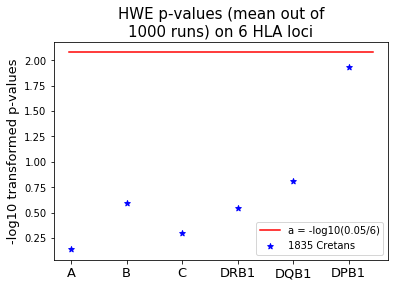

In [184]:
def Arlequin_HWE_pvalues(arlequin_DKMS,log10=None):
    
    if log10:
        
        # We are adding 0.0001 on 0.0 p-values, because log tranformation is not posssible        
        arlequin_DKMS = [-np.log10(x) for x in [0.0001 if x==0 else x for x in arlequin_DKMS]]

    fig, ax = plt.subplots()
    
    plt.scatter(list(range(1,31,5)), arlequin_DKMS, marker='*', color = 'blue',label=f'{n_cretans} Cretans',s=35)
    
    if log10:
        plt.plot([0.8, 28.2],[-np.log10(0.05/6), -np.log10(0.05/6)], color ='red', label='a = -log10(0.05/6)')
        ax.legend()
#         ax.legend(loc='upper left')
        plt.ylabel('-log10 transformed p-values', fontsize = 13)
    else:
        plt.plot([0.8, 28.2],[0.05/6, 0.05/6], color ='red', label='a = 0.05/6')
    ### Corrected threshold: a / (number of genetic loci) where a == 0.05 and (number of genetic loci) == 6
        ax.legend(loc='upper right')
        plt.ylabel('p-values', fontsize = 15)
    
    plt.xticks(list(range(1,31,5)), ['A', 'B', 'C', 'DRB1', 'DQB1', 'DPB1'], fontsize=13) 
    plt.title('HWE p-values (mean out of\n1000 runs) on 6 HLA loci', fontsize=15)       
    
#     fig.tight_layout()
#     fig.set_dpi(300)    
    
#     if log10:
#         plt.savefig("HWE p-values log transformation.png")   
#     else:
#         plt.savefig("HWE p-values.png")   
       
    plt.show()

# Arlequin_HWE_pvalues(Crete_HW)
Arlequin_HWE_pvalues(Crete_HW, log10=True)

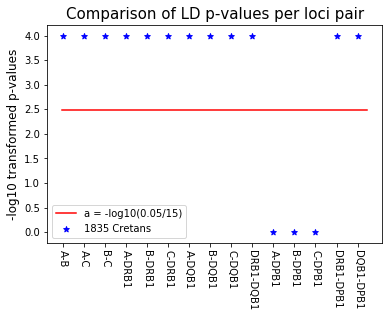

In [243]:
def Arlequin_LD_pvalues(arlequin_DKMS,log10=None):
    
    if log10:
        
        # We are adding 0.0001 on 0.0 p-values, because log tranformation is not posssible
        arlequin_DKMS = [-np.log10(x) for x in [0.0001 if x==0 else x for x in arlequin_DKMS]]
    
    fig, ax = plt.subplots()
    
    plt.scatter(list(range(1,76,5)), arlequin_DKMS, marker='*', color = 'blue',label='1835 Cretans',s=35)
    
    if log10:
        plt.plot([0.8, 73.2],[-np.log10(0.05/15), -np.log10(0.05/15)], color ='red', label='a = -log10(0.05/15)')
        plt.ylabel('-log10 transformed p-values', fontsize = 12)
        ax.legend(loc='lower left')
    else:
        plt.plot([0.8, 73.2],[0.05/15, 0.05/15], color ='red', label='a = 0.05/15')
    ### Corrected threshold: a / (number of loci pairs) where a == 0.05 and (number of loci pairs) == 15
        plt.ylabel('p-values', fontsize = 15)    
        ax.legend(loc='upper left')
    
    
    plt.xticks(list(range(1,76,5)), ['A-B','A-C','B-C','A-DRB1','B-DRB1','C-DRB1','A-DQB1','B-DQB1','C-DQB1','DRB1-DQB1','A-DPB1','B-DPB1','C-DPB1','DRB1-DPB1','DQB1-DPB1'], fontsize=10, rotation=-90)
    plt.title("Comparison of LD p-values per loci pair", fontsize=15)       
    
#     fig.tight_layout()    
#     fig.set_dpi(300)
    
#     if log10:
#         plt.savefig("LD p-values log transformation.png")
#     else:
#         plt.savefig("LD p-values.png") 
       
    plt.show()

arlequin_DKMS_LD = obtain_pvalue_from_Arlequin_xml(f'{DKMS_LD_path}Crete_75_Arlequin_LD_all.xml', 'LD')    

# Arlequin_LD_pvalues(arlequin_DKMS_LD[0],log10=None)
Arlequin_LD_pvalues(arlequin_DKMS_LD[0],log10=True)

In [185]:
### ALLELE FREQUENCY COMPARISON PER PREFECTURE

def prefecture_prep_af(cr_prefecture, sheetname=None, haplomat=None, counts=None):
    
    '''
    Delete all the whitespaces from the excel with the genotypes beforehand 
    and then feed the excel in this function.
    '''
    
    prefecture = cr_prefecture.split('/')[4].split('_')[0]
    
    if sheetname:
        cr_prefecture =  pd.read_excel(cr_prefecture, sheet_name=sheetname)
    else:
        cr_prefecture =  pd.read_excel(cr_prefecture)
    
    genotypes = cr_prefecture.iloc[:,-12:].dropna()
    number_of_people = len(genotypes)
    
    if haplomat:
        
        genotypes['id'] = list(range(1, len(genotypes)+1))
        cols = genotypes.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        genotypes = genotypes[cols]
        genotypes.columns =  ['id', 'A1', 'A2', 'B1', 'B2', 'C1', 'C2', 'DRB11', 'DRB12', 'DQB11', 'DQB12', 'DPB11', 'DPB12']
        genotypes['A1'] = genotypes['A1'].str.replace('A\*', '')
        genotypes['A2'] = genotypes['A2'].str.replace('A\*', '')
        genotypes['B1'] = genotypes['B1'].str.replace('B\*', '')
        genotypes['B2'] = genotypes['B2'].str.replace('B\*', '')
        genotypes['C1'] = genotypes['C1'].str.replace('C\*', '')
        genotypes['C2'] = genotypes['C2'].str.replace('C\*', '')
        genotypes['DRB11'] = genotypes['DRB11'].str.replace('DRB1\*', '')
        genotypes['DRB12'] = genotypes['DRB12'].str.replace('DRB1\*', '')
        genotypes['DQB11'] = genotypes['DQB11'].str.replace('DQB1\*', '')
        genotypes['DQB12'] = genotypes['DQB12'].str.replace('DQB1\*', '')
        genotypes['DPB11'] = genotypes['DPB11'].str.replace('DPB1\*', '')
        genotypes['DPB12'] = genotypes['DPB12'].str.replace('DPB1\*', '')
        genotypes.columns =  ['id', 'A', 'A', 'B', 'B', 'C', 'C', 'DRB1', 'DRB1', 'DQB1', 'DQB1', 'DPB1', 'DPB1']
        
        if os.path.exists(f'{prefecture}_75.txt'):
            os.remove(f'{prefecture}_75.txt')
        genotypes.to_csv(f'{prefecture}_75.txt', header=True, index=False, sep='\t', mode='a')
        
        return
    
    A = genotypes.iloc[:,0].to_list() + genotypes.iloc[:,1].to_list()
    B = genotypes.iloc[:,2].to_list() + genotypes.iloc[:,3].to_list()
    C = genotypes.iloc[:,4].to_list() + genotypes.iloc[:,5].to_list()
    DRB1 = genotypes.iloc[:,6].to_list() + genotypes.iloc[:,7].to_list()
    DQB1 = genotypes.iloc[:,8].to_list() + genotypes.iloc[:,9].to_list()
    DPB1 = genotypes.iloc[:,10].to_list() + genotypes.iloc[:,11].to_list()
    
    counts_A = {k:v for k,v in sorted(dict(Counter(A)).items(), key=lambda item:item[1], reverse=True)}
    counts_B = {k:v for k,v in sorted(dict(Counter(B)).items(), key=lambda item:item[1], reverse=True)}
    counts_C = {k:v for k,v in sorted(dict(Counter(C)).items(), key=lambda item:item[1], reverse=True)}
    counts_DRB1 = {k:v for k,v in sorted(dict(Counter(DRB1)).items(), key=lambda item:item[1], reverse=True)}
    counts_DQB1 = {k:v for k,v in sorted(dict(Counter(DQB1)).items(), key=lambda item:item[1], reverse=True)}
    counts_DPB1 = {k:v for k,v in sorted(dict(Counter(DPB1)).items(), key=lambda item:item[1], reverse=True)}
    
    if counts:
        return counts_A, counts_B, counts_C, counts_DRB1, counts_DQB1, counts_DPB1
    
    af_A = {k:v/(2*number_of_people) for k,v in counts_A.items()}
    af_B = {k:v/(2*number_of_people) for k,v in counts_B.items()}
    af_C = {k:v/(2*number_of_people) for k,v in counts_C.items()}
    af_DRB1 = {k:v/(2*number_of_people) for k,v in counts_DRB1.items()}
    af_DQB1 = {k:v/(2*number_of_people) for k,v in counts_DQB1.items()}
    af_DPB1 = {k:v/(2*number_of_people) for k,v in counts_DPB1.items()}
    
    return af_A, af_B, af_C, af_DRB1, af_DQB1, af_DPB1

chania_A, chania_B, chania_C, chania_DRB1, chania_DQB1, chania_DPB1 = prefecture_prep_af('/home/manos/Desktop/Manos/MSc-Bioinformatics/Thesis/scripts/Cretan_project/Final_analyses.xlsx', sheetname='Chania_75')
# prefecture_prep_af('/home/manos/Desktop/Manos/MSc-Bioinformatics/Thesis/scripts/Cretan_project/Final_analyses.xlsx', sheetname='Chania_75', haplomat=True)

rethymno_A, rethymno_B, rethymno_C, rethymno_DRB1, rethymno_DQB1, rethymno_DPB1 = prefecture_prep_af('/home/manos/Desktop/Manos/MSc-Bioinformatics/Thesis/scripts/Cretan_project/Final_analyses.xlsx', sheetname='Rethymno_75')
# prefecture_prep_af('/home/manos/Desktop/Manos/MSc-Bioinformatics/Thesis/scripts/Cretan_project/Final_analyses.xlsx', sheetname='Rethymno_75', haplomat=True)

heraklion_A, heraklion_B, heraklion_C, heraklion_DRB1, heraklion_DQB1, heraklion_DPB1 = prefecture_prep_af('/home/manos/Desktop/Manos/MSc-Bioinformatics/Thesis/scripts/Cretan_project/Final_analyses.xlsx', sheetname='Heraklion_75')
# prefecture_prep_af('/home/manos/Desktop/Manos/MSc-Bioinformatics/Thesis/scripts/Cretan_project/Final_analyses.xlsx', sheetname='Heraklion_75', haplomat=True)

lasithi_A, lasithi_B, lasithi_C, lasithi_DRB1, lasithi_DQB1, lasithi_DPB1 = prefecture_prep_af('/home/manos/Desktop/Manos/MSc-Bioinformatics/Thesis/scripts/Cretan_project/Final_analyses.xlsx', sheetname='Lasithi_75')
# prefecture_prep_af('/home/manos/Desktop/Manos/MSc-Bioinformatics/Thesis/scripts/Cretan_project/Final_analyses.xlsx', sheetname='Lasithi_75', haplomat=True)

In [187]:
def statistic_comparison_of_alleles_per_prefecture(chania, rethymno, heraklion, lasithi, n_chania, n_rethymno, n_heraklion, n_lasithi, fisher=None):

    if not list(chania.keys())[0].split('*')[0] == list(rethymno.keys())[0].split('*')[0] == list(heraklion.keys())[0].split('*')[0] == list(lasithi.keys())[0].split('*')[0]:
        raise Exception('Not the same gene in the input in one of the 4 Prefectures.')
      
    ch_alleles = list(chania.keys())
    ret_alleles = list(rethymno.keys())
    her_alleles = list(heraklion.keys())
    las_alleles = list(lasithi.keys())
    
    cr_alleles = ch_alleles+ret_alleles+her_alleles+las_alleles 
    
    stat_dict = {x:0 for x in cr_alleles}
    
    for x in list(stat_dict.keys()): 
        
        tmp = {'Chania-Rethymno':0,'Chania-Heraklion':0,'Chania-Lasithi':0,'Rethymno-Heraklion':0,'Rethymno-Lasithi':0,'Heraklion-Lasithi':0}
        
        if x in ch_alleles:
            
            if x in ret_alleles:
                
                stat_input = [[2*n_chania-round(2*n_chania*chania[x]), round(2*n_chania*chania[x])],[2*n_rethymno-round(2*n_rethymno*rethymno[x]), round(2*n_rethymno*rethymno[x])]]
                
                if fisher:
                    oddsratio, pvalue = stats.fisher_exact(stat_input)
                else:
                    chi2, pvalue, df, exp = chi2_contingency(np.array(stat_input))
                    
                tmp['Chania-Rethymno'] = pvalue
                
            else:
                tmp['Chania-Rethymno'] = f'Rethymo does not have the allele {x}'
    
            if x in her_alleles:
                
                stat_input = [[2*n_chania-round(2*n_chania*chania[x]), round(2*n_chania*chania[x])],[2*n_heraklion-round(2*n_heraklion*heraklion[x]), round(2*n_heraklion*heraklion[x])]]
                
                if fisher:
                    oddsratio, pvalue = stats.fisher_exact(stat_input)
                else:
                    chi2, pvalue, df, exp = chi2_contingency(np.array(stat_input))
                    
                tmp['Chania-Heraklion'] = pvalue
                
            else:
                tmp['Chania-Heraklion'] = f'Heraklion does not have the allele {x}'
            
            if x in las_alleles:
                
                stat_input = [[2*n_chania-round(2*n_chania*chania[x]), round(2*n_chania*chania[x])],[2*n_lasithi-round(2*n_lasithi*lasithi[x]), round(2*n_lasithi*lasithi[x])]]
                
                if fisher:
                    oddsratio, pvalue = stats.fisher_exact(stat_input)
                else:
                    chi2, pvalue, df, exp = chi2_contingency(np.array(stat_input))
                    
                tmp['Chania-Lasithi'] = pvalue
                
            else:
                tmp['Chania-Lasithi'] = f'Lasithi does not have the allele {x}'
        
        else:
            
            tmp['Chania-Rethymno'] = f'Chania does not have the allele {x}'
            tmp['Chania-Heraklion'] = f'Chania does not have the allele {x}'
            tmp['Chania-Lasithi'] = f'Chania does not have the allele {x}'
            
        if x in ret_alleles:
            
            if x in her_alleles:
                
                stat_input = [[2*n_rethymno-round(2*n_rethymno*rethymno[x]), round(2*n_rethymno*rethymno[x])],[2*n_heraklion-round(2*n_heraklion*heraklion[x]), round(2*n_heraklion*heraklion[x])]]
                
                if fisher:
                    oddsratio, pvalue = stats.fisher_exact(stat_input)
                else:
                    chi2, pvalue, df, exp = chi2_contingency(np.array(stat_input))
                    
                tmp['Rethymno-Heraklion'] = pvalue
                
            else:
                tmp['Rethymno-Heraklion'] = f'Heraklion does not have the allele {x}'
                
            if x in las_alleles:
                
                stat_input = [[2*n_rethymno-round(2*n_rethymno*rethymno[x]), round(2*n_rethymno*rethymno[x])],[2*n_lasithi-round(2*n_lasithi*lasithi[x]), round(2*n_lasithi*lasithi[x])]]
                
                if fisher:
                    oddsratio, pvalue = stats.fisher_exact(stat_input)
                else:
                    chi2, pvalue, df, exp = chi2_contingency(np.array(stat_input))
                    
                tmp['Rethymno-Lasithi'] = pvalue
                
            else:
                tmp['Rethymno-Lasithi'] = f'Lasithi does not have the allele {x}'
        
        else:
            tmp['Rethymno-Heraklion'] = f'Rethymno does not have the allele {x}'
            tmp['Rethymno-Lasithi'] = f'Rethymno does not have the allele {x}'
            
        if x in her_alleles:
            
            if x in las_alleles:
                
                stat_input = [[2*n_heraklion-round(2*n_heraklion*heraklion[x]), round(2*n_heraklion*heraklion[x])],[2*n_lasithi-round(2*n_lasithi*lasithi[x]), round(2*n_lasithi*lasithi[x])]]
                
                if fisher:
                    oddsratio, pvalue = stats.fisher_exact(stat_input)
                else:
                    chi2, pvalue, df, exp = chi2_contingency(np.array(stat_input))
                    
                tmp['Heraklion-Lasithi'] = pvalue
                
            else:
                tmp['Heraklion-Lasithi'] = f'Lasithi does not have the allele {x}'
                
        else:
            tmp['Heraklion-Lasithi'] = f'Heraklion does not have the allele {x}'
            
        stat_dict[x] = tmp
         
    return stat_dict

prefectures_chi2_A = statistic_comparison_of_alleles_per_prefecture(chania_A, rethymno_A, heraklion_A, lasithi_A, 455, 280, 678, 331)
prefectures_chi2_B = statistic_comparison_of_alleles_per_prefecture(chania_B, rethymno_B, heraklion_B, lasithi_B, 455, 280, 678, 331)
prefectures_chi2_C = statistic_comparison_of_alleles_per_prefecture(chania_C, rethymno_C, heraklion_C, lasithi_C, 455, 280, 678, 331)
prefectures_chi2_DRB1 = statistic_comparison_of_alleles_per_prefecture(chania_DRB1, rethymno_DRB1, heraklion_DRB1, lasithi_DRB1, 455, 280, 678, 331)
prefectures_chi2_DQB1 = statistic_comparison_of_alleles_per_prefecture(chania_DQB1, rethymno_DQB1, heraklion_DQB1, lasithi_DQB1, 455, 280, 678, 331)
prefectures_chi2_DPB1 = statistic_comparison_of_alleles_per_prefecture(chania_DPB1, rethymno_DPB1, heraklion_DPB1, lasithi_DPB1, 455, 280, 678, 331)

prefectures_fisher_A = statistic_comparison_of_alleles_per_prefecture(chania_A, rethymno_A, heraklion_A, lasithi_A, 455, 280, 678, 331, fisher=True)
prefectures_fisher_B = statistic_comparison_of_alleles_per_prefecture(chania_B, rethymno_B, heraklion_B, lasithi_B, 455, 280, 678, 331, fisher=True)
prefectures_fisher_C = statistic_comparison_of_alleles_per_prefecture(chania_C, rethymno_C, heraklion_C, lasithi_C, 455, 280, 678, 331, fisher=True)
prefectures_fisher_DRB1 = statistic_comparison_of_alleles_per_prefecture(chania_DRB1, rethymno_DRB1, heraklion_DRB1, lasithi_DRB1, 455, 280, 678, 331, fisher=True)
prefectures_fisher_DQB1 = statistic_comparison_of_alleles_per_prefecture(chania_DQB1, rethymno_DQB1, heraklion_DQB1, lasithi_DQB1, 455, 280, 678, 331, fisher=True)
prefectures_fisher_DPB1 = statistic_comparison_of_alleles_per_prefecture(chania_DPB1, rethymno_DPB1, heraklion_DPB1, lasithi_DPB1, 455, 280, 678, 331, fisher=True)

In [188]:
prefectures_chi2_A

{'A*02:01': {'Chania-Rethymno': 0.006571741975604059,
  'Chania-Heraklion': 0.6674423756802681,
  'Chania-Lasithi': 0.4548427218300237,
  'Rethymno-Heraklion': 0.012693039828593157,
  'Rethymno-Lasithi': 0.0011011020781842493,
  'Heraklion-Lasithi': 0.20837339482093703},
 'A*24:02': {'Chania-Rethymno': 0.4759791648343258,
  'Chania-Heraklion': 0.05464930425149554,
  'Chania-Lasithi': 0.24009033045835435,
  'Rethymno-Heraklion': 0.01242518378933705,
  'Rethymno-Lasithi': 0.07678061508240315,
  'Heraklion-Lasithi': 0.7153485905662003},
 'A*01:01': {'Chania-Rethymno': 0.4038665865820451,
  'Chania-Heraklion': 0.019770133722780532,
  'Chania-Lasithi': 0.8201412312877763,
  'Rethymno-Heraklion': 0.3162973951439102,
  'Rethymno-Lasithi': 0.6284520709146082,
  'Heraklion-Lasithi': 0.08014055269098683},
 'A*11:01': {'Chania-Rethymno': 0.48315099414112817,
  'Chania-Heraklion': 0.8006505770493701,
  'Chania-Lasithi': 0.9404598026825765,
  'Rethymno-Heraklion': 0.6322943340431354,
  'Rethymno-La

In [189]:
prefectures_fisher_A

{'A*02:01': {'Chania-Rethymno': 0.005206566984890638,
  'Chania-Heraklion': 0.6284028818985083,
  'Chania-Lasithi': 0.45121550824172885,
  'Rethymno-Heraklion': 0.010664214352594261,
  'Rethymno-Lasithi': 0.000865399190832456,
  'Heraklion-Lasithi': 0.19428602821957008},
 'A*24:02': {'Chania-Rethymno': 0.4401422159949948,
  'Chania-Heraklion': 0.049690342786964437,
  'Chania-Lasithi': 0.23808262359928026,
  'Rethymno-Heraklion': 0.012249802853558575,
  'Rethymno-Lasithi': 0.07588564039800144,
  'Heraklion-Lasithi': 0.6848222493569804},
 'A*01:01': {'Chania-Rethymno': 0.3599043763999782,
  'Chania-Heraklion': 0.01882195874605508,
  'Chania-Lasithi': 0.7900473263655379,
  'Rethymno-Heraklion': 0.30783657215833793,
  'Rethymno-Lasithi': 0.5644160452316828,
  'Heraklion-Lasithi': 0.07133604951125233},
 'A*11:01': {'Chania-Rethymno': 0.4304325242435713,
  'Chania-Heraklion': 0.8107491952369617,
  'Chania-Lasithi': 1.0,
  'Rethymno-Heraklion': 0.583045072542103,
  'Rethymno-Lasithi': 0.46273

In [194]:
# arlequin_inputs('Chania_75.txt', hla_gene=None, all_genes=True, include_missing_data=False, num_of_genes=None, HW=None, LD=True, HF=None, path='/home/manos/Programs/Arlequin/cretan_HLA/prefectures/1744/')
# arlequin_inputs('Rethymno_75.txt', hla_gene=None, all_genes=True, include_missing_data=False, num_of_genes=None, HW=None, LD=True, HF=None, path='/home/manos/Programs/Arlequin/cretan_HLA/prefectures/1744/')
# arlequin_inputs('Heraklion_75.txt', hla_gene=None, all_genes=True, include_missing_data=False, num_of_genes=None, HW=None, LD=True, HF=None, path='/home/manos/Programs/Arlequin/cretan_HLA/prefectures/1744/')
# arlequin_inputs('Lasithi_75.txt', hla_gene=None, all_genes=True, include_missing_data=False, num_of_genes=None, HW=None, LD=True, HF=None, path='/home/manos/Programs/Arlequin/cretan_HLA/prefectures/1744/')

### I renamed the arps into Chania.arp, Heraklion.arp, Lasithi.arp and Rethymno.arp and changed manually the titles.

# merge_arps(['/home/manos/Programs/Arlequin/cretan_HLA/prefectures/1744/LD/Chania.arp', '/home/manos/Programs/Arlequin/cretan_HLA/prefectures/1744/LD/Rethymno.arp', '/home/manos/Programs/Arlequin/cretan_HLA/prefectures/1744/LD/Heraklion.arp', '/home/manos/Programs/Arlequin/cretan_HLA/prefectures/1744/LD/Lasithi.arp'], path = '/home/manos/Programs/Arlequin/cretan_HLA/prefectures/1744/LD/')
# merge_arps(['/home/manos/Programs/Arlequin/cretan_HLA/prefectures/1744/HW/Chania.arp', '/home/manos/Programs/Arlequin/cretan_HLA/prefectures/1744/HW/Rethymno.arp', '/home/manos/Programs/Arlequin/cretan_HLA/prefectures/1744/HW/Heraklion.arp', '/home/manos/Programs/Arlequin/cretan_HLA/prefectures/1744/HW/Lasithi.arp'], path = '/home/manos/Programs/Arlequin/cretan_HLA/prefectures/1744/HW/')

In [196]:
def prefecture_af_comparison(chania, rethymno, heraklion, lasithi, unique=None, haplotypes=None):
    
    if not haplotypes:
        if not list(chania.keys())[0].split('*')[0] == list(rethymno.keys())[0].split('*')[0] == list(heraklion.keys())[0].split('*')[0] == list(lasithi.keys())[0].split('*')[0]:
            raise Exception('Not the same HLA gene on the inputs')
    
    chania_alleles = list(chania.keys())
    rethymno_alleles = list(rethymno.keys())
    heraklion_alleles = list(heraklion.keys())
    lasithi_alleles = list(lasithi.keys())
    
    if not unique:
        
#         print(len(chania.keys()))
#         print(len(rethymno.keys()))
#         print(len(heraklion.keys()))
#         print(len(lasithi.keys()))
        
        common_alleles = sorted(list(set(chania_alleles) & set(rethymno_alleles) & set(heraklion_alleles) & set(lasithi_alleles)))
        comparison_common = [[x, chania[x], rethymno[x], heraklion[x], lasithi[x]] for x in common_alleles]
#         print(len(common_alleles))
        
        return comparison_common
    
    else:
        
        chania_unique = [x for x in chania_alleles if x not in rethymno_alleles+heraklion_alleles+lasithi_alleles]
        rethymno_unique = [x for x in rethymno_alleles if x not in chania_alleles+heraklion_alleles+lasithi_alleles]
        heraklion_unique = [x for x in heraklion_alleles if x not in chania_alleles+rethymno_alleles+lasithi_alleles]
        lasithi_unique = [x for x in lasithi_alleles if x not in chania_alleles+rethymno_alleles+heraklion_alleles]
        
        chania_unique_afs = {x:chania[x] for x in chania_unique}
        rethymno_unique_afs = {x:rethymno[x] for x in rethymno_unique}
        heraklion_unique_afs = {x:heraklion[x] for x in heraklion_unique}
        lasithi_unique_afs = {x:lasithi[x] for x in lasithi_unique}
        
        return chania_unique_afs, rethymno_unique_afs, heraklion_unique_afs, lasithi_unique_afs
             
comp_pref_A = prefecture_af_comparison(chania_A, rethymno_A, heraklion_A, lasithi_A)
comp_pref_B = prefecture_af_comparison(chania_B, rethymno_B, heraklion_B, lasithi_B)
comp_pref_C = prefecture_af_comparison(chania_C, rethymno_C, heraklion_C, lasithi_C)
comp_pref_DRB1 = prefecture_af_comparison(chania_DRB1, rethymno_DRB1, heraklion_DRB1, lasithi_DRB1)
comp_pref_DQB1 = prefecture_af_comparison(chania_DQB1, rethymno_DQB1, heraklion_DQB1, lasithi_DQB1)
comp_pref_DPB1 = prefecture_af_comparison(chania_DPB1, rethymno_DPB1, heraklion_DPB1, lasithi_DPB1)

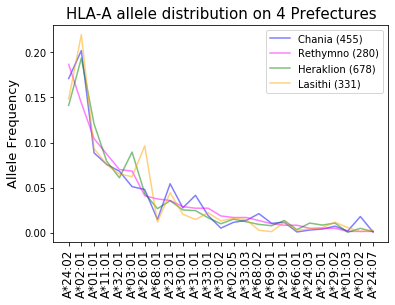

In [211]:
def prefecture_af_comparison_plot(comparison_list, haplotypes=None):
    
    comparison_list = sorted(comparison_list, key=lambda x:x[2], reverse=True)
    
    alleles = [x[0] for x in comparison_list] 
    
    if not haplotypes:
        hla_gene = alleles[0].split('*')[0]
    else:
        n = len(comparison_list[0][0].split('-'))
        
    ch = [x[1] for x in comparison_list]
    ret = [x[2] for x in comparison_list]
    her = [x[3] for x in comparison_list]
    las = [x[4] for x in comparison_list]
    
    fig, ax = plt.subplots()    
    
    plt.plot(list(range(1,len(alleles)+1)), ch, '-', color = 'blue', label=f'Chania ({len(Chania_75)})',alpha=0.5)
    plt.plot(list(range(1,len(alleles)+1)), ret, '-', color = 'magenta', label=f'Rethymno ({len(Rethymno_75)})',alpha=0.5)  
    plt.plot(list(range(1,len(alleles)+1)), her, '-', color = 'green', label=f'Heraklion ({len(Heraklion_75)})',alpha=0.5) 
    plt.plot(list(range(1,len(alleles)+1)), las, '-', color = 'orange', label=f'Lasithi ({len(Lasithi_75)})',alpha=0.5)    
    
    if not haplotypes:    
        if hla_gene == 'B':
            font = 9
        else:
            font = 12
            
    else:        
        font = 10
    
    ax.legend() 
    
    if not haplotypes:
        plt.xticks(list(range(1,len(alleles)+1)), alleles, fontsize=font, rotation=90)
        plt.title(f'HLA-{hla_gene} allele distribution on 4 Prefectures', fontsize=15)
        plt.ylabel('Allele Frequency', fontsize=13)
        
#         fig.set_dpi(300)
#         fig.tight_layout()
#         plt.savefig(f'Prefectures_Analysis/new_1744_total/common/Prefecture common AF comparison on HLA-{hla_gene}.png')
        
    else:
        ax.set_ylim(bottom=0)
        plt.xticks(list(range(1,len(alleles)+1)), [f'{x}' for x in range(1, len(alleles)+1)], fontsize=font)
        plt.title(f'Common Haplotypes with {n} genes on 4 Prefectures', fontsize=13)
        plt.ylabel('Haplotype Frequency', fontsize=12)
        
#         fig.set_dpi(300)
#         fig.tight_layout()
#         plt.savefig(f'/Prefectures_Analysis/new_1744_total/common/Prefecture common HF comparison {n}.png')
    
    plt.show()
    
prefecture_af_comparison_plot(comp_pref_A)
# prefecture_af_comparison_plot(comp_pref_B)
# prefecture_af_comparison_plot(comp_pref_C)
# prefecture_af_comparison_plot(comp_pref_DRB1)
# prefecture_af_comparison_plot(comp_pref_DQB1)
# prefecture_af_comparison_plot(comp_pref_DPB1)

In [212]:
def pref_af_comp_all_alleles(chania_txt, rethymno_txt, heraklion_txt, lasithi_txt, ch_af_dict, ret_af_dict, her_af_dict, las_af_dict):
    
    '''
    The .txt files should be in input format for Hapl-o-Mat for each Cretan Prefecture
    with 6 genes for the calculation of the haplotype frequencies.
    '''
    
    if not list(ch_af_dict.keys())[0].split('*')[0] == list(ret_af_dict.keys())[0].split('*')[0] == list(her_af_dict.keys())[0].split('*')[0] == list(las_af_dict.keys())[0].split('*')[0]:
        raise Exception('Not the same HLA gene on the inputs')
    
    hla_gene = list(ch_af_dict.keys())[0].split('*')[0]
    
    with open(chania_txt, 'r') as ch:
        ch = ch.readlines()
        
    ch = [x.strip('\n').split('\t')[1:] for x in ch[1:]]
    ch = [['A*'+x[0],'A*'+x[1],'B*'+x[2],'B*'+x[3],'C*'+x[4],'C*'+x[5],'DRB1*'+x[6],'DRB1*'+x[7],'DQB1*'+x[8],'DQB1*'+x[9],'DPB1*'+x[10],'DPB1*'+x[11]] for x in ch]
    
    with open(rethymno_txt, 'r') as ret:
        ret = ret.readlines()
        
    ret = [x.strip('\n').split('\t')[1:] for x in ret[1:]]
    ret = [['A*'+x[0],'A*'+x[1],'B*'+x[2],'B*'+x[3],'C*'+x[4],'C*'+x[5],'DRB1*'+x[6],'DRB1*'+x[7],'DQB1*'+x[8],'DQB1*'+x[9],'DPB1*'+x[10],'DPB1*'+x[11]] for x in ret]
    
    with open(heraklion_txt, 'r') as her:
        her = her.readlines()
        
    her = [x.strip('\n').split('\t')[1:] for x in her[1:]]
    her = [['A*'+x[0],'A*'+x[1],'B*'+x[2],'B*'+x[3],'C*'+x[4],'C*'+x[5],'DRB1*'+x[6],'DRB1*'+x[7],'DQB1*'+x[8],'DQB1*'+x[9],'DPB1*'+x[10],'DPB1*'+x[11]] for x in her]
    
    with open(lasithi_txt, 'r') as las:
        las = las.readlines()
        
    las = [x.strip('\n').split('\t')[1:] for x in las[1:]]
    las = [['A*'+x[0],'A*'+x[1],'B*'+x[2],'B*'+x[3],'C*'+x[4],'C*'+x[5],'DRB1*'+x[6],'DRB1*'+x[7],'DQB1*'+x[8],'DQB1*'+x[9],'DPB1*'+x[10],'DPB1*'+x[11]] for x in las]
    
    pref = ch + ret + her + las
    pref = [y for x in pref for y in x]
    
#     pref_af = {k:v/(2*len(pref)/12) for k,v in sorted(dict(Counter(pref)).items(), key=lambda item: item[0], reverse=False) if k.split('*')[0]==hla_gene }
    pref_af = {k:v/(2*len(pref)/12) for k,v in sorted(dict(Counter(pref)).items(), key=lambda item: item[1], reverse=True) if k.split('*')[0]==hla_gene }
    
    comparison_all_alleles_on_4_Pref = [[x,0,0,0,0,0] for x in pref_af]
    
    for x in comparison_all_alleles_on_4_Pref:
        x[1] += pref_af[x[0]]        
        if x[0] in ch_af_dict.keys():
            x[2] += ch_af_dict[x[0]]
        if x[0] in ret_af_dict.keys():
            x[3] += ret_af_dict[x[0]]
        if x[0] in her_af_dict.keys():
            x[4] += her_af_dict[x[0]]
        if x[0] in las_af_dict.keys():
            x[5] += las_af_dict[x[0]]
    
    return comparison_all_alleles_on_4_Pref

comp_all_A = pref_af_comp_all_alleles('Chania_75.txt', 'Rethymno_75.txt', 'Heraklion_75.txt', 'Lasithi_75.txt', chania_A, rethymno_A, heraklion_A, lasithi_A)
comp_all_B = pref_af_comp_all_alleles('Chania_75.txt', 'Rethymno_75.txt', 'Heraklion_75.txt', 'Lasithi_75.txt', chania_B, rethymno_B, heraklion_B, lasithi_B)
comp_all_C = pref_af_comp_all_alleles('Chania_75.txt', 'Rethymno_75.txt', 'Heraklion_75.txt', 'Lasithi_75.txt', chania_C, rethymno_C, heraklion_C, lasithi_C)
comp_all_DRB1 = pref_af_comp_all_alleles('Chania_75.txt', 'Rethymno_75.txt', 'Heraklion_75.txt', 'Lasithi_75.txt', chania_DRB1, rethymno_DRB1, heraklion_DRB1, lasithi_DRB1)
comp_all_DQB1 = pref_af_comp_all_alleles('Chania_75.txt', 'Rethymno_75.txt', 'Heraklion_75.txt', 'Lasithi_75.txt', chania_DQB1, rethymno_DQB1, heraklion_DQB1, lasithi_DQB1)
comp_all_DPB1 = pref_af_comp_all_alleles('Chania_75.txt', 'Rethymno_75.txt', 'Heraklion_75.txt', 'Lasithi_75.txt', chania_DPB1, rethymno_DPB1, heraklion_DPB1, lasithi_DPB1)

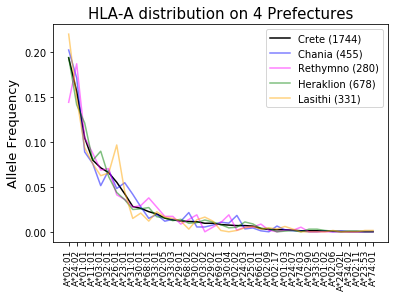

In [215]:
def pref_af_comp_all_alleles_plot(comparison_list):
    
    alleles = [x[0] for x in comparison_list]         
    all_pref = [x[1] for x in comparison_list]    
    ch = [x[2] for x in comparison_list]
    ret = [x[3] for x in comparison_list]
    her = [x[4] for x in comparison_list]
    las = [x[5] for x in comparison_list]
    hla_gene = alleles[0].split('*')[0]
    
#     print(f'Total HLA-{hla_gene} alleles: {len(alleles)}')
#     return
    
    fig, ax = plt.subplots()    
    
    if hla_gene == 'B':
        font = 5
#         label1 = 'Crete'; label2 = 'Chania'; label3 = 'Rethymno' ; label4 = 'Heraklion' ; label5 = 'Lasithi'
    else:
        font = 9   
    
    label1='Crete (1744)';label2='Chania (455)';label3='Rethymno (280)';label4='Heraklion (678)';label5='Lasithi (331)'
        
#     plt.plot(list(range(1,len(alleles)+1)), all_pref, '-', color = 'black', label=label1,alpha=0.5)
    plt.plot(list(range(1,len(alleles)+1)), all_pref, '-', color = 'black', label=label1)
    plt.plot(list(range(1,len(alleles)+1)), ch, '-', color = 'blue', label=label2,alpha=0.5)
    plt.plot(list(range(1,len(alleles)+1)), ret, '-', color = 'magenta', label=label3,alpha=0.5)  
    plt.plot(list(range(1,len(alleles)+1)), her, '-', color = 'green', label=label4,alpha=0.5) 
    plt.plot(list(range(1,len(alleles)+1)), las, '-', color = 'orange', label=label5,alpha=0.5)
    
    ax.legend()     
    
    plt.xticks(list(range(1,len(alleles)+1)), alleles, fontsize=font, rotation=90)
    plt.title(f'HLA-{hla_gene} distribution on 4 Prefectures', fontsize=15)
    plt.ylabel('Allele Frequency', fontsize=13)
    
#     fig.set_dpi(300)
#     fig.tight_layout()
#     plt.savefig(f'Prefectures_Analysis/new_1744_total/all/Prefecture AF comparison on HLA-{hla_gene}.png')
    
    plt.show()

pref_af_comp_all_alleles_plot(comp_all_A)
# pref_af_comp_all_alleles_plot(comp_all_B)
# pref_af_comp_all_alleles_plot(comp_all_C)
# pref_af_comp_all_alleles_plot(comp_all_DRB1)
# pref_af_comp_all_alleles_plot(comp_all_DQB1)
# pref_af_comp_all_alleles_plot(comp_all_DPB1)

In [249]:
def top_alleles_AND_haplotypes_prefecture(chania, rethymno, heraklion, lasithi, top, haplotypes=None):
    
    if not haplotypes:
        if not list(chania.keys())[0].split('*')[0] == list(rethymno.keys())[0].split('*')[0] == list(heraklion.keys())[0].split('*')[0] == list(lasithi.keys())[0].split('*')[0]:
            raise Exception('Not the same HLA gene on the inputs')
    
    chania_alleles = list(chania.keys())[:top]
    chania_afs = list(chania.values())[:top]
    
    rethymno_alleles = list(rethymno.keys())[:top]
    rethymno_afs = list(rethymno.values())[:top]
    
    heraklion_alleles = list(heraklion.keys())[:top]
    heraklion_afs = list(heraklion.values())[:top]
    
    lasithi_alleles = list(lasithi.keys())[:top]
    lasithi_afs = list(lasithi.values())[:top]
    
    if haplotypes:
        tmp1 = 'Haplotype'
        tmp2 = 'HF'
        pd.set_option('display.max_colwidth', -1)
        
    else:
        tmp1 = 'Allele' 
        tmp2 = 'AF'
    
    tuples = [('Chania (455)', tmp1),
              ('Chania (455)', tmp2),
              ('Rethymno (280)', tmp1),
              ('Rethymno (280)', tmp2),
              ('Heraklion (678)', tmp1),
              ('Heraklion (678)', tmp2),
              ('Lasithi (331)', tmp1),
              ('Lasithi (331)', tmp2)]
    
    index = pd.MultiIndex.from_tuples(tuples)   
    
    af_table = pd.DataFrame(zip(chania_alleles,chania_afs,rethymno_alleles,rethymno_afs,heraklion_alleles,heraklion_afs,lasithi_alleles,lasithi_afs), columns = index)

    return af_table

top_alleles_AND_haplotypes_prefecture(chania_A, rethymno_A, heraklion_A, lasithi_A, 10)
# top_alleles_AND_haplotypes_prefecture(chania_B, rethymno_B, heraklion_B, lasithi_B, 10)
# top_alleles_AND_haplotypes_prefecture(chania_C, rethymno_C, heraklion_C, lasithi_C, 10)
# top_alleles_AND_haplotypes_prefecture(chania_DRB1, rethymno_DRB1, heraklion_DRB1, lasithi_DRB1, 10)
# top_alleles_AND_haplotypes_prefecture(chania_DQB1, rethymno_DQB1, heraklion_DQB1, lasithi_DQB1, 10)
# top_alleles_AND_haplotypes_prefecture(chania_DPB1, rethymno_DPB1, heraklion_DPB1, lasithi_DPB1, 10)

Chania (455)           Rethymno (280)           Heraklion (678)            \
        Allele        AF         Allele        AF          Allele        AF   
0  A*02:01      0.201923  A*24:02        0.186644  A*02:01         0.193595   
1  A*24:02      0.170940  A*02:01        0.143836  A*24:02         0.141194   
2  A*01:01      0.088675  A*01:01        0.104452  A*01:01         0.120815   
3  A*11:01      0.075855  A*11:01        0.087329  A*03:01         0.089520   
4  A*32:01      0.068376  A*32:01        0.070205  A*11:01         0.079330   
5  A*23:01      0.054487  A*03:01        0.068493  A*32:01         0.061135   
6  A*03:01      0.051282  A*26:01        0.041096  A*26:01         0.043668   
7  A*26:01      0.048077  A*68:01        0.037671  A*23:01         0.035662   
8  A*31:01      0.041667  A*23:01        0.035959  A*68:01         0.026929   
9  A*30:01      0.027778  A*30:01        0.029110  A*30:01         0.025473   

  Lasithi (331)            
         Allele        AF  
0  A*02:01       0.219585  
1  A*24:02       0.148368  
2  A*26:01       0.096439  
3  A*01:01       0.093472  
4  A*11:01       0.075668  
5  A*32:01       0.065282  
6  A*03:01       0.062315  
7  A*23:01       0.044510  
8  A*33:01       0.022255  
9  A*30:01       0.020772

In [217]:
### HAPLOTYPE FREQUENCY COMPARISON PER PREFECTURE

ch_hf_path = '/home/manos/Programs/Hapl-o-Mat/test/Chania/'
ret_hf_path = '/home/manos/Programs/Hapl-o-Mat/test/Rethymno/'
her_hf_path = '/home/manos/Programs/Hapl-o-Mat/test/Heraklion/'
las_hf_path = '/home/manos/Programs/Hapl-o-Mat/test/Lasithi/'

ch_hf_4 = haplomat_output_parce(ch_hf_path + '4genes/hfs.dat', 455)
ret_hf_4 = haplomat_output_parce(ret_hf_path + '4genes/hfs.dat', 280)
her_hf_4 = haplomat_output_parce(her_hf_path + '4genes/hfs.dat', 678)
las_hf_4 = haplomat_output_parce(las_hf_path + '4genes/hfs.dat', 331)

ch_hf_4_g = haplomat_output_parce(ch_hf_path + '4genes_g/hfs.dat', 455)
ret_hf_4_g = haplomat_output_parce(ret_hf_path + '4genes_g/hfs.dat', 280)
her_hf_4_g = haplomat_output_parce(her_hf_path + '4genes_g/hfs.dat', 678)
las_hf_4_g = haplomat_output_parce(las_hf_path + '4genes_g/hfs.dat', 331)

ch_hf_5 = haplomat_output_parce(ch_hf_path + '5genes/hfs.dat', 455)
ret_hf_5 = haplomat_output_parce(ret_hf_path + '5genes/hfs.dat', 280)
her_hf_5 = haplomat_output_parce(her_hf_path + '5genes/hfs.dat', 678)
las_hf_5 = haplomat_output_parce(las_hf_path + '5genes/hfs.dat', 331)

ch_hf_5_g = haplomat_output_parce(ch_hf_path + '5genes_g/hfs.dat', 455)
ret_hf_5_g = haplomat_output_parce(ret_hf_path + '5genes_g/hfs.dat', 280)
her_hf_5_g = haplomat_output_parce(her_hf_path + '5genes_g/hfs.dat', 678)
las_hf_5_g = haplomat_output_parce(las_hf_path + '5genes_g/hfs.dat', 331)

ch_hf_6 = haplomat_output_parce(ch_hf_path + '6genes/hfs.dat', 455)
ret_hf_6 = haplomat_output_parce(ret_hf_path + '6genes/hfs.dat', 280)
her_hf_6 = haplomat_output_parce(her_hf_path + '6genes/hfs.dat', 678)
las_hf_6 = haplomat_output_parce(las_hf_path + '6genes/hfs.dat', 331)

In [228]:
### Statistic comparison of the frequencies of the haplotypes of Crete 
### as a whole and by Prefecture with the DKMS populations

### Crete and Prefectures with DKMS

Crete_DKMS_hapl_fisher = compare_haplotypes(g4_path, hf_DKMS_all_final, 1744, pvals=True)
Chania_DKMS_hapl_fisher = compare_haplotypes(ch_hf_path + '4genes_g/hfs.dat', hf_DKMS_all_final, 455, pvals=True)
Rethymno_DKMS_hapl_fisher = compare_haplotypes(ret_hf_path + '4genes_g/hfs.dat', hf_DKMS_all_final, 280, pvals=True)
Heraklion_DKMS_hapl_fisher = compare_haplotypes(her_hf_path + '4genes_g/hfs.dat', hf_DKMS_all_final, 678, pvals=True)
Lasithi_DKMS_hapl_fisher = compare_haplotypes(las_hf_path + '4genes_g/hfs.dat', hf_DKMS_all_final, 331, pvals=True)

### Crete and Prefectures with Austria

Crete_Austria_hapl_fisher = compare_haplotypes(g4_path, austrian_hf, 1744, pvals=True)
Chania_Austria_hapl_fisher = compare_haplotypes(ch_hf_path + '4genes_g/hfs.dat', austrian_hf, 455, pvals=True)
Rethymno_Austria_hapl_fisher = compare_haplotypes(ret_hf_path + '4genes_g/hfs.dat', austrian_hf, 280, pvals=True)
Heraklion_Austria_hapl_fisher = compare_haplotypes(her_hf_path + '4genes_g/hfs.dat', austrian_hf, 678, pvals=True)
Lasithi_Austria_hapl_fisher = compare_haplotypes(las_hf_path + '4genes_g/hfs.dat', austrian_hf, 331, pvals=True)

### Crete and Prefectures with Bosnia and Herzegovina

Crete_Bosnia_hapl_fisher = compare_haplotypes(g4_path, bosnian_hf, 1744, pvals=True)
Chania_Bosnia_hapl_fisher = compare_haplotypes(ch_hf_path + '4genes_g/hfs.dat', bosnian_hf, 455, pvals=True)
Rethymno_Bosnia_hapl_fisher = compare_haplotypes(ret_hf_path + '4genes_g/hfs.dat', bosnian_hf, 280, pvals=True)
Heraklion_Bosnia_hapl_fisher = compare_haplotypes(her_hf_path + '4genes_g/hfs.dat', bosnian_hf, 678, pvals=True)
Lasithi_Bosnia_hapl_fisher = compare_haplotypes(las_hf_path + '4genes_g/hfs.dat', bosnian_hf, 331, pvals=True)

### Crete and Prefectures with China

Crete_China_hapl_fisher = compare_haplotypes(g4_path, china_hf, 1744, pvals=True)
Chania_China_hapl_fisher = compare_haplotypes(ch_hf_path + '4genes_g/hfs.dat', china_hf, 455, pvals=True)
Rethymno_China_hapl_fisher = compare_haplotypes(ret_hf_path + '4genes_g/hfs.dat', china_hf, 280, pvals=True)
Heraklion_China_hapl_fisher = compare_haplotypes(her_hf_path + '4genes_g/hfs.dat', china_hf, 678, pvals=True)
Lasithi_China_hapl_fisher = compare_haplotypes(las_hf_path + '4genes_g/hfs.dat', china_hf, 331, pvals=True)

### Crete and Prefectures with Croatia

Crete_Croatia_hapl_fisher = compare_haplotypes(g4_path, croatia_hf, 1744, pvals=True)
Chania_Croatia_hapl_fisher = compare_haplotypes(ch_hf_path + '4genes_g/hfs.dat', croatia_hf, 455, pvals=True)
Rethymno_Croatia_hapl_fisher = compare_haplotypes(ret_hf_path + '4genes_g/hfs.dat', croatia_hf, 280, pvals=True)
Heraklion_Croatia_hapl_fisher = compare_haplotypes(her_hf_path + '4genes_g/hfs.dat', croatia_hf, 678, pvals=True)
Lasithi_Croatia_hapl_fisher = compare_haplotypes(las_hf_path + '4genes_g/hfs.dat', croatia_hf, 331, pvals=True)

### Crete and Prefectures with France

Crete_France_hapl_fisher = compare_haplotypes(g4_path, french_hf, 1744, pvals=True)
Chania_France_hapl_fisher = compare_haplotypes(ch_hf_path + '4genes_g/hfs.dat', french_hf, 455, pvals=True)
Rethymno_France_hapl_fisher = compare_haplotypes(ret_hf_path + '4genes_g/hfs.dat', french_hf, 280, pvals=True)
Heraklion_France_hapl_fisher = compare_haplotypes(her_hf_path + '4genes_g/hfs.dat', french_hf, 678, pvals=True)
Lasithi_France_hapl_fisher = compare_haplotypes(las_hf_path + '4genes_g/hfs.dat', french_hf, 331, pvals=True)

### Crete and Prefectures with Greece

Crete_Greece_hapl_fisher = compare_haplotypes(g4_path, greek_hf, 1744, pvals=True)
Chania_Greece_hapl_fisher = compare_haplotypes(ch_hf_path + '4genes_g/hfs.dat', greek_hf, 455, pvals=True)
Rethymno_Greece_hapl_fisher = compare_haplotypes(ret_hf_path + '4genes_g/hfs.dat', greek_hf, 280, pvals=True)
Heraklion_Greece_hapl_fisher = compare_haplotypes(her_hf_path + '4genes_g/hfs.dat', greek_hf, 678, pvals=True)
Lasithi_Greece_hapl_fisher = compare_haplotypes(las_hf_path + '4genes_g/hfs.dat', greek_hf, 331, pvals=True)

### Crete and Prefectures with Italy (5 genes)

Crete_Italy_5_hapl_fisher = compare_haplotypes(g5_path, tmp_italian_hf, 1744, pvals=True)
Chania_Italy_5_hapl_fisher = compare_haplotypes(ch_hf_path + '5genes_g/hfs.dat', tmp_italian_hf, 455, pvals=True)
Rethymno_Italy_5_hapl_fisher = compare_haplotypes(ret_hf_path + '5genes_g/hfs.dat', tmp_italian_hf, 280, pvals=True)
Heraklion_Italy_5_hapl_fisher = compare_haplotypes(her_hf_path + '5genes_g/hfs.dat', tmp_italian_hf, 678, pvals=True)
Lasithi_Italy_5_hapl_fisher = compare_haplotypes(las_hf_path + '5genes_g/hfs.dat', tmp_italian_hf, 331, pvals=True)

### Crete and Prefectures with Italy (4 genes)

Crete_Italy_4_hapl_fisher = compare_haplotypes(g4_path, italian_hf, 1744, pvals=True)
Chania_Italy_4_hapl_fisher = compare_haplotypes(ch_hf_path + '4genes_g/hfs.dat', italian_hf, 455, pvals=True)
Rethymno_Italy_4_hapl_fisher = compare_haplotypes(ret_hf_path + '4genes_g/hfs.dat', italian_hf, 280, pvals=True)
Heraklion_Italy_4_hapl_fisher = compare_haplotypes(her_hf_path + '4genes_g/hfs.dat', italian_hf, 678, pvals=True)
Lasithi_Italy_4_hapl_fisher = compare_haplotypes(las_hf_path + '4genes_g/hfs.dat', italian_hf, 331, pvals=True)

### Crete and Prefectures with Netherlands

Crete_Netherlands_hapl_fisher = compare_haplotypes(g4_path, netherland_hf, 1744, pvals=True)
Chania_Netherlands_hapl_fisher = compare_haplotypes(ch_hf_path + '4genes_g/hfs.dat', netherland_hf, 455, pvals=True)
Rethymno_Netherlands_hapl_fisher = compare_haplotypes(ret_hf_path + '4genes_g/hfs.dat', netherland_hf, 280, pvals=True)
Heraklion_Netherlands_hapl_fisher = compare_haplotypes(her_hf_path + '4genes_g/hfs.dat', netherland_hf, 678, pvals=True)
Lasithi_Netherlands_hapl_fisher = compare_haplotypes(las_hf_path + '4genes_g/hfs.dat', netherland_hf, 331, pvals=True)

### Crete and Prefectures with Portugal

Crete_Portugal_hapl_fisher = compare_haplotypes(g4_path, portugal_hf, 1744, pvals=True)
Chania_Portugal_hapl_fisher = compare_haplotypes(ch_hf_path + '4genes_g/hfs.dat', portugal_hf, 455, pvals=True)
Rethymno_Portugal_hapl_fisher = compare_haplotypes(ret_hf_path + '4genes_g/hfs.dat', portugal_hf, 280, pvals=True)
Heraklion_Portugal_hapl_fisher = compare_haplotypes(her_hf_path + '4genes_g/hfs.dat', portugal_hf, 678, pvals=True)
Lasithi_Portugal_hapl_fisher = compare_haplotypes(las_hf_path + '4genes_g/hfs.dat', portugal_hf, 331, pvals=True)

### Crete and Prefectures with Romania

Crete_Romania_hapl_fisher = compare_haplotypes(g4_path, romanian_hf, 1744, pvals=True)
Chania_Romania_hapl_fisher = compare_haplotypes(ch_hf_path + '4genes_g/hfs.dat', romanian_hf, 455, pvals=True)
Rethymno_Romania_hapl_fisher = compare_haplotypes(ret_hf_path + '4genes_g/hfs.dat', romanian_hf, 280, pvals=True)
Heraklion_Romania_hapl_fisher = compare_haplotypes(her_hf_path + '4genes_g/hfs.dat', romanian_hf, 678, pvals=True)
Lasithi_Romania_hapl_fisher = compare_haplotypes(las_hf_path + '4genes_g/hfs.dat', romanian_hf, 331, pvals=True)

### Crete and Prefectures with Spain

Crete_Spain_hapl_fisher = compare_haplotypes(g4_path, spanish_hf, 1744, pvals=True)
Chania_Spain_hapl_fisher = compare_haplotypes(ch_hf_path + '4genes_g/hfs.dat', spanish_hf, 455, pvals=True)
Rethymno_Spain_hapl_fisher = compare_haplotypes(ret_hf_path + '4genes_g/hfs.dat', spanish_hf, 280, pvals=True)
Heraklion_Spain_hapl_fisher = compare_haplotypes(her_hf_path + '4genes_g/hfs.dat', spanish_hf, 678, pvals=True)
Lasithi_Spain_hapl_fisher = compare_haplotypes(las_hf_path + '4genes_g/hfs.dat', spanish_hf, 331, pvals=True)

### Crete and Prefectures with Turkey (5 genes)

Crete_Turkey_5_hapl_fisher = compare_haplotypes(g5_path, tmp_turkish_hf, 1744, pvals=True)
Chania_Turkey_5_hapl_fisher = compare_haplotypes(ch_hf_path + '5genes_g/hfs.dat', tmp_turkish_hf, 455, pvals=True)
Rethymno_Turkey_5_hapl_fisher = compare_haplotypes(ret_hf_path + '5genes_g/hfs.dat', tmp_turkish_hf, 280, pvals=True)
Heraklion_Turkey_5_hapl_fisher = compare_haplotypes(her_hf_path + '5genes_g/hfs.dat', tmp_turkish_hf, 678, pvals=True)
Lasithi_Turkey_5_hapl_fisher = compare_haplotypes(las_hf_path + '5genes_g/hfs.dat', tmp_turkish_hf, 331, pvals=True)

### Crete and Prefectures with Turkey (4 genes)

Crete_Turkey_4_hapl_fisher = compare_haplotypes(g4_path, turkish_hf, 1744, pvals=True)
Chania_Turkey_4_hapl_fisher = compare_haplotypes(ch_hf_path + '4genes_g/hfs.dat', turkish_hf, 455, pvals=True)
Rethymno_Turkey_4_hapl_fisher = compare_haplotypes(ret_hf_path + '4genes_g/hfs.dat', turkish_hf, 280, pvals=True)
Heraklion_Turkey_4_hapl_fisher = compare_haplotypes(her_hf_path + '4genes_g/hfs.dat', turkish_hf, 678, pvals=True)
Lasithi_Turkey_4_hapl_fisher = compare_haplotypes(las_hf_path + '4genes_g/hfs.dat', turkish_hf, 331, pvals=True)

### Crete and Prefectures with United Kingdom

Crete_UK_hapl_fisher = compare_haplotypes(g4_path, united_kingdom_hf, 1744, pvals=True)
Chania_UK_hapl_fisher = compare_haplotypes(ch_hf_path + '4genes_g/hfs.dat', united_kingdom_hf, 455, pvals=True)
Rethymno_UK_hapl_fisher = compare_haplotypes(ret_hf_path + '4genes_g/hfs.dat', united_kingdom_hf, 280, pvals=True)
Heraklion_UK_hapl_fisher = compare_haplotypes(her_hf_path + '4genes_g/hfs.dat', united_kingdom_hf, 678, pvals=True)
Lasithi_UK_hapl_fisher = compare_haplotypes(las_hf_path + '4genes_g/hfs.dat', united_kingdom_hf, 331, pvals=True)

In [218]:
def statistic_comparison_of_haplotypes_per_prefecture(chania, rethymno, heraklion, lasithi, n_chania, n_rethymno, n_heraklion, n_lasithi):

    if not len(list(chania.keys())[0].split('-')) == len(list(rethymno.keys())[0].split('-')) == len(list(heraklion.keys())[0].split('-')) == len(list(lasithi.keys())[0].split('-')):
        raise Exception('Not the same number of genes in the haplotypes of the 4 Prefectures.')
    
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.fisher_exact.html
    
    ch_hapl = list(chania.keys())
    ret_hapl = list(rethymno.keys())
    her_hapl = list(heraklion.keys())
    las_hapl = list(lasithi.keys())
    
    cr_hapl = ch_hapl+ret_hapl+her_hapl+las_hapl 
    
    fisher_dict = {x:0 for x in cr_hapl}
    
    for x in list(fisher_dict.keys()): 
        
        tmp = {'Chania-Rethymno':0,'Chania-Heraklion':0,'Chania-Lasithi':0,'Rethymno-Heraklion':0,'Rethymno-Lasithi':0,'Heraklion-Lasithi':0}
        
        if x in ch_hapl:
            
            if x in ret_hapl:
                
                fisher_input = [[2*n_chania-round(2*n_chania*chania[x]), round(2*n_chania*chania[x])],[2*n_rethymno-round(2*n_rethymno*rethymno[x]), round(2*n_rethymno*rethymno[x])]]
                
                oddsratio, pvalue = stats.fisher_exact(fisher_input)
                tmp['Chania-Rethymno'] = pvalue
                
            else:
                tmp['Chania-Rethymno'] = f'Rethymo does not have the haplotype {x}'
    
            if x in her_hapl:
                
                fisher_input = [[2*n_chania-round(2*n_chania*chania[x]), round(2*n_chania*chania[x])],[2*n_heraklion-round(2*n_heraklion*heraklion[x]), round(2*n_heraklion*heraklion[x])]]
                
                oddsratio, pvalue = stats.fisher_exact(fisher_input)
                tmp['Chania-Heraklion'] = pvalue
                
            else:
                tmp['Chania-Heraklion'] = f'Heraklion does not have the haplotype {x}'
            
            if x in las_hapl:
                
                fisher_input = [[2*n_chania-round(2*n_chania*chania[x]), round(2*n_chania*chania[x])],[2*n_lasithi-round(2*n_lasithi*lasithi[x]), round(2*n_lasithi*lasithi[x])]]
                
                oddsratio, pvalue = stats.fisher_exact(fisher_input)
                tmp['Chania-Lasithi'] = pvalue
                
            else:
                tmp['Chania-Lasithi'] = f'Lasithi does not have the haplotype {x}'
        
        else:
            
            tmp['Chania-Rethymno'] = f'Chania does not have the haplotype {x}'
            tmp['Chania-Heraklion'] = f'Chania does not have the haplotype {x}'
            tmp['Chania-Lasithi'] = f'Chania does not have the haplotype {x}'
            
        if x in ret_hapl:
            
            if x in her_hapl:
                
                fisher_input = [[2*n_rethymno-round(2*n_rethymno*rethymno[x]), round(2*n_rethymno*rethymno[x])],[2*n_heraklion-round(2*n_heraklion*heraklion[x]), round(2*n_heraklion*heraklion[x])]]
                
                oddsratio, pvalue = stats.fisher_exact(fisher_input)
                tmp['Rethymno-Heraklion'] = pvalue
                
            else:
                tmp['Rethymno-Heraklion'] = f'Heraklion does not have the haplotype {x}'
                
            if x in las_hapl:
                
                fisher_input = [[2*n_rethymno-round(2*n_rethymno*rethymno[x]), round(2*n_rethymno*rethymno[x])],[2*n_lasithi-round(2*n_lasithi*lasithi[x]), round(2*n_lasithi*lasithi[x])]]
                
                oddsratio, pvalue = stats.fisher_exact(fisher_input)
                tmp['Rethymno-Lasithi'] = pvalue
                
            else:
                tmp['Rethymno-Lasithi'] = f'Lasithi does not have the haplotype {x}'
        
        else:
            tmp['Rethymno-Heraklion'] = f'Rethymno does not have the haplotype {x}'
            tmp['Rethymno-Lasithi'] = f'Rethymno does not have the haplotype {x}'
            
        if x in her_hapl:
            
            if x in las_hapl:
                
                fisher_input = [[2*n_heraklion-round(2*n_heraklion*heraklion[x]), round(2*n_heraklion*heraklion[x])],[2*n_lasithi-round(2*n_lasithi*lasithi[x]), round(2*n_lasithi*lasithi[x])]]
                
                oddsratio, pvalue = stats.fisher_exact(fisher_input)
                tmp['Heraklion-Lasithi'] = pvalue
                
            else:
                tmp['Heraklion-Lasithi'] = f'Lasithi does not have the haplotype {x}'
                
        else:
            tmp['Heraklion-Lasithi'] = f'Heraklion does not have the haplotype {x}'
            
        fisher_dict[x] = tmp
         
    return fisher_dict

prefectures_haplotypes_fisher_4g = statistic_comparison_of_haplotypes_per_prefecture(ch_hf_4_g, ret_hf_4_g, her_hf_4_g, las_hf_4_g, 455, 280, 678, 331)
prefectures_haplotypes_fisher_4 = statistic_comparison_of_haplotypes_per_prefecture(ch_hf_4, ret_hf_4, her_hf_4, las_hf_4, 455, 280, 678, 331)
prefectures_haplotypes_fisher_5 = statistic_comparison_of_haplotypes_per_prefecture(ch_hf_5, ret_hf_5, her_hf_5, las_hf_5, 455, 280, 678, 331)
prefectures_haplotypes_fisher_5g = statistic_comparison_of_haplotypes_per_prefecture(ch_hf_5_g, ret_hf_5_g, her_hf_5_g, las_hf_5_g, 455, 280, 678, 331)
prefectures_haplotypes_fisher_6 = statistic_comparison_of_haplotypes_per_prefecture(ch_hf_6, ret_hf_6, her_hf_6, las_hf_6, 455, 280, 678, 331)

In [219]:
prefectures_haplotypes_fisher_4g

{'A*24:02-B*18:01-C*07:01-DRB1*11:04': {'Chania-Rethymno': 0.25713474576982204,
  'Chania-Heraklion': 2.536793808291197e-05,
  'Chania-Lasithi': 'Lasithi does not have the haplotype A*24:02-B*18:01-C*07:01-DRB1*11:04',
  'Rethymno-Heraklion': 0.025479738831643436,
  'Rethymno-Lasithi': 'Lasithi does not have the haplotype A*24:02-B*18:01-C*07:01-DRB1*11:04',
  'Heraklion-Lasithi': 'Lasithi does not have the haplotype A*24:02-B*18:01-C*07:01-DRB1*11:04'},
 'A*23:01-B*49:01-C*07:01-DRB1*11:04': {'Chania-Rethymno': 'Rethymo does not have the haplotype A*23:01-B*49:01-C*07:01-DRB1*11:04',
  'Chania-Heraklion': 1.0,
  'Chania-Lasithi': 0.14243026130022202,
  'Rethymno-Heraklion': 'Rethymno does not have the haplotype A*23:01-B*49:01-C*07:01-DRB1*11:04',
  'Rethymno-Lasithi': 'Rethymno does not have the haplotype A*23:01-B*49:01-C*07:01-DRB1*11:04',
  'Heraklion-Lasithi': 0.12412215138640484},
 'A*02:01-B*35:03-C*12:03-DRB1*14:01': {'Chania-Rethymno': 'Rethymo does not have the haplotype A*0

In [220]:
common_hfs_prefecture_6 = prefecture_af_comparison(ch_hf_6, ret_hf_6, her_hf_6, las_hf_6, unique=None, haplotypes=True)
unique_hfs_prefecture_6 = prefecture_af_comparison(ch_hf_6, ret_hf_6, her_hf_6, las_hf_6, unique=True, haplotypes=True)

# print(len(unique_hfs_prefecture_6[0]))
# print(len(unique_hfs_prefecture_6[1]))
# print(len(unique_hfs_prefecture_6[2]))
# print(len(unique_hfs_prefecture_6[3]))

# prefecture_af_comparison_plot(common_hfs_prefecture_6, haplotypes=True)

top_alleles_AND_haplotypes_prefecture(ch_hf_6, ret_hf_6, her_hf_6, las_hf_6, 5, haplotypes=True)

Chania (455)            \
                                                  Haplotype        HF   
0  A*02:02-B*41:01-C*17:01-DPB1*13:01-DQB1*03:01-DRB1*11:04  0.014286   
1  A*33:01-B*14:02-C*08:02-DPB1*04:01-DQB1*05:01-DRB1*01:02  0.013187   
2  A*31:01-B*35:03-C*04:01-DPB1*10:01-DQB1*05:02-DRB1*16:01  0.013187   
3  A*02:01-B*35:03-C*12:03-DPB1*02:01-DQB1*05:03-DRB1*14:54  0.013187   
4  A*24:02-B*18:01-C*07:01-DPB1*04:02-DQB1*03:01-DRB1*11:04  0.011848   

                                              Rethymno (280)            \
                                                   Haplotype        HF   
0  A*24:02-B*35:02-C*04:01-DPB1*04:01-DQB1*03:01-DRB1*11:04   0.025000   
1  A*30:04-B*15:220-C*04:01-DPB1*04:02-DQB1*03:01-DRB1*11:04  0.012500   
2  A*32:01-B*49:01-C*07:01-DPB1*02:01-DQB1*05:01-DRB1*10:01   0.012500   
3  A*33:01-B*14:02-C*08:02-DPB1*04:01-DQB1*05:01-DRB1*01:02   0.008929   
4  A*03:01-B*27:07-C*15:02-DPB1*05:01-DQB1*03:01-DRB1*11:03   0.008929   

                                            Heraklion (678)            \
                                                  Haplotype        HF   
0  A*01:01-B*57:03-C*07:01-DPB1*04:01-DQB1*02:01-DRB1*03:01  0.010980   
1  A*02:01-B*18:01-C*07:01-DPB1*04:02-DQB1*03:01-DRB1*11:04  0.009156   
2  A*02:01-B*35:01-C*04:01-DPB1*04:01-DQB1*05:03-DRB1*14:01  0.006469   
3  A*24:02-B*35:02-C*04:01-DPB1*04:01-DQB1*03:01-DRB1*11:04  0.006259   
4  A*03:01-B*35:01-C*04:01-DPB1*02:01-DQB1*05:01-DRB1*10:01  0.006228   

                                              Lasithi (331)            
                                                  Haplotype        HF  
0  A*02:01-B*13:02-C*06:02-DPB1*04:01-DQB1*02:02-DRB1*07:01  0.022608  
1  A*33:01-B*14:02-C*08:02-DPB1*04:01-DQB1*05:01-DRB1*01:02  0.012085  
2  A*23:01-B*44:03-C*04:01-DPB1*14:01-DQB1*02:02-DRB1*07:01  0.012085  
3  A*24:02-B*35:02-C*04:01-DPB1*04:02-DQB1*03:01-DRB1*11:04  0.009063  
4  A*01:01-B*37:01-C*06:02-DPB1*10:01-DQB1*03:02-DRB1*04:04  0.009063

In [221]:
common_hfs_prefecture_5 = prefecture_af_comparison(ch_hf_5, ret_hf_5, her_hf_5, las_hf_5, unique=None, haplotypes=True)
unique_hfs_prefecture_5 = prefecture_af_comparison(ch_hf_5, ret_hf_5, her_hf_5, las_hf_5, unique=True, haplotypes=True)

# print(len(unique_hfs_prefecture_5[0]))
# print(len(unique_hfs_prefecture_5[1]))
# print(len(unique_hfs_prefecture_5[2]))
# print(len(unique_hfs_prefecture_5[3]))

# prefecture_af_comparison_plot(common_hfs_prefecture_5, haplotypes=True)

top_alleles_AND_haplotypes_prefecture(ch_hf_5, ret_hf_5, her_hf_5, las_hf_5, 5, haplotypes=True)

Chania (455)            \
                                       Haplotype        HF   
0  A*24:02-B*18:01-C*07:01-DQB1*03:01-DRB1*11:04  0.017446   
1  A*23:01-B*49:01-C*07:01-DQB1*03:01-DRB1*11:04  0.014704   
2  A*02:01-B*35:03-C*12:03-DQB1*05:03-DRB1*14:54  0.014286   
3  A*31:01-B*35:03-C*04:01-DQB1*05:02-DRB1*16:01  0.014286   
4  A*02:02-B*41:01-C*17:01-DQB1*03:01-DRB1*11:04  0.014286   

                                   Rethymno (280)            \
                                        Haplotype        HF   
0  A*24:02-B*35:02-C*04:01-DQB1*03:01-DRB1*11:04   0.033492   
1  A*33:01-B*14:02-C*08:02-DQB1*05:01-DRB1*01:02   0.019643   
2  A*01:01-B*08:01-C*07:01-DQB1*02:01-DRB1*03:01   0.012500   
3  A*32:01-B*49:01-C*07:01-DQB1*05:01-DRB1*10:01   0.012500   
4  A*30:04-B*15:220-C*04:01-DQB1*03:01-DRB1*11:04  0.012500   

                                 Heraklion (678)            \
                                       Haplotype        HF   
0  A*01:01-B*08:01-C*07:01-DQB1*02:01-DRB1*03:01  0.014749   
1  A*23:01-B*49:01-C*07:01-DQB1*03:01-DRB1*11:04  0.014559   
2  A*02:01-B*18:01-C*07:01-DQB1*03:01-DRB1*11:04  0.011430   
3  A*01:01-B*57:03-C*07:01-DQB1*02:01-DRB1*03:01  0.011022   
4  A*02:01-B*44:05-C*02:02-DQB1*05:02-DRB1*16:01  0.010894   

                                   Lasithi (331)            
                                       Haplotype        HF  
0  A*02:01-B*13:02-C*06:02-DQB1*02:02-DRB1*07:01  0.027409  
1  A*33:01-B*14:02-C*08:02-DQB1*05:01-DRB1*01:02  0.016616  
2  A*23:01-B*44:03-C*04:01-DQB1*02:02-DRB1*07:01  0.015106  
3  A*24:02-B*35:02-C*04:01-DQB1*03:01-DRB1*11:04  0.013595  
4  A*01:01-B*37:01-C*06:02-DQB1*03:02-DRB1*04:04  0.011817

In [222]:
common_hfs_prefecture_4 = prefecture_af_comparison(ch_hf_4, ret_hf_4, her_hf_4, las_hf_4, unique=None, haplotypes=True)
unique_hfs_prefecture_4 = prefecture_af_comparison(ch_hf_4, ret_hf_4, her_hf_4, las_hf_4, unique=True, haplotypes=True)

# print(len(unique_hfs_prefecture_4[0]))
# print(len(unique_hfs_prefecture_4[1]))
# print(len(unique_hfs_prefecture_4[2]))
# print(len(unique_hfs_prefecture_4[3]))

# prefecture_af_comparison_plot(common_hfs_prefecture_4, haplotypes=True)

top_alleles_AND_haplotypes_prefecture(ch_hf_4, ret_hf_4, her_hf_4, las_hf_4, 5, haplotypes=True)

Chania (455)            \
                            Haplotype        HF   
0  A*24:02-B*18:01-C*07:01-DRB1*11:04  0.017447   
1  A*23:01-B*49:01-C*07:01-DRB1*11:04  0.014708   
2  A*31:01-B*35:03-C*04:01-DRB1*16:01  0.014286   
3  A*02:01-B*35:03-C*12:03-DRB1*14:54  0.014286   
4  A*02:02-B*41:01-C*17:01-DRB1*11:04  0.014286   

                        Rethymno (280)            \
                             Haplotype        HF   
0  A*24:02-B*35:02-C*04:01-DRB1*11:04   0.033492   
1  A*33:01-B*14:02-C*08:02-DRB1*01:02   0.019643   
2  A*30:04-B*15:220-C*04:01-DRB1*11:04  0.012500   
3  A*32:01-B*49:01-C*07:01-DRB1*10:01   0.012500   
4  A*01:01-B*08:01-C*07:01-DRB1*03:01   0.012500   

                      Heraklion (678)            \
                            Haplotype        HF   
0  A*01:01-B*08:01-C*07:01-DRB1*03:01  0.014740   
1  A*23:01-B*49:01-C*07:01-DRB1*11:04  0.014559   
2  A*24:02-B*35:02-C*04:01-DRB1*11:04  0.011149   
3  A*01:01-B*52:01-C*12:02-DRB1*15:02  0.011062   
4  A*01:01-B*57:03-C*07:01-DRB1*03:01  0.011023   

                        Lasithi (331)            
                            Haplotype        HF  
0  A*02:01-B*13:02-C*06:02-DRB1*07:01  0.027407  
1  A*33:01-B*14:02-C*08:02-DRB1*01:02  0.016616  
2  A*24:02-B*35:02-C*04:01-DRB1*11:04  0.015106  
3  A*23:01-B*44:03-C*04:01-DRB1*07:01  0.015106  
4  A*01:01-B*37:01-C*06:02-DRB1*04:04  0.012085

In [238]:
### HWE AND LD COMPARISON PER PREFECTURE

def prefectures_HWE_LD_pvalues(pvals, analysis, log10=None):
    
    if analysis not in ('HW', 'LD'):
        raise Exception('analysis can only be HW or LD.')
       
    if log10:
    
        # We are adding 0.0001 on 0.0 p-values, because log tranformation is not posssible        
        pvals = [-np.log10(z) for z in [[0.0001 if y==0 else y for y in x] for x in pvals]]

    fig, ax = plt.subplots()
    
    plt.scatter(list(range(1,len(pvals[0])+1)), pvals[0], marker='o',color='blue',label='Chania (455)',s=35,alpha=0.5)
    plt.scatter(list(range(1,len(pvals[1])+1)), pvals[1], marker='*',color='magenta',label='Rethymno (280)',s=35,alpha=0.5)
    plt.scatter(list(range(1,len(pvals[2])+1)), pvals[2], marker='>',color='green',label='Heraklion (678)',s=35,alpha=0.5)
    plt.scatter(list(range(1,len(pvals[3])+1)), pvals[3], marker='s',color='orange',label='Lasithi (331)',s=35,alpha=0.5)
    
    if log10:
        
        if analysis == 'HW':
            plt.plot([0.8, len(pvals[0])+0.2],[-np.log10(0.05/6), -np.log10(0.05/6)], color ='red', label='a = -log10(0.05/6)')
        elif analysis == 'LD':
            plt.plot([0.8, len(pvals[0])+0.2],[-np.log10(0.05/15), -np.log10(0.05/15)], color ='red', label='a = -log10(0.05/15)')
    
        plt.ylabel('-log10 transformed p-values', fontsize = 10)
        
    else:
        
        if analysis == 'HW':
            plt.plot([0.8, len(pvals[0])+0.2],[0.05/6, 0.05/6], color ='red', label='a = 0.05/6')
        elif analysis == 'LD':
            plt.plot([0.8, len(pvals[0])+0.2],[0.05/15, 0.05/15], color ='red', label='a = 0.05/15')
    ### Corrected threshold: a / (number of genetic loci/pairs) where a == 0.05 and (number of genetic loci) == 6/15
        plt.ylabel('p-values', fontsize = 15)    
        
    ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')    
    
    if analysis =='HW':
        plt.xticks(list(range(1,len(pvals[0])+1)), ['A', 'B', 'C', 'DRB1', 'DQB1', 'DPB1'], fontsize=13) 
        plt.title('HWE p-values (mean out of 1000 runs)\non 6 HLA loci per Prefecture', fontsize=15)    
    elif analysis == 'LD':
        plt.xticks(list(range(1,len(pvals[0])+1)), ['A-B','A-C','B-C','A-DRB1','B-DRB1','C-DRB1','A-DQB1','B-DQB1','C-DQB1','DRB1-DQB1','A-DPB1','B-DPB1','C-DPB1','DRB1-DPB1','DQB1-DPB1'], fontsize=10, rotation=-90)
        plt.title("LD p-values per loci pair\non 6 HLA loci per Prefecture", fontsize=15)
    
#     fig.tight_layout()
#     fig.set_dpi(300)    
    
#     if log10:
        
#         if analysis == 'HW':
#             plt.savefig('Prefectures_Analysis/Prefecture HWE p-values log transformation.png')
#         elif analysis == 'LD':
#             plt.savefig('Prefectures_Analysis/Prefecture LD p-values log transformation.png')
#     else:
        
#         if analysis == 'HW':
#             plt.savefig('Prefectures_Analysis/Prefecture HWE p-values.png')   
#         elif analysis == 'LD':
#             plt.savefig('Prefectures_Analysis/Prefecture LD p-values.png')
       
    plt.show()

In [225]:
### Run Arlequin 1000 times and get the mean of HWE p-values of all Prefectures 

a = '/home/manos/Programs/Arlequin/cretan_HLA/prefectures/1744/HW/'
b = '../../../../arlecore_linux/arlecore3522_64bit HWequil.ars merged.arp'
c = '/home/manos/Programs/Arlequin/cretan_HLA/prefectures/1744/HW/merged.res/'
d = 'mv merged.xml merged_HW_6.xml'
e = '/home/manos/Programs/Arlequin/cretan_HLA/prefectures/1744/HW/merged.res/merged_HW_6.xml'

def run_Arlequin_HWE_Prefectures(runs):
    
    pvals_Ch = []
    pvals_Ret = []
    pvals_Her = []
    pvals_Las = []
    
    for run in range(runs):
        print(run)
        os.chdir(a)
        os.system(b)
        os.chdir(c)
        os.system(d)

        tmp_pvals = obtain_pvalue_from_Arlequin_xml(e, 'HW')

        pvals_Ch.append(tmp_pvals[0])
        pvals_Ret.append(tmp_pvals[1])
        pvals_Her.append(tmp_pvals[2])
        pvals_Las.append(tmp_pvals[3])
    
    os.chdir('/home/manos/Desktop/Manos/MSc-Bioinformatics/Thesis/scripts/Cretan_project/')
    
    return pvals_Ch, pvals_Ret, pvals_Her, pvals_Las

pvals_Ch, pvals_Ret, pvals_Her, pvals_Las = run_Arlequin_HWE_Prefectures(1000)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [250]:
m_Ch_A, ci1_Ch_A, ci2_Ch_A = mean_confidence_interval([x[0] for x in pvals_Ch], confidence=0.95)
m_Ch_B, ci1_Ch_B, ci2_Ch_B = mean_confidence_interval([x[1] for x in pvals_Ch], confidence=0.95)
m_Ch_C, ci1_Ch_C, ci2_Ch_C = mean_confidence_interval([x[2] for x in pvals_Ch], confidence=0.95)
m_Ch_DRB1, ci1_Ch_DRB1, ci2_Ch_DRB1 = mean_confidence_interval([x[3] for x in pvals_Ch], confidence=0.95)
m_Ch_DQB1, ci1_Ch_DQB1, ci2_Ch_DQB1 = mean_confidence_interval([x[4] for x in pvals_Ch], confidence=0.95)
m_Ch_DPB1, ci1_Ch_DPB1, ci2_Ch_DPB1 = mean_confidence_interval([x[5] for x in pvals_Ch], confidence=0.95)

Ch_HW = [m_Ch_A,m_Ch_B,m_Ch_C,m_Ch_DRB1,m_Ch_DQB1,m_Ch_DPB1]

m_Ret_A, ci1_Ret_A, ci2_Ret_A = mean_confidence_interval([x[0] for x in pvals_Ret], confidence=0.95)
m_Ret_B, ci1_Ret_B, ci2_Ret_B = mean_confidence_interval([x[1] for x in pvals_Ret], confidence=0.95)
m_Ret_C, ci1_Ret_C, ci2_Ret_C = mean_confidence_interval([x[2] for x in pvals_Ret], confidence=0.95)
m_Ret_DRB1, ci1_Ret_DRB1, ci2_Ret_DRB1 = mean_confidence_interval([x[3] for x in pvals_Ret], confidence=0.95)
m_Ret_DQB1, ci1_Ret_DQB1, ci2_Ret_DQB1 = mean_confidence_interval([x[4] for x in pvals_Ret], confidence=0.95)
m_Ret_DPB1, ci1_Ret_DPB1, ci2_Ret_DPB1 = mean_confidence_interval([x[5] for x in pvals_Ret], confidence=0.95)

Ret_HW = [m_Ret_A,m_Ret_B,m_Ret_C,m_Ret_DRB1,m_Ret_DQB1,m_Ret_DPB1]

m_Her_A, ci1_Her_A, ci2_Her_A = mean_confidence_interval([x[0] for x in pvals_Her], confidence=0.95)
m_Her_B, ci1_Her_B, ci2_Her_B = mean_confidence_interval([x[1] for x in pvals_Her], confidence=0.95)
m_Her_C, ci1_Her_C, ci2_Her_C = mean_confidence_interval([x[2] for x in pvals_Her], confidence=0.95)
m_Her_DRB1, ci1_Her_DRB1, ci2_Her_DRB1 = mean_confidence_interval([x[3] for x in pvals_Her], confidence=0.95)
m_Her_DQB1, ci1_Her_DQB1, ci2_Her_DQB1 = mean_confidence_interval([x[4] for x in pvals_Her], confidence=0.95)
m_Her_DPB1, ci1_Her_DPB1, ci2_Her_DPB1 = mean_confidence_interval([x[5] for x in pvals_Her], confidence=0.95)

Her_HW = [m_Her_A,m_Her_B,m_Her_C,m_Her_DRB1,m_Her_DQB1,m_Her_DPB1]

m_Las_A, ci1_Las_A, ci2_Las_A = mean_confidence_interval([x[0] for x in pvals_Las], confidence=0.95)
m_Las_B, ci1_Las_B, ci2_Las_B = mean_confidence_interval([x[1] for x in pvals_Las], confidence=0.95)
m_Las_C, ci1_Las_C, ci2_Las_C = mean_confidence_interval([x[2] for x in pvals_Las], confidence=0.95)
m_Las_DRB1, ci1_Las_DRB1, ci2_Las_DRB1 = mean_confidence_interval([x[3] for x in pvals_Las], confidence=0.95)
m_Las_DQB1, ci1_Las_DQB1, ci2_Las_DQB1 = mean_confidence_interval([x[4] for x in pvals_Las], confidence=0.95)
m_Las_DPB1, ci1_Las_DPB1, ci2_Las_DPB1 = mean_confidence_interval([x[5] for x in pvals_Las], confidence=0.95)

Las_HW = [m_Las_A,m_Las_B,m_Las_C,m_Las_DRB1,m_Las_DQB1,m_Las_DPB1]

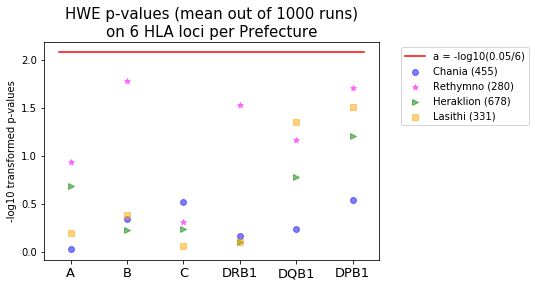

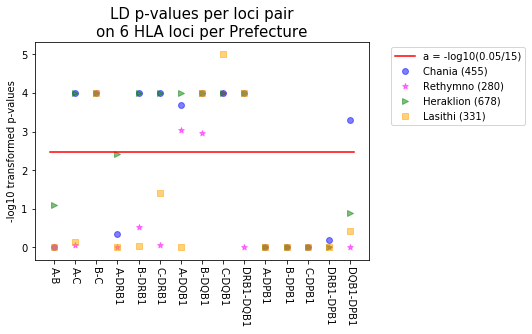

In [251]:
# prefectures_HW = obtain_pvalue_from_Arlequin_xml(f'/home/manos/Programs/Arlequin/cretan_HLA/prefectures/new_analysis/HW/merged.res/merged_HW_6.xml', 'HW')

prefectures_HW = [Ch_HW, Ret_HW, Her_HW, Las_HW]
# prefectures_HWE_LD_pvalues(prefectures_HW, analysis='HW')
prefectures_HWE_LD_pvalues(prefectures_HW, analysis='HW', log10=True)

#### DOES NOT RUN BECAUSE OF A NUMERIC ERROR PRINTED ON HERAKLION ARLEQUIN XML OUTPUT
#### SO I SAVED THE P-VALUES WITH THE COMMAND ON TERMINAL BELOW:
#### grep '(P = ' all_prefectures_LD_6.xml |gawk -F'P = ' '{print $2}'| gawk -F',' '{print $1}' > prefectures_LD_pvals.txt 

# prefectures_LD = obtain_pvalue_from_Arlequin_xml(f'/home/manos/Programs/Arlequin/cretan_HLA/prefectures/1744/LD/merged.res/merged_LD_6.xml', 'LD')

ch_LD = [1.00000, 0.00000, 0.00000, 0.44722, 0.00000, 0.00000, 0.00020, 0.00000, 0.00000, 0.00000, 1.00000, 1.00000, 0.99971, 0.65537, 0.00050]
ret_LD = [1.00000, 0.86585, 0.00000, 0.97357, 0.29853, 0.87768, 0.00092, 0.00106, 0.00000, 1.00000, 1.00000, 1.00000, 1.00000, 1.00000, 0.99983]
her_LD = [0.08014, 0.00000, 0.00000, 0.00371, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 1.00000, 1.00000, 1.00000, 0.99482, 0.12632]
las_LD = [1.00000, 0.71459, 0.00000, 1.00000, 0.94716, 0.03956, 0.99814, 0.00000, 0.00001, 0.00000, 1.00000, 1.00000, 1.00000, 0.99865, 0.38261]

prefectures_LD = [ch_LD, ret_LD, her_LD, las_LD]

# prefectures_HWE_LD_pvalues(prefectures_LD, analysis='LD')
prefectures_HWE_LD_pvalues(prefectures_LD, analysis='LD', log10=True)

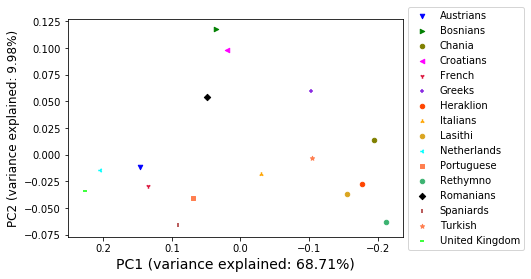

In [254]:
def pca_pref_dkms(chania, rethymno, heraklion, lasithi, aus, bos, cro, fra, ita, net, por, rom, spa, tur, uk, gre, chi, all_alleles=True, af_filter=None):
    
    ita = ita[ita['gene']!='DQB1']
    tur = tur[tur['gene']!='DQB1']
    
    aus_info = dict(zip(aus['allele'].to_list(), aus['af'].to_list()))
    bos_info = dict(zip(bos['allele'].to_list(), bos['af'].to_list()))
    cro_info = dict(zip(cro['allele'].to_list(), cro['af'].to_list()))
    fra_info = dict(zip(fra['allele'].to_list(), fra['af'].to_list()))
    ita_info = dict(zip(ita['allele'].to_list(), ita['af'].to_list()))
    net_info = dict(zip(net['allele'].to_list(), net['af'].to_list()))
    por_info = dict(zip(por['allele'].to_list(), por['af'].to_list()))
    rom_info = dict(zip(rom['allele'].to_list(), rom['af'].to_list()))
    spa_info = dict(zip(spa['allele'].to_list(), spa['af'].to_list()))
    tur_info = dict(zip(tur['allele'].to_list(), tur['af'].to_list()))
    uk_info = dict(zip(uk['allele'].to_list(), uk['af'].to_list()))
    gre_info = dict(zip(gre['allele'].to_list(), gre['af'].to_list()))
    
    chania_alleles = list(chania.keys())
    rethymno_alleles = list(rethymno.keys())
    heraklion_alleles = list(heraklion.keys())
    lasithi_alleles = list(lasithi.keys())
    aus_alleles = aus['allele'].to_list()
    bos_alleles = bos['allele'].to_list()
    cro_alleles = cro['allele'].to_list()
    fra_alleles = fra['allele'].to_list()
    ita_alleles = ita['allele'].to_list()
    net_alleles = net['allele'].to_list()
    por_alleles = por['allele'].to_list()
    rom_alleles = rom['allele'].to_list()
    spa_alleles = spa['allele'].to_list()
    tur_alleles = tur['allele'].to_list()
    uk_alleles = uk['allele'].to_list()
    gre_alleles = gre['allele'].to_list() 
    
    if not chi.empty:
        chi_info = dict(zip(chi['allele'].to_list(), chi['af'].to_list()))
        chi_alleles = chi['allele'].to_list()
        d = [chania_alleles, rethymno_alleles, heraklion_alleles, lasithi_alleles, aus_alleles, bos_alleles, cro_alleles, fra_alleles, ita_alleles, net_alleles, por_alleles, rom_alleles, spa_alleles, tur_alleles, uk_alleles, gre_alleles, chi_alleles]
    else:
        d = [chania_alleles, rethymno_alleles, heraklion_alleles, lasithi_alleles, aus_alleles, bos_alleles, cro_alleles, fra_alleles, ita_alleles, net_alleles, por_alleles, rom_alleles, spa_alleles, tur_alleles, uk_alleles, gre_alleles]
    
    if all_alleles: 
        final_alleles = list(sorted(set(list(itertools.chain.from_iterable(d)))))
    else:
        final_alleles = list(sorted(set(d[0]).intersection(*d)))
        
    total_alleles = len(final_alleles)
    
    dkms_pool = []
    dkms_pool.append(chania);dkms_pool.append(rethymno);dkms_pool.append(heraklion);dkms_pool.append(lasithi)
    dkms_pool.append(aus_info);dkms_pool.append(bos_info);dkms_pool.append(cro_info);dkms_pool.append(fra_info)
    dkms_pool.append(ita_info);dkms_pool.append(net_info);dkms_pool.append(por_info);dkms_pool.append(rom_info)
    dkms_pool.append(spa_info);dkms_pool.append(tur_info);dkms_pool.append(uk_info);dkms_pool.append(gre_info)
    
    markers = {'Chania':'o', 'Rethymno':'o', 'Heraklion':'o', 'Lasithi':'o', 'Austrians':'v', 
               'Bosnians':'>', 'Croatians':'<', 'French':'1', 'Italians':'2', 'Netherlands':'3', 
               'Portuguese':'s', 'Romanians':'D', 'Spaniards':'|', 'Turkish':'*', 'United Kingdom':'_', 
               'Greeks':'+'}
    
    colors = {'Chania':'olive', 'Rethymno':'mediumseagreen', 'Heraklion':'orangered', 'Lasithi':'goldenrod', 
              'Austrians':'blue', 'Bosnians':'green', 'Croatians':'magenta', 'French':'crimson', 
              'Italians':'orange', 'Netherlands':'aqua' , 'Portuguese':'coral', 'Romanians':'black', 
              'Spaniards':'brown', 'Turkish':'coral', 'United Kingdom':'lime', 'Greeks':'blueviolet'}
            
    populations = ['Chania', 'Rethymno', 'Heraklion', 'Lasithi', 'Austrians', 'Bosnians', 'Croatians', 'French', 'Italians', 'Netherlands', 'Portuguese', 'Romanians', 'Spaniards', 'Turkish', 'United Kingdom', 'Greeks']

    if not chi.empty:  
        dkms_pool.append(chi_info)
        table_tmp = np.zeros([17, total_alleles])
        populations.append('Chinese')
        markers['Chinese']='x'
        colors['Chinese']='navy'
    else:
        table_tmp = np.zeros([16, total_alleles])
    
    for x in range(len(dkms_pool)):
        for y in range(total_alleles):
            if final_alleles[y] in dkms_pool[x].keys():
                table_tmp[x][y] += dkms_pool[x][final_alleles[y]]
                
    df1 = pd.DataFrame(data=table_tmp, index=list(range(1, table_tmp.shape[0]+1)), columns=final_alleles)     

    pca = PCA(n_components = 2)
    pca.fit(df1.values)
    pr_data = pca.fit_transform(df1.values)
    pc1, pc2 = pca.explained_variance_ratio_

    df = pd.DataFrame(dict(x=pr_data[:,0], y=pr_data[:,1], label=populations))

    fig, ax = plt.subplots()
    grouped = df.groupby('label')
    
    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key], marker=markers[key], s=20)

    plt.xlabel(f'PC1 (variance explained: {round(pc1*100,2)}%)', fontsize = 14)
    plt.ylabel(f'PC2 (variance explained: {round(pc2*100,2)}%)', fontsize = 12)
    plt.gca().invert_xaxis() # So it can be comparable optically with the previous PCA plots with the whole Crete
    
#     if not chi.empty: 
#         if all_alleles:             
#             if af_filter:
#                 plt.title("PCA on Cretan Prefectures and DKMS\n(with Chinese), ALL alleles, FILTERED", fontsize=13)                
#             else:
#                 plt.title("PCA on Cretan Prefectures and DKMS\n(with Chinese), ALL alleles", fontsize=13)
                
#         else:            
#             if af_filter:
#                 plt.title("PCA on Cretan Prefectures and DKMS\n(with Chinese), COMMON alleles, FILTERED", fontsize=12)    
#             else:
#                 plt.title("PCA on Cretan Prefectures and DKMS\n(with Chinese), COMMON alleles", fontsize=13)       
#     else:
#         if all_alleles:             
#             if af_filter:
#                 plt.title("PCA on Cretan Prefectures and\nDKMS, ALL alleles, FILTERED", fontsize=15)           
#             else:
#                 plt.title("PCA on Cretan Prefectures and\nDKMS, ALL alleles", fontsize=15)
                
#         else:            
#             if af_filter:
#                 plt.title("PCA on Cretan Prefectures and\nDKMS, COMMON alleles, FILTERED", fontsize=14)                
#             else:
#                 plt.title("PCA on Cretan Prefectures and\nDKMS, COMMON alleles", fontsize=15)
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#     fig.set_dpi(300)
#     fig.tight_layout()
    
#     if not chi.empty: 
#         if all_alleles:             
#             if af_filter:
#                 plt.savefig("Prefectures_Analysis/PCA on Cretan Prefectures and DKMS with Chinese ALL alleles FILTERED.png")                
#             else:
#                 plt.savefig("Prefectures_Analysis/PCA on Cretan Prefectures and DKMS with Chinese ALL alleles.png")
                
#         else:            
#             if af_filter:
#                 plt.savefig("Prefectures_Analysis/PCA on Cretan Prefectures and DKMS with Chinese COMMON alleles FILTERED.png")                
#             else:
#                 plt.savefig("Prefectures_Analysis/PCA on Cretan Prefectures and DKMS with Chinese COMMON alleles.png")            
#     else:
#         if all_alleles:             
#             if af_filter:
#                 plt.savefig("Prefectures_Analysis/PCA on Cretan Prefectures and DKMS ALL alleles FILTERED.png")                
#             else:
#                 plt.savefig("Prefectures_Analysis/PCA on Cretan Prefectures and DKMS ALL alleles.png")
                
#         else:            
#             if af_filter:
#                 plt.savefig("Prefectures_Analysis/PCA on Cretan Prefectures and DKMS COMMON alleles FILTERED.png")                
#             else:
#                 plt.savefig("Prefectures_Analysis/PCA on Cretan Prefectures and DKMS COMMON alleles.png")
        
    plt.show()
     
ch_4g_path = '/home/manos/Programs/Hapl-o-Mat/test/Chania/4genes_g/hfs.dat'   
ret_4g_path = '/home/manos/Programs/Hapl-o-Mat/test/Rethymno/4genes_g/hfs.dat'
her_4g_path = '/home/manos/Programs/Hapl-o-Mat/test/Heraklion/4genes_g/hfs.dat'
las_4g_path = '/home/manos/Programs/Hapl-o-Mat/test/Lasithi/4genes_g/hfs.dat'

chania_Ag = af_estimation_from_HaploMat_g_group(ch_4g_path, 'A', 455)     
chania_Bg = af_estimation_from_HaploMat_g_group(ch_4g_path, 'B', 455)
chania_Cg = af_estimation_from_HaploMat_g_group(ch_4g_path, 'C', 455)
chania_DRB1g = af_estimation_from_HaploMat_g_group(ch_4g_path, 'DRB1', 455)

rethymno_Ag = af_estimation_from_HaploMat_g_group(ret_4g_path, 'A', 280)     
rethymno_Bg = af_estimation_from_HaploMat_g_group(ret_4g_path, 'B', 280)
rethymno_Cg = af_estimation_from_HaploMat_g_group(ret_4g_path, 'C', 280)
rethymno_DRB1g = af_estimation_from_HaploMat_g_group(ret_4g_path, 'DRB1', 280)

heraklion_Ag = af_estimation_from_HaploMat_g_group(her_4g_path, 'A', 678)     
heraklion_Bg = af_estimation_from_HaploMat_g_group(her_4g_path, 'B', 678)
heraklion_Cg = af_estimation_from_HaploMat_g_group(her_4g_path, 'C', 678)
heraklion_DRB1g = af_estimation_from_HaploMat_g_group(her_4g_path, 'DRB1', 678)

lasithi_Ag = af_estimation_from_HaploMat_g_group(las_4g_path, 'A', 331)     
lasithi_Bg = af_estimation_from_HaploMat_g_group(las_4g_path, 'B', 331)
lasithi_Cg = af_estimation_from_HaploMat_g_group(las_4g_path, 'C', 331)
lasithi_DRB1g = af_estimation_from_HaploMat_g_group(las_4g_path, 'DRB1', 331)

chania_4g = {**chania_Ag, **chania_Bg, **chania_Cg, **chania_DRB1g}
rethymno_4g = {**rethymno_Ag, **rethymno_Bg, **rethymno_Cg, **rethymno_DRB1g}
heraklion_4g = {**heraklion_Ag, **heraklion_Bg, **heraklion_Cg, **heraklion_DRB1g}
lasithi_4g = {**lasithi_Ag, **lasithi_Bg, **lasithi_Cg, **lasithi_DRB1g}

chania_4gb = {k:v for k,v in chania_4g.items() if v > round(1/(2*455), 6)}
rethymno_4gb = {k:v for k,v in rethymno_4g.items() if v > round(1/(2*280), 6)}
heraklion_4gb = {k:v for k,v in heraklion_4g.items() if v > round(1/(2*678), 6)}
lasithi_4gb = {k:v for k,v in lasithi_4g.items() if v > round(1/(2*331), 6)}

# pca_pref_dkms(chania_4g, rethymno_4g, heraklion_4g, lasithi_4g, austrian_minority_in_Germany, bosnian_minority_in_Germany, croatian_minority_in_Germany, french_minority_in_Germany, italian_minority_in_Germany, netherlands_minority_in_Germany, portuguese_minority_in_Germany, romanian_minority_in_Germany, spanish_minority_in_Germany, turkish_minority_in_Germany, united_kingdom_minority_in_Germany, greek_minority_in_Germany, chinese_minority_in_Germany, all_alleles=True)
# pca_pref_dkms(chania_4g, rethymno_4g, heraklion_4g, lasithi_4g, austrian_minority_in_Germany, bosnian_minority_in_Germany, croatian_minority_in_Germany, french_minority_in_Germany, italian_minority_in_Germany, netherlands_minority_in_Germany, portuguese_minority_in_Germany, romanian_minority_in_Germany, spanish_minority_in_Germany, turkish_minority_in_Germany, united_kingdom_minority_in_Germany, greek_minority_in_Germany, pd.DataFrame(), all_alleles=True)
# pca_pref_dkms(chania_4gb, rethymno_4gb, heraklion_4gb, lasithi_4gb, austrian_minority_in_Germany2, bosnian_minority_in_Germany2, croatian_minority_in_Germany2, french_minority_in_Germany2, italian_minority_in_Germany2, netherlands_minority_in_Germany2, portuguese_minority_in_Germany2, romanian_minority_in_Germany2, spanish_minority_in_Germany2, turkish_minority_in_Germany2, united_kingdom_minority_in_Germany2, greek_minority_in_Germany2, chinese_minority_in_Germany2, all_alleles=True, af_filter=True)
# pca_pref_dkms(chania_4gb, rethymno_4gb, heraklion_4gb, lasithi_4gb, austrian_minority_in_Germany2, bosnian_minority_in_Germany2, croatian_minority_in_Germany2, french_minority_in_Germany2, italian_minority_in_Germany2, netherlands_minority_in_Germany2, portuguese_minority_in_Germany2, romanian_minority_in_Germany2, spanish_minority_in_Germany2, turkish_minority_in_Germany2, united_kingdom_minority_in_Germany2, greek_minority_in_Germany2, pd.DataFrame(), all_alleles=True, af_filter=True)
# pca_pref_dkms(chania_4g, rethymno_4g, heraklion_4g, lasithi_4g, austrian_minority_in_Germany, bosnian_minority_in_Germany, croatian_minority_in_Germany, french_minority_in_Germany, italian_minority_in_Germany, netherlands_minority_in_Germany, portuguese_minority_in_Germany, romanian_minority_in_Germany, spanish_minority_in_Germany, turkish_minority_in_Germany, united_kingdom_minority_in_Germany, greek_minority_in_Germany, chinese_minority_in_Germany, all_alleles=False)
# pca_pref_dkms(chania_4g, rethymno_4g, heraklion_4g, lasithi_4g, austrian_minority_in_Germany, bosnian_minority_in_Germany, croatian_minority_in_Germany, french_minority_in_Germany, italian_minority_in_Germany, netherlands_minority_in_Germany, portuguese_minority_in_Germany, romanian_minority_in_Germany, spanish_minority_in_Germany, turkish_minority_in_Germany, united_kingdom_minority_in_Germany, greek_minority_in_Germany, pd.DataFrame(), all_alleles=False)
# pca_pref_dkms(chania_4gb, rethymno_4gb, heraklion_4gb, lasithi_4gb, austrian_minority_in_Germany2, bosnian_minority_in_Germany2, croatian_minority_in_Germany2, french_minority_in_Germany2, italian_minority_in_Germany2, netherlands_minority_in_Germany2, portuguese_minority_in_Germany2, romanian_minority_in_Germany2, spanish_minority_in_Germany2, turkish_minority_in_Germany2, united_kingdom_minority_in_Germany2, greek_minority_in_Germany2, chinese_minority_in_Germany2, all_alleles=False, af_filter=True)
pca_pref_dkms(chania_4gb, rethymno_4gb, heraklion_4gb, lasithi_4gb, austrian_minority_in_Germany2, bosnian_minority_in_Germany2, croatian_minority_in_Germany2, french_minority_in_Germany2, italian_minority_in_Germany2, netherlands_minority_in_Germany2, portuguese_minority_in_Germany2, romanian_minority_in_Germany2, spanish_minority_in_Germany2, turkish_minority_in_Germany2, united_kingdom_minority_in_Germany2, greek_minority_in_Germany2, pd.DataFrame(), all_alleles=False, af_filter=True)

In [270]:
# def hapl_input_Prefectures_together(prefecture_txt):
    
#     with open(prefecture_txt, 'r') as f:
#         f = f.readlines()

#     f = [x.strip('\n').split('\t')[1:] for x in f][1:]
    
#     return f

# ch_tmp = hapl_input_Prefectures_together('Chania_75.txt')
# ret_tmp = hapl_input_Prefectures_together('Rethymno_75.txt')
# her_tmp = hapl_input_Prefectures_together('Heraklion_75.txt')
# las_tmp = hapl_input_Prefectures_together('Lasithi_75.txt')

# df_tmp = pd.DataFrame(ch_tmp+ret_tmp+her_tmp+las_tmp)
# df_tmp['id'] = list(range(1,len(df_tmp)+1))
# cols = df_tmp.columns.tolist()
# cols = cols[-1:] + cols[:-1]
# df_tmp = df_tmp[cols]
# df_tmp.columns =  ['id', 'A', 'A', 'B', 'B', 'C', 'C', 'DRB1', 'DRB1', 'DQB1', 'DQB1', 'DPB1', 'DPB1']
# df_tmp.to_csv('1744_Prefectures_75.txt', header=True, index=False, sep='\t', mode='a')
# os.system('mv 1744_Prefectures_75.txt /home/manos/Programs/Hapl-o-Mat/test/')

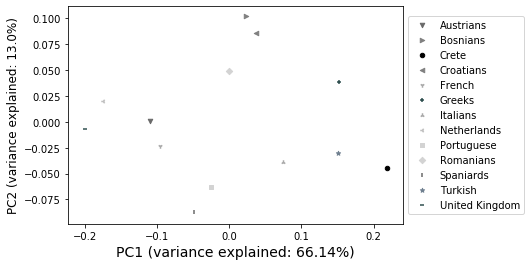

In [275]:
### Prepare the input for the 4 Prefectures together for the PCA plots

pref_4g_path = '/home/manos/Programs/Hapl-o-Mat/test/dkms_g_group/1744/4genes_g/hfs.dat'

prefecture_Ag = af_estimation_from_HaploMat_g_group(pref_4g_path, 'A', 1744)     
prefecture_Bg = af_estimation_from_HaploMat_g_group(pref_4g_path, 'B', 1744)
prefecture_Cg = af_estimation_from_HaploMat_g_group(pref_4g_path, 'C', 1744)
prefecture_DRB1g = af_estimation_from_HaploMat_g_group(pref_4g_path, 'DRB1', 1744)

prefecture_4g = {**prefecture_Ag, **prefecture_Bg, **prefecture_Cg, **prefecture_DRB1g}
prefecture_4g = {k:round(v, 6) for k,v in prefecture_4g.items()}
prefecture_4gb = {k:v for k,v in prefecture_4g.items() if v > round(1/(2*1744), 6)}

id_a = list(range(1, len(prefecture_4g)+1))
id_b = list(range(1, len(prefecture_4gb)+1))

allele_a = list(prefecture_4g.keys())
allele_b = list(prefecture_4gb.keys())

pop_a = ['4 Cretan Prefectures']*len(prefecture_4g)
pop_b = ['4 Cretan Prefectures']*len(prefecture_4gb)

af_a = list(prefecture_4g.values())
af_b = list(prefecture_4gb.values())

sz_a = [1146]*len(prefecture_4g)
sz_b = [1146]*len(prefecture_4gb)

g_a = [x.split('*')[0] for x in allele_a]
g_b = [x.split('*')[0] for x in allele_b]

Pref = pd.DataFrame({'id': id_a,'allele': allele_a,'pop': pop_a,'af': af_a,'sample_size': sz_a,'gene': g_a})
Pref_b = pd.DataFrame({'id': id_b,'allele': allele_b,'pop': pop_b,'af': af_b,'sample_size': sz_b,'gene': g_b})

##### Before excecuting the commands below, make sure to put the PCA plots on that are currently on
##### Cretan_Project/ into a tmp folder and after you run it, take the new plots into the folder
##### Prefectures_Analysis/PCA on 4 Prefectures/ and then move the plots from the tmp folder to Cretan_Project/

# pca_dkms(Pref, austrian_minority_in_Germany, bosnian_minority_in_Germany, croatian_minority_in_Germany, french_minority_in_Germany, italian_minority_in_Germany, netherlands_minority_in_Germany, portuguese_minority_in_Germany, romanian_minority_in_Germany, spanish_minority_in_Germany, turkish_minority_in_Germany, united_kingdom_minority_in_Germany, greek_minority_in_Germany, chinese_minority_in_Germany, all_alleles=True)
# pca_dkms(Pref, austrian_minority_in_Germany, bosnian_minority_in_Germany, croatian_minority_in_Germany, french_minority_in_Germany, italian_minority_in_Germany, netherlands_minority_in_Germany, portuguese_minority_in_Germany, romanian_minority_in_Germany, spanish_minority_in_Germany, turkish_minority_in_Germany, united_kingdom_minority_in_Germany, greek_minority_in_Germany, pd.DataFrame(), all_alleles=True)
# pca_dkms(Pref_b, austrian_minority_in_Germany2, bosnian_minority_in_Germany2, croatian_minority_in_Germany2, french_minority_in_Germany2, italian_minority_in_Germany2, netherlands_minority_in_Germany2, portuguese_minority_in_Germany2, romanian_minority_in_Germany2, spanish_minority_in_Germany2, turkish_minority_in_Germany2, united_kingdom_minority_in_Germany2, greek_minority_in_Germany2, chinese_minority_in_Germany2, all_alleles=True, af_filter=True)
# pca_dkms(Pref_b, austrian_minority_in_Germany2, bosnian_minority_in_Germany2, croatian_minority_in_Germany2, french_minority_in_Germany2, italian_minority_in_Germany2, netherlands_minority_in_Germany2, portuguese_minority_in_Germany2, romanian_minority_in_Germany2, spanish_minority_in_Germany2, turkish_minority_in_Germany2, united_kingdom_minority_in_Germany2, greek_minority_in_Germany2, pd.DataFrame(), all_alleles=True, af_filter=True)
# pca_dkms(Pref, austrian_minority_in_Germany, bosnian_minority_in_Germany, croatian_minority_in_Germany, french_minority_in_Germany, italian_minority_in_Germany, netherlands_minority_in_Germany, portuguese_minority_in_Germany, romanian_minority_in_Germany, spanish_minority_in_Germany, turkish_minority_in_Germany, united_kingdom_minority_in_Germany, greek_minority_in_Germany, chinese_minority_in_Germany, all_alleles=False)
# pca_dkms(Pref, austrian_minority_in_Germany, bosnian_minority_in_Germany, croatian_minority_in_Germany, french_minority_in_Germany, italian_minority_in_Germany, netherlands_minority_in_Germany, portuguese_minority_in_Germany, romanian_minority_in_Germany, spanish_minority_in_Germany, turkish_minority_in_Germany, united_kingdom_minority_in_Germany, greek_minority_in_Germany, pd.DataFrame(), all_alleles=False)
# pca_dkms(Pref_b, austrian_minority_in_Germany2, bosnian_minority_in_Germany2, croatian_minority_in_Germany2, french_minority_in_Germany2, italian_minority_in_Germany2, netherlands_minority_in_Germany2, portuguese_minority_in_Germany2, romanian_minority_in_Germany2, spanish_minority_in_Germany2, turkish_minority_in_Germany2, united_kingdom_minority_in_Germany2, greek_minority_in_Germany2, chinese_minority_in_Germany2, all_alleles=False, af_filter=True)
pca_dkms(Pref_b, austrian_minority_in_Germany2, bosnian_minority_in_Germany2, croatian_minority_in_Germany2, french_minority_in_Germany2, italian_minority_in_Germany2, netherlands_minority_in_Germany2, portuguese_minority_in_Germany2, romanian_minority_in_Germany2, spanish_minority_in_Germany2, turkish_minority_in_Germany2, united_kingdom_minority_in_Germany2, greek_minority_in_Germany2, pd.DataFrame(), all_alleles=False, af_filter=True)

In [276]:
g4_path = '/home/manos/Programs/Hapl-o-Mat/test/dkms_g_group/1835/4genes_g/hfs.dat'
cr_hapl = haplomat_output_parce(g4_path, 1835)
austrian_hapl_freq = dict(zip(austrian_hf['haplotype'].to_list(), [x/100 for x in austrian_hf['hf'].to_list()]))
bosnian_hapl_freq = dict(zip(bosnian_hf['haplotype'].to_list(), [x/100 for x in bosnian_hf['hf'].to_list()]))
china_hapl_freq = dict(zip(china_hf['haplotype'].to_list(), [x/100 for x in china_hf['hf'].to_list()]))
croatia_hapl_freq = dict(zip(croatia_hf['haplotype'].to_list(), [x/100 for x in croatia_hf['hf'].to_list()]))
french_hapl_freq = dict(zip(french_hf['haplotype'].to_list(), [x/100 for x in french_hf['hf'].to_list()]))
greek_hapl_freq = dict(zip(greek_hf['haplotype'].to_list(), [x/100 for x in greek_hf['hf'].to_list()]))
italian_hapl_freq = dict(zip(italian_hf['haplotype'].to_list(), [x/100 for x in italian_hf['hf'].to_list()]))
netherland_hapl_freq = dict(zip(netherland_hf['haplotype'].to_list(), [x/100 for x in netherland_hf['hf'].to_list()]))
portugal_hapl_freq = dict(zip(portugal_hf['haplotype'].to_list(), [x/100 for x in portugal_hf['hf'].to_list()]))
romanian_hapl_freq = dict(zip(romanian_hf['haplotype'].to_list(), [x/100 for x in romanian_hf['hf'].to_list()]))
spanish_hapl_freq = dict(zip(spanish_hf['haplotype'].to_list(), [x/100 for x in spanish_hf['hf'].to_list()]))
turkish_hapl_freq = dict(zip(turkish_hf['haplotype'].to_list(), [x/100 for x in turkish_hf['hf'].to_list()]))
united_kingdom_hapl_freq = dict(zip(united_kingdom_hf['haplotype'].to_list(), [x/100 for x in united_kingdom_hf['hf'].to_list()]))

In [277]:
def calculate_distances(cr,aus,bos,cro,fre,gre,ita,net,por,rom,spa,tur,uni, euclidean=None, prevosti=None, chi=None):
    
    if sum([x for x in [euclidean,prevosti] if x])==0 or sum([x for x in [euclidean,prevosti] if x])==2:
        raise Exception("Choose either Euclidean or Prevosti's distance.")

    if chi:
        population_list = [cr,aus,bos,chi,cro,fre,gre,ita,net,por,rom,spa,tur,uni]
        population_names = ['Crete', 'Austria', 'Bosnia-Erzegovina', 'China', 'Croatia', 'France', 'Greece', 'Italy', 'Netherlands' ,'Portugal', 'Romania', 'Spain', 'Turkey', 'United kingdom']
                
    else:
        population_list = [cr,aus,bos,cro,fre,gre,ita,net,por,rom,spa,tur,uni]
        population_names = ['Crete', 'Austria', 'Bosnia-Erzegovina', 'Croatia', 'France', 'Greece', 'Italy', 'Netherlands' ,'Portugal', 'Romania', 'Spain', 'Turkey', 'United kingdom']
    
    arr = np.zeros((len(population_names),len(population_names)))
    
    for x in range(len(population_list)):
        for y in range(len(population_names)):
            if population_list[x] != population_list[y]:
                
                all_haplotypes = list(set(list(population_list[x].keys())+list(population_list[y].keys())))
                a = [population_list[x][z] if z in population_list[x].keys() else 0 for z in all_haplotypes]
                b = [population_list[y][z] if z in population_list[y].keys() else 0 for z in all_haplotypes]                
 
                if euclidean:
                    arr[x][y] += np.linalg.norm(np.array(a)-np.array(b))
                    
                elif prevosti: # similar to Manhattan distance
                    arr[x][y] += np.sum(np.abs(np.array(a)-np.array(b)))*0.5
                
    df = pd.DataFrame(data=arr, index=population_names, columns=population_names)            
            
    
    return df

euc_distances = calculate_distances(cr_hapl,austrian_hapl_freq,bosnian_hapl_freq,croatia_hapl_freq,french_hapl_freq,greek_hapl_freq,italian_hapl_freq,netherland_hapl_freq,portugal_hapl_freq,romanian_hapl_freq,spanish_hapl_freq,turkish_hapl_freq,united_kingdom_hapl_freq, euclidean=True, prevosti=None)
prev_distances = calculate_distances(cr_hapl,austrian_hapl_freq,bosnian_hapl_freq,croatia_hapl_freq,french_hapl_freq,greek_hapl_freq,italian_hapl_freq,netherland_hapl_freq,portugal_hapl_freq,romanian_hapl_freq,spanish_hapl_freq,turkish_hapl_freq,united_kingdom_hapl_freq, euclidean=None, prevosti=True)

In [278]:
prev_distances

,Crete,Austria,Bosnia-Erzegovina,Croatia,France,Greece,Italy,Netherlands,Portugal,Romania,Spain,Turkey,United kingdom
Crete,0.000000,0.793742,0.784101,0.722005,0.796782,0.706032,0.713492,0.824458,0.76738,0.744403,0.804282,0.674939,0.838021
Austria,0.793742,0.000000,0.652300,0.608700,0.581800,0.750000,0.671400,0.564200,0.64300,0.606550,0.644550,0.748250,0.576500
Bosnia-Erzegovina,0.784101,0.652300,0.000000,0.523100,0.701100,0.713800,0.703800,0.702500,0.68930,0.621450,0.733650,0.766850,0.704800
Croatia,0.722005,0.608700,0.523100,0.000000,0.654000,0.656100,0.662100,0.655900,0.64670,0.570350,0.683550,0.701550,0.670900
France,0.796782,0.581800,0.701100,0.654000,0.000000,0.773700,0.682800,0.602000,0.66240,0.642850,0.663150,0.766450,0.608700
Greece,0.706032,0.750000,0.713800,0.656100,0.773700,0.000000,0.695900,0.779700,0.75950,0.686450,0.775950,0.656050,0.792800
Italy,0.713492,0.671400,0.703800,0.662100,0.682800,0.695900,0.000000,0.710400,0.67190,0.662050,0.688250,0.687550,0.705500
Netherlands,0.824458,0.564200,0.702500,0.655900,0.602000,0.779700,0.710400,0.000000,0.66770,0.640850,0.670650,0.793550,0.549700
Portugal,0.767380,0.643000,0.689300,0.646700,0.662400,0.759500,0.671900,0.667700,0.00000,0.656650,0.622050,0.749550,0.655300
Romania,0.744403,0.606550,0.621450,0.570350,0.642850,0.686450,0.662050,0.640850,0.65665,0.000000,0.678200,0.710400,0.653950


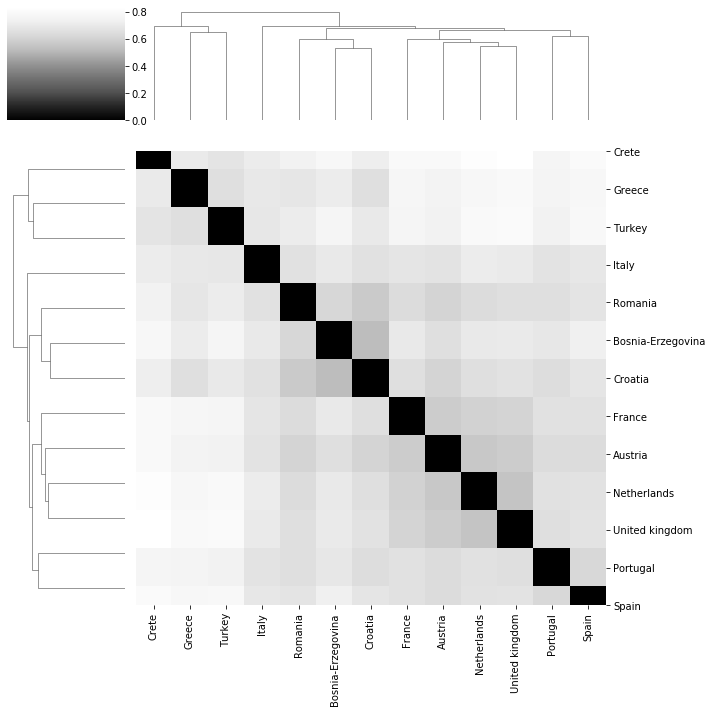

In [287]:
# g = sns.clustermap(prev_distances)
g = sns.clustermap(prev_distances, cmap='Greys_r')

plt.tight_layout()
# g.savefig(f"Cluster Map {n_Cretans}.png", dpi=300)

In [51]:
def pypop_input(txt_file):
    
    '''
    This function converts Hapl-o-Mat input to PyPop input for HLA loci
    The Hapl-o-Mat input should contain HLA genotypes of the HLA genes
    -A, -B, -C, -DRB1, -DQB1 and -DPB1 in this order only.
    '''
    
    with open(txt_file, 'r') as f:
        f = f.readlines()
        
    f = [x.replace(':','').strip('\n').split('\t')[1:] for x in f][1:]
    new_header = ['a_1', 'a_2', 'b_1', 'b_2', 'c_1', 'c_2', 'drb1_1', 'drb1_2', 'dqb1_1', 'dqb1_2', 'dpb1_1', 'dpb1_2']
    final = [new_header]+f
    
    tmp = f'/home/manos/Programs/PyPopLinux-0.7.0/HLA/{n_Cretans}/'+txt_file.split('.')[0]+'.pop'
    
    if os.path.exists(tmp):
        os.remove(tmp)
    
    with open(tmp,'w') as f:
        wr = csv.writer(f, delimiter='\t')
        wr.writerows(final)

# pypop_input('Crete_75.txt')
# pypop_input('Chania_75.txt')
# pypop_input('Rethymno_75.txt')
# pypop_input('Heraklion_75.txt')
# pypop_input('Lasithi_75.txt')
# pypop_input('Mylopotamos_all.txt')
# pypop_input('Rest_Rethymno_all.txt')